# Environmental impact of GPM precipitation features 

In [1]:
# Import libraries
import iris
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
import datetime
import urllib,zipfile,shutil
%matplotlib inline
# Import tobac itself
import tobac
from tobac import utils
import xarray as xr 
import glob


In [2]:
# import tracks for ERA 

savedir='/media/juli/Elements/ERA5/monthly/Save'
data_dir='/media/juli/Elements/ERA5/monthly/'
file = savedir + '/Tracks_ERA5_2006_2016_new.h5'
Tracks = pd.read_hdf(file, 'table')
Tracks['timestr']=pd.to_datetime(Tracks['timestr'],format='%Y-%m-%d %H:%M:%S')

In [680]:
Tracks.shape
np.shape(np.unique(Tracks.cell.values))
np.unique(Tracks.cell.values[Tracks.cell.values > 0]).shape

(47524,)

In [3]:
# import tracks for CNRR 
savedir='/media/juli/Data/third_pole/mcs_tracking/CNRR/Save'
file = savedir + '/Tracks_CNRR_2006_2016_updatedframes.h5'
file = savedir + '/Tracks_CNRR_2006-2016_storms.h5'
Tracks_cnrr = pd.read_hdf(file, 'table')
Tracks_cnrr['timestr']=pd.to_datetime(Tracks_cnrr['timestr'],format='%Y-%m-%d %H:%M:%S')

In [3]:
# import tracks for GPM 
savedir='/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tobac/Save'
file = savedir + '/Tracks_GPM_2014_2017_updatedframes.h5'
#file = savedir + '/Tracks_GPM_2014-2017_v_precip.h5'
Tracks = pd.read_hdf(file, 'table')
Tracks['timestr']=pd.to_datetime(Tracks['timestr'],format='%Y-%m-%d %H:%M:%S')

In [5]:
# import tracks for GPM 
savedir='/media/juli/Data/third_pole/satellite_data/gpm_v06/Save'
file = savedir + '/Tracks_GPM_2006_2016_storms_tpflag.h5'
Tracks_gpm = pd.read_hdf(file, 'table')
Tracks_gpm['timestr']=pd.to_datetime(Tracks_gpm['timestr'],format='%Y-%m-%d %H:%M:%S')


In [800]:
## SEGMENT SELECTION 

# This function takes a time slot of the cell mask (with tracked features) and a feature ID as an input and returns an index
# marking the entire region which belongs to cell in the specific timestep (this is needed), since
# the segmentation and cell masks still contain different feature IDs for one cloud object whereas
# only one feature is listed in the tracking dataframe

def select_segment(mask, f):
    import scipy.ndimage as ndi
    # labeling : each contiguous region is associated with an int
    labels, n = ndi.label(mask)
    x = np.where(mask== f)[0][0]
    y= np.where(mask == f)[1][0]
    new_label = labels[x,y]
    segment_i = labels == new_label

    return segment_i 


In [718]:
## UPDATE MASK 

# This function updates the segmentation mask and returns a cell mask where only areas which belong to cell
# segments are marked and all other identified features are removed. Takes feat_select as an input which are
# all the tracked features in tracking dataframe for a given time frame 

def update_mask(mask, feat_select):
    import scipy.ndimage as ndi

    for frame, xy in enumerate(mask):
        segments, n = ndi.label(xy)
        for i in np.unique(segments[segments > 0]):
            keep = 0 
            for f in xy[segments == i]:
                # if one of the features is in tracking dataframe, keep marked area 
                if f in feat_select.feature.values:
                    keep += 1
                else:
                    keep += 0
                    
            if keep == 0 :
                xy[segments == i] = 0
                mask[frame] = xy 
                
    return mask 


# calculations for tracks frame: 

- velocities
- total precip amount (obs, 30 min in GPM data!)
- contributions 
- max and mean rain rates 
- area 
- nearest neigbors 

## velocities

In [850]:
# calculate and save velocities 
Track = tobac.calculate_velocity(Track)
Track.to_hdf(savedir + '/Tracks_ERA5_2006-2016_v.h5','table')

In [932]:
f= '/media/juli/Data/third_pole/satellite_data/gpm_v06/Save/Mask_Segmentation_precip200307.nc'
f= '/media/juli/Data/third_pole/satellite_data/gpm_v06/2001/gpm_imerg_200111_tobac_input.nc4'
prcp= Dataset(f)['precipitationCal']


(351, 181)

## precip functions

In [684]:
def calculate_rain_impact(f, Tracks, gpm_dir, frames ,it):
    
    from netCDF4 import Dataset
    date= f[len(f)-9: len(f)-3]
    yearmonth= f[len(f)-9: len(f)-5] + '-' + f[len(f)-5: len(f)-3]
    print('calculating rain impact for.....', date)

    # read in data mask with segments for tracked cells 
    ds = Dataset(f)
    mask = np.array(ds['segmentation_mask'])  
    
    # select features for corresponding month in combined tracks 
    feat_select= Tracks.loc[Tracks['timestr'].dt.strftime('%Y-%m') == yearmonth]
    
    # read in corresponding precip file 
    file = gpm_dir + 'gpm_imerg_'+ date + '_tobac_input.nc4'
    #file = gpm_dir + 'cnrr_cnrr_'+date+'_TP.nc4.nc4'
    ds_precip= Dataset(file)
    precip = np.array(ds_precip['precipitationCal'])
    #precip = np.array(ds_precip['prcp'])
    precip[precip < 0.0 ] = 0 
    ds_precip.close()
    
    # update mask to include only precip from tracked features 
    for frame, values in enumerate(mask):
        frame_idx_table = frame + feat_select['frame'].values[0]
        frame_select =feat_select.loc[feat_select['frame'] == frame_idx_table]  # all tracked features in this time frame 
        frame_idx_mask= frame_idx_table  - frames  
            
        if frame_idx_mask < 0 :
            print('error in mask index calculation! --->', frame_idx_mask)
            break
        if frame_select.shape[0] != 0 and frame_idx_mask < np.shape(mask)[0]: 
            #print(frame_idx_table, frame_idx_mask)
            #if it < feat_select['frame'].values.shape[0] -2:
             #   it+= 1 

            timeframe= mask[frame_idx_mask, :, :] # timestep of frame with features  

            # test if segments in example also are linked features: 
            features = np.unique(timeframe[timeframe > 0])
            tracked_features = frame_select['feature'].values
            for f in features:
                if f not in tracked_features:
                    mask[frame_idx_mask, :, :][timeframe == f]= 0 

            values = mask[frame_idx_mask,:,:]
            # calculate total precip per system in new mask 
            timestamp= precip[frame_idx_mask, :, :]
            # update frame value 
            
            for v in np.unique(values[values > 0]):
                segment_i = select_segment(values, v )
                total_prec = np.nansum(timestamp[segment_i])
                
                # add values to track dataframe 
                for i in Tracks[Tracks['feature'] == v ].index:
                    Tracks.at[i, 'precip']= total_prec

    print('dataframe update for all features in ',str(yearmonth), 'frames:', frames, 'mask', np.shape(mask))
    if it == 0:
        frames += np.shape(mask)[0] - 1 
        it = 1 
    else:
        frames += np.shape(mask)[0]
        
    return Tracks, frames, it


In [432]:
from netCDF4 import Dataset
# read in corresponding elevation file 
path = '/media/juli/Data/master_thesis/Master_thesis/data/DEM_TP.tif/dem_GPM_format.nc' 
ds= Dataset(path)
param = '__xarray_dataarray_variable__'
dem= np.array(ds[param])

In [504]:
# read in cell mask 
f = savedir+ '/Precip_cells201607.nc'
ds = Dataset(f)
param = '__xarray_dataarray_variable__'
mask = np.array(ds[param])  
prcp= mask[167]

In [1008]:
def get_tp_flag(f, Tracks, dataset, frames ,it):
    from netCDF4 import Dataset
    date= f[len(f)-9: len(f)-3]
    yearmonth= f[len(f)-9: len(f)-5] + '-' + f[len(f)-5: len(f)-3]
    print('get rain rates for.....', date)

    # read in cell mask 
    ds = Dataset(f)
    param = '__xarray_dataarray_variable__'
    mask = np.array(ds[param])  
    
    # read in corresponding elevation file 
    if dataset == 'era':
        path = '/media/juli/Data/master_thesis/Master_thesis/data/DEM_TP.tif/dem_ERA5_format.nc' 
    elif dataset == 'gpm':
         path = '/media/juli/Data/master_thesis/Master_thesis/data/DEM_TP.tif/dem_GPM_format.nc' 
    ds= Dataset(path)
    dem= np.flip(np.array(ds[param]).T, axis = 0)

    # select features for corresponding month in combined tracks 
    feat_select= Tracks.loc[Tracks['timestr'].dt.strftime('%Y-%m') == yearmonth]
    
    for frame, values in enumerate(mask):
        frame_idx_table = frame + feat_select['frame'].values[0]
        frame_select =feat_select.loc[feat_select['frame'] == frame_idx_table]  # all tracked features in this time frame 
        frame_idx_mask= frame_idx_table  - frames  
            
        if frame_idx_mask < 0 :
            print('error in mask index calculation! --->', frame_idx_mask)
            break
        if frame_select.shape[0] != 0 and frame_idx_mask < np.shape(mask)[0]:          
            features= mask[frame_idx_mask, :, :] # specific frame with tracked features    
            
            # test how many of the segments lie above 3000 m ASL and add corresponding flag ! 
            for f in np.unique(features[features > 0]):
                segment_i = select_segment(features, f )
                segment = dem[segment_i]
                count = np.shape(segment[segment >= 3000])[0]     
                if count > 1: 
                    flag = 1 
                if count == np.shape(dem[segment_i])[0]:
                    flag = 2 
                elif count == 0 or count == 1:
                    flag = 0 
                        
                # add values to track dataframe 
                for i in Tracks[Tracks['feature'] == f ].index:
                    Tracks.at[i, 'flag']= flag


    print('dataframe update for all features in ',str(yearmonth), 'frames:', frames, 'mask', np.shape(mask))
    if it == 0:
        frames += np.shape(mask)[0] - 1 
        it = 1 
    else:
        frames += np.shape(mask)[0]
        
    return Tracks, frames, it


## setting elevation flag 

In [1015]:
a = Tracks[Tracks.flag == 0 ]
a.shape[0]/Tracks.shape[0]*100

44.25472615103846

GPM Tracks


- 23 % entirely within TP 
- 32 % cross the TP  
- 44 % entirely outside of the TP 

# how much of all tracked features got additional statistics

In [973]:
a = Tracks[Tracks.mean_rr >0 ]
a.shape[0]/Tracks.shape[0]*100

99.98313860070223

In [969]:
vals = Tracks.total_precip.values[Tracks.total_precip.values >= 0 ].shape[0]
vals /np.shape(Tracks)[0]

AttributeError: 'DataFrame' object has no attribute 'total_precip'

In [1009]:
frames = 0 
it = 0 
dataset= 'era'
for f in file_list:
    Tracks_tp, frames, it = get_tp_flag(f, Tracks, dataset, frames, it )
    

get rain rates for..... 200601
dataframe update for all features in  2006-01 frames: 0 mask (1488, 351, 181)
get rain rates for..... 200602
dataframe update for all features in  2006-02 frames: 1487 mask (1344, 351, 181)
get rain rates for..... 200603
dataframe update for all features in  2006-03 frames: 2831 mask (1488, 351, 181)
get rain rates for..... 200604
dataframe update for all features in  2006-04 frames: 4319 mask (1440, 351, 181)
get rain rates for..... 200605
dataframe update for all features in  2006-05 frames: 5759 mask (1488, 351, 181)
get rain rates for..... 200606
dataframe update for all features in  2006-06 frames: 7247 mask (1440, 351, 181)
get rain rates for..... 200607
dataframe update for all features in  2006-07 frames: 8687 mask (1488, 351, 181)
get rain rates for..... 200608
dataframe update for all features in  2006-08 frames: 10175 mask (1488, 351, 181)
get rain rates for..... 200609
dataframe update for all features in  2006-09 frames: 11663 mask (1440, 351

dataframe update for all features in  2012-02 frames: 106655 mask (1392, 351, 181)
get rain rates for..... 201203
error in mask index calculation! ---> -37
dataframe update for all features in  2012-03 frames: 108047 mask (1488, 351, 181)
get rain rates for..... 201204
dataframe update for all features in  2012-04 frames: 109535 mask (1440, 351, 181)
get rain rates for..... 201205
dataframe update for all features in  2012-05 frames: 110975 mask (1488, 351, 181)
get rain rates for..... 201206
dataframe update for all features in  2012-06 frames: 112463 mask (1440, 351, 181)
get rain rates for..... 201207
dataframe update for all features in  2012-07 frames: 113903 mask (1488, 351, 181)
get rain rates for..... 201208
dataframe update for all features in  2012-08 frames: 115391 mask (1488, 351, 181)
get rain rates for..... 201209
dataframe update for all features in  2012-09 frames: 116879 mask (1440, 351, 181)
get rain rates for..... 201210
dataframe update for all features in  2012-10 

In [1010]:
def get_rainrates(f, Tracks, path, frames ,it):
    from netCDF4 import Dataset
    date= f[len(f)-9: len(f)-3]
    yearmonth= f[len(f)-9: len(f)-5] + '-' + f[len(f)-5: len(f)-3]
    print('get rain rates for.....', date)

    # read in cell mask 
    ds = Dataset(f)
    mask = np.array(ds['__xarray_dataarray_variable__'])  
    
    # read in corresponding file with rain rates 
    ##CNRR 
    #file = path + 'cnrr_cnrr_'+date+'_TP.nc4.nc4'
    #ds_precip= Dataset(file)
    #precip = np.array(ds_precip['prcp'])
    ## GPM 
    file = glob.glob(path + 'era_precip_*tobac*'+ date + '.nc')[0]
    ds_precip= Dataset(file)
    precip = np.array(ds_precip['tp'])*1000
    precip[precip < 0.0 ] = 0 
    ds_precip.close()
    
    # select features for corresponding month in combined tracks 
    feat_select= Tracks.loc[Tracks['timestr'].dt.strftime('%Y-%m') == yearmonth]
    
    for frame, values in enumerate(mask):
        frame_idx_table = frame + feat_select['frame'].values[0]
        frame_select =feat_select.loc[feat_select['frame'] == frame_idx_table]  # all tracked features in this time frame 
        frame_idx_mask= frame_idx_table  - frames  
            
        if frame_idx_mask < 0 :
            print('error in mask index calculation! --->', frame_idx_mask)
            break
        if frame_select.shape[0] != 0 and frame_idx_mask < np.shape(mask)[0]: 
            
            features= mask[frame_idx_mask, :, :] # specific frame with tracked features
            precip_frame = precip[frame_idx_mask, :,:] # specific frame with rain rates 
            
            # extract max and mean rain rates 
            for f in np.unique(features[features > 0]):
                segment_i = select_segment(features, f )
                max_prec = np.nanmax(precip_frame[segment_i])
                mean_prec = np.nanmean(precip_frame[segment_i])   
                total_precip = np.nansum(precip_frame[segment_i])
                dxy = 14136.0/1000
                area = np.shape(precip_frame[segment_i])[0]*dxy*dxy 
                eq_radius = np.sqrt(area/np.pi)
                
                # add values to track dataframe 
                for i in Tracks[Tracks['feature'] == f ].index:
                    Tracks.at[i, 'total_precip']= total_precip
                    Tracks.at[i, 'max_rr']= max_prec
                    Tracks.at[i, 'mean_rr']= mean_prec
                    Tracks.at[i, 'area']= area
                    Tracks.at[i, 'eq_rad']= eq_radius 

    print('dataframe update for all features in ',str(yearmonth), 'frames:', frames, 'mask', np.shape(mask))
    if it == 0:
        frames += np.shape(mask)[0] - 1 
        it = 1 
    else:
        frames += np.shape(mask)[0]
        
    return Tracks, frames, it


In [612]:
feat_select= Tracks.loc[Tracks['timestr'].dt.strftime('%Y-%m') == '2010-03']
feat_select.frame.values[0]
#feat_select

72959

In [404]:
#  GPM
import glob
# masks
savedir = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tobac/Save'
file_list= glob.glob(savedir  + '/Mask_Segmentation_precip??????.nc')  
file_list.sort()
# precip data 
gpm_dir= '/media/juli/Data/third_pole/tobac/examples/climate-processes-tobac_example_data-b3e69ee/data/gpm/'


In [57]:
# CNRR 
import glob
# masks
file_list= glob.glob(savedir  + '/2006_2016/Mask_Segmentation_precip??????.nc')  
file_list.sort()
# precip data 
cnrr_dir= '/media/juli/Data/third_pole/CNRR/data/'
len(file_list)

132

In [58]:
# add new column 
Tracks  = Tracks.reindex( columns = Tracks.columns.tolist() + ['precip']) 

In [841]:
# RAIN RATES 

# cell masks
file_list= glob.glob(savedir  + '/Precip_cells??????.nc')  
file_list.sort()

# add new column 
Tracks  = Tracks.reindex( columns = Tracks.columns.tolist() + ['total_precip']) 
Tracks  = Tracks.reindex( columns = Tracks.columns.tolist() + ['max_rr']) 
Tracks  = Tracks.reindex( columns = Tracks.columns.tolist() + ['mean_rr']) 
Tracks  = Tracks.reindex( columns = Tracks.columns.tolist() + ['area']) 
Tracks  = Tracks.reindex( columns = Tracks.columns.tolist() + ['eq_rad']) 

In [110]:
gpm_dir = '/media/juli/Data/third_pole/satellite_data/gpm_v06/'


In [691]:
data_dir = '/media/juli/Elements/ERA5/monthly/'

In [845]:
frames = 0 
it = 0 
path = data_dir
for f in file_list:
    Tracks, frames, it = get_rainrates(f, Tracks, path, frames, it )
    

get rain rates for..... 200601
dataframe update for all features in  2006-01 frames: 0 mask (744, 81, 141)
get rain rates for..... 200602
dataframe update for all features in  2006-02 frames: 743 mask (672, 81, 141)
get rain rates for..... 200603
dataframe update for all features in  2006-03 frames: 1415 mask (744, 81, 141)
get rain rates for..... 200604
dataframe update for all features in  2006-04 frames: 2159 mask (720, 81, 141)
get rain rates for..... 200605
dataframe update for all features in  2006-05 frames: 2879 mask (744, 81, 141)
get rain rates for..... 200606
dataframe update for all features in  2006-06 frames: 3623 mask (720, 81, 141)
get rain rates for..... 200607
dataframe update for all features in  2006-07 frames: 4343 mask (744, 81, 141)
get rain rates for..... 200608
dataframe update for all features in  2006-08 frames: 5087 mask (744, 81, 141)
get rain rates for..... 200609
dataframe update for all features in  2006-09 frames: 5831 mask (720, 81, 141)
get rain rates

dataframe update for all features in  2013-03 frames: 53999 mask (744, 81, 141)
get rain rates for..... 201304
dataframe update for all features in  2013-04 frames: 54743 mask (720, 81, 141)
get rain rates for..... 201305
dataframe update for all features in  2013-05 frames: 55463 mask (744, 81, 141)
get rain rates for..... 201306
dataframe update for all features in  2013-06 frames: 56207 mask (720, 81, 141)
get rain rates for..... 201307
dataframe update for all features in  2013-07 frames: 56927 mask (744, 81, 141)
get rain rates for..... 201308
dataframe update for all features in  2013-08 frames: 57671 mask (744, 81, 141)
get rain rates for..... 201309
dataframe update for all features in  2013-09 frames: 58415 mask (720, 81, 141)
get rain rates for..... 201310
dataframe update for all features in  2013-10 frames: 59135 mask (744, 81, 141)
get rain rates for..... 201311
dataframe update for all features in  2013-11 frames: 59879 mask (720, 81, 141)
get rain rates for..... 201312
d

## save new tracks with calculated precip features

In [1120]:
Tracks_tp[Tracks_tp.flag ==2].shape

(189750, 21)

In [1118]:
Tracks_gpm[Tracks_gpm.flag ==2].shape

(189750, 21)

In [849]:
Tracks.to_hdf(savedir + '/Tracks_ERA5_2006_2016_storms.h5','table')

In [1016]:
Tracks.to_hdf(savedir + '/Tracks_GPM_2006_2016_storms_tpflag.h5','table')

/home/juli/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['time']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [75]:
Tracks.to_hdf(savedir + '/Tracks_CNRR_2006-2016_storms_tpflag.h5','table')

/home/juli/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->datetime,key->block3_values] [items->['time']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


## calculate area 

In [ ]:
mask_chunks= glob.glob(data_dir + '/Mask_Segmentation_precip??????.nc')  
mask_chunks.sort()


features = Tracks
for file in mask_chunks:
    print('calculating area for...', file)
    # read in  mask as iris cube 
    mask=iris.load_cube(file,'segmentation_mask')
    mask.attributes = None    
    features = tobac.calculate_area(features, mask, method_area= 'latlon')
    print('mean area for track features was...', np.nanmean(features.area.data))

In [42]:
dxy = 14136.0/1000
areas = Tracks.ncells.values*dxy*dxy 
eq_radius = np.sqrt(areas/np.pi)
np.nanmax(eq_radius) 

296.2723643771161

## contributions 

In [6]:
# precip data 
gpm_dir= '/media/juli/Data/third_pole/tobac/examples/climate-processes-tobac_example_data-b3e69ee/data/gpm/'
cnrr_dir = '/media/juli/Data/third_pole/CNRR/data/'
gpm_dir = '/media/juli/Data/third_pole/satellite_data/gpm_v06/'

In [1198]:
import glob
# masks 
file_list= glob.glob(savedir  +'/Mask_Segmentation_precip??????.nc')  
file_list.sort()


In [1199]:


# dataframe to store total and system-related precip each month 
contributions= pd.DataFrame(columns=['date', 'total_precip','precip_1mm', 'prec_5mm',  'features_precip','tracked_precip', 'features_precip_5mm','tracked_precip_5mm','contr%tracked'])


In [1002]:
def calculate_contributions_TP(f, Tracks, path, contributions, frames):
    from netCDF4 import Dataset
    
    date= f[len(f)-9: len(f)-3]
    yearmonth= f[len(f)-9: len(f)-5] + '-' + f[len(f)-5: len(f)-3]
    # select features for corresponding month in combined tracks 
    feat_select= Tracks.loc[Tracks['timestr'].dt.strftime('%Y-%m') == yearmonth]

    # read in data mask which contains the tracked features 
    ds = Dataset(f)
    param = '__xarray_dataarray_variable__'
    mask = np.array(ds[param])  
    
    
    # read in corresponding segmentation mask 
    f = savedir + '/2006_2016/Mask_Segmentation_precip' + date+'.nc'
    ds = Dataset(f)
    mask_segments = np.array(ds['segmentation_mask'])  
    
    # read in corresponding precip file 
    file = glob.glob(data_dir + '????/gpm_imerg_'+date+'_tobac_input.nc4')[0]
    ds_precip= Dataset(file)
    precip = np.array(ds_precip['precipitationCal'])
    #file = cnrr_dir + 'cnrr_cnrr_'+date+'_TP.nc4.nc4'
    #ds_precip= Dataset(file)
    #precip = np.array(ds_precip['prcp'])
    precip[precip < 0 ] = 0 
    ds_precip.close()


    # read in corresponding elevation file 
    if dataset == 'era':
        path = '/media/juli/Data/master_thesis/Master_thesis/data/DEM_TP.tif/dem_ERA5_format.nc' 
    elif dataset == 'gpm':
        path = '/media/juli/Data/master_thesis/Master_thesis/data/DEM_TP.tif/dem_GPM_format.nc' 
    ds= Dataset(path)
    dem= np.flip(np.array(ds[param]).T, axis = 0 )

    
    # calculate contributions
    prec= 0
    total_precip = 0 
    features_precip= 0 
    prec_1mm =0 
    prec_5mm = 0 
    tracked_prec_5mm = 0 
    features_precip_5mm = 0 
    
    for frame, values in enumerate(mask):
        # total precip
        timestamp= precip[frame, :, :]
        timestamp[dem < 3000] = 0 # rain rates = 0 outside of TP 
        values[dem < 3000] = 0  # tracked features = 0 outside of TP 
        total_precip += np.nansum(timestamp)
        prec_1mm += np.nansum(timestamp[timestamp >= 1]) 
        prec_5mm += np.nansum(timestamp[timestamp >= 5 ])  
        
        # precip related to features and mask 
        prec += np.nansum(timestamp[values > 0]) # tracked features
        mask_segment = mask_segments[frame,:,:]
        mask_segment[dem < 3000] =  0 # identified features outside of TP 
        features_precip += np.nansum(timestamp[mask_segment > 0 ]) # identified features 
        
        timestamp[timestamp < 5] = 0 
        features_precip_5mm += np.nansum(timestamp[mask_segment > 0 ])
        tracked_prec_5mm += np.nansum(timestamp[values > 0])

    # add values to dataframe 
    contr = (prec/total_precip)*100
    #print('contribution of trajectory cells to total precip: '  ,  contr)
    if prec == 0:
        print('........but only contributions through non-linked precip features', file)
        contr= (features_precip/total_precip)*100
    
    data = [str(date), float(total_precip),float(prec_1mm), float(prec_5mm), float(features_precip), float(prec),float(features_precip_5mm), float(tracked_prec_5mm), float(contr)]
    contributions.loc[len(contributions)]= data
    print('contributions updated.')
    
    # updated outer frame number 
    frames += (np.shape(mask)[0]) - 1
    
    return contributions, frames 





In [783]:
f = '/media/juli/Elements/ERA5/monthly/Save/Mask_Segmentation_precip201608.nc'

In [785]:
ds = Dataset(f)
feat_select= Tracks.loc[Tracks['timestr'].dt.strftime('%Y-%m') == '2016-08']
mask = np.array(ds['segmentation_mask'])  
#mask = mask[100,:,:]

In [787]:
mask= update_mask(mask, feat_select)  

In [1208]:
def calculate_contributions(f, Tracks, path, contributions, frames):
    from netCDF4 import Dataset
    
    date= f[len(f)-9: len(f)-3]
    yearmonth= f[len(f)-9: len(f)-5] + '-' + f[len(f)-5: len(f)-3]
    # select features for corresponding month in combined tracks 
    feat_select= Tracks.loc[Tracks['timestr'].dt.strftime('%Y-%m') == yearmonth]

    # read in data mask 
    ds = Dataset(f)
    mask = np.array(ds['segmentation_mask'])  
    
    # read in corresponding precip file 
    file = data_dir  +  'era_precip_tobac_input_'+ date + '.nc' # + date[0:4]
    ds_precip= Dataset(file)
    precip = np.array(ds_precip['tp'])*1000
    #file = cnrr_dir + 'cnrr_cnrr_'+date+'_TP.nc4.nc4'
    #ds_precip= Dataset(file)
    #precip = np.array(ds_precip['prcp'])
    precip[precip < 0.0 ] = 0 
    ds_precip.close()

    # update mask 
    mask = update_mask(mask, feat_select)

    
    # calculate contributions
    prec= 0
    total_precip = 0 
    features_precip= 0 
    prec_1mm =0 
    prec_5mm = 0 
    tracked_prec_5mm = 0 
    features_precip_5mm = 0 
    mask_segments = np.array(ds['segmentation_mask'])  
    ds.close()
    for frame, values in enumerate(mask): 
        # total precip
        timestamp= precip[frame, :, :]
        total_precip += np.nansum(timestamp)
        prec_1mm += np.nansum(timestamp[timestamp >= 1]) 
        prec_5mm += np.nansum(timestamp[timestamp >= 5 ])  
        
        # precip related to features and mask 
        prec += np.nansum(timestamp[values > 0]) # tracked features
        mask_segment = mask_segments[frame,:,:]
        features_precip += np.nansum(timestamp[mask_segment > 0 ]) # identified features 
        
        timestamp[timestamp < 5] = 0 
        features_precip_5mm += np.nansum(timestamp[mask_segment > 0 ])
        tracked_prec_5mm += np.nansum(timestamp[values > 0])

    # add values to dataframe 
    contr = (prec/total_precip)*100
    #print('contribution of trajectory cells to total precip: '  ,  contr)
    if prec == 0:
        print('........but only contributions through non-linked precip features', file)
        contr= (features_precip/total_precip)*100
    
    data = [str(date), float(total_precip),float(prec_1mm), float(prec_5mm), float(features_precip), float(prec),float(features_precip_5mm), float(tracked_prec_5mm), float(contr)]
    contributions.loc[len(contributions)]= data
    print('contributions updated.')
    
    # save masked precipitation data (precip values of all trajectory cells)
    new_precip= xr.DataArray(mask)
    new_precip.to_netcdf(path=savedir + '/Precip_cells' + str(date) + '.nc')
    print('netcdf file saved.')
    # updated outer frame number 
    frames += (np.shape(mask)[0]) - 1
    
    return contributions, frames 



In [923]:
f= '/media/juli/Data/third_pole/satellite_data/gpm_v06/summermean_20062016.nc4'
prcp= Dataset(f)['precipitationCal'][0]
prcp.shape 


(351, 181)

In [986]:
# cell masks
file_list= glob.glob(savedir  + '/Precip_cells??????.nc')  
file_list.sort()

In [1212]:
##########  for all chunks ############################################
frames = 0 
path = cnrr_dir #gpm_dir
path = data_dir
dataset= 'era'
for f in file_list:
    print('calculating precip contributions for...', f)
    contributions_era, frames = calculate_contributions(f, Tracks, path, contributions, frames)

calculating precip contributions for... /media/juli/Elements/ERA5/monthly/Save/Mask_Segmentation_precip200601.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Elements/ERA5/monthly/Save/Mask_Segmentation_precip200602.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Elements/ERA5/monthly/Save/Mask_Segmentation_precip200603.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Elements/ERA5/monthly/Save/Mask_Segmentation_precip200604.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Elements/ERA5/monthly/Save/Mask_Segmentation_precip200605.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Elements/ERA5/monthly/Save/Mask_Segmentation_precip200606.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Elements/ERA5/mont

contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Elements/ERA5/monthly/Save/Mask_Segmentation_precip201107.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Elements/ERA5/monthly/Save/Mask_Segmentation_precip201108.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Elements/ERA5/monthly/Save/Mask_Segmentation_precip201109.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Elements/ERA5/monthly/Save/Mask_Segmentation_precip201110.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Elements/ERA5/monthly/Save/Mask_Segmentation_precip201111.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Elements/ERA5/monthly/Save/Mask_Segmentation_precip201112.nc
contributions updated.
netcdf file saved.
calculating precip contribut

contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Elements/ERA5/monthly/Save/Mask_Segmentation_precip201512.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Elements/ERA5/monthly/Save/Mask_Segmentation_precip201601.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Elements/ERA5/monthly/Save/Mask_Segmentation_precip201602.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Elements/ERA5/monthly/Save/Mask_Segmentation_precip201603.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Elements/ERA5/monthly/Save/Mask_Segmentation_precip201604.nc
contributions updated.
netcdf file saved.
calculating precip contributions for... /media/juli/Elements/ERA5/monthly/Save/Mask_Segmentation_precip201605.nc
contributions updated.
netcdf file saved.
calculating precip contribut

In [7]:
contributions.to_hdf(savedir + '/contributions_era5.h5','table')

NameError: name 'contributions' is not defined

In [582]:
contributions_cnrr.to_hdf(savedir + '/contributions_cnrr_corrected.h5','table')

In [655]:
contributions_gpm.to_hdf(savedir + '/contributions_gpm_corrected.h5','table')

In [393]:
help(tobac.analysis.calculate_area)

Help on function calculate_area in module tobac.analysis:

calculate_area(features, mask, method_area=None)



In [8]:
savedir='/media/juli/Data/third_pole/mcs_tracking/CNRR/Save'
file = savedir + '/contributions_cnrr_corrected.h5'
contributions_cnrr = pd.read_hdf(file, 'table')

In [9]:
savedir='/media/juli/Data/third_pole/satellite_data/gpm_v06/Save'
file = savedir + '/contributions_gpm_corrected.h5'
contributions_gpm = pd.read_hdf(file, 'table')

In [10]:
savedir='/media/juli/Elements/ERA5/monthly/Save'
file = savedir + '/contributions_era5.h5'
contributions_era = pd.read_hdf(file, 'table')

In [14]:
contributions = contributions_era

In [6]:
contributions = contributions_era
tracked_precip= contributions.tracked_precip.values
contr= contributions['contr%tracked'].values
total_precip= contributions.total_precip.values
features_precip= contributions.features_precip.values
prec_1mm =contributions.precip_1mm.values
prec_5mm= contributions.prec_5mm.values
features_precip_5mm =contributions.features_precip_5mm.values
tracked_precip_5mm= contributions.tracked_precip_5mm.values

contr_tracked = np.nansum(tracked_precip)/np.nansum(total_precip)
contr_features = np.nansum(features_precip)/np.nansum(total_precip)

contr_tracked_1mm = np.nansum(tracked_precip)/np.nansum(prec_1mm)
contr_features_1mm = np.nansum(features_precip)/np.nansum(prec_1mm)

contr_tracked_5mm = np.nansum(tracked_precip_5mm)/np.nansum(prec_5mm)
contr_features_5mm = np.nansum(features_precip_5mm)/np.nansum(prec_5mm)



print('features/total:',contr_features*100, 'tracked/total:',contr_tracked*100, 'tracked/1mm:',contr_tracked_1mm*100, 'features/1mm:',contr_features_1mm*100, 'tracked/5mm:',contr_tracked_5mm*100, 'features/5mm:',contr_features_5mm*100)

features/total: 39.05876717198338 tracked/total: 39.05369343286183 tracked/1mm: 80.88347008836202 features/1mm: 80.89397822703987 tracked/5mm: 98.19432509988951 features/5mm: 98.19487278642144


# Monthly means

In [11]:
contributions_cnrr['date']=pd.to_datetime(contributions_cnrr['date'],format='%Y%m')
months= []
for i in contributions_cnrr.date:
    months.append(i.month)
    
contributions_cnrr['month']= months

In [12]:
contributions_gpm['date']=pd.to_datetime(contributions_gpm['date'],format='%Y%m')
months= []
for i in contributions_gpm.date:
    months.append(i.month)
    
contributions_gpm['month']= months

In [15]:
contributions['date']=pd.to_datetime(contributions['date'],format='%Y%m')
months= []
for i in contributions.date:
    months.append(i.month)
    
contributions['month']= months

In [19]:
means_gpm.columns

Index(['total_precip', 'precip_1mm', 'prec_5mm', 'features_precip',
       'tracked_precip', 'features_precip_5mm', 'tracked_precip_5mm',
       'contr%tracked'],
      dtype='object')

In [45]:
means_gpm = contributions_gpm.groupby('month').mean()
means_cnrr = contributions_cnrr.groupby('month').mean()

tracked_precip_gpm= means_gpm.tracked_precip.values
features_precip_gpm= means_gpm.features_precip.values
total_precip_gpm= means_gpm.total_precip.values

tracked_precip_cnrr= means_cnrr.tracked_precip.values
features_precip_cnrr= means_cnrr.features_precip.values
total_precip_cnrr= means_cnrr.total_precip.values



In [46]:
means = contributions.groupby('month').mean()

tracked_precip= means.tracked_precip.values
features_precip= means.features_precip.values


total_precip= means.total_precip.values
precip_1mm =means.precip_1mm.values
precip_5mm =means.prec_5mm.values


tracked_precip_5mm= means.tracked_precip_5mm.values
features_precip_5mm= means.features_precip_5mm.values

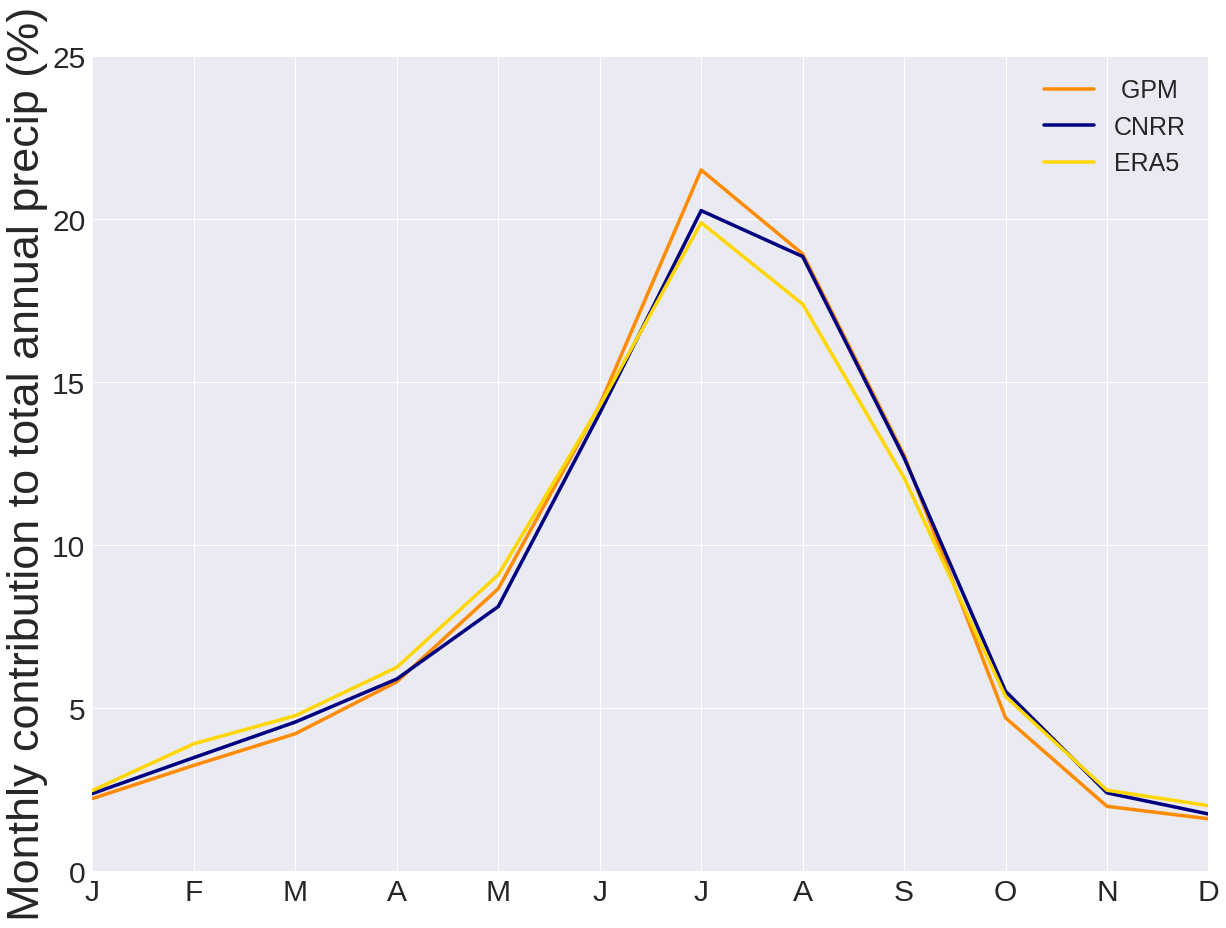

In [50]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 30,
             'xtick.labelsize' : 30,
             'ytick.labelsize' : 30})
plt.figure(figsize=(20,15 ))

plt.plot(total_precip_gpm/np.sum(total_precip_gpm)*100, label= ' GPM', linewidth= 3.5, color = 'darkorange')

plt.plot(total_precip_cnrr/np.sum(total_precip_cnrr)*100,   label= 'CNRR', linewidth= 3.5, color = 'navy')

plt.plot(total_precip/np.sum(total_precip)*100, label= 'ERA5', linewidth= 3.5, color = 'gold')

labels= ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(0,12,1), labels)


plt.xlim(0,11)
plt.ylim(0,25)
plt.legend(fontsize= 'small')
plt.ylabel('Monthly contribution to total annual precip (%)', fontsize= '45')


# save figure to image file 
plt.savefig('/media/juli/Data/third_pole/mcs_tracking/tobac_plots/precip_contributions_seasonal_gpmcnrrERA5.png')

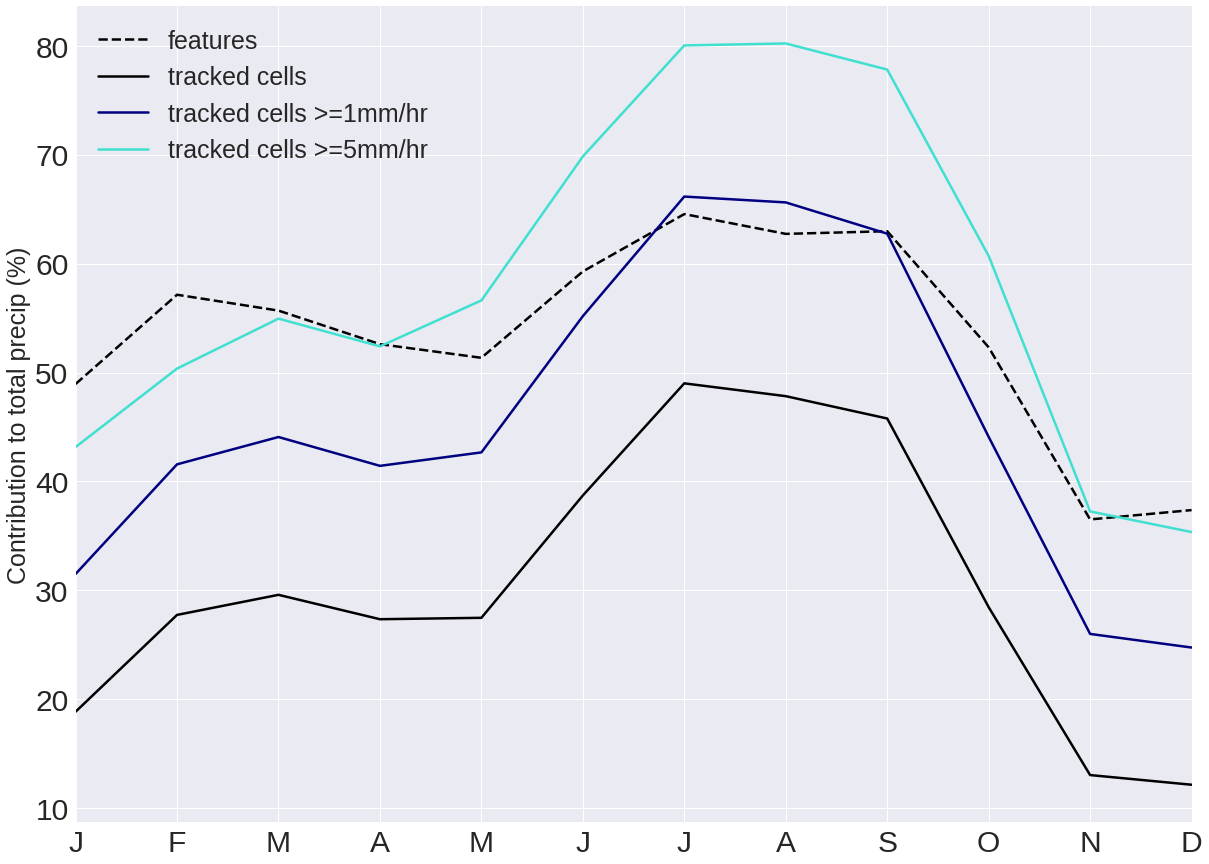

In [175]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 30,
             'xtick.labelsize' : 30,
             'ytick.labelsize' : 30})
plt.figure(figsize=(20,15 ))

plt.plot(features_precip/total_precip*100, label= 'features', linestyle= '--', linewidth= 2.5, color = 'black')
plt.plot(tracked_precip/total_precip*100, label= 'tracked cells', linewidth= 2.5, color = 'black')

#plt.plot(features_precip/precip_1mm*100, label= 'features >=1mm/hr')
plt.plot(tracked_precip/precip_1mm*100, label= 'tracked cells >=1mm/hr', linewidth= 2.5, color = 'navy')

#plt.plot(features_precip_5mm/precip_5mm*100, label= 'features >=5mm/hr')
plt.plot(tracked_precip_5mm/precip_5mm*100, label= 'tracked cells >=5mm/hr', linewidth= 2.5, color = 'turquoise')


labels= ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(0,12,1), labels)

plt.xlim(0,11)
plt.legend(fontsize= 'small')
plt.ylabel('Contribution to total precip (%)', fontsize= '25')

# save figure to image file 
plt.savefig('/media/juli/Data/third_pole/mcs_tracking/tobac_plots/precip_contributions_gpm.png')

## test whether system lies within 3000m boundary of TP 

In [380]:
import shapefile
import shapely
from shapely.geometry import Point
from shapely.geometry import shape
from shapely.geometry import MultiLineString
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon

In [409]:
lat = 30.0
lon = 75.0
pt= [lon,lat]

# Plot TP boundary polyline from shapefile 
path='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
shp=shapefile.Reader(path)
boundary= shp.shapes()
line = shape(boundary)
point= Point(pt)

if point.within(line):
    print(pt, 'is part of the TP! ')
else:
    print(pt, 'lies not within the TP')

# Track statistics 

In [1019]:
## create a new dataframe for tracked cells, which are possible mesoscale convective system candidates

# dataframe to store system stats 
mcs = pd.DataFrame(columns=['id', 'init_time', 'total_precip','mean_rr', 'max_rr' ,'lifetime', 'v' , 'mean_area', 'max_area','total_area', 'features>5mm', 'TP_flag'])

for idx, cell in Tracks.groupby('cell'):
    # compute statistics 
    cell_id = cell.cell.values[0]
    init_time = cell.time.values[0]
    total_precip = np.nansum(cell.total_precip.values)*0.5
    mean_rr = np.nanmean(cell.mean_rr.values)
    max_rr= np.nanmax(cell.max_rr.values)
    lifetime = np.shape(cell)[0]*0.5
    v= np.nanmean(cell.v.values)
    mean_area = np.nanmean(cell.area.values)
    max_area = np.nanmax(cell.area.values)
    total_area = np.nansum(cell.area.values) 
    features_5 = np.shape(cell.threshold_value.values[cell.threshold_value.values >= 5])[0]
    # add flag in order to mark whether the precip system lies within the 3000 boundary or not 
    if np.nansum(cell.flag.values) == 0:
        flag = 0 
    elif np.nansum(cell.flag.values) >= np.shape(cell)[0]*2 - 4:
        flag = 2 
    else:
        flag = 1 

    # add to dataframe 
    data = [int(cell_id), str(init_time), float(total_precip),float(mean_rr), float(max_rr), float(lifetime), float(v), float(mean_area), float(max_area), float(total_area), float(features_5), int(flag)]
    mcs.loc[len(mcs)]= data
    print('dataframe updated for cell', cell_id)


dataframe updated for cell 7.0
dataframe updated for cell 11.0
dataframe updated for cell 55.0
dataframe updated for cell 60.0
dataframe updated for cell 81.0
dataframe updated for cell 108.0
dataframe updated for cell 114.0
dataframe updated for cell 122.0
dataframe updated for cell 123.0
dataframe updated for cell 127.0
dataframe updated for cell 129.0
dataframe updated for cell 137.0
dataframe updated for cell 138.0
dataframe updated for cell 141.0
dataframe updated for cell 162.0
dataframe updated for cell 185.0
dataframe updated for cell 190.0
dataframe updated for cell 210.0
dataframe updated for cell 212.0
dataframe updated for cell 228.0
dataframe updated for cell 232.0
dataframe updated for cell 262.0
dataframe updated for cell 265.0
dataframe updated for cell 267.0
dataframe updated for cell 295.0
dataframe updated for cell 297.0
dataframe updated for cell 343.0
dataframe updated for cell 352.0
dataframe updated for cell 367.0
dataframe updated for cell 382.0
dataframe update

dataframe updated for cell 8384.0
dataframe updated for cell 8427.0
dataframe updated for cell 8429.0
dataframe updated for cell 8430.0
dataframe updated for cell 8440.0
dataframe updated for cell 8462.0
dataframe updated for cell 8497.0
dataframe updated for cell 8526.0
dataframe updated for cell 8545.0
dataframe updated for cell 8598.0
dataframe updated for cell 8677.0
dataframe updated for cell 8706.0
dataframe updated for cell 8713.0
dataframe updated for cell 8718.0
dataframe updated for cell 8723.0
dataframe updated for cell 8732.0
dataframe updated for cell 8751.0
dataframe updated for cell 8756.0
dataframe updated for cell 8773.0
dataframe updated for cell 8782.0
dataframe updated for cell 8840.0
dataframe updated for cell 8858.0
dataframe updated for cell 8882.0
dataframe updated for cell 8900.0
dataframe updated for cell 8915.0
dataframe updated for cell 8940.0
dataframe updated for cell 8956.0
dataframe updated for cell 8965.0
dataframe updated for cell 8974.0
dataframe upda

dataframe updated for cell 12387.0
dataframe updated for cell 12421.0
dataframe updated for cell 12429.0
dataframe updated for cell 12468.0
dataframe updated for cell 12472.0
dataframe updated for cell 12487.0
dataframe updated for cell 12545.0
dataframe updated for cell 12554.0
dataframe updated for cell 12634.0
dataframe updated for cell 12654.0
dataframe updated for cell 12685.0
dataframe updated for cell 12722.0
dataframe updated for cell 12731.0
dataframe updated for cell 12735.0
dataframe updated for cell 12741.0
dataframe updated for cell 12770.0
dataframe updated for cell 12793.0
dataframe updated for cell 12798.0
dataframe updated for cell 12803.0
dataframe updated for cell 12810.0
dataframe updated for cell 12828.0
dataframe updated for cell 12831.0
dataframe updated for cell 12864.0
dataframe updated for cell 12881.0
dataframe updated for cell 12901.0
dataframe updated for cell 12902.0
dataframe updated for cell 12903.0
dataframe updated for cell 12947.0
dataframe updated fo

dataframe updated for cell 16622.0
dataframe updated for cell 16623.0
dataframe updated for cell 16624.0
dataframe updated for cell 16649.0
dataframe updated for cell 16678.0
dataframe updated for cell 16680.0
dataframe updated for cell 16684.0
dataframe updated for cell 16709.0
dataframe updated for cell 16755.0
dataframe updated for cell 16812.0
dataframe updated for cell 16818.0
dataframe updated for cell 16835.0
dataframe updated for cell 16850.0
dataframe updated for cell 16861.0
dataframe updated for cell 16862.0
dataframe updated for cell 16865.0
dataframe updated for cell 16874.0
dataframe updated for cell 16890.0
dataframe updated for cell 16897.0
dataframe updated for cell 16930.0
dataframe updated for cell 16931.0
dataframe updated for cell 16940.0
dataframe updated for cell 16985.0
dataframe updated for cell 16999.0
dataframe updated for cell 17005.0
dataframe updated for cell 17024.0
dataframe updated for cell 17029.0
dataframe updated for cell 17036.0
dataframe updated fo

dataframe updated for cell 20030.0
dataframe updated for cell 20050.0
dataframe updated for cell 20054.0
dataframe updated for cell 20055.0
dataframe updated for cell 20058.0
dataframe updated for cell 20069.0
dataframe updated for cell 20076.0
dataframe updated for cell 20085.0
dataframe updated for cell 20094.0
dataframe updated for cell 20097.0
dataframe updated for cell 20112.0
dataframe updated for cell 20125.0
dataframe updated for cell 20126.0
dataframe updated for cell 20127.0
dataframe updated for cell 20131.0
dataframe updated for cell 20144.0
dataframe updated for cell 20178.0
dataframe updated for cell 20196.0
dataframe updated for cell 20208.0
dataframe updated for cell 20235.0
dataframe updated for cell 20252.0
dataframe updated for cell 20257.0
dataframe updated for cell 20259.0
dataframe updated for cell 20268.0
dataframe updated for cell 20270.0
dataframe updated for cell 20271.0
dataframe updated for cell 20276.0
dataframe updated for cell 20285.0
dataframe updated fo

dataframe updated for cell 22552.0
dataframe updated for cell 22555.0
dataframe updated for cell 22560.0
dataframe updated for cell 22581.0
dataframe updated for cell 22583.0
dataframe updated for cell 22595.0
dataframe updated for cell 22600.0
dataframe updated for cell 22620.0
dataframe updated for cell 22627.0
dataframe updated for cell 22630.0
dataframe updated for cell 22633.0
dataframe updated for cell 22640.0
dataframe updated for cell 22657.0
dataframe updated for cell 22659.0
dataframe updated for cell 22668.0
dataframe updated for cell 22672.0
dataframe updated for cell 22705.0
dataframe updated for cell 22721.0
dataframe updated for cell 22729.0
dataframe updated for cell 22770.0
dataframe updated for cell 22774.0
dataframe updated for cell 22796.0
dataframe updated for cell 22820.0
dataframe updated for cell 22821.0
dataframe updated for cell 22866.0
dataframe updated for cell 22876.0
dataframe updated for cell 22877.0
dataframe updated for cell 22880.0
dataframe updated fo

dataframe updated for cell 25140.0
dataframe updated for cell 25149.0
dataframe updated for cell 25154.0
dataframe updated for cell 25176.0
dataframe updated for cell 25181.0
dataframe updated for cell 25187.0
dataframe updated for cell 25188.0
dataframe updated for cell 25204.0
dataframe updated for cell 25214.0
dataframe updated for cell 25215.0
dataframe updated for cell 25220.0
dataframe updated for cell 25221.0
dataframe updated for cell 25233.0
dataframe updated for cell 25236.0
dataframe updated for cell 25237.0
dataframe updated for cell 25240.0
dataframe updated for cell 25242.0
dataframe updated for cell 25243.0
dataframe updated for cell 25246.0
dataframe updated for cell 25249.0
dataframe updated for cell 25263.0
dataframe updated for cell 25264.0
dataframe updated for cell 25272.0
dataframe updated for cell 25276.0
dataframe updated for cell 25280.0
dataframe updated for cell 25284.0
dataframe updated for cell 25285.0
dataframe updated for cell 25302.0
dataframe updated fo

dataframe updated for cell 27711.0
dataframe updated for cell 27732.0
dataframe updated for cell 27762.0
dataframe updated for cell 27766.0
dataframe updated for cell 27769.0
dataframe updated for cell 27777.0
dataframe updated for cell 27857.0
dataframe updated for cell 27885.0
dataframe updated for cell 27886.0
dataframe updated for cell 27961.0
dataframe updated for cell 27981.0
dataframe updated for cell 27996.0
dataframe updated for cell 27999.0
dataframe updated for cell 28012.0
dataframe updated for cell 28022.0
dataframe updated for cell 28030.0
dataframe updated for cell 28046.0
dataframe updated for cell 28073.0
dataframe updated for cell 28079.0
dataframe updated for cell 28085.0
dataframe updated for cell 28093.0
dataframe updated for cell 28101.0
dataframe updated for cell 28107.0
dataframe updated for cell 28125.0
dataframe updated for cell 28144.0
dataframe updated for cell 28148.0
dataframe updated for cell 28157.0
dataframe updated for cell 28170.0
dataframe updated fo

dataframe updated for cell 29908.0
dataframe updated for cell 29909.0
dataframe updated for cell 29911.0
dataframe updated for cell 29916.0
dataframe updated for cell 29931.0
dataframe updated for cell 29932.0
dataframe updated for cell 29934.0
dataframe updated for cell 29936.0
dataframe updated for cell 29937.0
dataframe updated for cell 29939.0
dataframe updated for cell 29942.0
dataframe updated for cell 29946.0
dataframe updated for cell 29952.0
dataframe updated for cell 29980.0
dataframe updated for cell 30003.0
dataframe updated for cell 30014.0
dataframe updated for cell 30017.0
dataframe updated for cell 30027.0
dataframe updated for cell 30030.0
dataframe updated for cell 30035.0
dataframe updated for cell 30037.0
dataframe updated for cell 30040.0
dataframe updated for cell 30047.0
dataframe updated for cell 30048.0
dataframe updated for cell 30049.0
dataframe updated for cell 30052.0
dataframe updated for cell 30055.0
dataframe updated for cell 30057.0
dataframe updated fo

dataframe updated for cell 31808.0
dataframe updated for cell 31825.0
dataframe updated for cell 31836.0
dataframe updated for cell 31841.0
dataframe updated for cell 31849.0
dataframe updated for cell 31855.0
dataframe updated for cell 31859.0
dataframe updated for cell 31895.0
dataframe updated for cell 31899.0
dataframe updated for cell 31922.0
dataframe updated for cell 31924.0
dataframe updated for cell 31932.0
dataframe updated for cell 31933.0
dataframe updated for cell 31936.0
dataframe updated for cell 31937.0
dataframe updated for cell 31945.0
dataframe updated for cell 31950.0
dataframe updated for cell 31951.0
dataframe updated for cell 31952.0
dataframe updated for cell 31955.0
dataframe updated for cell 31979.0
dataframe updated for cell 31980.0
dataframe updated for cell 31997.0
dataframe updated for cell 32005.0
dataframe updated for cell 32017.0
dataframe updated for cell 32020.0
dataframe updated for cell 32039.0
dataframe updated for cell 32041.0
dataframe updated fo

dataframe updated for cell 33644.0
dataframe updated for cell 33649.0
dataframe updated for cell 33652.0
dataframe updated for cell 33654.0
dataframe updated for cell 33668.0
dataframe updated for cell 33669.0
dataframe updated for cell 33671.0
dataframe updated for cell 33674.0
dataframe updated for cell 33675.0
dataframe updated for cell 33678.0
dataframe updated for cell 33685.0
dataframe updated for cell 33690.0
dataframe updated for cell 33691.0
dataframe updated for cell 33698.0
dataframe updated for cell 33699.0
dataframe updated for cell 33702.0
dataframe updated for cell 33704.0
dataframe updated for cell 33726.0
dataframe updated for cell 33750.0
dataframe updated for cell 33751.0
dataframe updated for cell 33756.0
dataframe updated for cell 33779.0
dataframe updated for cell 33781.0
dataframe updated for cell 33788.0
dataframe updated for cell 33793.0
dataframe updated for cell 33805.0
dataframe updated for cell 33819.0
dataframe updated for cell 33820.0
dataframe updated fo

dataframe updated for cell 35228.0
dataframe updated for cell 35231.0
dataframe updated for cell 35237.0
dataframe updated for cell 35244.0
dataframe updated for cell 35254.0
dataframe updated for cell 35255.0
dataframe updated for cell 35274.0
dataframe updated for cell 35276.0
dataframe updated for cell 35281.0
dataframe updated for cell 35282.0
dataframe updated for cell 35286.0
dataframe updated for cell 35289.0
dataframe updated for cell 35296.0
dataframe updated for cell 35306.0
dataframe updated for cell 35312.0
dataframe updated for cell 35320.0
dataframe updated for cell 35324.0
dataframe updated for cell 35328.0
dataframe updated for cell 35338.0
dataframe updated for cell 35342.0
dataframe updated for cell 35345.0
dataframe updated for cell 35353.0
dataframe updated for cell 35362.0
dataframe updated for cell 35364.0
dataframe updated for cell 35365.0
dataframe updated for cell 35371.0
dataframe updated for cell 35372.0
dataframe updated for cell 35374.0
dataframe updated fo

dataframe updated for cell 36829.0
dataframe updated for cell 36833.0
dataframe updated for cell 36849.0
dataframe updated for cell 36867.0
dataframe updated for cell 36871.0
dataframe updated for cell 36893.0
dataframe updated for cell 36899.0
dataframe updated for cell 36906.0
dataframe updated for cell 36907.0
dataframe updated for cell 36923.0
dataframe updated for cell 36929.0
dataframe updated for cell 36937.0
dataframe updated for cell 36947.0
dataframe updated for cell 36948.0
dataframe updated for cell 36954.0
dataframe updated for cell 36970.0
dataframe updated for cell 36974.0
dataframe updated for cell 36977.0
dataframe updated for cell 36984.0
dataframe updated for cell 36998.0
dataframe updated for cell 37016.0
dataframe updated for cell 37022.0
dataframe updated for cell 37030.0
dataframe updated for cell 37056.0
dataframe updated for cell 37066.0
dataframe updated for cell 37067.0
dataframe updated for cell 37079.0
dataframe updated for cell 37126.0
dataframe updated fo

dataframe updated for cell 38655.0
dataframe updated for cell 38659.0
dataframe updated for cell 38664.0
dataframe updated for cell 38670.0
dataframe updated for cell 38687.0
dataframe updated for cell 38712.0
dataframe updated for cell 38715.0
dataframe updated for cell 38729.0
dataframe updated for cell 38732.0
dataframe updated for cell 38737.0
dataframe updated for cell 38743.0
dataframe updated for cell 38767.0
dataframe updated for cell 38770.0
dataframe updated for cell 38771.0
dataframe updated for cell 38777.0
dataframe updated for cell 38786.0
dataframe updated for cell 38793.0
dataframe updated for cell 38799.0
dataframe updated for cell 38800.0
dataframe updated for cell 38810.0
dataframe updated for cell 38813.0
dataframe updated for cell 38815.0
dataframe updated for cell 38816.0
dataframe updated for cell 38825.0
dataframe updated for cell 38826.0
dataframe updated for cell 38827.0
dataframe updated for cell 38829.0
dataframe updated for cell 38851.0
dataframe updated fo

dataframe updated for cell 40500.0
dataframe updated for cell 40504.0
dataframe updated for cell 40522.0
dataframe updated for cell 40523.0
dataframe updated for cell 40528.0
dataframe updated for cell 40530.0
dataframe updated for cell 40535.0
dataframe updated for cell 40548.0
dataframe updated for cell 40552.0
dataframe updated for cell 40553.0
dataframe updated for cell 40555.0
dataframe updated for cell 40562.0
dataframe updated for cell 40571.0
dataframe updated for cell 40572.0
dataframe updated for cell 40575.0
dataframe updated for cell 40578.0
dataframe updated for cell 40579.0
dataframe updated for cell 40580.0
dataframe updated for cell 40590.0
dataframe updated for cell 40597.0
dataframe updated for cell 40606.0
dataframe updated for cell 40607.0
dataframe updated for cell 40612.0
dataframe updated for cell 40613.0
dataframe updated for cell 40618.0
dataframe updated for cell 40622.0
dataframe updated for cell 40633.0
dataframe updated for cell 40649.0
dataframe updated fo

dataframe updated for cell 41882.0
dataframe updated for cell 41888.0
dataframe updated for cell 41898.0
dataframe updated for cell 41904.0
dataframe updated for cell 41912.0
dataframe updated for cell 41925.0
dataframe updated for cell 41933.0
dataframe updated for cell 41934.0
dataframe updated for cell 41936.0
dataframe updated for cell 41951.0
dataframe updated for cell 41952.0
dataframe updated for cell 41971.0
dataframe updated for cell 41972.0
dataframe updated for cell 41975.0
dataframe updated for cell 41978.0
dataframe updated for cell 41979.0
dataframe updated for cell 41985.0
dataframe updated for cell 41991.0
dataframe updated for cell 42000.0
dataframe updated for cell 42001.0
dataframe updated for cell 42005.0
dataframe updated for cell 42006.0
dataframe updated for cell 42014.0
dataframe updated for cell 42015.0
dataframe updated for cell 42036.0
dataframe updated for cell 42038.0
dataframe updated for cell 42040.0
dataframe updated for cell 42042.0
dataframe updated fo

dataframe updated for cell 43467.0
dataframe updated for cell 43473.0
dataframe updated for cell 43478.0
dataframe updated for cell 43480.0
dataframe updated for cell 43487.0
dataframe updated for cell 43490.0
dataframe updated for cell 43498.0
dataframe updated for cell 43525.0
dataframe updated for cell 43531.0
dataframe updated for cell 43540.0
dataframe updated for cell 43550.0
dataframe updated for cell 43565.0
dataframe updated for cell 43600.0
dataframe updated for cell 43606.0
dataframe updated for cell 43627.0
dataframe updated for cell 43628.0
dataframe updated for cell 43632.0
dataframe updated for cell 43659.0
dataframe updated for cell 43679.0
dataframe updated for cell 43693.0
dataframe updated for cell 43694.0
dataframe updated for cell 43708.0
dataframe updated for cell 43710.0
dataframe updated for cell 43713.0
dataframe updated for cell 43727.0
dataframe updated for cell 43740.0
dataframe updated for cell 43741.0
dataframe updated for cell 43742.0
dataframe updated fo

dataframe updated for cell 44988.0
dataframe updated for cell 44995.0
dataframe updated for cell 45005.0
dataframe updated for cell 45006.0
dataframe updated for cell 45011.0
dataframe updated for cell 45016.0
dataframe updated for cell 45020.0
dataframe updated for cell 45025.0
dataframe updated for cell 45034.0
dataframe updated for cell 45037.0
dataframe updated for cell 45044.0
dataframe updated for cell 45053.0
dataframe updated for cell 45054.0
dataframe updated for cell 45056.0
dataframe updated for cell 45058.0
dataframe updated for cell 45062.0
dataframe updated for cell 45066.0
dataframe updated for cell 45068.0
dataframe updated for cell 45084.0
dataframe updated for cell 45087.0
dataframe updated for cell 45100.0
dataframe updated for cell 45101.0
dataframe updated for cell 45114.0
dataframe updated for cell 45116.0
dataframe updated for cell 45140.0
dataframe updated for cell 45148.0
dataframe updated for cell 45158.0
dataframe updated for cell 45181.0
dataframe updated fo

dataframe updated for cell 46641.0
dataframe updated for cell 46643.0
dataframe updated for cell 46645.0
dataframe updated for cell 46646.0
dataframe updated for cell 46656.0
dataframe updated for cell 46657.0
dataframe updated for cell 46662.0
dataframe updated for cell 46682.0
dataframe updated for cell 46687.0
dataframe updated for cell 46695.0
dataframe updated for cell 46696.0
dataframe updated for cell 46701.0
dataframe updated for cell 46719.0
dataframe updated for cell 46723.0
dataframe updated for cell 46728.0
dataframe updated for cell 46729.0
dataframe updated for cell 46733.0
dataframe updated for cell 46738.0
dataframe updated for cell 46741.0
dataframe updated for cell 46743.0
dataframe updated for cell 46749.0
dataframe updated for cell 46762.0
dataframe updated for cell 46767.0
dataframe updated for cell 46773.0
dataframe updated for cell 46777.0
dataframe updated for cell 46789.0
dataframe updated for cell 46791.0
dataframe updated for cell 46798.0
dataframe updated fo

dataframe updated for cell 48334.0
dataframe updated for cell 48337.0
dataframe updated for cell 48339.0
dataframe updated for cell 48343.0
dataframe updated for cell 48345.0
dataframe updated for cell 48358.0
dataframe updated for cell 48362.0
dataframe updated for cell 48366.0
dataframe updated for cell 48372.0
dataframe updated for cell 48374.0
dataframe updated for cell 48376.0
dataframe updated for cell 48379.0
dataframe updated for cell 48388.0
dataframe updated for cell 48391.0
dataframe updated for cell 48405.0
dataframe updated for cell 48422.0
dataframe updated for cell 48423.0
dataframe updated for cell 48424.0
dataframe updated for cell 48431.0
dataframe updated for cell 48432.0
dataframe updated for cell 48447.0
dataframe updated for cell 48449.0
dataframe updated for cell 48457.0
dataframe updated for cell 48463.0
dataframe updated for cell 48470.0
dataframe updated for cell 48476.0
dataframe updated for cell 48487.0
dataframe updated for cell 48488.0
dataframe updated fo

dataframe updated for cell 49725.0
dataframe updated for cell 49733.0
dataframe updated for cell 49739.0
dataframe updated for cell 49742.0
dataframe updated for cell 49743.0
dataframe updated for cell 49759.0
dataframe updated for cell 49761.0
dataframe updated for cell 49766.0
dataframe updated for cell 49768.0
dataframe updated for cell 49770.0
dataframe updated for cell 49780.0
dataframe updated for cell 49781.0
dataframe updated for cell 49784.0
dataframe updated for cell 49786.0
dataframe updated for cell 49814.0
dataframe updated for cell 49815.0
dataframe updated for cell 49817.0
dataframe updated for cell 49822.0
dataframe updated for cell 49829.0
dataframe updated for cell 49834.0
dataframe updated for cell 49840.0
dataframe updated for cell 49852.0
dataframe updated for cell 49859.0
dataframe updated for cell 49860.0
dataframe updated for cell 49863.0
dataframe updated for cell 49873.0
dataframe updated for cell 49886.0
dataframe updated for cell 49899.0
dataframe updated fo

dataframe updated for cell 51114.0
dataframe updated for cell 51131.0
dataframe updated for cell 51132.0
dataframe updated for cell 51145.0
dataframe updated for cell 51153.0
dataframe updated for cell 51155.0
dataframe updated for cell 51159.0
dataframe updated for cell 51160.0
dataframe updated for cell 51163.0
dataframe updated for cell 51168.0
dataframe updated for cell 51170.0
dataframe updated for cell 51172.0
dataframe updated for cell 51175.0
dataframe updated for cell 51182.0
dataframe updated for cell 51189.0
dataframe updated for cell 51190.0
dataframe updated for cell 51194.0
dataframe updated for cell 51196.0
dataframe updated for cell 51205.0
dataframe updated for cell 51209.0
dataframe updated for cell 51211.0
dataframe updated for cell 51213.0
dataframe updated for cell 51216.0
dataframe updated for cell 51220.0
dataframe updated for cell 51230.0
dataframe updated for cell 51238.0
dataframe updated for cell 51243.0
dataframe updated for cell 51251.0
dataframe updated fo

dataframe updated for cell 52541.0
dataframe updated for cell 52551.0
dataframe updated for cell 52552.0
dataframe updated for cell 52554.0
dataframe updated for cell 52555.0
dataframe updated for cell 52565.0
dataframe updated for cell 52572.0
dataframe updated for cell 52573.0
dataframe updated for cell 52590.0
dataframe updated for cell 52600.0
dataframe updated for cell 52603.0
dataframe updated for cell 52629.0
dataframe updated for cell 52632.0
dataframe updated for cell 52645.0
dataframe updated for cell 52658.0
dataframe updated for cell 52666.0
dataframe updated for cell 52703.0
dataframe updated for cell 52733.0
dataframe updated for cell 52741.0
dataframe updated for cell 52746.0
dataframe updated for cell 52755.0
dataframe updated for cell 52758.0
dataframe updated for cell 52766.0
dataframe updated for cell 52769.0
dataframe updated for cell 52772.0
dataframe updated for cell 52773.0
dataframe updated for cell 52775.0
dataframe updated for cell 52781.0
dataframe updated fo

dataframe updated for cell 54337.0
dataframe updated for cell 54340.0
dataframe updated for cell 54343.0
dataframe updated for cell 54359.0
dataframe updated for cell 54360.0
dataframe updated for cell 54362.0
dataframe updated for cell 54363.0
dataframe updated for cell 54383.0
dataframe updated for cell 54399.0
dataframe updated for cell 54402.0
dataframe updated for cell 54412.0
dataframe updated for cell 54422.0
dataframe updated for cell 54424.0
dataframe updated for cell 54430.0
dataframe updated for cell 54477.0
dataframe updated for cell 54496.0
dataframe updated for cell 54497.0
dataframe updated for cell 54503.0
dataframe updated for cell 54506.0
dataframe updated for cell 54507.0
dataframe updated for cell 54509.0
dataframe updated for cell 54513.0
dataframe updated for cell 54516.0
dataframe updated for cell 54517.0
dataframe updated for cell 54536.0
dataframe updated for cell 54554.0
dataframe updated for cell 54562.0
dataframe updated for cell 54567.0
dataframe updated fo

dataframe updated for cell 55992.0
dataframe updated for cell 55995.0
dataframe updated for cell 56001.0
dataframe updated for cell 56004.0
dataframe updated for cell 56024.0
dataframe updated for cell 56026.0
dataframe updated for cell 56032.0
dataframe updated for cell 56033.0
dataframe updated for cell 56038.0
dataframe updated for cell 56039.0
dataframe updated for cell 56040.0
dataframe updated for cell 56073.0
dataframe updated for cell 56075.0
dataframe updated for cell 56078.0
dataframe updated for cell 56079.0
dataframe updated for cell 56080.0
dataframe updated for cell 56127.0
dataframe updated for cell 56133.0
dataframe updated for cell 56135.0
dataframe updated for cell 56167.0
dataframe updated for cell 56170.0
dataframe updated for cell 56177.0
dataframe updated for cell 56182.0
dataframe updated for cell 56193.0
dataframe updated for cell 56194.0
dataframe updated for cell 56195.0
dataframe updated for cell 56201.0
dataframe updated for cell 56218.0
dataframe updated fo

dataframe updated for cell 57733.0
dataframe updated for cell 57745.0
dataframe updated for cell 57749.0
dataframe updated for cell 57752.0
dataframe updated for cell 57756.0
dataframe updated for cell 57760.0
dataframe updated for cell 57763.0
dataframe updated for cell 57769.0
dataframe updated for cell 57777.0
dataframe updated for cell 57781.0
dataframe updated for cell 57783.0
dataframe updated for cell 57788.0
dataframe updated for cell 57798.0
dataframe updated for cell 57817.0
dataframe updated for cell 57825.0
dataframe updated for cell 57831.0
dataframe updated for cell 57832.0
dataframe updated for cell 57833.0
dataframe updated for cell 57834.0
dataframe updated for cell 57839.0
dataframe updated for cell 57849.0
dataframe updated for cell 57861.0
dataframe updated for cell 57863.0
dataframe updated for cell 57877.0
dataframe updated for cell 57879.0
dataframe updated for cell 57887.0
dataframe updated for cell 57888.0
dataframe updated for cell 57911.0
dataframe updated fo

dataframe updated for cell 60365.0
dataframe updated for cell 60368.0
dataframe updated for cell 60449.0
dataframe updated for cell 60549.0
dataframe updated for cell 60553.0
dataframe updated for cell 60573.0
dataframe updated for cell 60598.0
dataframe updated for cell 60602.0
dataframe updated for cell 60645.0
dataframe updated for cell 60703.0
dataframe updated for cell 60730.0
dataframe updated for cell 60734.0
dataframe updated for cell 60786.0
dataframe updated for cell 60796.0
dataframe updated for cell 60801.0
dataframe updated for cell 60806.0
dataframe updated for cell 60838.0
dataframe updated for cell 60866.0
dataframe updated for cell 60882.0
dataframe updated for cell 60903.0
dataframe updated for cell 60914.0
dataframe updated for cell 60938.0
dataframe updated for cell 60946.0
dataframe updated for cell 60953.0
dataframe updated for cell 60960.0
dataframe updated for cell 60963.0
dataframe updated for cell 60965.0
dataframe updated for cell 60982.0
dataframe updated fo

dataframe updated for cell 64763.0
dataframe updated for cell 64783.0
dataframe updated for cell 64784.0
dataframe updated for cell 64793.0
dataframe updated for cell 64798.0
dataframe updated for cell 64829.0
dataframe updated for cell 64831.0
dataframe updated for cell 64836.0
dataframe updated for cell 64893.0
dataframe updated for cell 64900.0
dataframe updated for cell 64937.0
dataframe updated for cell 64961.0
dataframe updated for cell 64981.0
dataframe updated for cell 64990.0
dataframe updated for cell 65003.0
dataframe updated for cell 65029.0
dataframe updated for cell 65046.0
dataframe updated for cell 65058.0
dataframe updated for cell 65061.0
dataframe updated for cell 65071.0
dataframe updated for cell 65074.0
dataframe updated for cell 65085.0
dataframe updated for cell 65203.0
dataframe updated for cell 65267.0
dataframe updated for cell 65273.0
dataframe updated for cell 65302.0
dataframe updated for cell 65308.0
dataframe updated for cell 65309.0
dataframe updated fo

dataframe updated for cell 71383.0
dataframe updated for cell 71399.0
dataframe updated for cell 71406.0
dataframe updated for cell 71421.0
dataframe updated for cell 71431.0
dataframe updated for cell 71434.0
dataframe updated for cell 71455.0
dataframe updated for cell 71456.0
dataframe updated for cell 71489.0
dataframe updated for cell 71493.0
dataframe updated for cell 71497.0
dataframe updated for cell 71498.0
dataframe updated for cell 71500.0
dataframe updated for cell 71516.0
dataframe updated for cell 71522.0
dataframe updated for cell 71524.0
dataframe updated for cell 71528.0
dataframe updated for cell 71557.0
dataframe updated for cell 71588.0
dataframe updated for cell 71634.0
dataframe updated for cell 71661.0
dataframe updated for cell 71668.0
dataframe updated for cell 71683.0
dataframe updated for cell 71701.0
dataframe updated for cell 71704.0
dataframe updated for cell 71711.0
dataframe updated for cell 71767.0
dataframe updated for cell 71768.0
dataframe updated fo

dataframe updated for cell 74367.0
dataframe updated for cell 74378.0
dataframe updated for cell 74392.0
dataframe updated for cell 74402.0
dataframe updated for cell 74422.0
dataframe updated for cell 74423.0
dataframe updated for cell 74450.0
dataframe updated for cell 74496.0
dataframe updated for cell 74545.0
dataframe updated for cell 74577.0
dataframe updated for cell 74590.0
dataframe updated for cell 74635.0
dataframe updated for cell 74640.0
dataframe updated for cell 74645.0
dataframe updated for cell 74659.0
dataframe updated for cell 74673.0
dataframe updated for cell 74676.0
dataframe updated for cell 74680.0
dataframe updated for cell 74691.0
dataframe updated for cell 74701.0
dataframe updated for cell 74702.0
dataframe updated for cell 74707.0
dataframe updated for cell 74713.0
dataframe updated for cell 74737.0
dataframe updated for cell 74749.0
dataframe updated for cell 74750.0
dataframe updated for cell 74777.0
dataframe updated for cell 74787.0
dataframe updated fo

dataframe updated for cell 78910.0
dataframe updated for cell 78958.0
dataframe updated for cell 78974.0
dataframe updated for cell 78977.0
dataframe updated for cell 79025.0
dataframe updated for cell 79028.0
dataframe updated for cell 79033.0
dataframe updated for cell 79038.0
dataframe updated for cell 79039.0
dataframe updated for cell 79055.0
dataframe updated for cell 79061.0
dataframe updated for cell 79078.0
dataframe updated for cell 79092.0
dataframe updated for cell 79121.0
dataframe updated for cell 79132.0
dataframe updated for cell 79144.0
dataframe updated for cell 79174.0
dataframe updated for cell 79182.0
dataframe updated for cell 79214.0
dataframe updated for cell 79329.0
dataframe updated for cell 79385.0
dataframe updated for cell 79431.0
dataframe updated for cell 79438.0
dataframe updated for cell 79517.0
dataframe updated for cell 79522.0
dataframe updated for cell 79534.0
dataframe updated for cell 79541.0
dataframe updated for cell 79551.0
dataframe updated fo

dataframe updated for cell 82579.0
dataframe updated for cell 82585.0
dataframe updated for cell 82617.0
dataframe updated for cell 82651.0
dataframe updated for cell 82669.0
dataframe updated for cell 82671.0
dataframe updated for cell 82682.0
dataframe updated for cell 82684.0
dataframe updated for cell 82708.0
dataframe updated for cell 82711.0
dataframe updated for cell 82729.0
dataframe updated for cell 82734.0
dataframe updated for cell 82766.0
dataframe updated for cell 82783.0
dataframe updated for cell 82808.0
dataframe updated for cell 82830.0
dataframe updated for cell 82831.0
dataframe updated for cell 82834.0
dataframe updated for cell 82836.0
dataframe updated for cell 82838.0
dataframe updated for cell 82840.0
dataframe updated for cell 82841.0
dataframe updated for cell 82844.0
dataframe updated for cell 82845.0
dataframe updated for cell 82852.0
dataframe updated for cell 82853.0
dataframe updated for cell 82855.0
dataframe updated for cell 82859.0
dataframe updated fo

dataframe updated for cell 86227.0
dataframe updated for cell 86243.0
dataframe updated for cell 86268.0
dataframe updated for cell 86269.0
dataframe updated for cell 86301.0
dataframe updated for cell 86315.0
dataframe updated for cell 86369.0
dataframe updated for cell 86376.0
dataframe updated for cell 86396.0
dataframe updated for cell 86397.0
dataframe updated for cell 86398.0
dataframe updated for cell 86402.0
dataframe updated for cell 86425.0
dataframe updated for cell 86485.0
dataframe updated for cell 86495.0
dataframe updated for cell 86502.0
dataframe updated for cell 86516.0
dataframe updated for cell 86536.0
dataframe updated for cell 86539.0
dataframe updated for cell 86579.0
dataframe updated for cell 86633.0
dataframe updated for cell 86635.0
dataframe updated for cell 86670.0
dataframe updated for cell 86732.0
dataframe updated for cell 86769.0
dataframe updated for cell 86800.0
dataframe updated for cell 86828.0
dataframe updated for cell 86845.0
dataframe updated fo

dataframe updated for cell 89705.0
dataframe updated for cell 89712.0
dataframe updated for cell 89725.0
dataframe updated for cell 89732.0
dataframe updated for cell 89743.0
dataframe updated for cell 89753.0
dataframe updated for cell 89756.0
dataframe updated for cell 89757.0
dataframe updated for cell 89786.0
dataframe updated for cell 89799.0
dataframe updated for cell 89844.0
dataframe updated for cell 89846.0
dataframe updated for cell 89861.0
dataframe updated for cell 89864.0
dataframe updated for cell 89873.0
dataframe updated for cell 89878.0
dataframe updated for cell 89881.0
dataframe updated for cell 89898.0
dataframe updated for cell 89920.0
dataframe updated for cell 89921.0
dataframe updated for cell 89949.0
dataframe updated for cell 89950.0
dataframe updated for cell 89952.0
dataframe updated for cell 89972.0
dataframe updated for cell 89992.0
dataframe updated for cell 89994.0
dataframe updated for cell 90021.0
dataframe updated for cell 90028.0
dataframe updated fo

dataframe updated for cell 92667.0
dataframe updated for cell 92685.0
dataframe updated for cell 92688.0
dataframe updated for cell 92693.0
dataframe updated for cell 92704.0
dataframe updated for cell 92710.0
dataframe updated for cell 92724.0
dataframe updated for cell 92735.0
dataframe updated for cell 92740.0
dataframe updated for cell 92741.0
dataframe updated for cell 92745.0
dataframe updated for cell 92757.0
dataframe updated for cell 92764.0
dataframe updated for cell 92772.0
dataframe updated for cell 92776.0
dataframe updated for cell 92798.0
dataframe updated for cell 92810.0
dataframe updated for cell 92814.0
dataframe updated for cell 92835.0
dataframe updated for cell 92892.0
dataframe updated for cell 92909.0
dataframe updated for cell 92915.0
dataframe updated for cell 92952.0
dataframe updated for cell 92969.0
dataframe updated for cell 93001.0
dataframe updated for cell 93039.0
dataframe updated for cell 93041.0
dataframe updated for cell 93047.0
dataframe updated fo

dataframe updated for cell 95630.0
dataframe updated for cell 95670.0
dataframe updated for cell 95680.0
dataframe updated for cell 95682.0
dataframe updated for cell 95695.0
dataframe updated for cell 95698.0
dataframe updated for cell 95743.0
dataframe updated for cell 95749.0
dataframe updated for cell 95750.0
dataframe updated for cell 95765.0
dataframe updated for cell 95770.0
dataframe updated for cell 95801.0
dataframe updated for cell 95822.0
dataframe updated for cell 95836.0
dataframe updated for cell 95862.0
dataframe updated for cell 95878.0
dataframe updated for cell 95949.0
dataframe updated for cell 95971.0
dataframe updated for cell 95994.0
dataframe updated for cell 96025.0
dataframe updated for cell 96042.0
dataframe updated for cell 96048.0
dataframe updated for cell 96055.0
dataframe updated for cell 96077.0
dataframe updated for cell 96083.0
dataframe updated for cell 96086.0
dataframe updated for cell 96097.0
dataframe updated for cell 96098.0
dataframe updated fo

dataframe updated for cell 98485.0
dataframe updated for cell 98492.0
dataframe updated for cell 98499.0
dataframe updated for cell 98502.0
dataframe updated for cell 98504.0
dataframe updated for cell 98516.0
dataframe updated for cell 98523.0
dataframe updated for cell 98533.0
dataframe updated for cell 98534.0
dataframe updated for cell 98545.0
dataframe updated for cell 98551.0
dataframe updated for cell 98552.0
dataframe updated for cell 98559.0
dataframe updated for cell 98560.0
dataframe updated for cell 98571.0
dataframe updated for cell 98577.0
dataframe updated for cell 98596.0
dataframe updated for cell 98613.0
dataframe updated for cell 98619.0
dataframe updated for cell 98644.0
dataframe updated for cell 98645.0
dataframe updated for cell 98647.0
dataframe updated for cell 98657.0
dataframe updated for cell 98664.0
dataframe updated for cell 98666.0
dataframe updated for cell 98683.0
dataframe updated for cell 98684.0
dataframe updated for cell 98694.0
dataframe updated fo

dataframe updated for cell 100865.0
dataframe updated for cell 100867.0
dataframe updated for cell 100883.0
dataframe updated for cell 100884.0
dataframe updated for cell 100892.0
dataframe updated for cell 100897.0
dataframe updated for cell 100912.0
dataframe updated for cell 100914.0
dataframe updated for cell 100918.0
dataframe updated for cell 100919.0
dataframe updated for cell 100922.0
dataframe updated for cell 100939.0
dataframe updated for cell 100940.0
dataframe updated for cell 100962.0
dataframe updated for cell 100973.0
dataframe updated for cell 100991.0
dataframe updated for cell 100993.0
dataframe updated for cell 101017.0
dataframe updated for cell 101020.0
dataframe updated for cell 101037.0
dataframe updated for cell 101038.0
dataframe updated for cell 101039.0
dataframe updated for cell 101050.0
dataframe updated for cell 101051.0
dataframe updated for cell 101054.0
dataframe updated for cell 101055.0
dataframe updated for cell 101067.0
dataframe updated for cell 1

dataframe updated for cell 102788.0
dataframe updated for cell 102812.0
dataframe updated for cell 102815.0
dataframe updated for cell 102818.0
dataframe updated for cell 102819.0
dataframe updated for cell 102839.0
dataframe updated for cell 102847.0
dataframe updated for cell 102848.0
dataframe updated for cell 102874.0
dataframe updated for cell 102889.0
dataframe updated for cell 102892.0
dataframe updated for cell 102893.0
dataframe updated for cell 102895.0
dataframe updated for cell 102919.0
dataframe updated for cell 102923.0
dataframe updated for cell 102928.0
dataframe updated for cell 102931.0
dataframe updated for cell 102934.0
dataframe updated for cell 102956.0
dataframe updated for cell 102961.0
dataframe updated for cell 102973.0
dataframe updated for cell 102980.0
dataframe updated for cell 102989.0
dataframe updated for cell 102991.0
dataframe updated for cell 103001.0
dataframe updated for cell 103004.0
dataframe updated for cell 103042.0
dataframe updated for cell 1

dataframe updated for cell 104721.0
dataframe updated for cell 104728.0
dataframe updated for cell 104729.0
dataframe updated for cell 104733.0
dataframe updated for cell 104734.0
dataframe updated for cell 104739.0
dataframe updated for cell 104742.0
dataframe updated for cell 104749.0
dataframe updated for cell 104757.0
dataframe updated for cell 104760.0
dataframe updated for cell 104769.0
dataframe updated for cell 104771.0
dataframe updated for cell 104774.0
dataframe updated for cell 104778.0
dataframe updated for cell 104781.0
dataframe updated for cell 104784.0
dataframe updated for cell 104796.0
dataframe updated for cell 104824.0
dataframe updated for cell 104826.0
dataframe updated for cell 104854.0
dataframe updated for cell 104855.0
dataframe updated for cell 104856.0
dataframe updated for cell 104873.0
dataframe updated for cell 104881.0
dataframe updated for cell 104889.0
dataframe updated for cell 104894.0
dataframe updated for cell 104925.0
dataframe updated for cell 1

dataframe updated for cell 106713.0
dataframe updated for cell 106722.0
dataframe updated for cell 106727.0
dataframe updated for cell 106736.0
dataframe updated for cell 106738.0
dataframe updated for cell 106749.0
dataframe updated for cell 106754.0
dataframe updated for cell 106785.0
dataframe updated for cell 106787.0
dataframe updated for cell 106797.0
dataframe updated for cell 106799.0
dataframe updated for cell 106818.0
dataframe updated for cell 106834.0
dataframe updated for cell 106863.0
dataframe updated for cell 106864.0
dataframe updated for cell 106865.0
dataframe updated for cell 106874.0
dataframe updated for cell 106878.0
dataframe updated for cell 106881.0
dataframe updated for cell 106884.0
dataframe updated for cell 106885.0
dataframe updated for cell 106886.0
dataframe updated for cell 106892.0
dataframe updated for cell 106894.0
dataframe updated for cell 106898.0
dataframe updated for cell 106914.0
dataframe updated for cell 106916.0
dataframe updated for cell 1

dataframe updated for cell 108474.0
dataframe updated for cell 108488.0
dataframe updated for cell 108494.0
dataframe updated for cell 108507.0
dataframe updated for cell 108511.0
dataframe updated for cell 108513.0
dataframe updated for cell 108515.0
dataframe updated for cell 108518.0
dataframe updated for cell 108521.0
dataframe updated for cell 108522.0
dataframe updated for cell 108523.0
dataframe updated for cell 108526.0
dataframe updated for cell 108529.0
dataframe updated for cell 108532.0
dataframe updated for cell 108533.0
dataframe updated for cell 108536.0
dataframe updated for cell 108538.0
dataframe updated for cell 108556.0
dataframe updated for cell 108563.0
dataframe updated for cell 108567.0
dataframe updated for cell 108569.0
dataframe updated for cell 108576.0
dataframe updated for cell 108581.0
dataframe updated for cell 108587.0
dataframe updated for cell 108589.0
dataframe updated for cell 108595.0
dataframe updated for cell 108596.0
dataframe updated for cell 1

dataframe updated for cell 110159.0
dataframe updated for cell 110160.0
dataframe updated for cell 110164.0
dataframe updated for cell 110189.0
dataframe updated for cell 110195.0
dataframe updated for cell 110199.0
dataframe updated for cell 110203.0
dataframe updated for cell 110205.0
dataframe updated for cell 110207.0
dataframe updated for cell 110210.0
dataframe updated for cell 110214.0
dataframe updated for cell 110243.0
dataframe updated for cell 110252.0
dataframe updated for cell 110262.0
dataframe updated for cell 110266.0
dataframe updated for cell 110277.0
dataframe updated for cell 110289.0
dataframe updated for cell 110306.0
dataframe updated for cell 110310.0
dataframe updated for cell 110312.0
dataframe updated for cell 110316.0
dataframe updated for cell 110336.0
dataframe updated for cell 110337.0
dataframe updated for cell 110339.0
dataframe updated for cell 110340.0
dataframe updated for cell 110354.0
dataframe updated for cell 110368.0
dataframe updated for cell 1

dataframe updated for cell 112067.0
dataframe updated for cell 112069.0
dataframe updated for cell 112095.0
dataframe updated for cell 112099.0
dataframe updated for cell 112116.0
dataframe updated for cell 112121.0
dataframe updated for cell 112123.0
dataframe updated for cell 112148.0
dataframe updated for cell 112153.0
dataframe updated for cell 112165.0
dataframe updated for cell 112175.0
dataframe updated for cell 112177.0
dataframe updated for cell 112178.0
dataframe updated for cell 112196.0
dataframe updated for cell 112197.0
dataframe updated for cell 112199.0
dataframe updated for cell 112224.0
dataframe updated for cell 112226.0
dataframe updated for cell 112238.0
dataframe updated for cell 112253.0
dataframe updated for cell 112263.0
dataframe updated for cell 112275.0
dataframe updated for cell 112278.0
dataframe updated for cell 112285.0
dataframe updated for cell 112303.0
dataframe updated for cell 112307.0
dataframe updated for cell 112308.0
dataframe updated for cell 1

dataframe updated for cell 113902.0
dataframe updated for cell 113906.0
dataframe updated for cell 113930.0
dataframe updated for cell 113945.0
dataframe updated for cell 113951.0
dataframe updated for cell 113952.0
dataframe updated for cell 113970.0
dataframe updated for cell 113983.0
dataframe updated for cell 113987.0
dataframe updated for cell 113989.0
dataframe updated for cell 113990.0
dataframe updated for cell 113992.0
dataframe updated for cell 113999.0
dataframe updated for cell 114011.0
dataframe updated for cell 114019.0
dataframe updated for cell 114021.0
dataframe updated for cell 114022.0
dataframe updated for cell 114028.0
dataframe updated for cell 114032.0
dataframe updated for cell 114040.0
dataframe updated for cell 114045.0
dataframe updated for cell 114049.0
dataframe updated for cell 114050.0
dataframe updated for cell 114059.0
dataframe updated for cell 114061.0
dataframe updated for cell 114065.0
dataframe updated for cell 114069.0
dataframe updated for cell 1

dataframe updated for cell 116019.0
dataframe updated for cell 116036.0
dataframe updated for cell 116037.0
dataframe updated for cell 116060.0
dataframe updated for cell 116063.0
dataframe updated for cell 116071.0
dataframe updated for cell 116076.0
dataframe updated for cell 116096.0
dataframe updated for cell 116114.0
dataframe updated for cell 116115.0
dataframe updated for cell 116147.0
dataframe updated for cell 116148.0
dataframe updated for cell 116158.0
dataframe updated for cell 116161.0
dataframe updated for cell 116165.0
dataframe updated for cell 116176.0
dataframe updated for cell 116179.0
dataframe updated for cell 116183.0
dataframe updated for cell 116185.0
dataframe updated for cell 116200.0
dataframe updated for cell 116201.0
dataframe updated for cell 116205.0
dataframe updated for cell 116209.0
dataframe updated for cell 116210.0
dataframe updated for cell 116211.0
dataframe updated for cell 116221.0
dataframe updated for cell 116228.0
dataframe updated for cell 1

dataframe updated for cell 117910.0
dataframe updated for cell 117920.0
dataframe updated for cell 117923.0
dataframe updated for cell 117928.0
dataframe updated for cell 117942.0
dataframe updated for cell 117945.0
dataframe updated for cell 117947.0
dataframe updated for cell 117960.0
dataframe updated for cell 117964.0
dataframe updated for cell 117971.0
dataframe updated for cell 117989.0
dataframe updated for cell 118016.0
dataframe updated for cell 118018.0
dataframe updated for cell 118021.0
dataframe updated for cell 118025.0
dataframe updated for cell 118059.0
dataframe updated for cell 118061.0
dataframe updated for cell 118062.0
dataframe updated for cell 118066.0
dataframe updated for cell 118067.0
dataframe updated for cell 118068.0
dataframe updated for cell 118084.0
dataframe updated for cell 118085.0
dataframe updated for cell 118088.0
dataframe updated for cell 118096.0
dataframe updated for cell 118100.0
dataframe updated for cell 118102.0
dataframe updated for cell 1

dataframe updated for cell 119834.0
dataframe updated for cell 119835.0
dataframe updated for cell 119842.0
dataframe updated for cell 119850.0
dataframe updated for cell 119854.0
dataframe updated for cell 119855.0
dataframe updated for cell 119868.0
dataframe updated for cell 119876.0
dataframe updated for cell 119889.0
dataframe updated for cell 119891.0
dataframe updated for cell 119897.0
dataframe updated for cell 119901.0
dataframe updated for cell 119902.0
dataframe updated for cell 119904.0
dataframe updated for cell 119908.0
dataframe updated for cell 119912.0
dataframe updated for cell 119914.0
dataframe updated for cell 119922.0
dataframe updated for cell 119946.0
dataframe updated for cell 119947.0
dataframe updated for cell 119950.0
dataframe updated for cell 119957.0
dataframe updated for cell 119959.0
dataframe updated for cell 119960.0
dataframe updated for cell 119979.0
dataframe updated for cell 119981.0
dataframe updated for cell 119983.0
dataframe updated for cell 1

dataframe updated for cell 121569.0
dataframe updated for cell 121581.0
dataframe updated for cell 121588.0
dataframe updated for cell 121590.0
dataframe updated for cell 121598.0
dataframe updated for cell 121602.0
dataframe updated for cell 121607.0
dataframe updated for cell 121613.0
dataframe updated for cell 121615.0
dataframe updated for cell 121617.0
dataframe updated for cell 121622.0
dataframe updated for cell 121626.0
dataframe updated for cell 121632.0
dataframe updated for cell 121633.0
dataframe updated for cell 121648.0
dataframe updated for cell 121663.0
dataframe updated for cell 121672.0
dataframe updated for cell 121675.0
dataframe updated for cell 121686.0
dataframe updated for cell 121688.0
dataframe updated for cell 121705.0
dataframe updated for cell 121709.0
dataframe updated for cell 121720.0
dataframe updated for cell 121722.0
dataframe updated for cell 121724.0
dataframe updated for cell 121737.0
dataframe updated for cell 121738.0
dataframe updated for cell 1

dataframe updated for cell 123142.0
dataframe updated for cell 123147.0
dataframe updated for cell 123148.0
dataframe updated for cell 123161.0
dataframe updated for cell 123163.0
dataframe updated for cell 123167.0
dataframe updated for cell 123175.0
dataframe updated for cell 123181.0
dataframe updated for cell 123189.0
dataframe updated for cell 123192.0
dataframe updated for cell 123195.0
dataframe updated for cell 123197.0
dataframe updated for cell 123209.0
dataframe updated for cell 123210.0
dataframe updated for cell 123215.0
dataframe updated for cell 123217.0
dataframe updated for cell 123222.0
dataframe updated for cell 123227.0
dataframe updated for cell 123235.0
dataframe updated for cell 123243.0
dataframe updated for cell 123248.0
dataframe updated for cell 123255.0
dataframe updated for cell 123257.0
dataframe updated for cell 123263.0
dataframe updated for cell 123268.0
dataframe updated for cell 123273.0
dataframe updated for cell 123274.0
dataframe updated for cell 1

dataframe updated for cell 124634.0
dataframe updated for cell 124636.0
dataframe updated for cell 124638.0
dataframe updated for cell 124647.0
dataframe updated for cell 124650.0
dataframe updated for cell 124653.0
dataframe updated for cell 124654.0
dataframe updated for cell 124660.0
dataframe updated for cell 124661.0
dataframe updated for cell 124669.0
dataframe updated for cell 124670.0
dataframe updated for cell 124672.0
dataframe updated for cell 124691.0
dataframe updated for cell 124703.0
dataframe updated for cell 124704.0
dataframe updated for cell 124706.0
dataframe updated for cell 124707.0
dataframe updated for cell 124711.0
dataframe updated for cell 124714.0
dataframe updated for cell 124715.0
dataframe updated for cell 124732.0
dataframe updated for cell 124733.0
dataframe updated for cell 124739.0
dataframe updated for cell 124740.0
dataframe updated for cell 124741.0
dataframe updated for cell 124742.0
dataframe updated for cell 124743.0
dataframe updated for cell 1

dataframe updated for cell 126138.0
dataframe updated for cell 126141.0
dataframe updated for cell 126145.0
dataframe updated for cell 126149.0
dataframe updated for cell 126156.0
dataframe updated for cell 126160.0
dataframe updated for cell 126161.0
dataframe updated for cell 126163.0
dataframe updated for cell 126165.0
dataframe updated for cell 126174.0
dataframe updated for cell 126181.0
dataframe updated for cell 126183.0
dataframe updated for cell 126198.0
dataframe updated for cell 126200.0
dataframe updated for cell 126218.0
dataframe updated for cell 126220.0
dataframe updated for cell 126238.0
dataframe updated for cell 126240.0
dataframe updated for cell 126257.0
dataframe updated for cell 126258.0
dataframe updated for cell 126260.0
dataframe updated for cell 126262.0
dataframe updated for cell 126263.0
dataframe updated for cell 126265.0
dataframe updated for cell 126267.0
dataframe updated for cell 126268.0
dataframe updated for cell 126271.0
dataframe updated for cell 1

dataframe updated for cell 128098.0
dataframe updated for cell 128108.0
dataframe updated for cell 128109.0
dataframe updated for cell 128115.0
dataframe updated for cell 128119.0
dataframe updated for cell 128126.0
dataframe updated for cell 128137.0
dataframe updated for cell 128149.0
dataframe updated for cell 128152.0
dataframe updated for cell 128153.0
dataframe updated for cell 128161.0
dataframe updated for cell 128173.0
dataframe updated for cell 128176.0
dataframe updated for cell 128178.0
dataframe updated for cell 128189.0
dataframe updated for cell 128192.0
dataframe updated for cell 128208.0
dataframe updated for cell 128219.0
dataframe updated for cell 128238.0
dataframe updated for cell 128248.0
dataframe updated for cell 128253.0
dataframe updated for cell 128258.0
dataframe updated for cell 128261.0
dataframe updated for cell 128268.0
dataframe updated for cell 128275.0
dataframe updated for cell 128276.0
dataframe updated for cell 128286.0
dataframe updated for cell 1

dataframe updated for cell 129720.0
dataframe updated for cell 129724.0
dataframe updated for cell 129728.0
dataframe updated for cell 129731.0
dataframe updated for cell 129735.0
dataframe updated for cell 129736.0
dataframe updated for cell 129738.0
dataframe updated for cell 129748.0
dataframe updated for cell 129755.0
dataframe updated for cell 129756.0
dataframe updated for cell 129761.0
dataframe updated for cell 129774.0
dataframe updated for cell 129777.0
dataframe updated for cell 129779.0
dataframe updated for cell 129781.0
dataframe updated for cell 129786.0
dataframe updated for cell 129797.0
dataframe updated for cell 129808.0
dataframe updated for cell 129811.0
dataframe updated for cell 129817.0
dataframe updated for cell 129822.0
dataframe updated for cell 129824.0
dataframe updated for cell 129825.0
dataframe updated for cell 129827.0
dataframe updated for cell 129832.0
dataframe updated for cell 129839.0
dataframe updated for cell 129842.0
dataframe updated for cell 1

dataframe updated for cell 131100.0
dataframe updated for cell 131114.0
dataframe updated for cell 131123.0
dataframe updated for cell 131126.0
dataframe updated for cell 131128.0
dataframe updated for cell 131135.0
dataframe updated for cell 131139.0
dataframe updated for cell 131141.0
dataframe updated for cell 131142.0
dataframe updated for cell 131197.0
dataframe updated for cell 131202.0
dataframe updated for cell 131219.0
dataframe updated for cell 131239.0
dataframe updated for cell 131242.0
dataframe updated for cell 131269.0
dataframe updated for cell 131274.0
dataframe updated for cell 131294.0
dataframe updated for cell 131298.0
dataframe updated for cell 131303.0
dataframe updated for cell 131322.0
dataframe updated for cell 131345.0
dataframe updated for cell 131353.0
dataframe updated for cell 131392.0
dataframe updated for cell 131402.0
dataframe updated for cell 131407.0
dataframe updated for cell 131408.0
dataframe updated for cell 131416.0
dataframe updated for cell 1

dataframe updated for cell 133513.0
dataframe updated for cell 133519.0
dataframe updated for cell 133525.0
dataframe updated for cell 133534.0
dataframe updated for cell 133539.0
dataframe updated for cell 133540.0
dataframe updated for cell 133547.0
dataframe updated for cell 133548.0
dataframe updated for cell 133550.0
dataframe updated for cell 133561.0
dataframe updated for cell 133571.0
dataframe updated for cell 133584.0
dataframe updated for cell 133596.0
dataframe updated for cell 133603.0
dataframe updated for cell 133608.0
dataframe updated for cell 133619.0
dataframe updated for cell 133621.0
dataframe updated for cell 133640.0
dataframe updated for cell 133644.0
dataframe updated for cell 133645.0
dataframe updated for cell 133663.0
dataframe updated for cell 133668.0
dataframe updated for cell 133669.0
dataframe updated for cell 133671.0
dataframe updated for cell 133672.0
dataframe updated for cell 133685.0
dataframe updated for cell 133700.0
dataframe updated for cell 1

dataframe updated for cell 137801.0
dataframe updated for cell 137927.0
dataframe updated for cell 138093.0
dataframe updated for cell 138170.0
dataframe updated for cell 138202.0
dataframe updated for cell 138206.0
dataframe updated for cell 138275.0
dataframe updated for cell 138347.0
dataframe updated for cell 138362.0
dataframe updated for cell 138461.0
dataframe updated for cell 138566.0
dataframe updated for cell 138580.0
dataframe updated for cell 138695.0
dataframe updated for cell 138827.0
dataframe updated for cell 138839.0
dataframe updated for cell 138840.0
dataframe updated for cell 138845.0
dataframe updated for cell 139017.0
dataframe updated for cell 139054.0
dataframe updated for cell 139109.0
dataframe updated for cell 139115.0
dataframe updated for cell 139122.0
dataframe updated for cell 139146.0
dataframe updated for cell 139147.0
dataframe updated for cell 139236.0
dataframe updated for cell 139239.0
dataframe updated for cell 139276.0
dataframe updated for cell 1

dataframe updated for cell 145071.0
dataframe updated for cell 145073.0
dataframe updated for cell 145106.0
dataframe updated for cell 145108.0
dataframe updated for cell 145127.0
dataframe updated for cell 145130.0
dataframe updated for cell 145138.0
dataframe updated for cell 145156.0
dataframe updated for cell 145269.0
dataframe updated for cell 145320.0
dataframe updated for cell 145375.0
dataframe updated for cell 145416.0
dataframe updated for cell 145462.0
dataframe updated for cell 145503.0
dataframe updated for cell 145525.0
dataframe updated for cell 145539.0
dataframe updated for cell 145563.0
dataframe updated for cell 145615.0
dataframe updated for cell 145617.0
dataframe updated for cell 145620.0
dataframe updated for cell 145623.0
dataframe updated for cell 145627.0
dataframe updated for cell 145628.0
dataframe updated for cell 145636.0
dataframe updated for cell 145684.0
dataframe updated for cell 145685.0
dataframe updated for cell 145686.0
dataframe updated for cell 1

dataframe updated for cell 148885.0
dataframe updated for cell 148894.0
dataframe updated for cell 148927.0
dataframe updated for cell 148980.0
dataframe updated for cell 149047.0
dataframe updated for cell 149187.0
dataframe updated for cell 149233.0
dataframe updated for cell 149240.0
dataframe updated for cell 149243.0
dataframe updated for cell 149248.0
dataframe updated for cell 149251.0
dataframe updated for cell 149282.0
dataframe updated for cell 149310.0
dataframe updated for cell 149324.0
dataframe updated for cell 149329.0
dataframe updated for cell 149331.0
dataframe updated for cell 149347.0
dataframe updated for cell 149370.0
dataframe updated for cell 149383.0
dataframe updated for cell 149429.0
dataframe updated for cell 149446.0
dataframe updated for cell 149457.0
dataframe updated for cell 149513.0
dataframe updated for cell 149522.0
dataframe updated for cell 149527.0
dataframe updated for cell 149548.0
dataframe updated for cell 149565.0
dataframe updated for cell 1

dataframe updated for cell 152459.0
dataframe updated for cell 152476.0
dataframe updated for cell 152495.0
dataframe updated for cell 152500.0
dataframe updated for cell 152505.0
dataframe updated for cell 152525.0
dataframe updated for cell 152526.0
dataframe updated for cell 152573.0
dataframe updated for cell 152592.0
dataframe updated for cell 152593.0
dataframe updated for cell 152599.0
dataframe updated for cell 152622.0
dataframe updated for cell 152675.0
dataframe updated for cell 152680.0
dataframe updated for cell 152689.0
dataframe updated for cell 152697.0
dataframe updated for cell 152722.0
dataframe updated for cell 152725.0
dataframe updated for cell 152749.0
dataframe updated for cell 152752.0
dataframe updated for cell 152758.0
dataframe updated for cell 152775.0
dataframe updated for cell 152800.0
dataframe updated for cell 152825.0
dataframe updated for cell 152852.0
dataframe updated for cell 152864.0
dataframe updated for cell 152865.0
dataframe updated for cell 1

dataframe updated for cell 155186.0
dataframe updated for cell 155187.0
dataframe updated for cell 155189.0
dataframe updated for cell 155193.0
dataframe updated for cell 155197.0
dataframe updated for cell 155214.0
dataframe updated for cell 155220.0
dataframe updated for cell 155256.0
dataframe updated for cell 155280.0
dataframe updated for cell 155281.0
dataframe updated for cell 155285.0
dataframe updated for cell 155328.0
dataframe updated for cell 155337.0
dataframe updated for cell 155343.0
dataframe updated for cell 155344.0
dataframe updated for cell 155346.0
dataframe updated for cell 155357.0
dataframe updated for cell 155379.0
dataframe updated for cell 155381.0
dataframe updated for cell 155385.0
dataframe updated for cell 155386.0
dataframe updated for cell 155390.0
dataframe updated for cell 155404.0
dataframe updated for cell 155413.0
dataframe updated for cell 155420.0
dataframe updated for cell 155430.0
dataframe updated for cell 155431.0
dataframe updated for cell 1

dataframe updated for cell 158055.0
dataframe updated for cell 158057.0
dataframe updated for cell 158064.0
dataframe updated for cell 158071.0
dataframe updated for cell 158098.0
dataframe updated for cell 158099.0
dataframe updated for cell 158104.0
dataframe updated for cell 158119.0
dataframe updated for cell 158123.0
dataframe updated for cell 158128.0
dataframe updated for cell 158133.0
dataframe updated for cell 158136.0
dataframe updated for cell 158142.0
dataframe updated for cell 158159.0
dataframe updated for cell 158163.0
dataframe updated for cell 158171.0
dataframe updated for cell 158175.0
dataframe updated for cell 158182.0
dataframe updated for cell 158194.0
dataframe updated for cell 158197.0
dataframe updated for cell 158216.0
dataframe updated for cell 158229.0
dataframe updated for cell 158243.0
dataframe updated for cell 158246.0
dataframe updated for cell 158257.0
dataframe updated for cell 158272.0
dataframe updated for cell 158273.0
dataframe updated for cell 1

dataframe updated for cell 160503.0
dataframe updated for cell 160511.0
dataframe updated for cell 160512.0
dataframe updated for cell 160531.0
dataframe updated for cell 160534.0
dataframe updated for cell 160536.0
dataframe updated for cell 160543.0
dataframe updated for cell 160547.0
dataframe updated for cell 160549.0
dataframe updated for cell 160550.0
dataframe updated for cell 160554.0
dataframe updated for cell 160591.0
dataframe updated for cell 160599.0
dataframe updated for cell 160605.0
dataframe updated for cell 160607.0
dataframe updated for cell 160608.0
dataframe updated for cell 160619.0
dataframe updated for cell 160630.0
dataframe updated for cell 160637.0
dataframe updated for cell 160638.0
dataframe updated for cell 160645.0
dataframe updated for cell 160651.0
dataframe updated for cell 160657.0
dataframe updated for cell 160658.0
dataframe updated for cell 160668.0
dataframe updated for cell 160670.0
dataframe updated for cell 160672.0
dataframe updated for cell 1

dataframe updated for cell 161884.0
dataframe updated for cell 161900.0
dataframe updated for cell 161907.0
dataframe updated for cell 161920.0
dataframe updated for cell 161924.0
dataframe updated for cell 161927.0
dataframe updated for cell 161939.0
dataframe updated for cell 161947.0
dataframe updated for cell 161948.0
dataframe updated for cell 161975.0
dataframe updated for cell 161986.0
dataframe updated for cell 161994.0
dataframe updated for cell 161999.0
dataframe updated for cell 162032.0
dataframe updated for cell 162038.0
dataframe updated for cell 162040.0
dataframe updated for cell 162042.0
dataframe updated for cell 162065.0
dataframe updated for cell 162066.0
dataframe updated for cell 162074.0
dataframe updated for cell 162083.0
dataframe updated for cell 162085.0
dataframe updated for cell 162088.0
dataframe updated for cell 162090.0
dataframe updated for cell 162139.0
dataframe updated for cell 162162.0
dataframe updated for cell 162179.0
dataframe updated for cell 1

dataframe updated for cell 163753.0
dataframe updated for cell 163754.0
dataframe updated for cell 163769.0
dataframe updated for cell 163776.0
dataframe updated for cell 163809.0
dataframe updated for cell 163816.0
dataframe updated for cell 163823.0
dataframe updated for cell 163825.0
dataframe updated for cell 163833.0
dataframe updated for cell 163851.0
dataframe updated for cell 163853.0
dataframe updated for cell 163854.0
dataframe updated for cell 163863.0
dataframe updated for cell 163871.0
dataframe updated for cell 163901.0
dataframe updated for cell 163910.0
dataframe updated for cell 163920.0
dataframe updated for cell 163922.0
dataframe updated for cell 163924.0
dataframe updated for cell 163927.0
dataframe updated for cell 163943.0
dataframe updated for cell 163952.0
dataframe updated for cell 163954.0
dataframe updated for cell 163955.0
dataframe updated for cell 163961.0
dataframe updated for cell 163965.0
dataframe updated for cell 163992.0
dataframe updated for cell 1

dataframe updated for cell 165753.0
dataframe updated for cell 165761.0
dataframe updated for cell 165768.0
dataframe updated for cell 165775.0
dataframe updated for cell 165776.0
dataframe updated for cell 165782.0
dataframe updated for cell 165783.0
dataframe updated for cell 165787.0
dataframe updated for cell 165790.0
dataframe updated for cell 165797.0
dataframe updated for cell 165803.0
dataframe updated for cell 165821.0
dataframe updated for cell 165830.0
dataframe updated for cell 165832.0
dataframe updated for cell 165845.0
dataframe updated for cell 165852.0
dataframe updated for cell 165862.0
dataframe updated for cell 165865.0
dataframe updated for cell 165866.0
dataframe updated for cell 165892.0
dataframe updated for cell 165893.0
dataframe updated for cell 165914.0
dataframe updated for cell 165922.0
dataframe updated for cell 165923.0
dataframe updated for cell 165941.0
dataframe updated for cell 165974.0
dataframe updated for cell 165975.0
dataframe updated for cell 1

dataframe updated for cell 167718.0
dataframe updated for cell 167719.0
dataframe updated for cell 167728.0
dataframe updated for cell 167737.0
dataframe updated for cell 167741.0
dataframe updated for cell 167751.0
dataframe updated for cell 167763.0
dataframe updated for cell 167769.0
dataframe updated for cell 167776.0
dataframe updated for cell 167781.0
dataframe updated for cell 167798.0
dataframe updated for cell 167837.0
dataframe updated for cell 167844.0
dataframe updated for cell 167848.0
dataframe updated for cell 167850.0
dataframe updated for cell 167875.0
dataframe updated for cell 167879.0
dataframe updated for cell 167901.0
dataframe updated for cell 167913.0
dataframe updated for cell 167940.0
dataframe updated for cell 167945.0
dataframe updated for cell 167952.0
dataframe updated for cell 167954.0
dataframe updated for cell 167967.0
dataframe updated for cell 167968.0
dataframe updated for cell 167977.0
dataframe updated for cell 167982.0
dataframe updated for cell 1

dataframe updated for cell 169975.0
dataframe updated for cell 169979.0
dataframe updated for cell 169980.0
dataframe updated for cell 169994.0
dataframe updated for cell 170006.0
dataframe updated for cell 170012.0
dataframe updated for cell 170019.0
dataframe updated for cell 170026.0
dataframe updated for cell 170031.0
dataframe updated for cell 170034.0
dataframe updated for cell 170053.0
dataframe updated for cell 170058.0
dataframe updated for cell 170063.0
dataframe updated for cell 170065.0
dataframe updated for cell 170067.0
dataframe updated for cell 170069.0
dataframe updated for cell 170070.0
dataframe updated for cell 170072.0
dataframe updated for cell 170091.0
dataframe updated for cell 170098.0
dataframe updated for cell 170102.0
dataframe updated for cell 170107.0
dataframe updated for cell 170118.0
dataframe updated for cell 170129.0
dataframe updated for cell 170142.0
dataframe updated for cell 170144.0
dataframe updated for cell 170149.0
dataframe updated for cell 1

dataframe updated for cell 172014.0
dataframe updated for cell 172019.0
dataframe updated for cell 172025.0
dataframe updated for cell 172027.0
dataframe updated for cell 172030.0
dataframe updated for cell 172034.0
dataframe updated for cell 172042.0
dataframe updated for cell 172053.0
dataframe updated for cell 172054.0
dataframe updated for cell 172057.0
dataframe updated for cell 172058.0
dataframe updated for cell 172064.0
dataframe updated for cell 172089.0
dataframe updated for cell 172094.0
dataframe updated for cell 172097.0
dataframe updated for cell 172101.0
dataframe updated for cell 172104.0
dataframe updated for cell 172108.0
dataframe updated for cell 172110.0
dataframe updated for cell 172120.0
dataframe updated for cell 172121.0
dataframe updated for cell 172131.0
dataframe updated for cell 172140.0
dataframe updated for cell 172143.0
dataframe updated for cell 172144.0
dataframe updated for cell 172151.0
dataframe updated for cell 172160.0
dataframe updated for cell 1

dataframe updated for cell 173609.0
dataframe updated for cell 173648.0
dataframe updated for cell 173650.0
dataframe updated for cell 173672.0
dataframe updated for cell 173685.0
dataframe updated for cell 173687.0
dataframe updated for cell 173688.0
dataframe updated for cell 173700.0
dataframe updated for cell 173701.0
dataframe updated for cell 173718.0
dataframe updated for cell 173724.0
dataframe updated for cell 173737.0
dataframe updated for cell 173751.0
dataframe updated for cell 173753.0
dataframe updated for cell 173766.0
dataframe updated for cell 173775.0
dataframe updated for cell 173776.0
dataframe updated for cell 173787.0
dataframe updated for cell 173789.0
dataframe updated for cell 173790.0
dataframe updated for cell 173809.0
dataframe updated for cell 173825.0
dataframe updated for cell 173826.0
dataframe updated for cell 173827.0
dataframe updated for cell 173838.0
dataframe updated for cell 173839.0
dataframe updated for cell 173841.0
dataframe updated for cell 1

dataframe updated for cell 175522.0
dataframe updated for cell 175530.0
dataframe updated for cell 175532.0
dataframe updated for cell 175533.0
dataframe updated for cell 175542.0
dataframe updated for cell 175544.0
dataframe updated for cell 175551.0
dataframe updated for cell 175584.0
dataframe updated for cell 175593.0
dataframe updated for cell 175600.0
dataframe updated for cell 175601.0
dataframe updated for cell 175619.0
dataframe updated for cell 175621.0
dataframe updated for cell 175631.0
dataframe updated for cell 175640.0
dataframe updated for cell 175644.0
dataframe updated for cell 175645.0
dataframe updated for cell 175652.0
dataframe updated for cell 175664.0
dataframe updated for cell 175673.0
dataframe updated for cell 175690.0
dataframe updated for cell 175694.0
dataframe updated for cell 175707.0
dataframe updated for cell 175726.0
dataframe updated for cell 175744.0
dataframe updated for cell 175746.0
dataframe updated for cell 175758.0
dataframe updated for cell 1

dataframe updated for cell 177005.0
dataframe updated for cell 177015.0
dataframe updated for cell 177021.0
dataframe updated for cell 177035.0
dataframe updated for cell 177043.0
dataframe updated for cell 177045.0
dataframe updated for cell 177051.0
dataframe updated for cell 177055.0
dataframe updated for cell 177056.0
dataframe updated for cell 177062.0
dataframe updated for cell 177071.0
dataframe updated for cell 177078.0
dataframe updated for cell 177083.0
dataframe updated for cell 177092.0
dataframe updated for cell 177093.0
dataframe updated for cell 177102.0
dataframe updated for cell 177108.0
dataframe updated for cell 177114.0
dataframe updated for cell 177126.0
dataframe updated for cell 177145.0
dataframe updated for cell 177165.0
dataframe updated for cell 177169.0
dataframe updated for cell 177199.0
dataframe updated for cell 177204.0
dataframe updated for cell 177229.0
dataframe updated for cell 177236.0
dataframe updated for cell 177240.0
dataframe updated for cell 1

dataframe updated for cell 178744.0
dataframe updated for cell 178755.0
dataframe updated for cell 178757.0
dataframe updated for cell 178766.0
dataframe updated for cell 178775.0
dataframe updated for cell 178781.0
dataframe updated for cell 178784.0
dataframe updated for cell 178797.0
dataframe updated for cell 178798.0
dataframe updated for cell 178830.0
dataframe updated for cell 178833.0
dataframe updated for cell 178836.0
dataframe updated for cell 178837.0
dataframe updated for cell 178844.0
dataframe updated for cell 178853.0
dataframe updated for cell 178855.0
dataframe updated for cell 178858.0
dataframe updated for cell 178863.0
dataframe updated for cell 178864.0
dataframe updated for cell 178865.0
dataframe updated for cell 178866.0
dataframe updated for cell 178881.0
dataframe updated for cell 178883.0
dataframe updated for cell 178884.0
dataframe updated for cell 178905.0
dataframe updated for cell 178909.0
dataframe updated for cell 178911.0
dataframe updated for cell 1

dataframe updated for cell 180314.0
dataframe updated for cell 180316.0
dataframe updated for cell 180325.0
dataframe updated for cell 180329.0
dataframe updated for cell 180333.0
dataframe updated for cell 180348.0
dataframe updated for cell 180350.0
dataframe updated for cell 180353.0
dataframe updated for cell 180354.0
dataframe updated for cell 180369.0
dataframe updated for cell 180393.0
dataframe updated for cell 180397.0
dataframe updated for cell 180405.0
dataframe updated for cell 180408.0
dataframe updated for cell 180409.0
dataframe updated for cell 180410.0
dataframe updated for cell 180411.0
dataframe updated for cell 180419.0
dataframe updated for cell 180423.0
dataframe updated for cell 180427.0
dataframe updated for cell 180474.0
dataframe updated for cell 180475.0
dataframe updated for cell 180476.0
dataframe updated for cell 180479.0
dataframe updated for cell 180484.0
dataframe updated for cell 180491.0
dataframe updated for cell 180504.0
dataframe updated for cell 1

dataframe updated for cell 181881.0
dataframe updated for cell 181889.0
dataframe updated for cell 181918.0
dataframe updated for cell 181930.0
dataframe updated for cell 181931.0
dataframe updated for cell 181941.0
dataframe updated for cell 181949.0
dataframe updated for cell 181960.0
dataframe updated for cell 181969.0
dataframe updated for cell 181982.0
dataframe updated for cell 181985.0
dataframe updated for cell 182009.0
dataframe updated for cell 182018.0
dataframe updated for cell 182036.0
dataframe updated for cell 182041.0
dataframe updated for cell 182046.0
dataframe updated for cell 182048.0
dataframe updated for cell 182049.0
dataframe updated for cell 182052.0
dataframe updated for cell 182083.0
dataframe updated for cell 182091.0
dataframe updated for cell 182101.0
dataframe updated for cell 182107.0
dataframe updated for cell 182112.0
dataframe updated for cell 182113.0
dataframe updated for cell 182117.0
dataframe updated for cell 182127.0
dataframe updated for cell 1

dataframe updated for cell 183689.0
dataframe updated for cell 183693.0
dataframe updated for cell 183694.0
dataframe updated for cell 183696.0
dataframe updated for cell 183701.0
dataframe updated for cell 183702.0
dataframe updated for cell 183710.0
dataframe updated for cell 183713.0
dataframe updated for cell 183715.0
dataframe updated for cell 183716.0
dataframe updated for cell 183731.0
dataframe updated for cell 183735.0
dataframe updated for cell 183747.0
dataframe updated for cell 183749.0
dataframe updated for cell 183757.0
dataframe updated for cell 183764.0
dataframe updated for cell 183768.0
dataframe updated for cell 183783.0
dataframe updated for cell 183790.0
dataframe updated for cell 183823.0
dataframe updated for cell 183832.0
dataframe updated for cell 183836.0
dataframe updated for cell 183837.0
dataframe updated for cell 183839.0
dataframe updated for cell 183844.0
dataframe updated for cell 183847.0
dataframe updated for cell 183850.0
dataframe updated for cell 1

dataframe updated for cell 185015.0
dataframe updated for cell 185019.0
dataframe updated for cell 185025.0
dataframe updated for cell 185026.0
dataframe updated for cell 185028.0
dataframe updated for cell 185029.0
dataframe updated for cell 185048.0
dataframe updated for cell 185053.0
dataframe updated for cell 185066.0
dataframe updated for cell 185068.0
dataframe updated for cell 185078.0
dataframe updated for cell 185080.0
dataframe updated for cell 185081.0
dataframe updated for cell 185083.0
dataframe updated for cell 185086.0
dataframe updated for cell 185087.0
dataframe updated for cell 185101.0
dataframe updated for cell 185103.0
dataframe updated for cell 185104.0
dataframe updated for cell 185105.0
dataframe updated for cell 185106.0
dataframe updated for cell 185111.0
dataframe updated for cell 185119.0
dataframe updated for cell 185120.0
dataframe updated for cell 185124.0
dataframe updated for cell 185129.0
dataframe updated for cell 185147.0
dataframe updated for cell 1

dataframe updated for cell 186521.0
dataframe updated for cell 186528.0
dataframe updated for cell 186539.0
dataframe updated for cell 186540.0
dataframe updated for cell 186541.0
dataframe updated for cell 186542.0
dataframe updated for cell 186543.0
dataframe updated for cell 186555.0
dataframe updated for cell 186559.0
dataframe updated for cell 186577.0
dataframe updated for cell 186579.0
dataframe updated for cell 186581.0
dataframe updated for cell 186582.0
dataframe updated for cell 186593.0
dataframe updated for cell 186601.0
dataframe updated for cell 186608.0
dataframe updated for cell 186617.0
dataframe updated for cell 186618.0
dataframe updated for cell 186621.0
dataframe updated for cell 186624.0
dataframe updated for cell 186632.0
dataframe updated for cell 186635.0
dataframe updated for cell 186636.0
dataframe updated for cell 186638.0
dataframe updated for cell 186644.0
dataframe updated for cell 186659.0
dataframe updated for cell 186664.0
dataframe updated for cell 1

dataframe updated for cell 187915.0
dataframe updated for cell 187917.0
dataframe updated for cell 187928.0
dataframe updated for cell 187930.0
dataframe updated for cell 187933.0
dataframe updated for cell 187942.0
dataframe updated for cell 187948.0
dataframe updated for cell 187969.0
dataframe updated for cell 187974.0
dataframe updated for cell 187988.0
dataframe updated for cell 187996.0
dataframe updated for cell 188002.0
dataframe updated for cell 188006.0
dataframe updated for cell 188010.0
dataframe updated for cell 188017.0
dataframe updated for cell 188029.0
dataframe updated for cell 188035.0
dataframe updated for cell 188049.0
dataframe updated for cell 188064.0
dataframe updated for cell 188069.0
dataframe updated for cell 188071.0
dataframe updated for cell 188075.0
dataframe updated for cell 188080.0
dataframe updated for cell 188100.0
dataframe updated for cell 188105.0
dataframe updated for cell 188108.0
dataframe updated for cell 188109.0
dataframe updated for cell 1

dataframe updated for cell 189539.0
dataframe updated for cell 189540.0
dataframe updated for cell 189541.0
dataframe updated for cell 189543.0
dataframe updated for cell 189546.0
dataframe updated for cell 189547.0
dataframe updated for cell 189548.0
dataframe updated for cell 189554.0
dataframe updated for cell 189563.0
dataframe updated for cell 189587.0
dataframe updated for cell 189588.0
dataframe updated for cell 189603.0
dataframe updated for cell 189605.0
dataframe updated for cell 189607.0
dataframe updated for cell 189608.0
dataframe updated for cell 189619.0
dataframe updated for cell 189622.0
dataframe updated for cell 189635.0
dataframe updated for cell 189650.0
dataframe updated for cell 189655.0
dataframe updated for cell 189657.0
dataframe updated for cell 189668.0
dataframe updated for cell 189670.0
dataframe updated for cell 189671.0
dataframe updated for cell 189674.0
dataframe updated for cell 189687.0
dataframe updated for cell 189691.0
dataframe updated for cell 1

dataframe updated for cell 191160.0
dataframe updated for cell 191167.0
dataframe updated for cell 191184.0
dataframe updated for cell 191188.0
dataframe updated for cell 191190.0
dataframe updated for cell 191195.0
dataframe updated for cell 191204.0
dataframe updated for cell 191209.0
dataframe updated for cell 191210.0
dataframe updated for cell 191219.0
dataframe updated for cell 191227.0
dataframe updated for cell 191230.0
dataframe updated for cell 191243.0
dataframe updated for cell 191262.0
dataframe updated for cell 191263.0
dataframe updated for cell 191266.0
dataframe updated for cell 191275.0
dataframe updated for cell 191279.0
dataframe updated for cell 191292.0
dataframe updated for cell 191296.0
dataframe updated for cell 191300.0
dataframe updated for cell 191306.0
dataframe updated for cell 191313.0
dataframe updated for cell 191325.0
dataframe updated for cell 191326.0
dataframe updated for cell 191341.0
dataframe updated for cell 191355.0
dataframe updated for cell 1

dataframe updated for cell 192896.0
dataframe updated for cell 192897.0
dataframe updated for cell 192923.0
dataframe updated for cell 192927.0
dataframe updated for cell 192937.0
dataframe updated for cell 192940.0
dataframe updated for cell 192948.0
dataframe updated for cell 192953.0
dataframe updated for cell 192961.0
dataframe updated for cell 192970.0
dataframe updated for cell 192979.0
dataframe updated for cell 192981.0
dataframe updated for cell 192985.0
dataframe updated for cell 192987.0
dataframe updated for cell 192988.0
dataframe updated for cell 192989.0
dataframe updated for cell 193002.0
dataframe updated for cell 193011.0
dataframe updated for cell 193022.0
dataframe updated for cell 193039.0
dataframe updated for cell 193050.0
dataframe updated for cell 193052.0
dataframe updated for cell 193055.0
dataframe updated for cell 193112.0
dataframe updated for cell 193145.0
dataframe updated for cell 193153.0
dataframe updated for cell 193165.0
dataframe updated for cell 1

dataframe updated for cell 194603.0
dataframe updated for cell 194613.0
dataframe updated for cell 194616.0
dataframe updated for cell 194619.0
dataframe updated for cell 194621.0
dataframe updated for cell 194624.0
dataframe updated for cell 194636.0
dataframe updated for cell 194642.0
dataframe updated for cell 194645.0
dataframe updated for cell 194646.0
dataframe updated for cell 194657.0
dataframe updated for cell 194658.0
dataframe updated for cell 194660.0
dataframe updated for cell 194661.0
dataframe updated for cell 194688.0
dataframe updated for cell 194698.0
dataframe updated for cell 194700.0
dataframe updated for cell 194716.0
dataframe updated for cell 194719.0
dataframe updated for cell 194730.0
dataframe updated for cell 194731.0
dataframe updated for cell 194734.0
dataframe updated for cell 194735.0
dataframe updated for cell 194742.0
dataframe updated for cell 194743.0
dataframe updated for cell 194751.0
dataframe updated for cell 194752.0
dataframe updated for cell 1

dataframe updated for cell 196666.0
dataframe updated for cell 196667.0
dataframe updated for cell 196695.0
dataframe updated for cell 196701.0
dataframe updated for cell 196719.0
dataframe updated for cell 196723.0
dataframe updated for cell 196730.0
dataframe updated for cell 196741.0
dataframe updated for cell 196745.0
dataframe updated for cell 196756.0
dataframe updated for cell 196761.0
dataframe updated for cell 196767.0
dataframe updated for cell 196768.0
dataframe updated for cell 196769.0
dataframe updated for cell 196772.0
dataframe updated for cell 196776.0
dataframe updated for cell 196780.0
dataframe updated for cell 196786.0
dataframe updated for cell 196799.0
dataframe updated for cell 196804.0
dataframe updated for cell 196807.0
dataframe updated for cell 196808.0
dataframe updated for cell 196810.0
dataframe updated for cell 196813.0
dataframe updated for cell 196814.0
dataframe updated for cell 196831.0
dataframe updated for cell 196832.0
dataframe updated for cell 1

dataframe updated for cell 198334.0
dataframe updated for cell 198349.0
dataframe updated for cell 198350.0
dataframe updated for cell 198353.0
dataframe updated for cell 198354.0
dataframe updated for cell 198355.0
dataframe updated for cell 198357.0
dataframe updated for cell 198360.0
dataframe updated for cell 198374.0
dataframe updated for cell 198392.0
dataframe updated for cell 198399.0
dataframe updated for cell 198402.0
dataframe updated for cell 198413.0
dataframe updated for cell 198414.0
dataframe updated for cell 198416.0
dataframe updated for cell 198438.0
dataframe updated for cell 198444.0
dataframe updated for cell 198446.0
dataframe updated for cell 198449.0
dataframe updated for cell 198451.0
dataframe updated for cell 198458.0
dataframe updated for cell 198460.0
dataframe updated for cell 198463.0
dataframe updated for cell 198477.0
dataframe updated for cell 198484.0
dataframe updated for cell 198487.0
dataframe updated for cell 198489.0
dataframe updated for cell 1

dataframe updated for cell 199866.0
dataframe updated for cell 199867.0
dataframe updated for cell 199871.0
dataframe updated for cell 199879.0
dataframe updated for cell 199882.0
dataframe updated for cell 199895.0
dataframe updated for cell 199911.0
dataframe updated for cell 199918.0
dataframe updated for cell 199920.0
dataframe updated for cell 199922.0
dataframe updated for cell 199927.0
dataframe updated for cell 199932.0
dataframe updated for cell 199936.0
dataframe updated for cell 199937.0
dataframe updated for cell 199940.0
dataframe updated for cell 199946.0
dataframe updated for cell 199953.0
dataframe updated for cell 199957.0
dataframe updated for cell 199968.0
dataframe updated for cell 199985.0
dataframe updated for cell 199993.0
dataframe updated for cell 200000.0
dataframe updated for cell 200003.0
dataframe updated for cell 200005.0
dataframe updated for cell 200007.0
dataframe updated for cell 200015.0
dataframe updated for cell 200016.0
dataframe updated for cell 2

dataframe updated for cell 202057.0
dataframe updated for cell 202067.0
dataframe updated for cell 202071.0
dataframe updated for cell 202072.0
dataframe updated for cell 202081.0
dataframe updated for cell 202102.0
dataframe updated for cell 202117.0
dataframe updated for cell 202119.0
dataframe updated for cell 202120.0
dataframe updated for cell 202142.0
dataframe updated for cell 202155.0
dataframe updated for cell 202167.0
dataframe updated for cell 202171.0
dataframe updated for cell 202172.0
dataframe updated for cell 202174.0
dataframe updated for cell 202175.0
dataframe updated for cell 202176.0
dataframe updated for cell 202190.0
dataframe updated for cell 202196.0
dataframe updated for cell 202206.0
dataframe updated for cell 202207.0
dataframe updated for cell 202248.0
dataframe updated for cell 202262.0
dataframe updated for cell 202268.0
dataframe updated for cell 202269.0
dataframe updated for cell 202270.0
dataframe updated for cell 202280.0
dataframe updated for cell 2

dataframe updated for cell 204230.0
dataframe updated for cell 204233.0
dataframe updated for cell 204246.0
dataframe updated for cell 204263.0
dataframe updated for cell 204274.0
dataframe updated for cell 204283.0
dataframe updated for cell 204285.0
dataframe updated for cell 204288.0
dataframe updated for cell 204297.0
dataframe updated for cell 204301.0
dataframe updated for cell 204313.0
dataframe updated for cell 204315.0
dataframe updated for cell 204332.0
dataframe updated for cell 204338.0
dataframe updated for cell 204349.0
dataframe updated for cell 204355.0
dataframe updated for cell 204361.0
dataframe updated for cell 204384.0
dataframe updated for cell 204398.0
dataframe updated for cell 204407.0
dataframe updated for cell 204417.0
dataframe updated for cell 204418.0
dataframe updated for cell 204428.0
dataframe updated for cell 204431.0
dataframe updated for cell 204434.0
dataframe updated for cell 204437.0
dataframe updated for cell 204441.0
dataframe updated for cell 2

dataframe updated for cell 208695.0
dataframe updated for cell 208715.0
dataframe updated for cell 208727.0
dataframe updated for cell 208739.0
dataframe updated for cell 208752.0
dataframe updated for cell 208755.0
dataframe updated for cell 208763.0
dataframe updated for cell 208768.0
dataframe updated for cell 208788.0
dataframe updated for cell 208993.0
dataframe updated for cell 208999.0
dataframe updated for cell 209085.0
dataframe updated for cell 209141.0
dataframe updated for cell 209302.0
dataframe updated for cell 209330.0
dataframe updated for cell 209339.0
dataframe updated for cell 209346.0
dataframe updated for cell 209398.0
dataframe updated for cell 209478.0
dataframe updated for cell 209505.0
dataframe updated for cell 209570.0
dataframe updated for cell 209572.0
dataframe updated for cell 209593.0
dataframe updated for cell 209600.0
dataframe updated for cell 209625.0
dataframe updated for cell 209787.0
dataframe updated for cell 209878.0
dataframe updated for cell 2

dataframe updated for cell 215459.0
dataframe updated for cell 215507.0
dataframe updated for cell 215647.0
dataframe updated for cell 215674.0
dataframe updated for cell 215705.0
dataframe updated for cell 215768.0
dataframe updated for cell 215782.0
dataframe updated for cell 215791.0
dataframe updated for cell 215803.0
dataframe updated for cell 215822.0
dataframe updated for cell 215850.0
dataframe updated for cell 215868.0
dataframe updated for cell 215936.0
dataframe updated for cell 215938.0
dataframe updated for cell 215941.0
dataframe updated for cell 215942.0
dataframe updated for cell 215948.0
dataframe updated for cell 215950.0
dataframe updated for cell 215981.0
dataframe updated for cell 215983.0
dataframe updated for cell 215988.0
dataframe updated for cell 215989.0
dataframe updated for cell 215996.0
dataframe updated for cell 216031.0
dataframe updated for cell 216060.0
dataframe updated for cell 216085.0
dataframe updated for cell 216142.0
dataframe updated for cell 2

dataframe updated for cell 221881.0
dataframe updated for cell 221886.0
dataframe updated for cell 221891.0
dataframe updated for cell 221896.0
dataframe updated for cell 221928.0
dataframe updated for cell 221937.0
dataframe updated for cell 221956.0
dataframe updated for cell 221963.0
dataframe updated for cell 221964.0
dataframe updated for cell 221978.0
dataframe updated for cell 221983.0
dataframe updated for cell 221985.0
dataframe updated for cell 221993.0
dataframe updated for cell 222000.0
dataframe updated for cell 222031.0
dataframe updated for cell 222033.0
dataframe updated for cell 222034.0
dataframe updated for cell 222035.0
dataframe updated for cell 222039.0
dataframe updated for cell 222052.0
dataframe updated for cell 222057.0
dataframe updated for cell 222068.0
dataframe updated for cell 222073.0
dataframe updated for cell 222079.0
dataframe updated for cell 222107.0
dataframe updated for cell 222131.0
dataframe updated for cell 222144.0
dataframe updated for cell 2

dataframe updated for cell 225925.0
dataframe updated for cell 225926.0
dataframe updated for cell 225932.0
dataframe updated for cell 225936.0
dataframe updated for cell 225938.0
dataframe updated for cell 225940.0
dataframe updated for cell 225943.0
dataframe updated for cell 225961.0
dataframe updated for cell 225967.0
dataframe updated for cell 225978.0
dataframe updated for cell 225987.0
dataframe updated for cell 226000.0
dataframe updated for cell 226025.0
dataframe updated for cell 226030.0
dataframe updated for cell 226040.0
dataframe updated for cell 226069.0
dataframe updated for cell 226074.0
dataframe updated for cell 226077.0
dataframe updated for cell 226101.0
dataframe updated for cell 226113.0
dataframe updated for cell 226115.0
dataframe updated for cell 226130.0
dataframe updated for cell 226147.0
dataframe updated for cell 226165.0
dataframe updated for cell 226170.0
dataframe updated for cell 226171.0
dataframe updated for cell 226172.0
dataframe updated for cell 2

dataframe updated for cell 229204.0
dataframe updated for cell 229209.0
dataframe updated for cell 229215.0
dataframe updated for cell 229232.0
dataframe updated for cell 229249.0
dataframe updated for cell 229250.0
dataframe updated for cell 229298.0
dataframe updated for cell 229321.0
dataframe updated for cell 229359.0
dataframe updated for cell 229362.0
dataframe updated for cell 229365.0
dataframe updated for cell 229366.0
dataframe updated for cell 229371.0
dataframe updated for cell 229378.0
dataframe updated for cell 229403.0
dataframe updated for cell 229425.0
dataframe updated for cell 229432.0
dataframe updated for cell 229433.0
dataframe updated for cell 229484.0
dataframe updated for cell 229495.0
dataframe updated for cell 229497.0
dataframe updated for cell 229579.0
dataframe updated for cell 229607.0
dataframe updated for cell 229615.0
dataframe updated for cell 229620.0
dataframe updated for cell 229638.0
dataframe updated for cell 229661.0
dataframe updated for cell 2

dataframe updated for cell 233197.0
dataframe updated for cell 233202.0
dataframe updated for cell 233222.0
dataframe updated for cell 233241.0
dataframe updated for cell 233244.0
dataframe updated for cell 233250.0
dataframe updated for cell 233254.0
dataframe updated for cell 233299.0
dataframe updated for cell 233302.0
dataframe updated for cell 233306.0
dataframe updated for cell 233324.0
dataframe updated for cell 233325.0
dataframe updated for cell 233326.0
dataframe updated for cell 233352.0
dataframe updated for cell 233376.0
dataframe updated for cell 233381.0
dataframe updated for cell 233435.0
dataframe updated for cell 233440.0
dataframe updated for cell 233454.0
dataframe updated for cell 233500.0
dataframe updated for cell 233501.0
dataframe updated for cell 233510.0
dataframe updated for cell 233512.0
dataframe updated for cell 233513.0
dataframe updated for cell 233516.0
dataframe updated for cell 233556.0
dataframe updated for cell 233560.0
dataframe updated for cell 2

dataframe updated for cell 237264.0
dataframe updated for cell 237277.0
dataframe updated for cell 237294.0
dataframe updated for cell 237296.0
dataframe updated for cell 237307.0
dataframe updated for cell 237309.0
dataframe updated for cell 237350.0
dataframe updated for cell 237374.0
dataframe updated for cell 237377.0
dataframe updated for cell 237378.0
dataframe updated for cell 237413.0
dataframe updated for cell 237464.0
dataframe updated for cell 237484.0
dataframe updated for cell 237494.0
dataframe updated for cell 237501.0
dataframe updated for cell 237517.0
dataframe updated for cell 237518.0
dataframe updated for cell 237519.0
dataframe updated for cell 237524.0
dataframe updated for cell 237535.0
dataframe updated for cell 237536.0
dataframe updated for cell 237539.0
dataframe updated for cell 237560.0
dataframe updated for cell 237576.0
dataframe updated for cell 237600.0
dataframe updated for cell 237602.0
dataframe updated for cell 237608.0
dataframe updated for cell 2

dataframe updated for cell 239669.0
dataframe updated for cell 239673.0
dataframe updated for cell 239690.0
dataframe updated for cell 239691.0
dataframe updated for cell 239692.0
dataframe updated for cell 239715.0
dataframe updated for cell 239718.0
dataframe updated for cell 239722.0
dataframe updated for cell 239733.0
dataframe updated for cell 239746.0
dataframe updated for cell 239749.0
dataframe updated for cell 239758.0
dataframe updated for cell 239759.0
dataframe updated for cell 239761.0
dataframe updated for cell 239769.0
dataframe updated for cell 239770.0
dataframe updated for cell 239780.0
dataframe updated for cell 239786.0
dataframe updated for cell 239788.0
dataframe updated for cell 239791.0
dataframe updated for cell 239794.0
dataframe updated for cell 239798.0
dataframe updated for cell 239836.0
dataframe updated for cell 239839.0
dataframe updated for cell 239841.0
dataframe updated for cell 239842.0
dataframe updated for cell 239845.0
dataframe updated for cell 2

dataframe updated for cell 241488.0
dataframe updated for cell 241490.0
dataframe updated for cell 241491.0
dataframe updated for cell 241531.0
dataframe updated for cell 241569.0
dataframe updated for cell 241577.0
dataframe updated for cell 241584.0
dataframe updated for cell 241589.0
dataframe updated for cell 241592.0
dataframe updated for cell 241600.0
dataframe updated for cell 241606.0
dataframe updated for cell 241622.0
dataframe updated for cell 241636.0
dataframe updated for cell 241647.0
dataframe updated for cell 241654.0
dataframe updated for cell 241702.0
dataframe updated for cell 241709.0
dataframe updated for cell 241711.0
dataframe updated for cell 241712.0
dataframe updated for cell 241725.0
dataframe updated for cell 241730.0
dataframe updated for cell 241745.0
dataframe updated for cell 241746.0
dataframe updated for cell 241754.0
dataframe updated for cell 241770.0
dataframe updated for cell 241773.0
dataframe updated for cell 241777.0
dataframe updated for cell 2

dataframe updated for cell 243488.0
dataframe updated for cell 243491.0
dataframe updated for cell 243496.0
dataframe updated for cell 243497.0
dataframe updated for cell 243501.0
dataframe updated for cell 243507.0
dataframe updated for cell 243514.0
dataframe updated for cell 243518.0
dataframe updated for cell 243528.0
dataframe updated for cell 243529.0
dataframe updated for cell 243539.0
dataframe updated for cell 243558.0
dataframe updated for cell 243566.0
dataframe updated for cell 243570.0
dataframe updated for cell 243573.0
dataframe updated for cell 243577.0
dataframe updated for cell 243585.0
dataframe updated for cell 243590.0
dataframe updated for cell 243591.0
dataframe updated for cell 243596.0
dataframe updated for cell 243602.0
dataframe updated for cell 243621.0
dataframe updated for cell 243656.0
dataframe updated for cell 243657.0
dataframe updated for cell 243668.0
dataframe updated for cell 243681.0
dataframe updated for cell 243685.0
dataframe updated for cell 2

dataframe updated for cell 245362.0
dataframe updated for cell 245413.0
dataframe updated for cell 245417.0
dataframe updated for cell 245419.0
dataframe updated for cell 245423.0
dataframe updated for cell 245429.0
dataframe updated for cell 245439.0
dataframe updated for cell 245446.0
dataframe updated for cell 245494.0
dataframe updated for cell 245497.0
dataframe updated for cell 245500.0
dataframe updated for cell 245506.0
dataframe updated for cell 245519.0
dataframe updated for cell 245544.0
dataframe updated for cell 245552.0
dataframe updated for cell 245553.0
dataframe updated for cell 245555.0
dataframe updated for cell 245557.0
dataframe updated for cell 245561.0
dataframe updated for cell 245566.0
dataframe updated for cell 245568.0
dataframe updated for cell 245569.0
dataframe updated for cell 245576.0
dataframe updated for cell 245578.0
dataframe updated for cell 245590.0
dataframe updated for cell 245592.0
dataframe updated for cell 245601.0
dataframe updated for cell 2

dataframe updated for cell 247149.0
dataframe updated for cell 247160.0
dataframe updated for cell 247167.0
dataframe updated for cell 247168.0
dataframe updated for cell 247170.0
dataframe updated for cell 247175.0
dataframe updated for cell 247192.0
dataframe updated for cell 247200.0
dataframe updated for cell 247203.0
dataframe updated for cell 247204.0
dataframe updated for cell 247206.0
dataframe updated for cell 247222.0
dataframe updated for cell 247252.0
dataframe updated for cell 247257.0
dataframe updated for cell 247259.0
dataframe updated for cell 247261.0
dataframe updated for cell 247262.0
dataframe updated for cell 247263.0
dataframe updated for cell 247265.0
dataframe updated for cell 247272.0
dataframe updated for cell 247275.0
dataframe updated for cell 247280.0
dataframe updated for cell 247284.0
dataframe updated for cell 247298.0
dataframe updated for cell 247300.0
dataframe updated for cell 247308.0
dataframe updated for cell 247309.0
dataframe updated for cell 2

dataframe updated for cell 249105.0
dataframe updated for cell 249108.0
dataframe updated for cell 249109.0
dataframe updated for cell 249110.0
dataframe updated for cell 249115.0
dataframe updated for cell 249119.0
dataframe updated for cell 249126.0
dataframe updated for cell 249158.0
dataframe updated for cell 249159.0
dataframe updated for cell 249160.0
dataframe updated for cell 249170.0
dataframe updated for cell 249180.0
dataframe updated for cell 249186.0
dataframe updated for cell 249193.0
dataframe updated for cell 249194.0
dataframe updated for cell 249195.0
dataframe updated for cell 249197.0
dataframe updated for cell 249202.0
dataframe updated for cell 249203.0
dataframe updated for cell 249208.0
dataframe updated for cell 249209.0
dataframe updated for cell 249210.0
dataframe updated for cell 249213.0
dataframe updated for cell 249229.0
dataframe updated for cell 249232.0
dataframe updated for cell 249238.0
dataframe updated for cell 249246.0
dataframe updated for cell 2

dataframe updated for cell 250773.0
dataframe updated for cell 250774.0
dataframe updated for cell 250780.0
dataframe updated for cell 250783.0
dataframe updated for cell 250790.0
dataframe updated for cell 250794.0
dataframe updated for cell 250797.0
dataframe updated for cell 250808.0
dataframe updated for cell 250820.0
dataframe updated for cell 250822.0
dataframe updated for cell 250848.0
dataframe updated for cell 250868.0
dataframe updated for cell 250882.0
dataframe updated for cell 250896.0
dataframe updated for cell 250897.0
dataframe updated for cell 250904.0
dataframe updated for cell 250909.0
dataframe updated for cell 250915.0
dataframe updated for cell 250926.0
dataframe updated for cell 250933.0
dataframe updated for cell 250936.0
dataframe updated for cell 250937.0
dataframe updated for cell 250939.0
dataframe updated for cell 250940.0
dataframe updated for cell 250942.0
dataframe updated for cell 250945.0
dataframe updated for cell 250964.0
dataframe updated for cell 2

dataframe updated for cell 252568.0
dataframe updated for cell 252569.0
dataframe updated for cell 252570.0
dataframe updated for cell 252574.0
dataframe updated for cell 252577.0
dataframe updated for cell 252585.0
dataframe updated for cell 252588.0
dataframe updated for cell 252600.0
dataframe updated for cell 252614.0
dataframe updated for cell 252616.0
dataframe updated for cell 252617.0
dataframe updated for cell 252618.0
dataframe updated for cell 252621.0
dataframe updated for cell 252623.0
dataframe updated for cell 252628.0
dataframe updated for cell 252640.0
dataframe updated for cell 252643.0
dataframe updated for cell 252650.0
dataframe updated for cell 252652.0
dataframe updated for cell 252653.0
dataframe updated for cell 252657.0
dataframe updated for cell 252666.0
dataframe updated for cell 252685.0
dataframe updated for cell 252690.0
dataframe updated for cell 252702.0
dataframe updated for cell 252704.0
dataframe updated for cell 252709.0
dataframe updated for cell 2

dataframe updated for cell 254345.0
dataframe updated for cell 254354.0
dataframe updated for cell 254357.0
dataframe updated for cell 254358.0
dataframe updated for cell 254363.0
dataframe updated for cell 254377.0
dataframe updated for cell 254379.0
dataframe updated for cell 254380.0
dataframe updated for cell 254387.0
dataframe updated for cell 254389.0
dataframe updated for cell 254398.0
dataframe updated for cell 254404.0
dataframe updated for cell 254412.0
dataframe updated for cell 254418.0
dataframe updated for cell 254422.0
dataframe updated for cell 254442.0
dataframe updated for cell 254443.0
dataframe updated for cell 254447.0
dataframe updated for cell 254449.0
dataframe updated for cell 254451.0
dataframe updated for cell 254459.0
dataframe updated for cell 254461.0
dataframe updated for cell 254467.0
dataframe updated for cell 254468.0
dataframe updated for cell 254469.0
dataframe updated for cell 254482.0
dataframe updated for cell 254484.0
dataframe updated for cell 2

dataframe updated for cell 255945.0
dataframe updated for cell 255946.0
dataframe updated for cell 255949.0
dataframe updated for cell 255951.0
dataframe updated for cell 255953.0
dataframe updated for cell 255955.0
dataframe updated for cell 255959.0
dataframe updated for cell 255964.0
dataframe updated for cell 255976.0
dataframe updated for cell 255978.0
dataframe updated for cell 255985.0
dataframe updated for cell 255986.0
dataframe updated for cell 255990.0
dataframe updated for cell 255991.0
dataframe updated for cell 255996.0
dataframe updated for cell 256001.0
dataframe updated for cell 256004.0
dataframe updated for cell 256008.0
dataframe updated for cell 256024.0
dataframe updated for cell 256038.0
dataframe updated for cell 256041.0
dataframe updated for cell 256059.0
dataframe updated for cell 256060.0
dataframe updated for cell 256062.0
dataframe updated for cell 256066.0
dataframe updated for cell 256067.0
dataframe updated for cell 256077.0
dataframe updated for cell 2

dataframe updated for cell 257813.0
dataframe updated for cell 257815.0
dataframe updated for cell 257816.0
dataframe updated for cell 257817.0
dataframe updated for cell 257821.0
dataframe updated for cell 257827.0
dataframe updated for cell 257829.0
dataframe updated for cell 257840.0
dataframe updated for cell 257841.0
dataframe updated for cell 257842.0
dataframe updated for cell 257845.0
dataframe updated for cell 257849.0
dataframe updated for cell 257859.0
dataframe updated for cell 257870.0
dataframe updated for cell 257873.0
dataframe updated for cell 257874.0
dataframe updated for cell 257875.0
dataframe updated for cell 257877.0
dataframe updated for cell 257884.0
dataframe updated for cell 257887.0
dataframe updated for cell 257899.0
dataframe updated for cell 257904.0
dataframe updated for cell 257908.0
dataframe updated for cell 257909.0
dataframe updated for cell 257914.0
dataframe updated for cell 257919.0
dataframe updated for cell 257921.0
dataframe updated for cell 2

dataframe updated for cell 259302.0
dataframe updated for cell 259306.0
dataframe updated for cell 259314.0
dataframe updated for cell 259320.0
dataframe updated for cell 259321.0
dataframe updated for cell 259325.0
dataframe updated for cell 259337.0
dataframe updated for cell 259339.0
dataframe updated for cell 259341.0
dataframe updated for cell 259342.0
dataframe updated for cell 259346.0
dataframe updated for cell 259360.0
dataframe updated for cell 259371.0
dataframe updated for cell 259379.0
dataframe updated for cell 259382.0
dataframe updated for cell 259407.0
dataframe updated for cell 259413.0
dataframe updated for cell 259427.0
dataframe updated for cell 259446.0
dataframe updated for cell 259473.0
dataframe updated for cell 259486.0
dataframe updated for cell 259490.0
dataframe updated for cell 259497.0
dataframe updated for cell 259498.0
dataframe updated for cell 259505.0
dataframe updated for cell 259516.0
dataframe updated for cell 259520.0
dataframe updated for cell 2

dataframe updated for cell 261265.0
dataframe updated for cell 261283.0
dataframe updated for cell 261304.0
dataframe updated for cell 261318.0
dataframe updated for cell 261320.0
dataframe updated for cell 261329.0
dataframe updated for cell 261331.0
dataframe updated for cell 261334.0
dataframe updated for cell 261349.0
dataframe updated for cell 261355.0
dataframe updated for cell 261371.0
dataframe updated for cell 261372.0
dataframe updated for cell 261373.0
dataframe updated for cell 261375.0
dataframe updated for cell 261396.0
dataframe updated for cell 261398.0
dataframe updated for cell 261413.0
dataframe updated for cell 261414.0
dataframe updated for cell 261434.0
dataframe updated for cell 261444.0
dataframe updated for cell 261446.0
dataframe updated for cell 261449.0
dataframe updated for cell 261461.0
dataframe updated for cell 261469.0
dataframe updated for cell 261472.0
dataframe updated for cell 261482.0
dataframe updated for cell 261488.0
dataframe updated for cell 2

dataframe updated for cell 262873.0
dataframe updated for cell 262883.0
dataframe updated for cell 262884.0
dataframe updated for cell 262902.0
dataframe updated for cell 262908.0
dataframe updated for cell 262914.0
dataframe updated for cell 262919.0
dataframe updated for cell 262925.0
dataframe updated for cell 262926.0
dataframe updated for cell 262928.0
dataframe updated for cell 262929.0
dataframe updated for cell 262931.0
dataframe updated for cell 262946.0
dataframe updated for cell 262950.0
dataframe updated for cell 262956.0
dataframe updated for cell 262958.0
dataframe updated for cell 262960.0
dataframe updated for cell 262961.0
dataframe updated for cell 262962.0
dataframe updated for cell 262965.0
dataframe updated for cell 262966.0
dataframe updated for cell 262967.0
dataframe updated for cell 262970.0
dataframe updated for cell 262977.0
dataframe updated for cell 262979.0
dataframe updated for cell 262984.0
dataframe updated for cell 262985.0
dataframe updated for cell 2

dataframe updated for cell 264615.0
dataframe updated for cell 264618.0
dataframe updated for cell 264619.0
dataframe updated for cell 264630.0
dataframe updated for cell 264637.0
dataframe updated for cell 264651.0
dataframe updated for cell 264654.0
dataframe updated for cell 264659.0
dataframe updated for cell 264661.0
dataframe updated for cell 264663.0
dataframe updated for cell 264665.0
dataframe updated for cell 264666.0
dataframe updated for cell 264678.0
dataframe updated for cell 264679.0
dataframe updated for cell 264680.0
dataframe updated for cell 264683.0
dataframe updated for cell 264689.0
dataframe updated for cell 264707.0
dataframe updated for cell 264710.0
dataframe updated for cell 264722.0
dataframe updated for cell 264731.0
dataframe updated for cell 264736.0
dataframe updated for cell 264745.0
dataframe updated for cell 264746.0
dataframe updated for cell 264747.0
dataframe updated for cell 264755.0
dataframe updated for cell 264773.0
dataframe updated for cell 2

dataframe updated for cell 266917.0
dataframe updated for cell 266931.0
dataframe updated for cell 266933.0
dataframe updated for cell 266971.0
dataframe updated for cell 266987.0
dataframe updated for cell 267014.0
dataframe updated for cell 267015.0
dataframe updated for cell 267031.0
dataframe updated for cell 267033.0
dataframe updated for cell 267034.0
dataframe updated for cell 267035.0
dataframe updated for cell 267037.0
dataframe updated for cell 267042.0
dataframe updated for cell 267073.0
dataframe updated for cell 267078.0
dataframe updated for cell 267081.0
dataframe updated for cell 267092.0
dataframe updated for cell 267117.0
dataframe updated for cell 267125.0
dataframe updated for cell 267130.0
dataframe updated for cell 267138.0
dataframe updated for cell 267139.0
dataframe updated for cell 267143.0
dataframe updated for cell 267164.0
dataframe updated for cell 267184.0
dataframe updated for cell 267195.0
dataframe updated for cell 267205.0
dataframe updated for cell 2

dataframe updated for cell 268989.0
dataframe updated for cell 268992.0
dataframe updated for cell 268994.0
dataframe updated for cell 269026.0
dataframe updated for cell 269029.0
dataframe updated for cell 269031.0
dataframe updated for cell 269040.0
dataframe updated for cell 269050.0
dataframe updated for cell 269051.0
dataframe updated for cell 269052.0
dataframe updated for cell 269053.0
dataframe updated for cell 269058.0
dataframe updated for cell 269071.0
dataframe updated for cell 269074.0
dataframe updated for cell 269082.0
dataframe updated for cell 269097.0
dataframe updated for cell 269102.0
dataframe updated for cell 269103.0
dataframe updated for cell 269104.0
dataframe updated for cell 269105.0
dataframe updated for cell 269116.0
dataframe updated for cell 269124.0
dataframe updated for cell 269125.0
dataframe updated for cell 269128.0
dataframe updated for cell 269135.0
dataframe updated for cell 269137.0
dataframe updated for cell 269144.0
dataframe updated for cell 2

dataframe updated for cell 270994.0
dataframe updated for cell 270996.0
dataframe updated for cell 270998.0
dataframe updated for cell 271001.0
dataframe updated for cell 271002.0
dataframe updated for cell 271004.0
dataframe updated for cell 271007.0
dataframe updated for cell 271027.0
dataframe updated for cell 271031.0
dataframe updated for cell 271048.0
dataframe updated for cell 271049.0
dataframe updated for cell 271072.0
dataframe updated for cell 271075.0
dataframe updated for cell 271089.0
dataframe updated for cell 271100.0
dataframe updated for cell 271106.0
dataframe updated for cell 271116.0
dataframe updated for cell 271119.0
dataframe updated for cell 271136.0
dataframe updated for cell 271161.0
dataframe updated for cell 271162.0
dataframe updated for cell 271166.0
dataframe updated for cell 271177.0
dataframe updated for cell 271183.0
dataframe updated for cell 271203.0
dataframe updated for cell 271226.0
dataframe updated for cell 271235.0
dataframe updated for cell 2

dataframe updated for cell 273765.0
dataframe updated for cell 273779.0
dataframe updated for cell 273782.0
dataframe updated for cell 273792.0
dataframe updated for cell 273810.0
dataframe updated for cell 273811.0
dataframe updated for cell 273818.0
dataframe updated for cell 273863.0
dataframe updated for cell 273868.0
dataframe updated for cell 273879.0
dataframe updated for cell 273885.0
dataframe updated for cell 273889.0
dataframe updated for cell 273905.0
dataframe updated for cell 273909.0
dataframe updated for cell 273936.0
dataframe updated for cell 273939.0
dataframe updated for cell 273943.0
dataframe updated for cell 273959.0
dataframe updated for cell 273967.0
dataframe updated for cell 273987.0
dataframe updated for cell 274033.0
dataframe updated for cell 274093.0
dataframe updated for cell 274224.0
dataframe updated for cell 274225.0
dataframe updated for cell 274237.0
dataframe updated for cell 274241.0
dataframe updated for cell 274251.0
dataframe updated for cell 2

dataframe updated for cell 279694.0
dataframe updated for cell 280277.0
dataframe updated for cell 280464.0
dataframe updated for cell 280472.0
dataframe updated for cell 280517.0
dataframe updated for cell 280563.0
dataframe updated for cell 280727.0
dataframe updated for cell 280742.0
dataframe updated for cell 280879.0
dataframe updated for cell 280883.0
dataframe updated for cell 280885.0
dataframe updated for cell 280890.0
dataframe updated for cell 280915.0
dataframe updated for cell 280917.0
dataframe updated for cell 280922.0
dataframe updated for cell 280996.0
dataframe updated for cell 281268.0
dataframe updated for cell 281329.0
dataframe updated for cell 281331.0
dataframe updated for cell 281342.0
dataframe updated for cell 281349.0
dataframe updated for cell 281361.0
dataframe updated for cell 281407.0
dataframe updated for cell 281421.0
dataframe updated for cell 281422.0
dataframe updated for cell 281426.0
dataframe updated for cell 281446.0
dataframe updated for cell 2

dataframe updated for cell 288704.0
dataframe updated for cell 288710.0
dataframe updated for cell 288773.0
dataframe updated for cell 288813.0
dataframe updated for cell 288946.0
dataframe updated for cell 288957.0
dataframe updated for cell 288958.0
dataframe updated for cell 288967.0
dataframe updated for cell 289021.0
dataframe updated for cell 289087.0
dataframe updated for cell 289102.0
dataframe updated for cell 289155.0
dataframe updated for cell 289157.0
dataframe updated for cell 289160.0
dataframe updated for cell 289180.0
dataframe updated for cell 289181.0
dataframe updated for cell 289218.0
dataframe updated for cell 289225.0
dataframe updated for cell 289237.0
dataframe updated for cell 289281.0
dataframe updated for cell 289314.0
dataframe updated for cell 289325.0
dataframe updated for cell 289333.0
dataframe updated for cell 289334.0
dataframe updated for cell 289336.0
dataframe updated for cell 289340.0
dataframe updated for cell 289352.0
dataframe updated for cell 2

dataframe updated for cell 293542.0
dataframe updated for cell 293548.0
dataframe updated for cell 293558.0
dataframe updated for cell 293560.0
dataframe updated for cell 293571.0
dataframe updated for cell 293593.0
dataframe updated for cell 293601.0
dataframe updated for cell 293627.0
dataframe updated for cell 293654.0
dataframe updated for cell 293662.0
dataframe updated for cell 293664.0
dataframe updated for cell 293670.0
dataframe updated for cell 293676.0
dataframe updated for cell 293692.0
dataframe updated for cell 293699.0
dataframe updated for cell 293715.0
dataframe updated for cell 293722.0
dataframe updated for cell 293723.0
dataframe updated for cell 293724.0
dataframe updated for cell 293751.0
dataframe updated for cell 293755.0
dataframe updated for cell 293756.0
dataframe updated for cell 293767.0
dataframe updated for cell 293792.0
dataframe updated for cell 293797.0
dataframe updated for cell 293825.0
dataframe updated for cell 293846.0
dataframe updated for cell 2

dataframe updated for cell 297438.0
dataframe updated for cell 297440.0
dataframe updated for cell 297453.0
dataframe updated for cell 297459.0
dataframe updated for cell 297460.0
dataframe updated for cell 297461.0
dataframe updated for cell 297464.0
dataframe updated for cell 297471.0
dataframe updated for cell 297479.0
dataframe updated for cell 297491.0
dataframe updated for cell 297492.0
dataframe updated for cell 297493.0
dataframe updated for cell 297506.0
dataframe updated for cell 297507.0
dataframe updated for cell 297513.0
dataframe updated for cell 297514.0
dataframe updated for cell 297516.0
dataframe updated for cell 297521.0
dataframe updated for cell 297544.0
dataframe updated for cell 297562.0
dataframe updated for cell 297569.0
dataframe updated for cell 297597.0
dataframe updated for cell 297645.0
dataframe updated for cell 297660.0
dataframe updated for cell 297662.0
dataframe updated for cell 297664.0
dataframe updated for cell 297666.0
dataframe updated for cell 2

dataframe updated for cell 301013.0
dataframe updated for cell 301014.0
dataframe updated for cell 301028.0
dataframe updated for cell 301029.0
dataframe updated for cell 301032.0
dataframe updated for cell 301036.0
dataframe updated for cell 301047.0
dataframe updated for cell 301063.0
dataframe updated for cell 301065.0
dataframe updated for cell 301066.0
dataframe updated for cell 301084.0
dataframe updated for cell 301096.0
dataframe updated for cell 301131.0
dataframe updated for cell 301141.0
dataframe updated for cell 301142.0
dataframe updated for cell 301162.0
dataframe updated for cell 301171.0
dataframe updated for cell 301183.0
dataframe updated for cell 301210.0
dataframe updated for cell 301212.0
dataframe updated for cell 301287.0
dataframe updated for cell 301294.0
dataframe updated for cell 301296.0
dataframe updated for cell 301303.0
dataframe updated for cell 301387.0
dataframe updated for cell 301430.0
dataframe updated for cell 301432.0
dataframe updated for cell 3

dataframe updated for cell 304593.0
dataframe updated for cell 304612.0
dataframe updated for cell 304664.0
dataframe updated for cell 304678.0
dataframe updated for cell 304679.0
dataframe updated for cell 304685.0
dataframe updated for cell 304697.0
dataframe updated for cell 304705.0
dataframe updated for cell 304735.0
dataframe updated for cell 304749.0
dataframe updated for cell 304750.0
dataframe updated for cell 304753.0
dataframe updated for cell 304754.0
dataframe updated for cell 304757.0
dataframe updated for cell 304759.0
dataframe updated for cell 304778.0
dataframe updated for cell 304781.0
dataframe updated for cell 304816.0
dataframe updated for cell 304822.0
dataframe updated for cell 304837.0
dataframe updated for cell 304840.0
dataframe updated for cell 304846.0
dataframe updated for cell 304885.0
dataframe updated for cell 304908.0
dataframe updated for cell 304909.0
dataframe updated for cell 304912.0
dataframe updated for cell 304916.0
dataframe updated for cell 3

dataframe updated for cell 308399.0
dataframe updated for cell 308414.0
dataframe updated for cell 308430.0
dataframe updated for cell 308441.0
dataframe updated for cell 308460.0
dataframe updated for cell 308465.0
dataframe updated for cell 308479.0
dataframe updated for cell 308488.0
dataframe updated for cell 308489.0
dataframe updated for cell 308498.0
dataframe updated for cell 308504.0
dataframe updated for cell 308531.0
dataframe updated for cell 308537.0
dataframe updated for cell 308539.0
dataframe updated for cell 308561.0
dataframe updated for cell 308566.0
dataframe updated for cell 308567.0
dataframe updated for cell 308587.0
dataframe updated for cell 308606.0
dataframe updated for cell 308616.0
dataframe updated for cell 308617.0
dataframe updated for cell 308643.0
dataframe updated for cell 308663.0
dataframe updated for cell 308668.0
dataframe updated for cell 308670.0
dataframe updated for cell 308677.0
dataframe updated for cell 308678.0
dataframe updated for cell 3

dataframe updated for cell 311297.0
dataframe updated for cell 311312.0
dataframe updated for cell 311330.0
dataframe updated for cell 311346.0
dataframe updated for cell 311355.0
dataframe updated for cell 311370.0
dataframe updated for cell 311452.0
dataframe updated for cell 311516.0
dataframe updated for cell 311557.0
dataframe updated for cell 311573.0
dataframe updated for cell 311585.0
dataframe updated for cell 311608.0
dataframe updated for cell 311644.0
dataframe updated for cell 311656.0
dataframe updated for cell 311687.0
dataframe updated for cell 311827.0
dataframe updated for cell 311829.0
dataframe updated for cell 311832.0
dataframe updated for cell 311843.0
dataframe updated for cell 311849.0
dataframe updated for cell 311862.0
dataframe updated for cell 311875.0
dataframe updated for cell 311877.0
dataframe updated for cell 311883.0
dataframe updated for cell 311887.0
dataframe updated for cell 311896.0
dataframe updated for cell 311910.0
dataframe updated for cell 3

dataframe updated for cell 315138.0
dataframe updated for cell 315151.0
dataframe updated for cell 315154.0
dataframe updated for cell 315161.0
dataframe updated for cell 315176.0
dataframe updated for cell 315180.0
dataframe updated for cell 315181.0
dataframe updated for cell 315185.0
dataframe updated for cell 315188.0
dataframe updated for cell 315192.0
dataframe updated for cell 315204.0
dataframe updated for cell 315206.0
dataframe updated for cell 315208.0
dataframe updated for cell 315209.0
dataframe updated for cell 315217.0
dataframe updated for cell 315220.0
dataframe updated for cell 315226.0
dataframe updated for cell 315236.0
dataframe updated for cell 315244.0
dataframe updated for cell 315258.0
dataframe updated for cell 315260.0
dataframe updated for cell 315290.0
dataframe updated for cell 315300.0
dataframe updated for cell 315302.0
dataframe updated for cell 315312.0
dataframe updated for cell 315316.0
dataframe updated for cell 315317.0
dataframe updated for cell 3

dataframe updated for cell 317196.0
dataframe updated for cell 317200.0
dataframe updated for cell 317204.0
dataframe updated for cell 317212.0
dataframe updated for cell 317223.0
dataframe updated for cell 317232.0
dataframe updated for cell 317233.0
dataframe updated for cell 317250.0
dataframe updated for cell 317282.0
dataframe updated for cell 317284.0
dataframe updated for cell 317292.0
dataframe updated for cell 317314.0
dataframe updated for cell 317338.0
dataframe updated for cell 317339.0
dataframe updated for cell 317347.0
dataframe updated for cell 317355.0
dataframe updated for cell 317368.0
dataframe updated for cell 317370.0
dataframe updated for cell 317374.0
dataframe updated for cell 317380.0
dataframe updated for cell 317382.0
dataframe updated for cell 317386.0
dataframe updated for cell 317399.0
dataframe updated for cell 317408.0
dataframe updated for cell 317416.0
dataframe updated for cell 317419.0
dataframe updated for cell 317420.0
dataframe updated for cell 3

dataframe updated for cell 319252.0
dataframe updated for cell 319261.0
dataframe updated for cell 319276.0
dataframe updated for cell 319280.0
dataframe updated for cell 319290.0
dataframe updated for cell 319292.0
dataframe updated for cell 319298.0
dataframe updated for cell 319302.0
dataframe updated for cell 319304.0
dataframe updated for cell 319305.0
dataframe updated for cell 319326.0
dataframe updated for cell 319327.0
dataframe updated for cell 319330.0
dataframe updated for cell 319336.0
dataframe updated for cell 319347.0
dataframe updated for cell 319348.0
dataframe updated for cell 319359.0
dataframe updated for cell 319362.0
dataframe updated for cell 319372.0
dataframe updated for cell 319376.0
dataframe updated for cell 319377.0
dataframe updated for cell 319378.0
dataframe updated for cell 319380.0
dataframe updated for cell 319386.0
dataframe updated for cell 319387.0
dataframe updated for cell 319395.0
dataframe updated for cell 319398.0
dataframe updated for cell 3

dataframe updated for cell 321186.0
dataframe updated for cell 321193.0
dataframe updated for cell 321199.0
dataframe updated for cell 321231.0
dataframe updated for cell 321238.0
dataframe updated for cell 321239.0
dataframe updated for cell 321259.0
dataframe updated for cell 321272.0
dataframe updated for cell 321273.0
dataframe updated for cell 321289.0
dataframe updated for cell 321292.0
dataframe updated for cell 321300.0
dataframe updated for cell 321302.0
dataframe updated for cell 321315.0
dataframe updated for cell 321322.0
dataframe updated for cell 321344.0
dataframe updated for cell 321345.0
dataframe updated for cell 321350.0
dataframe updated for cell 321351.0
dataframe updated for cell 321383.0
dataframe updated for cell 321395.0
dataframe updated for cell 321399.0
dataframe updated for cell 321402.0
dataframe updated for cell 321406.0
dataframe updated for cell 321412.0
dataframe updated for cell 321419.0
dataframe updated for cell 321424.0
dataframe updated for cell 3

dataframe updated for cell 323371.0
dataframe updated for cell 323374.0
dataframe updated for cell 323380.0
dataframe updated for cell 323381.0
dataframe updated for cell 323383.0
dataframe updated for cell 323395.0
dataframe updated for cell 323409.0
dataframe updated for cell 323425.0
dataframe updated for cell 323439.0
dataframe updated for cell 323440.0
dataframe updated for cell 323445.0
dataframe updated for cell 323456.0
dataframe updated for cell 323461.0
dataframe updated for cell 323463.0
dataframe updated for cell 323469.0
dataframe updated for cell 323485.0
dataframe updated for cell 323494.0
dataframe updated for cell 323498.0
dataframe updated for cell 323503.0
dataframe updated for cell 323505.0
dataframe updated for cell 323509.0
dataframe updated for cell 323516.0
dataframe updated for cell 323527.0
dataframe updated for cell 323532.0
dataframe updated for cell 323533.0
dataframe updated for cell 323535.0
dataframe updated for cell 323548.0
dataframe updated for cell 3

dataframe updated for cell 325260.0
dataframe updated for cell 325263.0
dataframe updated for cell 325279.0
dataframe updated for cell 325288.0
dataframe updated for cell 325298.0
dataframe updated for cell 325317.0
dataframe updated for cell 325326.0
dataframe updated for cell 325329.0
dataframe updated for cell 325333.0
dataframe updated for cell 325341.0
dataframe updated for cell 325345.0
dataframe updated for cell 325360.0
dataframe updated for cell 325366.0
dataframe updated for cell 325371.0
dataframe updated for cell 325373.0
dataframe updated for cell 325374.0
dataframe updated for cell 325381.0
dataframe updated for cell 325389.0
dataframe updated for cell 325403.0
dataframe updated for cell 325404.0
dataframe updated for cell 325408.0
dataframe updated for cell 325410.0
dataframe updated for cell 325422.0
dataframe updated for cell 325428.0
dataframe updated for cell 325462.0
dataframe updated for cell 325466.0
dataframe updated for cell 325471.0
dataframe updated for cell 3

dataframe updated for cell 327283.0
dataframe updated for cell 327295.0
dataframe updated for cell 327302.0
dataframe updated for cell 327305.0
dataframe updated for cell 327307.0
dataframe updated for cell 327312.0
dataframe updated for cell 327313.0
dataframe updated for cell 327319.0
dataframe updated for cell 327322.0
dataframe updated for cell 327331.0
dataframe updated for cell 327342.0
dataframe updated for cell 327355.0
dataframe updated for cell 327421.0
dataframe updated for cell 327422.0
dataframe updated for cell 327461.0
dataframe updated for cell 327466.0
dataframe updated for cell 327470.0
dataframe updated for cell 327473.0
dataframe updated for cell 327474.0
dataframe updated for cell 327475.0
dataframe updated for cell 327481.0
dataframe updated for cell 327488.0
dataframe updated for cell 327508.0
dataframe updated for cell 327516.0
dataframe updated for cell 327523.0
dataframe updated for cell 327529.0
dataframe updated for cell 327531.0
dataframe updated for cell 3

dataframe updated for cell 329356.0
dataframe updated for cell 329389.0
dataframe updated for cell 329406.0
dataframe updated for cell 329410.0
dataframe updated for cell 329414.0
dataframe updated for cell 329432.0
dataframe updated for cell 329436.0
dataframe updated for cell 329443.0
dataframe updated for cell 329466.0
dataframe updated for cell 329469.0
dataframe updated for cell 329477.0
dataframe updated for cell 329482.0
dataframe updated for cell 329486.0
dataframe updated for cell 329492.0
dataframe updated for cell 329496.0
dataframe updated for cell 329501.0
dataframe updated for cell 329504.0
dataframe updated for cell 329507.0
dataframe updated for cell 329513.0
dataframe updated for cell 329517.0
dataframe updated for cell 329522.0
dataframe updated for cell 329525.0
dataframe updated for cell 329541.0
dataframe updated for cell 329557.0
dataframe updated for cell 329559.0
dataframe updated for cell 329562.0
dataframe updated for cell 329577.0
dataframe updated for cell 3

dataframe updated for cell 331455.0
dataframe updated for cell 331461.0
dataframe updated for cell 331471.0
dataframe updated for cell 331483.0
dataframe updated for cell 331489.0
dataframe updated for cell 331500.0
dataframe updated for cell 331524.0
dataframe updated for cell 331535.0
dataframe updated for cell 331541.0
dataframe updated for cell 331544.0
dataframe updated for cell 331551.0
dataframe updated for cell 331553.0
dataframe updated for cell 331554.0
dataframe updated for cell 331557.0
dataframe updated for cell 331564.0
dataframe updated for cell 331566.0
dataframe updated for cell 331567.0
dataframe updated for cell 331586.0
dataframe updated for cell 331595.0
dataframe updated for cell 331596.0
dataframe updated for cell 331608.0
dataframe updated for cell 331610.0
dataframe updated for cell 331616.0
dataframe updated for cell 331629.0
dataframe updated for cell 331652.0
dataframe updated for cell 331656.0
dataframe updated for cell 331665.0
dataframe updated for cell 3

dataframe updated for cell 333968.0
dataframe updated for cell 333980.0
dataframe updated for cell 333982.0
dataframe updated for cell 333998.0
dataframe updated for cell 334017.0
dataframe updated for cell 334022.0
dataframe updated for cell 334034.0
dataframe updated for cell 334047.0
dataframe updated for cell 334057.0
dataframe updated for cell 334059.0
dataframe updated for cell 334061.0
dataframe updated for cell 334072.0
dataframe updated for cell 334073.0
dataframe updated for cell 334079.0
dataframe updated for cell 334080.0
dataframe updated for cell 334084.0
dataframe updated for cell 334087.0
dataframe updated for cell 334094.0
dataframe updated for cell 334097.0
dataframe updated for cell 334103.0
dataframe updated for cell 334128.0
dataframe updated for cell 334151.0
dataframe updated for cell 334156.0
dataframe updated for cell 334158.0
dataframe updated for cell 334159.0
dataframe updated for cell 334161.0
dataframe updated for cell 334166.0
dataframe updated for cell 3

dataframe updated for cell 335576.0
dataframe updated for cell 335577.0
dataframe updated for cell 335583.0
dataframe updated for cell 335591.0
dataframe updated for cell 335593.0
dataframe updated for cell 335615.0
dataframe updated for cell 335617.0
dataframe updated for cell 335621.0
dataframe updated for cell 335622.0
dataframe updated for cell 335623.0
dataframe updated for cell 335627.0
dataframe updated for cell 335631.0
dataframe updated for cell 335633.0
dataframe updated for cell 335653.0
dataframe updated for cell 335654.0
dataframe updated for cell 335655.0
dataframe updated for cell 335658.0
dataframe updated for cell 335671.0
dataframe updated for cell 335680.0
dataframe updated for cell 335691.0
dataframe updated for cell 335701.0
dataframe updated for cell 335702.0
dataframe updated for cell 335703.0
dataframe updated for cell 335706.0
dataframe updated for cell 335708.0
dataframe updated for cell 335719.0
dataframe updated for cell 335737.0
dataframe updated for cell 3

dataframe updated for cell 337296.0
dataframe updated for cell 337305.0
dataframe updated for cell 337311.0
dataframe updated for cell 337312.0
dataframe updated for cell 337320.0
dataframe updated for cell 337321.0
dataframe updated for cell 337322.0
dataframe updated for cell 337350.0
dataframe updated for cell 337352.0
dataframe updated for cell 337359.0
dataframe updated for cell 337367.0
dataframe updated for cell 337370.0
dataframe updated for cell 337371.0
dataframe updated for cell 337372.0
dataframe updated for cell 337404.0
dataframe updated for cell 337416.0
dataframe updated for cell 337419.0
dataframe updated for cell 337427.0
dataframe updated for cell 337435.0
dataframe updated for cell 337443.0
dataframe updated for cell 337448.0
dataframe updated for cell 337449.0
dataframe updated for cell 337450.0
dataframe updated for cell 337452.0
dataframe updated for cell 337469.0
dataframe updated for cell 337476.0
dataframe updated for cell 337479.0
dataframe updated for cell 3

dataframe updated for cell 338900.0
dataframe updated for cell 338902.0
dataframe updated for cell 338906.0
dataframe updated for cell 338913.0
dataframe updated for cell 338914.0
dataframe updated for cell 338920.0
dataframe updated for cell 338921.0
dataframe updated for cell 338927.0
dataframe updated for cell 338932.0
dataframe updated for cell 338937.0
dataframe updated for cell 338946.0
dataframe updated for cell 338948.0
dataframe updated for cell 338952.0
dataframe updated for cell 338954.0
dataframe updated for cell 338956.0
dataframe updated for cell 338958.0
dataframe updated for cell 338968.0
dataframe updated for cell 338969.0
dataframe updated for cell 338971.0
dataframe updated for cell 338978.0
dataframe updated for cell 338986.0
dataframe updated for cell 338998.0
dataframe updated for cell 339001.0
dataframe updated for cell 339002.0
dataframe updated for cell 339004.0
dataframe updated for cell 339007.0
dataframe updated for cell 339010.0
dataframe updated for cell 3

dataframe updated for cell 340135.0
dataframe updated for cell 340136.0
dataframe updated for cell 340137.0
dataframe updated for cell 340146.0
dataframe updated for cell 340159.0
dataframe updated for cell 340160.0
dataframe updated for cell 340169.0
dataframe updated for cell 340173.0
dataframe updated for cell 340176.0
dataframe updated for cell 340180.0
dataframe updated for cell 340192.0
dataframe updated for cell 340194.0
dataframe updated for cell 340199.0
dataframe updated for cell 340208.0
dataframe updated for cell 340216.0
dataframe updated for cell 340226.0
dataframe updated for cell 340228.0
dataframe updated for cell 340237.0
dataframe updated for cell 340242.0
dataframe updated for cell 340244.0
dataframe updated for cell 340247.0
dataframe updated for cell 340248.0
dataframe updated for cell 340250.0
dataframe updated for cell 340257.0
dataframe updated for cell 340282.0
dataframe updated for cell 340283.0
dataframe updated for cell 340284.0
dataframe updated for cell 3

dataframe updated for cell 341771.0
dataframe updated for cell 341773.0
dataframe updated for cell 341777.0
dataframe updated for cell 341782.0
dataframe updated for cell 341783.0
dataframe updated for cell 341812.0
dataframe updated for cell 341814.0
dataframe updated for cell 341816.0
dataframe updated for cell 341822.0
dataframe updated for cell 341824.0
dataframe updated for cell 341826.0
dataframe updated for cell 341834.0
dataframe updated for cell 341840.0
dataframe updated for cell 341843.0
dataframe updated for cell 341847.0
dataframe updated for cell 341856.0
dataframe updated for cell 341858.0
dataframe updated for cell 341861.0
dataframe updated for cell 341864.0
dataframe updated for cell 341871.0
dataframe updated for cell 341872.0
dataframe updated for cell 341873.0
dataframe updated for cell 341875.0
dataframe updated for cell 341876.0
dataframe updated for cell 341885.0
dataframe updated for cell 341886.0
dataframe updated for cell 341894.0
dataframe updated for cell 3

dataframe updated for cell 343195.0
dataframe updated for cell 343199.0
dataframe updated for cell 343203.0
dataframe updated for cell 343204.0
dataframe updated for cell 343207.0
dataframe updated for cell 343210.0
dataframe updated for cell 343218.0
dataframe updated for cell 343225.0
dataframe updated for cell 343226.0
dataframe updated for cell 343229.0
dataframe updated for cell 343233.0
dataframe updated for cell 343235.0
dataframe updated for cell 343236.0
dataframe updated for cell 343248.0
dataframe updated for cell 343250.0
dataframe updated for cell 343251.0
dataframe updated for cell 343252.0
dataframe updated for cell 343255.0
dataframe updated for cell 343258.0
dataframe updated for cell 343263.0
dataframe updated for cell 343265.0
dataframe updated for cell 343268.0
dataframe updated for cell 343269.0
dataframe updated for cell 343270.0
dataframe updated for cell 343271.0
dataframe updated for cell 343275.0
dataframe updated for cell 343277.0
dataframe updated for cell 3

dataframe updated for cell 345099.0
dataframe updated for cell 345100.0
dataframe updated for cell 345102.0
dataframe updated for cell 345103.0
dataframe updated for cell 345104.0
dataframe updated for cell 345105.0
dataframe updated for cell 345106.0
dataframe updated for cell 345116.0
dataframe updated for cell 345117.0
dataframe updated for cell 345119.0
dataframe updated for cell 345125.0
dataframe updated for cell 345126.0
dataframe updated for cell 345140.0
dataframe updated for cell 345141.0
dataframe updated for cell 345143.0
dataframe updated for cell 345157.0
dataframe updated for cell 345161.0
dataframe updated for cell 345162.0
dataframe updated for cell 345166.0
dataframe updated for cell 345167.0
dataframe updated for cell 345169.0
dataframe updated for cell 345170.0
dataframe updated for cell 345185.0
dataframe updated for cell 345195.0
dataframe updated for cell 345199.0
dataframe updated for cell 345201.0
dataframe updated for cell 345212.0
dataframe updated for cell 3

dataframe updated for cell 346828.0
dataframe updated for cell 346829.0
dataframe updated for cell 346831.0
dataframe updated for cell 346855.0
dataframe updated for cell 346858.0
dataframe updated for cell 346863.0
dataframe updated for cell 346886.0
dataframe updated for cell 346887.0
dataframe updated for cell 346889.0
dataframe updated for cell 346896.0
dataframe updated for cell 346905.0
dataframe updated for cell 346923.0
dataframe updated for cell 346924.0
dataframe updated for cell 346927.0
dataframe updated for cell 346928.0
dataframe updated for cell 346931.0
dataframe updated for cell 346932.0
dataframe updated for cell 346934.0
dataframe updated for cell 346935.0
dataframe updated for cell 346944.0
dataframe updated for cell 346949.0
dataframe updated for cell 346957.0
dataframe updated for cell 346959.0
dataframe updated for cell 346966.0
dataframe updated for cell 346976.0
dataframe updated for cell 346979.0
dataframe updated for cell 346985.0
dataframe updated for cell 3

dataframe updated for cell 348594.0
dataframe updated for cell 348607.0
dataframe updated for cell 348615.0
dataframe updated for cell 348634.0
dataframe updated for cell 348643.0
dataframe updated for cell 348670.0
dataframe updated for cell 348672.0
dataframe updated for cell 348676.0
dataframe updated for cell 348681.0
dataframe updated for cell 348683.0
dataframe updated for cell 348685.0
dataframe updated for cell 348687.0
dataframe updated for cell 348689.0
dataframe updated for cell 348696.0
dataframe updated for cell 348698.0
dataframe updated for cell 348703.0
dataframe updated for cell 348707.0
dataframe updated for cell 348712.0
dataframe updated for cell 348734.0
dataframe updated for cell 348765.0
dataframe updated for cell 348768.0
dataframe updated for cell 348776.0
dataframe updated for cell 348778.0
dataframe updated for cell 348782.0
dataframe updated for cell 348799.0
dataframe updated for cell 348815.0
dataframe updated for cell 348817.0
dataframe updated for cell 3

dataframe updated for cell 350735.0
dataframe updated for cell 350742.0
dataframe updated for cell 350744.0
dataframe updated for cell 350747.0
dataframe updated for cell 350752.0
dataframe updated for cell 350758.0
dataframe updated for cell 350768.0
dataframe updated for cell 350772.0
dataframe updated for cell 350774.0
dataframe updated for cell 350780.0
dataframe updated for cell 350792.0
dataframe updated for cell 350806.0
dataframe updated for cell 350809.0
dataframe updated for cell 350813.0
dataframe updated for cell 350827.0
dataframe updated for cell 350828.0
dataframe updated for cell 350837.0
dataframe updated for cell 350839.0
dataframe updated for cell 350844.0
dataframe updated for cell 350852.0
dataframe updated for cell 350855.0
dataframe updated for cell 350857.0
dataframe updated for cell 350859.0
dataframe updated for cell 350860.0
dataframe updated for cell 350865.0
dataframe updated for cell 350869.0
dataframe updated for cell 350872.0
dataframe updated for cell 3

dataframe updated for cell 352333.0
dataframe updated for cell 352336.0
dataframe updated for cell 352341.0
dataframe updated for cell 352342.0
dataframe updated for cell 352351.0
dataframe updated for cell 352354.0
dataframe updated for cell 352368.0
dataframe updated for cell 352369.0
dataframe updated for cell 352377.0
dataframe updated for cell 352378.0
dataframe updated for cell 352380.0
dataframe updated for cell 352384.0
dataframe updated for cell 352386.0
dataframe updated for cell 352432.0
dataframe updated for cell 352434.0
dataframe updated for cell 352436.0
dataframe updated for cell 352437.0
dataframe updated for cell 352443.0
dataframe updated for cell 352449.0
dataframe updated for cell 352450.0
dataframe updated for cell 352453.0
dataframe updated for cell 352467.0
dataframe updated for cell 352473.0
dataframe updated for cell 352505.0
dataframe updated for cell 352506.0
dataframe updated for cell 352512.0
dataframe updated for cell 352513.0
dataframe updated for cell 3

dataframe updated for cell 353951.0
dataframe updated for cell 353955.0
dataframe updated for cell 353958.0
dataframe updated for cell 353967.0
dataframe updated for cell 353968.0
dataframe updated for cell 353982.0
dataframe updated for cell 353988.0
dataframe updated for cell 353990.0
dataframe updated for cell 353995.0
dataframe updated for cell 354019.0
dataframe updated for cell 354027.0
dataframe updated for cell 354029.0
dataframe updated for cell 354037.0
dataframe updated for cell 354063.0
dataframe updated for cell 354064.0
dataframe updated for cell 354065.0
dataframe updated for cell 354067.0
dataframe updated for cell 354073.0
dataframe updated for cell 354075.0
dataframe updated for cell 354076.0
dataframe updated for cell 354077.0
dataframe updated for cell 354079.0
dataframe updated for cell 354086.0
dataframe updated for cell 354089.0
dataframe updated for cell 354095.0
dataframe updated for cell 354098.0
dataframe updated for cell 354099.0
dataframe updated for cell 3

dataframe updated for cell 355540.0
dataframe updated for cell 355544.0
dataframe updated for cell 355549.0
dataframe updated for cell 355551.0
dataframe updated for cell 355557.0
dataframe updated for cell 355575.0
dataframe updated for cell 355576.0
dataframe updated for cell 355577.0
dataframe updated for cell 355587.0
dataframe updated for cell 355589.0
dataframe updated for cell 355600.0
dataframe updated for cell 355601.0
dataframe updated for cell 355602.0
dataframe updated for cell 355606.0
dataframe updated for cell 355607.0
dataframe updated for cell 355611.0
dataframe updated for cell 355616.0
dataframe updated for cell 355620.0
dataframe updated for cell 355622.0
dataframe updated for cell 355628.0
dataframe updated for cell 355634.0
dataframe updated for cell 355636.0
dataframe updated for cell 355637.0
dataframe updated for cell 355639.0
dataframe updated for cell 355640.0
dataframe updated for cell 355641.0
dataframe updated for cell 355642.0
dataframe updated for cell 3

dataframe updated for cell 357732.0
dataframe updated for cell 357734.0
dataframe updated for cell 357748.0
dataframe updated for cell 357752.0
dataframe updated for cell 357762.0
dataframe updated for cell 357773.0
dataframe updated for cell 357778.0
dataframe updated for cell 357779.0
dataframe updated for cell 357792.0
dataframe updated for cell 357844.0
dataframe updated for cell 357859.0
dataframe updated for cell 357865.0
dataframe updated for cell 357868.0
dataframe updated for cell 357875.0
dataframe updated for cell 357876.0
dataframe updated for cell 357901.0
dataframe updated for cell 357910.0
dataframe updated for cell 357932.0
dataframe updated for cell 357947.0
dataframe updated for cell 357948.0
dataframe updated for cell 357972.0
dataframe updated for cell 357998.0
dataframe updated for cell 358069.0
dataframe updated for cell 358074.0
dataframe updated for cell 358088.0
dataframe updated for cell 358091.0
dataframe updated for cell 358106.0
dataframe updated for cell 3

dataframe updated for cell 362496.0
dataframe updated for cell 362510.0
dataframe updated for cell 362511.0
dataframe updated for cell 362524.0
dataframe updated for cell 362527.0
dataframe updated for cell 362551.0
dataframe updated for cell 362555.0
dataframe updated for cell 362568.0
dataframe updated for cell 362605.0
dataframe updated for cell 362649.0
dataframe updated for cell 362668.0
dataframe updated for cell 362702.0
dataframe updated for cell 362707.0
dataframe updated for cell 362712.0
dataframe updated for cell 362744.0
dataframe updated for cell 362751.0
dataframe updated for cell 362788.0
dataframe updated for cell 362887.0
dataframe updated for cell 362952.0
dataframe updated for cell 362955.0
dataframe updated for cell 362956.0
dataframe updated for cell 363117.0
dataframe updated for cell 363129.0
dataframe updated for cell 363136.0
dataframe updated for cell 363169.0
dataframe updated for cell 363175.0
dataframe updated for cell 363211.0
dataframe updated for cell 3

dataframe updated for cell 368942.0
dataframe updated for cell 369002.0
dataframe updated for cell 369029.0
dataframe updated for cell 369104.0
dataframe updated for cell 369129.0
dataframe updated for cell 369171.0
dataframe updated for cell 369174.0
dataframe updated for cell 369175.0
dataframe updated for cell 369225.0
dataframe updated for cell 369238.0
dataframe updated for cell 369253.0
dataframe updated for cell 369277.0
dataframe updated for cell 369280.0
dataframe updated for cell 369309.0
dataframe updated for cell 369314.0
dataframe updated for cell 369321.0
dataframe updated for cell 369322.0
dataframe updated for cell 369324.0
dataframe updated for cell 369356.0
dataframe updated for cell 369389.0
dataframe updated for cell 369448.0
dataframe updated for cell 369578.0
dataframe updated for cell 369598.0
dataframe updated for cell 369599.0
dataframe updated for cell 369600.0
dataframe updated for cell 369657.0
dataframe updated for cell 369687.0
dataframe updated for cell 3

dataframe updated for cell 374265.0
dataframe updated for cell 374275.0
dataframe updated for cell 374301.0
dataframe updated for cell 374329.0
dataframe updated for cell 374381.0
dataframe updated for cell 374389.0
dataframe updated for cell 374432.0
dataframe updated for cell 374441.0
dataframe updated for cell 374445.0
dataframe updated for cell 374456.0
dataframe updated for cell 374459.0
dataframe updated for cell 374481.0
dataframe updated for cell 374488.0
dataframe updated for cell 374503.0
dataframe updated for cell 374541.0
dataframe updated for cell 374546.0
dataframe updated for cell 374552.0
dataframe updated for cell 374574.0
dataframe updated for cell 374580.0
dataframe updated for cell 374591.0
dataframe updated for cell 374612.0
dataframe updated for cell 374622.0
dataframe updated for cell 374628.0
dataframe updated for cell 374629.0
dataframe updated for cell 374637.0
dataframe updated for cell 374641.0
dataframe updated for cell 374649.0
dataframe updated for cell 3

dataframe updated for cell 378767.0
dataframe updated for cell 378770.0
dataframe updated for cell 378787.0
dataframe updated for cell 378802.0
dataframe updated for cell 378833.0
dataframe updated for cell 378846.0
dataframe updated for cell 378848.0
dataframe updated for cell 378853.0
dataframe updated for cell 378861.0
dataframe updated for cell 378870.0
dataframe updated for cell 378875.0
dataframe updated for cell 378876.0
dataframe updated for cell 378883.0
dataframe updated for cell 378911.0
dataframe updated for cell 378917.0
dataframe updated for cell 378918.0
dataframe updated for cell 378933.0
dataframe updated for cell 378937.0
dataframe updated for cell 378941.0
dataframe updated for cell 378956.0
dataframe updated for cell 378957.0
dataframe updated for cell 378973.0
dataframe updated for cell 378987.0
dataframe updated for cell 378992.0
dataframe updated for cell 379005.0
dataframe updated for cell 379007.0
dataframe updated for cell 379018.0
dataframe updated for cell 3

dataframe updated for cell 381982.0
dataframe updated for cell 381984.0
dataframe updated for cell 381985.0
dataframe updated for cell 381986.0
dataframe updated for cell 381989.0
dataframe updated for cell 382001.0
dataframe updated for cell 382003.0
dataframe updated for cell 382007.0
dataframe updated for cell 382011.0
dataframe updated for cell 382026.0
dataframe updated for cell 382027.0
dataframe updated for cell 382036.0
dataframe updated for cell 382046.0
dataframe updated for cell 382051.0
dataframe updated for cell 382053.0
dataframe updated for cell 382056.0
dataframe updated for cell 382077.0
dataframe updated for cell 382080.0
dataframe updated for cell 382081.0
dataframe updated for cell 382091.0
dataframe updated for cell 382095.0
dataframe updated for cell 382096.0
dataframe updated for cell 382101.0
dataframe updated for cell 382102.0
dataframe updated for cell 382122.0
dataframe updated for cell 382132.0
dataframe updated for cell 382136.0
dataframe updated for cell 3

dataframe updated for cell 385361.0
dataframe updated for cell 385368.0
dataframe updated for cell 385417.0
dataframe updated for cell 385427.0
dataframe updated for cell 385434.0
dataframe updated for cell 385435.0
dataframe updated for cell 385436.0
dataframe updated for cell 385453.0
dataframe updated for cell 385461.0
dataframe updated for cell 385463.0
dataframe updated for cell 385477.0
dataframe updated for cell 385479.0
dataframe updated for cell 385521.0
dataframe updated for cell 385537.0
dataframe updated for cell 385543.0
dataframe updated for cell 385549.0
dataframe updated for cell 385596.0
dataframe updated for cell 385599.0
dataframe updated for cell 385632.0
dataframe updated for cell 385637.0
dataframe updated for cell 385652.0
dataframe updated for cell 385656.0
dataframe updated for cell 385657.0
dataframe updated for cell 385658.0
dataframe updated for cell 385674.0
dataframe updated for cell 385692.0
dataframe updated for cell 385724.0
dataframe updated for cell 3

dataframe updated for cell 388712.0
dataframe updated for cell 388714.0
dataframe updated for cell 388729.0
dataframe updated for cell 388734.0
dataframe updated for cell 388735.0
dataframe updated for cell 388736.0
dataframe updated for cell 388756.0
dataframe updated for cell 388767.0
dataframe updated for cell 388799.0
dataframe updated for cell 388800.0
dataframe updated for cell 388802.0
dataframe updated for cell 388803.0
dataframe updated for cell 388804.0
dataframe updated for cell 388809.0
dataframe updated for cell 388812.0
dataframe updated for cell 388821.0
dataframe updated for cell 388843.0
dataframe updated for cell 388867.0
dataframe updated for cell 388889.0
dataframe updated for cell 388895.0
dataframe updated for cell 388898.0
dataframe updated for cell 388912.0
dataframe updated for cell 388917.0
dataframe updated for cell 388952.0
dataframe updated for cell 388956.0
dataframe updated for cell 388966.0
dataframe updated for cell 388967.0
dataframe updated for cell 3

dataframe updated for cell 391170.0
dataframe updated for cell 391171.0
dataframe updated for cell 391172.0
dataframe updated for cell 391187.0
dataframe updated for cell 391203.0
dataframe updated for cell 391204.0
dataframe updated for cell 391205.0
dataframe updated for cell 391220.0
dataframe updated for cell 391221.0
dataframe updated for cell 391228.0
dataframe updated for cell 391233.0
dataframe updated for cell 391234.0
dataframe updated for cell 391242.0
dataframe updated for cell 391285.0
dataframe updated for cell 391298.0
dataframe updated for cell 391313.0
dataframe updated for cell 391336.0
dataframe updated for cell 391356.0
dataframe updated for cell 391359.0
dataframe updated for cell 391360.0
dataframe updated for cell 391365.0
dataframe updated for cell 391389.0
dataframe updated for cell 391418.0
dataframe updated for cell 391441.0
dataframe updated for cell 391445.0
dataframe updated for cell 391451.0
dataframe updated for cell 391475.0
dataframe updated for cell 3

dataframe updated for cell 394054.0
dataframe updated for cell 394056.0
dataframe updated for cell 394068.0
dataframe updated for cell 394069.0
dataframe updated for cell 394096.0
dataframe updated for cell 394101.0
dataframe updated for cell 394102.0
dataframe updated for cell 394103.0
dataframe updated for cell 394120.0
dataframe updated for cell 394121.0
dataframe updated for cell 394132.0
dataframe updated for cell 394135.0
dataframe updated for cell 394136.0
dataframe updated for cell 394143.0
dataframe updated for cell 394152.0
dataframe updated for cell 394153.0
dataframe updated for cell 394158.0
dataframe updated for cell 394183.0
dataframe updated for cell 394189.0
dataframe updated for cell 394192.0
dataframe updated for cell 394217.0
dataframe updated for cell 394251.0
dataframe updated for cell 394262.0
dataframe updated for cell 394268.0
dataframe updated for cell 394269.0
dataframe updated for cell 394270.0
dataframe updated for cell 394272.0
dataframe updated for cell 3

dataframe updated for cell 396150.0
dataframe updated for cell 396151.0
dataframe updated for cell 396158.0
dataframe updated for cell 396159.0
dataframe updated for cell 396160.0
dataframe updated for cell 396163.0
dataframe updated for cell 396180.0
dataframe updated for cell 396183.0
dataframe updated for cell 396184.0
dataframe updated for cell 396186.0
dataframe updated for cell 396190.0
dataframe updated for cell 396202.0
dataframe updated for cell 396237.0
dataframe updated for cell 396242.0
dataframe updated for cell 396245.0
dataframe updated for cell 396247.0
dataframe updated for cell 396252.0
dataframe updated for cell 396256.0
dataframe updated for cell 396264.0
dataframe updated for cell 396271.0
dataframe updated for cell 396273.0
dataframe updated for cell 396293.0
dataframe updated for cell 396295.0
dataframe updated for cell 396309.0
dataframe updated for cell 396316.0
dataframe updated for cell 396318.0
dataframe updated for cell 396388.0
dataframe updated for cell 3

dataframe updated for cell 398132.0
dataframe updated for cell 398166.0
dataframe updated for cell 398169.0
dataframe updated for cell 398181.0
dataframe updated for cell 398192.0
dataframe updated for cell 398197.0
dataframe updated for cell 398219.0
dataframe updated for cell 398222.0
dataframe updated for cell 398225.0
dataframe updated for cell 398231.0
dataframe updated for cell 398239.0
dataframe updated for cell 398247.0
dataframe updated for cell 398251.0
dataframe updated for cell 398257.0
dataframe updated for cell 398259.0
dataframe updated for cell 398262.0
dataframe updated for cell 398305.0
dataframe updated for cell 398348.0
dataframe updated for cell 398349.0
dataframe updated for cell 398356.0
dataframe updated for cell 398365.0
dataframe updated for cell 398371.0
dataframe updated for cell 398376.0
dataframe updated for cell 398387.0
dataframe updated for cell 398389.0
dataframe updated for cell 398394.0
dataframe updated for cell 398398.0
dataframe updated for cell 3

dataframe updated for cell 399940.0
dataframe updated for cell 399942.0
dataframe updated for cell 399947.0
dataframe updated for cell 399949.0
dataframe updated for cell 399951.0
dataframe updated for cell 399956.0
dataframe updated for cell 399958.0
dataframe updated for cell 399963.0
dataframe updated for cell 399968.0
dataframe updated for cell 399976.0
dataframe updated for cell 399977.0
dataframe updated for cell 399995.0
dataframe updated for cell 400008.0
dataframe updated for cell 400014.0
dataframe updated for cell 400017.0
dataframe updated for cell 400023.0
dataframe updated for cell 400026.0
dataframe updated for cell 400031.0
dataframe updated for cell 400036.0
dataframe updated for cell 400039.0
dataframe updated for cell 400049.0
dataframe updated for cell 400055.0
dataframe updated for cell 400083.0
dataframe updated for cell 400094.0
dataframe updated for cell 400098.0
dataframe updated for cell 400105.0
dataframe updated for cell 400115.0
dataframe updated for cell 4

dataframe updated for cell 402085.0
dataframe updated for cell 402086.0
dataframe updated for cell 402088.0
dataframe updated for cell 402089.0
dataframe updated for cell 402105.0
dataframe updated for cell 402107.0
dataframe updated for cell 402142.0
dataframe updated for cell 402149.0
dataframe updated for cell 402156.0
dataframe updated for cell 402159.0
dataframe updated for cell 402170.0
dataframe updated for cell 402173.0
dataframe updated for cell 402186.0
dataframe updated for cell 402187.0
dataframe updated for cell 402188.0
dataframe updated for cell 402199.0
dataframe updated for cell 402203.0
dataframe updated for cell 402204.0
dataframe updated for cell 402208.0
dataframe updated for cell 402213.0
dataframe updated for cell 402219.0
dataframe updated for cell 402224.0
dataframe updated for cell 402227.0
dataframe updated for cell 402228.0
dataframe updated for cell 402231.0
dataframe updated for cell 402237.0
dataframe updated for cell 402245.0
dataframe updated for cell 4

dataframe updated for cell 403770.0
dataframe updated for cell 403771.0
dataframe updated for cell 403775.0
dataframe updated for cell 403779.0
dataframe updated for cell 403783.0
dataframe updated for cell 403784.0
dataframe updated for cell 403791.0
dataframe updated for cell 403800.0
dataframe updated for cell 403808.0
dataframe updated for cell 403810.0
dataframe updated for cell 403827.0
dataframe updated for cell 403830.0
dataframe updated for cell 403834.0
dataframe updated for cell 403836.0
dataframe updated for cell 403852.0
dataframe updated for cell 403858.0
dataframe updated for cell 403860.0
dataframe updated for cell 403873.0
dataframe updated for cell 403874.0
dataframe updated for cell 403879.0
dataframe updated for cell 403888.0
dataframe updated for cell 403891.0
dataframe updated for cell 403893.0
dataframe updated for cell 403912.0
dataframe updated for cell 403916.0
dataframe updated for cell 403941.0
dataframe updated for cell 403942.0
dataframe updated for cell 4

dataframe updated for cell 405535.0
dataframe updated for cell 405547.0
dataframe updated for cell 405551.0
dataframe updated for cell 405553.0
dataframe updated for cell 405559.0
dataframe updated for cell 405568.0
dataframe updated for cell 405570.0
dataframe updated for cell 405575.0
dataframe updated for cell 405583.0
dataframe updated for cell 405599.0
dataframe updated for cell 405609.0
dataframe updated for cell 405616.0
dataframe updated for cell 405622.0
dataframe updated for cell 405624.0
dataframe updated for cell 405628.0
dataframe updated for cell 405631.0
dataframe updated for cell 405640.0
dataframe updated for cell 405645.0
dataframe updated for cell 405655.0
dataframe updated for cell 405680.0
dataframe updated for cell 405685.0
dataframe updated for cell 405686.0
dataframe updated for cell 405700.0
dataframe updated for cell 405715.0
dataframe updated for cell 405722.0
dataframe updated for cell 405754.0
dataframe updated for cell 405760.0
dataframe updated for cell 4

dataframe updated for cell 407259.0
dataframe updated for cell 407262.0
dataframe updated for cell 407263.0
dataframe updated for cell 407266.0
dataframe updated for cell 407267.0
dataframe updated for cell 407268.0
dataframe updated for cell 407269.0
dataframe updated for cell 407290.0
dataframe updated for cell 407293.0
dataframe updated for cell 407296.0
dataframe updated for cell 407300.0
dataframe updated for cell 407310.0
dataframe updated for cell 407312.0
dataframe updated for cell 407327.0
dataframe updated for cell 407338.0
dataframe updated for cell 407357.0
dataframe updated for cell 407362.0
dataframe updated for cell 407364.0
dataframe updated for cell 407383.0
dataframe updated for cell 407384.0
dataframe updated for cell 407388.0
dataframe updated for cell 407393.0
dataframe updated for cell 407413.0
dataframe updated for cell 407424.0
dataframe updated for cell 407426.0
dataframe updated for cell 407442.0
dataframe updated for cell 407444.0
dataframe updated for cell 4

dataframe updated for cell 408938.0
dataframe updated for cell 408955.0
dataframe updated for cell 408958.0
dataframe updated for cell 408965.0
dataframe updated for cell 408966.0
dataframe updated for cell 408985.0
dataframe updated for cell 408986.0
dataframe updated for cell 408989.0
dataframe updated for cell 408994.0
dataframe updated for cell 409009.0
dataframe updated for cell 409010.0
dataframe updated for cell 409020.0
dataframe updated for cell 409028.0
dataframe updated for cell 409035.0
dataframe updated for cell 409037.0
dataframe updated for cell 409039.0
dataframe updated for cell 409042.0
dataframe updated for cell 409044.0
dataframe updated for cell 409049.0
dataframe updated for cell 409057.0
dataframe updated for cell 409061.0
dataframe updated for cell 409070.0
dataframe updated for cell 409074.0
dataframe updated for cell 409075.0
dataframe updated for cell 409078.0
dataframe updated for cell 409079.0
dataframe updated for cell 409080.0
dataframe updated for cell 4

dataframe updated for cell 410421.0
dataframe updated for cell 410445.0
dataframe updated for cell 410448.0
dataframe updated for cell 410450.0
dataframe updated for cell 410451.0
dataframe updated for cell 410454.0
dataframe updated for cell 410467.0
dataframe updated for cell 410471.0
dataframe updated for cell 410479.0
dataframe updated for cell 410493.0
dataframe updated for cell 410494.0
dataframe updated for cell 410507.0
dataframe updated for cell 410517.0
dataframe updated for cell 410538.0
dataframe updated for cell 410541.0
dataframe updated for cell 410542.0
dataframe updated for cell 410546.0
dataframe updated for cell 410547.0
dataframe updated for cell 410548.0
dataframe updated for cell 410555.0
dataframe updated for cell 410556.0
dataframe updated for cell 410566.0
dataframe updated for cell 410575.0
dataframe updated for cell 410580.0
dataframe updated for cell 410582.0
dataframe updated for cell 410583.0
dataframe updated for cell 410586.0
dataframe updated for cell 4

dataframe updated for cell 412168.0
dataframe updated for cell 412183.0
dataframe updated for cell 412193.0
dataframe updated for cell 412195.0
dataframe updated for cell 412197.0
dataframe updated for cell 412199.0
dataframe updated for cell 412202.0
dataframe updated for cell 412204.0
dataframe updated for cell 412217.0
dataframe updated for cell 412227.0
dataframe updated for cell 412230.0
dataframe updated for cell 412250.0
dataframe updated for cell 412277.0
dataframe updated for cell 412285.0
dataframe updated for cell 412326.0
dataframe updated for cell 412346.0
dataframe updated for cell 412359.0
dataframe updated for cell 412360.0
dataframe updated for cell 412362.0
dataframe updated for cell 412370.0
dataframe updated for cell 412379.0
dataframe updated for cell 412385.0
dataframe updated for cell 412388.0
dataframe updated for cell 412396.0
dataframe updated for cell 412402.0
dataframe updated for cell 412403.0
dataframe updated for cell 412415.0
dataframe updated for cell 4

dataframe updated for cell 413947.0
dataframe updated for cell 413950.0
dataframe updated for cell 413952.0
dataframe updated for cell 413955.0
dataframe updated for cell 413962.0
dataframe updated for cell 413975.0
dataframe updated for cell 413977.0
dataframe updated for cell 413983.0
dataframe updated for cell 413991.0
dataframe updated for cell 413994.0
dataframe updated for cell 414000.0
dataframe updated for cell 414002.0
dataframe updated for cell 414004.0
dataframe updated for cell 414009.0
dataframe updated for cell 414021.0
dataframe updated for cell 414036.0
dataframe updated for cell 414047.0
dataframe updated for cell 414049.0
dataframe updated for cell 414053.0
dataframe updated for cell 414055.0
dataframe updated for cell 414059.0
dataframe updated for cell 414061.0
dataframe updated for cell 414063.0
dataframe updated for cell 414072.0
dataframe updated for cell 414075.0
dataframe updated for cell 414087.0
dataframe updated for cell 414106.0
dataframe updated for cell 4

dataframe updated for cell 415708.0
dataframe updated for cell 415710.0
dataframe updated for cell 415723.0
dataframe updated for cell 415726.0
dataframe updated for cell 415729.0
dataframe updated for cell 415738.0
dataframe updated for cell 415744.0
dataframe updated for cell 415746.0
dataframe updated for cell 415752.0
dataframe updated for cell 415759.0
dataframe updated for cell 415765.0
dataframe updated for cell 415769.0
dataframe updated for cell 415770.0
dataframe updated for cell 415775.0
dataframe updated for cell 415777.0
dataframe updated for cell 415810.0
dataframe updated for cell 415812.0
dataframe updated for cell 415819.0
dataframe updated for cell 415824.0
dataframe updated for cell 415825.0
dataframe updated for cell 415856.0
dataframe updated for cell 415869.0
dataframe updated for cell 415871.0
dataframe updated for cell 415896.0
dataframe updated for cell 415904.0
dataframe updated for cell 415906.0
dataframe updated for cell 415916.0
dataframe updated for cell 4

dataframe updated for cell 417460.0
dataframe updated for cell 417461.0
dataframe updated for cell 417490.0
dataframe updated for cell 417492.0
dataframe updated for cell 417506.0
dataframe updated for cell 417518.0
dataframe updated for cell 417520.0
dataframe updated for cell 417526.0
dataframe updated for cell 417530.0
dataframe updated for cell 417533.0
dataframe updated for cell 417534.0
dataframe updated for cell 417536.0
dataframe updated for cell 417538.0
dataframe updated for cell 417549.0
dataframe updated for cell 417555.0
dataframe updated for cell 417557.0
dataframe updated for cell 417558.0
dataframe updated for cell 417563.0
dataframe updated for cell 417564.0
dataframe updated for cell 417579.0
dataframe updated for cell 417582.0
dataframe updated for cell 417604.0
dataframe updated for cell 417610.0
dataframe updated for cell 417618.0
dataframe updated for cell 417620.0
dataframe updated for cell 417622.0
dataframe updated for cell 417627.0
dataframe updated for cell 4

dataframe updated for cell 419133.0
dataframe updated for cell 419134.0
dataframe updated for cell 419163.0
dataframe updated for cell 419171.0
dataframe updated for cell 419192.0
dataframe updated for cell 419197.0
dataframe updated for cell 419199.0
dataframe updated for cell 419200.0
dataframe updated for cell 419204.0
dataframe updated for cell 419206.0
dataframe updated for cell 419207.0
dataframe updated for cell 419210.0
dataframe updated for cell 419228.0
dataframe updated for cell 419236.0
dataframe updated for cell 419252.0
dataframe updated for cell 419256.0
dataframe updated for cell 419265.0
dataframe updated for cell 419266.0
dataframe updated for cell 419267.0
dataframe updated for cell 419270.0
dataframe updated for cell 419286.0
dataframe updated for cell 419287.0
dataframe updated for cell 419306.0
dataframe updated for cell 419320.0
dataframe updated for cell 419323.0
dataframe updated for cell 419335.0
dataframe updated for cell 419337.0
dataframe updated for cell 4

dataframe updated for cell 420884.0
dataframe updated for cell 420890.0
dataframe updated for cell 420893.0
dataframe updated for cell 420900.0
dataframe updated for cell 420923.0
dataframe updated for cell 420925.0
dataframe updated for cell 420942.0
dataframe updated for cell 420947.0
dataframe updated for cell 420950.0
dataframe updated for cell 420962.0
dataframe updated for cell 420967.0
dataframe updated for cell 420977.0
dataframe updated for cell 420985.0
dataframe updated for cell 420987.0
dataframe updated for cell 420991.0
dataframe updated for cell 420993.0
dataframe updated for cell 420998.0
dataframe updated for cell 420999.0
dataframe updated for cell 421009.0
dataframe updated for cell 421018.0
dataframe updated for cell 421020.0
dataframe updated for cell 421026.0
dataframe updated for cell 421027.0
dataframe updated for cell 421030.0
dataframe updated for cell 421035.0
dataframe updated for cell 421039.0
dataframe updated for cell 421054.0
dataframe updated for cell 4

dataframe updated for cell 422549.0
dataframe updated for cell 422554.0
dataframe updated for cell 422556.0
dataframe updated for cell 422568.0
dataframe updated for cell 422571.0
dataframe updated for cell 422573.0
dataframe updated for cell 422575.0
dataframe updated for cell 422581.0
dataframe updated for cell 422583.0
dataframe updated for cell 422584.0
dataframe updated for cell 422591.0
dataframe updated for cell 422592.0
dataframe updated for cell 422600.0
dataframe updated for cell 422601.0
dataframe updated for cell 422624.0
dataframe updated for cell 422634.0
dataframe updated for cell 422636.0
dataframe updated for cell 422644.0
dataframe updated for cell 422648.0
dataframe updated for cell 422651.0
dataframe updated for cell 422656.0
dataframe updated for cell 422659.0
dataframe updated for cell 422660.0
dataframe updated for cell 422661.0
dataframe updated for cell 422662.0
dataframe updated for cell 422674.0
dataframe updated for cell 422680.0
dataframe updated for cell 4

dataframe updated for cell 424350.0
dataframe updated for cell 424368.0
dataframe updated for cell 424371.0
dataframe updated for cell 424387.0
dataframe updated for cell 424395.0
dataframe updated for cell 424414.0
dataframe updated for cell 424420.0
dataframe updated for cell 424430.0
dataframe updated for cell 424431.0
dataframe updated for cell 424438.0
dataframe updated for cell 424468.0
dataframe updated for cell 424471.0
dataframe updated for cell 424477.0
dataframe updated for cell 424481.0
dataframe updated for cell 424484.0
dataframe updated for cell 424486.0
dataframe updated for cell 424491.0
dataframe updated for cell 424506.0
dataframe updated for cell 424513.0
dataframe updated for cell 424518.0
dataframe updated for cell 424527.0
dataframe updated for cell 424531.0
dataframe updated for cell 424547.0
dataframe updated for cell 424556.0
dataframe updated for cell 424557.0
dataframe updated for cell 424558.0
dataframe updated for cell 424564.0
dataframe updated for cell 4

dataframe updated for cell 426388.0
dataframe updated for cell 426389.0
dataframe updated for cell 426390.0
dataframe updated for cell 426393.0
dataframe updated for cell 426397.0
dataframe updated for cell 426402.0
dataframe updated for cell 426405.0
dataframe updated for cell 426412.0
dataframe updated for cell 426414.0
dataframe updated for cell 426420.0
dataframe updated for cell 426427.0
dataframe updated for cell 426431.0
dataframe updated for cell 426445.0
dataframe updated for cell 426447.0
dataframe updated for cell 426448.0
dataframe updated for cell 426452.0
dataframe updated for cell 426468.0
dataframe updated for cell 426474.0
dataframe updated for cell 426477.0
dataframe updated for cell 426484.0
dataframe updated for cell 426486.0
dataframe updated for cell 426494.0
dataframe updated for cell 426497.0
dataframe updated for cell 426503.0
dataframe updated for cell 426504.0
dataframe updated for cell 426513.0
dataframe updated for cell 426541.0
dataframe updated for cell 4

dataframe updated for cell 427777.0
dataframe updated for cell 427778.0
dataframe updated for cell 427780.0
dataframe updated for cell 427787.0
dataframe updated for cell 427790.0
dataframe updated for cell 427803.0
dataframe updated for cell 427807.0
dataframe updated for cell 427811.0
dataframe updated for cell 427813.0
dataframe updated for cell 427814.0
dataframe updated for cell 427816.0
dataframe updated for cell 427824.0
dataframe updated for cell 427834.0
dataframe updated for cell 427850.0
dataframe updated for cell 427851.0
dataframe updated for cell 427856.0
dataframe updated for cell 427862.0
dataframe updated for cell 427870.0
dataframe updated for cell 427888.0
dataframe updated for cell 427896.0
dataframe updated for cell 427897.0
dataframe updated for cell 427915.0
dataframe updated for cell 427927.0
dataframe updated for cell 427931.0
dataframe updated for cell 427938.0
dataframe updated for cell 427947.0
dataframe updated for cell 427948.0
dataframe updated for cell 4

dataframe updated for cell 429436.0
dataframe updated for cell 429437.0
dataframe updated for cell 429438.0
dataframe updated for cell 429439.0
dataframe updated for cell 429445.0
dataframe updated for cell 429447.0
dataframe updated for cell 429449.0
dataframe updated for cell 429466.0
dataframe updated for cell 429467.0
dataframe updated for cell 429470.0
dataframe updated for cell 429471.0
dataframe updated for cell 429472.0
dataframe updated for cell 429473.0
dataframe updated for cell 429474.0
dataframe updated for cell 429479.0
dataframe updated for cell 429490.0
dataframe updated for cell 429494.0
dataframe updated for cell 429502.0
dataframe updated for cell 429522.0
dataframe updated for cell 429533.0
dataframe updated for cell 429540.0
dataframe updated for cell 429546.0
dataframe updated for cell 429547.0
dataframe updated for cell 429549.0
dataframe updated for cell 429553.0
dataframe updated for cell 429555.0
dataframe updated for cell 429557.0
dataframe updated for cell 4

dataframe updated for cell 431283.0
dataframe updated for cell 431284.0
dataframe updated for cell 431285.0
dataframe updated for cell 431286.0
dataframe updated for cell 431295.0
dataframe updated for cell 431298.0
dataframe updated for cell 431300.0
dataframe updated for cell 431313.0
dataframe updated for cell 431314.0
dataframe updated for cell 431317.0
dataframe updated for cell 431319.0
dataframe updated for cell 431320.0
dataframe updated for cell 431330.0
dataframe updated for cell 431335.0
dataframe updated for cell 431354.0
dataframe updated for cell 431364.0
dataframe updated for cell 431372.0
dataframe updated for cell 431385.0
dataframe updated for cell 431388.0
dataframe updated for cell 431418.0
dataframe updated for cell 431419.0
dataframe updated for cell 431425.0
dataframe updated for cell 431428.0
dataframe updated for cell 431437.0
dataframe updated for cell 431452.0
dataframe updated for cell 431467.0
dataframe updated for cell 431470.0
dataframe updated for cell 4

dataframe updated for cell 433466.0
dataframe updated for cell 433468.0
dataframe updated for cell 433475.0
dataframe updated for cell 433485.0
dataframe updated for cell 433492.0
dataframe updated for cell 433493.0
dataframe updated for cell 433499.0
dataframe updated for cell 433520.0
dataframe updated for cell 433543.0
dataframe updated for cell 433599.0
dataframe updated for cell 433632.0
dataframe updated for cell 433642.0
dataframe updated for cell 433653.0
dataframe updated for cell 433663.0
dataframe updated for cell 433664.0
dataframe updated for cell 433700.0
dataframe updated for cell 433701.0
dataframe updated for cell 433730.0
dataframe updated for cell 433740.0
dataframe updated for cell 433751.0
dataframe updated for cell 433759.0
dataframe updated for cell 433832.0
dataframe updated for cell 433834.0
dataframe updated for cell 433835.0
dataframe updated for cell 433840.0
dataframe updated for cell 433875.0
dataframe updated for cell 433894.0
dataframe updated for cell 4

dataframe updated for cell 437790.0
dataframe updated for cell 437830.0
dataframe updated for cell 437843.0
dataframe updated for cell 437906.0
dataframe updated for cell 437988.0
dataframe updated for cell 437996.0
dataframe updated for cell 438112.0
dataframe updated for cell 438119.0
dataframe updated for cell 438136.0
dataframe updated for cell 438157.0
dataframe updated for cell 438166.0
dataframe updated for cell 438168.0
dataframe updated for cell 438182.0
dataframe updated for cell 438197.0
dataframe updated for cell 438212.0
dataframe updated for cell 438222.0
dataframe updated for cell 438321.0
dataframe updated for cell 438330.0
dataframe updated for cell 438345.0
dataframe updated for cell 438366.0
dataframe updated for cell 438422.0
dataframe updated for cell 438628.0
dataframe updated for cell 438650.0
dataframe updated for cell 438704.0
dataframe updated for cell 438719.0
dataframe updated for cell 438729.0
dataframe updated for cell 438829.0
dataframe updated for cell 4

dataframe updated for cell 446485.0
dataframe updated for cell 446560.0
dataframe updated for cell 446580.0
dataframe updated for cell 446588.0
dataframe updated for cell 446590.0
dataframe updated for cell 446654.0
dataframe updated for cell 446657.0
dataframe updated for cell 446675.0
dataframe updated for cell 446695.0
dataframe updated for cell 446733.0
dataframe updated for cell 446735.0
dataframe updated for cell 446758.0
dataframe updated for cell 446773.0
dataframe updated for cell 446779.0
dataframe updated for cell 446784.0
dataframe updated for cell 446801.0
dataframe updated for cell 446803.0
dataframe updated for cell 446810.0
dataframe updated for cell 446841.0
dataframe updated for cell 446842.0
dataframe updated for cell 446860.0
dataframe updated for cell 446961.0
dataframe updated for cell 447010.0
dataframe updated for cell 447014.0
dataframe updated for cell 447037.0
dataframe updated for cell 447090.0
dataframe updated for cell 447166.0
dataframe updated for cell 4

dataframe updated for cell 452795.0
dataframe updated for cell 452797.0
dataframe updated for cell 452801.0
dataframe updated for cell 452807.0
dataframe updated for cell 452832.0
dataframe updated for cell 452852.0
dataframe updated for cell 452882.0
dataframe updated for cell 452890.0
dataframe updated for cell 452906.0
dataframe updated for cell 452925.0
dataframe updated for cell 452965.0
dataframe updated for cell 452970.0
dataframe updated for cell 452974.0
dataframe updated for cell 452992.0
dataframe updated for cell 453033.0
dataframe updated for cell 453035.0
dataframe updated for cell 453055.0
dataframe updated for cell 453073.0
dataframe updated for cell 453075.0
dataframe updated for cell 453077.0
dataframe updated for cell 453101.0
dataframe updated for cell 453110.0
dataframe updated for cell 453117.0
dataframe updated for cell 453129.0
dataframe updated for cell 453142.0
dataframe updated for cell 453150.0
dataframe updated for cell 453162.0
dataframe updated for cell 4

dataframe updated for cell 456391.0
dataframe updated for cell 456396.0
dataframe updated for cell 456397.0
dataframe updated for cell 456417.0
dataframe updated for cell 456431.0
dataframe updated for cell 456432.0
dataframe updated for cell 456446.0
dataframe updated for cell 456448.0
dataframe updated for cell 456463.0
dataframe updated for cell 456466.0
dataframe updated for cell 456483.0
dataframe updated for cell 456514.0
dataframe updated for cell 456541.0
dataframe updated for cell 456545.0
dataframe updated for cell 456550.0
dataframe updated for cell 456551.0
dataframe updated for cell 456576.0
dataframe updated for cell 456584.0
dataframe updated for cell 456612.0
dataframe updated for cell 456614.0
dataframe updated for cell 456630.0
dataframe updated for cell 456633.0
dataframe updated for cell 456649.0
dataframe updated for cell 456655.0
dataframe updated for cell 456665.0
dataframe updated for cell 456683.0
dataframe updated for cell 456684.0
dataframe updated for cell 4

dataframe updated for cell 458969.0
dataframe updated for cell 458984.0
dataframe updated for cell 458985.0
dataframe updated for cell 458994.0
dataframe updated for cell 459019.0
dataframe updated for cell 459057.0
dataframe updated for cell 459059.0
dataframe updated for cell 459064.0
dataframe updated for cell 459072.0
dataframe updated for cell 459078.0
dataframe updated for cell 459084.0
dataframe updated for cell 459113.0
dataframe updated for cell 459129.0
dataframe updated for cell 459131.0
dataframe updated for cell 459156.0
dataframe updated for cell 459168.0
dataframe updated for cell 459180.0
dataframe updated for cell 459195.0
dataframe updated for cell 459217.0
dataframe updated for cell 459226.0
dataframe updated for cell 459271.0
dataframe updated for cell 459277.0
dataframe updated for cell 459282.0
dataframe updated for cell 459284.0
dataframe updated for cell 459287.0
dataframe updated for cell 459306.0
dataframe updated for cell 459317.0
dataframe updated for cell 4

dataframe updated for cell 462667.0
dataframe updated for cell 462703.0
dataframe updated for cell 462716.0
dataframe updated for cell 462717.0
dataframe updated for cell 462735.0
dataframe updated for cell 462754.0
dataframe updated for cell 462765.0
dataframe updated for cell 462781.0
dataframe updated for cell 462800.0
dataframe updated for cell 462823.0
dataframe updated for cell 462886.0
dataframe updated for cell 462888.0
dataframe updated for cell 462908.0
dataframe updated for cell 462912.0
dataframe updated for cell 462924.0
dataframe updated for cell 463058.0
dataframe updated for cell 463063.0
dataframe updated for cell 463081.0
dataframe updated for cell 463090.0
dataframe updated for cell 463097.0
dataframe updated for cell 463099.0
dataframe updated for cell 463111.0
dataframe updated for cell 463123.0
dataframe updated for cell 463129.0
dataframe updated for cell 463130.0
dataframe updated for cell 463141.0
dataframe updated for cell 463162.0
dataframe updated for cell 4

dataframe updated for cell 466043.0
dataframe updated for cell 466050.0
dataframe updated for cell 466057.0
dataframe updated for cell 466061.0
dataframe updated for cell 466074.0
dataframe updated for cell 466077.0
dataframe updated for cell 466078.0
dataframe updated for cell 466088.0
dataframe updated for cell 466090.0
dataframe updated for cell 466101.0
dataframe updated for cell 466109.0
dataframe updated for cell 466116.0
dataframe updated for cell 466123.0
dataframe updated for cell 466135.0
dataframe updated for cell 466137.0
dataframe updated for cell 466141.0
dataframe updated for cell 466166.0
dataframe updated for cell 466168.0
dataframe updated for cell 466211.0
dataframe updated for cell 466214.0
dataframe updated for cell 466215.0
dataframe updated for cell 466216.0
dataframe updated for cell 466221.0
dataframe updated for cell 466227.0
dataframe updated for cell 466238.0
dataframe updated for cell 466244.0
dataframe updated for cell 466253.0
dataframe updated for cell 4

dataframe updated for cell 468986.0
dataframe updated for cell 469007.0
dataframe updated for cell 469008.0
dataframe updated for cell 469021.0
dataframe updated for cell 469037.0
dataframe updated for cell 469047.0
dataframe updated for cell 469055.0
dataframe updated for cell 469057.0
dataframe updated for cell 469101.0
dataframe updated for cell 469116.0
dataframe updated for cell 469134.0
dataframe updated for cell 469140.0
dataframe updated for cell 469144.0
dataframe updated for cell 469151.0
dataframe updated for cell 469213.0
dataframe updated for cell 469223.0
dataframe updated for cell 469225.0
dataframe updated for cell 469229.0
dataframe updated for cell 469231.0
dataframe updated for cell 469233.0
dataframe updated for cell 469259.0
dataframe updated for cell 469266.0
dataframe updated for cell 469270.0
dataframe updated for cell 469291.0
dataframe updated for cell 469299.0
dataframe updated for cell 469301.0
dataframe updated for cell 469309.0
dataframe updated for cell 4

dataframe updated for cell 471116.0
dataframe updated for cell 471117.0
dataframe updated for cell 471123.0
dataframe updated for cell 471131.0
dataframe updated for cell 471138.0
dataframe updated for cell 471144.0
dataframe updated for cell 471145.0
dataframe updated for cell 471147.0
dataframe updated for cell 471148.0
dataframe updated for cell 471151.0
dataframe updated for cell 471152.0
dataframe updated for cell 471166.0
dataframe updated for cell 471167.0
dataframe updated for cell 471169.0
dataframe updated for cell 471176.0
dataframe updated for cell 471178.0
dataframe updated for cell 471187.0
dataframe updated for cell 471199.0
dataframe updated for cell 471201.0
dataframe updated for cell 471228.0
dataframe updated for cell 471251.0
dataframe updated for cell 471277.0
dataframe updated for cell 471280.0
dataframe updated for cell 471281.0
dataframe updated for cell 471287.0
dataframe updated for cell 471288.0
dataframe updated for cell 471316.0
dataframe updated for cell 4

dataframe updated for cell 473457.0
dataframe updated for cell 473459.0
dataframe updated for cell 473473.0
dataframe updated for cell 473493.0
dataframe updated for cell 473506.0
dataframe updated for cell 473510.0
dataframe updated for cell 473521.0
dataframe updated for cell 473522.0
dataframe updated for cell 473523.0
dataframe updated for cell 473527.0
dataframe updated for cell 473533.0
dataframe updated for cell 473536.0
dataframe updated for cell 473548.0
dataframe updated for cell 473558.0
dataframe updated for cell 473567.0
dataframe updated for cell 473568.0
dataframe updated for cell 473573.0
dataframe updated for cell 473577.0
dataframe updated for cell 473578.0
dataframe updated for cell 473586.0
dataframe updated for cell 473596.0
dataframe updated for cell 473597.0
dataframe updated for cell 473623.0
dataframe updated for cell 473624.0
dataframe updated for cell 473628.0
dataframe updated for cell 473631.0
dataframe updated for cell 473635.0
dataframe updated for cell 4

dataframe updated for cell 475092.0
dataframe updated for cell 475107.0
dataframe updated for cell 475108.0
dataframe updated for cell 475119.0
dataframe updated for cell 475133.0
dataframe updated for cell 475136.0
dataframe updated for cell 475159.0
dataframe updated for cell 475176.0
dataframe updated for cell 475177.0
dataframe updated for cell 475183.0
dataframe updated for cell 475185.0
dataframe updated for cell 475193.0
dataframe updated for cell 475198.0
dataframe updated for cell 475199.0
dataframe updated for cell 475223.0
dataframe updated for cell 475225.0
dataframe updated for cell 475236.0
dataframe updated for cell 475238.0
dataframe updated for cell 475247.0
dataframe updated for cell 475266.0
dataframe updated for cell 475274.0
dataframe updated for cell 475280.0
dataframe updated for cell 475281.0
dataframe updated for cell 475286.0
dataframe updated for cell 475290.0
dataframe updated for cell 475292.0
dataframe updated for cell 475305.0
dataframe updated for cell 4

dataframe updated for cell 476894.0
dataframe updated for cell 476895.0
dataframe updated for cell 476901.0
dataframe updated for cell 476905.0
dataframe updated for cell 476910.0
dataframe updated for cell 476918.0
dataframe updated for cell 476920.0
dataframe updated for cell 476930.0
dataframe updated for cell 476944.0
dataframe updated for cell 476945.0
dataframe updated for cell 476962.0
dataframe updated for cell 476975.0
dataframe updated for cell 476979.0
dataframe updated for cell 476993.0
dataframe updated for cell 476996.0
dataframe updated for cell 477007.0
dataframe updated for cell 477019.0
dataframe updated for cell 477020.0
dataframe updated for cell 477022.0
dataframe updated for cell 477037.0
dataframe updated for cell 477039.0
dataframe updated for cell 477048.0
dataframe updated for cell 477077.0
dataframe updated for cell 477089.0
dataframe updated for cell 477090.0
dataframe updated for cell 477091.0
dataframe updated for cell 477101.0
dataframe updated for cell 4

dataframe updated for cell 478777.0
dataframe updated for cell 478783.0
dataframe updated for cell 478792.0
dataframe updated for cell 478793.0
dataframe updated for cell 478797.0
dataframe updated for cell 478800.0
dataframe updated for cell 478803.0
dataframe updated for cell 478806.0
dataframe updated for cell 478817.0
dataframe updated for cell 478820.0
dataframe updated for cell 478831.0
dataframe updated for cell 478839.0
dataframe updated for cell 478853.0
dataframe updated for cell 478874.0
dataframe updated for cell 478892.0
dataframe updated for cell 478894.0
dataframe updated for cell 478904.0
dataframe updated for cell 478907.0
dataframe updated for cell 478909.0
dataframe updated for cell 478912.0
dataframe updated for cell 478918.0
dataframe updated for cell 478919.0
dataframe updated for cell 478920.0
dataframe updated for cell 478928.0
dataframe updated for cell 478933.0
dataframe updated for cell 478948.0
dataframe updated for cell 478966.0
dataframe updated for cell 4

dataframe updated for cell 480498.0
dataframe updated for cell 480509.0
dataframe updated for cell 480520.0
dataframe updated for cell 480527.0
dataframe updated for cell 480531.0
dataframe updated for cell 480532.0
dataframe updated for cell 480536.0
dataframe updated for cell 480547.0
dataframe updated for cell 480567.0
dataframe updated for cell 480568.0
dataframe updated for cell 480570.0
dataframe updated for cell 480584.0
dataframe updated for cell 480586.0
dataframe updated for cell 480598.0
dataframe updated for cell 480600.0
dataframe updated for cell 480606.0
dataframe updated for cell 480636.0
dataframe updated for cell 480639.0
dataframe updated for cell 480641.0
dataframe updated for cell 480644.0
dataframe updated for cell 480655.0
dataframe updated for cell 480664.0
dataframe updated for cell 480668.0
dataframe updated for cell 480671.0
dataframe updated for cell 480677.0
dataframe updated for cell 480678.0
dataframe updated for cell 480688.0
dataframe updated for cell 4

dataframe updated for cell 482414.0
dataframe updated for cell 482424.0
dataframe updated for cell 482428.0
dataframe updated for cell 482440.0
dataframe updated for cell 482441.0
dataframe updated for cell 482443.0
dataframe updated for cell 482447.0
dataframe updated for cell 482466.0
dataframe updated for cell 482475.0
dataframe updated for cell 482491.0
dataframe updated for cell 482492.0
dataframe updated for cell 482502.0
dataframe updated for cell 482511.0
dataframe updated for cell 482513.0
dataframe updated for cell 482538.0
dataframe updated for cell 482539.0
dataframe updated for cell 482540.0
dataframe updated for cell 482541.0
dataframe updated for cell 482548.0
dataframe updated for cell 482555.0
dataframe updated for cell 482560.0
dataframe updated for cell 482563.0
dataframe updated for cell 482568.0
dataframe updated for cell 482572.0
dataframe updated for cell 482582.0
dataframe updated for cell 482587.0
dataframe updated for cell 482607.0
dataframe updated for cell 4

dataframe updated for cell 484287.0
dataframe updated for cell 484293.0
dataframe updated for cell 484323.0
dataframe updated for cell 484346.0
dataframe updated for cell 484347.0
dataframe updated for cell 484351.0
dataframe updated for cell 484359.0
dataframe updated for cell 484366.0
dataframe updated for cell 484368.0
dataframe updated for cell 484376.0
dataframe updated for cell 484382.0
dataframe updated for cell 484386.0
dataframe updated for cell 484389.0
dataframe updated for cell 484397.0
dataframe updated for cell 484413.0
dataframe updated for cell 484426.0
dataframe updated for cell 484437.0
dataframe updated for cell 484439.0
dataframe updated for cell 484444.0
dataframe updated for cell 484445.0
dataframe updated for cell 484448.0
dataframe updated for cell 484451.0
dataframe updated for cell 484465.0
dataframe updated for cell 484467.0
dataframe updated for cell 484472.0
dataframe updated for cell 484508.0
dataframe updated for cell 484512.0
dataframe updated for cell 4

dataframe updated for cell 485819.0
dataframe updated for cell 485822.0
dataframe updated for cell 485827.0
dataframe updated for cell 485843.0
dataframe updated for cell 485853.0
dataframe updated for cell 485854.0
dataframe updated for cell 485862.0
dataframe updated for cell 485869.0
dataframe updated for cell 485888.0
dataframe updated for cell 485899.0
dataframe updated for cell 485908.0
dataframe updated for cell 485917.0
dataframe updated for cell 485921.0
dataframe updated for cell 485929.0
dataframe updated for cell 485932.0
dataframe updated for cell 485933.0
dataframe updated for cell 485935.0
dataframe updated for cell 485952.0
dataframe updated for cell 485953.0
dataframe updated for cell 485990.0
dataframe updated for cell 485992.0
dataframe updated for cell 485996.0
dataframe updated for cell 486010.0
dataframe updated for cell 486024.0
dataframe updated for cell 486025.0
dataframe updated for cell 486030.0
dataframe updated for cell 486044.0
dataframe updated for cell 4

dataframe updated for cell 487594.0
dataframe updated for cell 487608.0
dataframe updated for cell 487614.0
dataframe updated for cell 487638.0
dataframe updated for cell 487642.0
dataframe updated for cell 487643.0
dataframe updated for cell 487657.0
dataframe updated for cell 487658.0
dataframe updated for cell 487663.0
dataframe updated for cell 487665.0
dataframe updated for cell 487672.0
dataframe updated for cell 487687.0
dataframe updated for cell 487690.0
dataframe updated for cell 487693.0
dataframe updated for cell 487708.0
dataframe updated for cell 487709.0
dataframe updated for cell 487712.0
dataframe updated for cell 487717.0
dataframe updated for cell 487723.0
dataframe updated for cell 487725.0
dataframe updated for cell 487734.0
dataframe updated for cell 487768.0
dataframe updated for cell 487784.0
dataframe updated for cell 487788.0
dataframe updated for cell 487798.0
dataframe updated for cell 487799.0
dataframe updated for cell 487805.0
dataframe updated for cell 4

dataframe updated for cell 489370.0
dataframe updated for cell 489376.0
dataframe updated for cell 489387.0
dataframe updated for cell 489388.0
dataframe updated for cell 489391.0
dataframe updated for cell 489394.0
dataframe updated for cell 489399.0
dataframe updated for cell 489407.0
dataframe updated for cell 489411.0
dataframe updated for cell 489414.0
dataframe updated for cell 489422.0
dataframe updated for cell 489437.0
dataframe updated for cell 489451.0
dataframe updated for cell 489465.0
dataframe updated for cell 489476.0
dataframe updated for cell 489484.0
dataframe updated for cell 489497.0
dataframe updated for cell 489500.0
dataframe updated for cell 489502.0
dataframe updated for cell 489503.0
dataframe updated for cell 489510.0
dataframe updated for cell 489513.0
dataframe updated for cell 489522.0
dataframe updated for cell 489536.0
dataframe updated for cell 489543.0
dataframe updated for cell 489545.0
dataframe updated for cell 489555.0
dataframe updated for cell 4

dataframe updated for cell 490897.0
dataframe updated for cell 490909.0
dataframe updated for cell 490912.0
dataframe updated for cell 490913.0
dataframe updated for cell 490914.0
dataframe updated for cell 490926.0
dataframe updated for cell 490928.0
dataframe updated for cell 490930.0
dataframe updated for cell 490944.0
dataframe updated for cell 490948.0
dataframe updated for cell 490951.0
dataframe updated for cell 490952.0
dataframe updated for cell 490957.0
dataframe updated for cell 490966.0
dataframe updated for cell 490995.0
dataframe updated for cell 491000.0
dataframe updated for cell 491017.0
dataframe updated for cell 491019.0
dataframe updated for cell 491020.0
dataframe updated for cell 491039.0
dataframe updated for cell 491046.0
dataframe updated for cell 491055.0
dataframe updated for cell 491056.0
dataframe updated for cell 491060.0
dataframe updated for cell 491063.0
dataframe updated for cell 491065.0
dataframe updated for cell 491068.0
dataframe updated for cell 4

dataframe updated for cell 492727.0
dataframe updated for cell 492736.0
dataframe updated for cell 492740.0
dataframe updated for cell 492749.0
dataframe updated for cell 492757.0
dataframe updated for cell 492758.0
dataframe updated for cell 492765.0
dataframe updated for cell 492775.0
dataframe updated for cell 492782.0
dataframe updated for cell 492787.0
dataframe updated for cell 492791.0
dataframe updated for cell 492794.0
dataframe updated for cell 492804.0
dataframe updated for cell 492805.0
dataframe updated for cell 492815.0
dataframe updated for cell 492816.0
dataframe updated for cell 492820.0
dataframe updated for cell 492821.0
dataframe updated for cell 492843.0
dataframe updated for cell 492866.0
dataframe updated for cell 492885.0
dataframe updated for cell 492887.0
dataframe updated for cell 492889.0
dataframe updated for cell 492899.0
dataframe updated for cell 492902.0
dataframe updated for cell 492905.0
dataframe updated for cell 492907.0
dataframe updated for cell 4

dataframe updated for cell 494166.0
dataframe updated for cell 494168.0
dataframe updated for cell 494170.0
dataframe updated for cell 494171.0
dataframe updated for cell 494172.0
dataframe updated for cell 494182.0
dataframe updated for cell 494185.0
dataframe updated for cell 494188.0
dataframe updated for cell 494189.0
dataframe updated for cell 494201.0
dataframe updated for cell 494203.0
dataframe updated for cell 494229.0
dataframe updated for cell 494231.0
dataframe updated for cell 494235.0
dataframe updated for cell 494237.0
dataframe updated for cell 494241.0
dataframe updated for cell 494243.0
dataframe updated for cell 494246.0
dataframe updated for cell 494251.0
dataframe updated for cell 494255.0
dataframe updated for cell 494269.0
dataframe updated for cell 494285.0
dataframe updated for cell 494291.0
dataframe updated for cell 494320.0
dataframe updated for cell 494324.0
dataframe updated for cell 494333.0
dataframe updated for cell 494345.0
dataframe updated for cell 4

dataframe updated for cell 495968.0
dataframe updated for cell 495971.0
dataframe updated for cell 495982.0
dataframe updated for cell 495988.0
dataframe updated for cell 495991.0
dataframe updated for cell 495992.0
dataframe updated for cell 496002.0
dataframe updated for cell 496005.0
dataframe updated for cell 496010.0
dataframe updated for cell 496015.0
dataframe updated for cell 496028.0
dataframe updated for cell 496061.0
dataframe updated for cell 496063.0
dataframe updated for cell 496065.0
dataframe updated for cell 496075.0
dataframe updated for cell 496079.0
dataframe updated for cell 496104.0
dataframe updated for cell 496105.0
dataframe updated for cell 496113.0
dataframe updated for cell 496116.0
dataframe updated for cell 496118.0
dataframe updated for cell 496120.0
dataframe updated for cell 496123.0
dataframe updated for cell 496132.0
dataframe updated for cell 496135.0
dataframe updated for cell 496141.0
dataframe updated for cell 496145.0
dataframe updated for cell 4

dataframe updated for cell 497598.0
dataframe updated for cell 497600.0
dataframe updated for cell 497617.0
dataframe updated for cell 497634.0
dataframe updated for cell 497644.0
dataframe updated for cell 497656.0
dataframe updated for cell 497658.0
dataframe updated for cell 497662.0
dataframe updated for cell 497663.0
dataframe updated for cell 497669.0
dataframe updated for cell 497670.0
dataframe updated for cell 497671.0
dataframe updated for cell 497673.0
dataframe updated for cell 497674.0
dataframe updated for cell 497679.0
dataframe updated for cell 497680.0
dataframe updated for cell 497690.0
dataframe updated for cell 497693.0
dataframe updated for cell 497697.0
dataframe updated for cell 497721.0
dataframe updated for cell 497724.0
dataframe updated for cell 497729.0
dataframe updated for cell 497732.0
dataframe updated for cell 497744.0
dataframe updated for cell 497747.0
dataframe updated for cell 497750.0
dataframe updated for cell 497753.0
dataframe updated for cell 4

dataframe updated for cell 499114.0
dataframe updated for cell 499122.0
dataframe updated for cell 499131.0
dataframe updated for cell 499142.0
dataframe updated for cell 499143.0
dataframe updated for cell 499159.0
dataframe updated for cell 499171.0
dataframe updated for cell 499172.0
dataframe updated for cell 499173.0
dataframe updated for cell 499174.0
dataframe updated for cell 499175.0
dataframe updated for cell 499177.0
dataframe updated for cell 499203.0
dataframe updated for cell 499211.0
dataframe updated for cell 499250.0
dataframe updated for cell 499256.0
dataframe updated for cell 499258.0
dataframe updated for cell 499261.0
dataframe updated for cell 499274.0
dataframe updated for cell 499286.0
dataframe updated for cell 499288.0
dataframe updated for cell 499289.0
dataframe updated for cell 499291.0
dataframe updated for cell 499300.0
dataframe updated for cell 499302.0
dataframe updated for cell 499308.0
dataframe updated for cell 499314.0
dataframe updated for cell 4

dataframe updated for cell 500550.0
dataframe updated for cell 500553.0
dataframe updated for cell 500559.0
dataframe updated for cell 500568.0
dataframe updated for cell 500583.0
dataframe updated for cell 500585.0
dataframe updated for cell 500593.0
dataframe updated for cell 500599.0
dataframe updated for cell 500604.0
dataframe updated for cell 500607.0
dataframe updated for cell 500608.0
dataframe updated for cell 500616.0
dataframe updated for cell 500617.0
dataframe updated for cell 500620.0
dataframe updated for cell 500621.0
dataframe updated for cell 500625.0
dataframe updated for cell 500626.0
dataframe updated for cell 500641.0
dataframe updated for cell 500657.0
dataframe updated for cell 500663.0
dataframe updated for cell 500669.0
dataframe updated for cell 500681.0
dataframe updated for cell 500683.0
dataframe updated for cell 500684.0
dataframe updated for cell 500709.0
dataframe updated for cell 500719.0
dataframe updated for cell 500726.0
dataframe updated for cell 5

dataframe updated for cell 502143.0
dataframe updated for cell 502149.0
dataframe updated for cell 502159.0
dataframe updated for cell 502162.0
dataframe updated for cell 502168.0
dataframe updated for cell 502171.0
dataframe updated for cell 502173.0
dataframe updated for cell 502177.0
dataframe updated for cell 502178.0
dataframe updated for cell 502179.0
dataframe updated for cell 502184.0
dataframe updated for cell 502190.0
dataframe updated for cell 502191.0
dataframe updated for cell 502192.0
dataframe updated for cell 502193.0
dataframe updated for cell 502201.0
dataframe updated for cell 502207.0
dataframe updated for cell 502211.0
dataframe updated for cell 502226.0
dataframe updated for cell 502232.0
dataframe updated for cell 502241.0
dataframe updated for cell 502242.0
dataframe updated for cell 502250.0
dataframe updated for cell 502253.0
dataframe updated for cell 502267.0
dataframe updated for cell 502269.0
dataframe updated for cell 502272.0
dataframe updated for cell 5

dataframe updated for cell 503825.0
dataframe updated for cell 503828.0
dataframe updated for cell 503836.0
dataframe updated for cell 503837.0
dataframe updated for cell 503839.0
dataframe updated for cell 503849.0
dataframe updated for cell 503850.0
dataframe updated for cell 503860.0
dataframe updated for cell 503875.0
dataframe updated for cell 503884.0
dataframe updated for cell 503889.0
dataframe updated for cell 503893.0
dataframe updated for cell 503896.0
dataframe updated for cell 503904.0
dataframe updated for cell 503907.0
dataframe updated for cell 503914.0
dataframe updated for cell 503915.0
dataframe updated for cell 503929.0
dataframe updated for cell 503932.0
dataframe updated for cell 503940.0
dataframe updated for cell 503943.0
dataframe updated for cell 503945.0
dataframe updated for cell 503951.0
dataframe updated for cell 503962.0
dataframe updated for cell 503966.0
dataframe updated for cell 503981.0
dataframe updated for cell 503982.0
dataframe updated for cell 5

dataframe updated for cell 505404.0
dataframe updated for cell 505406.0
dataframe updated for cell 505410.0
dataframe updated for cell 505411.0
dataframe updated for cell 505421.0
dataframe updated for cell 505422.0
dataframe updated for cell 505436.0
dataframe updated for cell 505438.0
dataframe updated for cell 505449.0
dataframe updated for cell 505459.0
dataframe updated for cell 505471.0
dataframe updated for cell 505475.0
dataframe updated for cell 505476.0
dataframe updated for cell 505477.0
dataframe updated for cell 505478.0
dataframe updated for cell 505479.0
dataframe updated for cell 505483.0
dataframe updated for cell 505491.0
dataframe updated for cell 505494.0
dataframe updated for cell 505506.0
dataframe updated for cell 505514.0
dataframe updated for cell 505520.0
dataframe updated for cell 505530.0
dataframe updated for cell 505531.0
dataframe updated for cell 505536.0
dataframe updated for cell 505538.0
dataframe updated for cell 505554.0
dataframe updated for cell 5

dataframe updated for cell 507288.0
dataframe updated for cell 507316.0
dataframe updated for cell 507318.0
dataframe updated for cell 507319.0
dataframe updated for cell 507329.0
dataframe updated for cell 507332.0
dataframe updated for cell 507345.0
dataframe updated for cell 507360.0
dataframe updated for cell 507365.0
dataframe updated for cell 507366.0
dataframe updated for cell 507372.0
dataframe updated for cell 507375.0
dataframe updated for cell 507376.0
dataframe updated for cell 507383.0
dataframe updated for cell 507398.0
dataframe updated for cell 507411.0
dataframe updated for cell 507429.0
dataframe updated for cell 507449.0
dataframe updated for cell 507450.0
dataframe updated for cell 507463.0
dataframe updated for cell 507466.0
dataframe updated for cell 507481.0
dataframe updated for cell 507487.0
dataframe updated for cell 507502.0
dataframe updated for cell 507520.0
dataframe updated for cell 507528.0
dataframe updated for cell 507532.0
dataframe updated for cell 5

dataframe updated for cell 509934.0
dataframe updated for cell 509935.0
dataframe updated for cell 509943.0
dataframe updated for cell 509947.0
dataframe updated for cell 509964.0
dataframe updated for cell 509985.0
dataframe updated for cell 509988.0
dataframe updated for cell 510005.0
dataframe updated for cell 510011.0
dataframe updated for cell 510013.0
dataframe updated for cell 510020.0
dataframe updated for cell 510022.0
dataframe updated for cell 510027.0
dataframe updated for cell 510056.0
dataframe updated for cell 510075.0
dataframe updated for cell 510080.0
dataframe updated for cell 510088.0
dataframe updated for cell 510111.0
dataframe updated for cell 510117.0
dataframe updated for cell 510125.0
dataframe updated for cell 510126.0
dataframe updated for cell 510151.0
dataframe updated for cell 510185.0
dataframe updated for cell 510186.0
dataframe updated for cell 510188.0
dataframe updated for cell 510203.0
dataframe updated for cell 510205.0
dataframe updated for cell 5

dataframe updated for cell 515193.0
dataframe updated for cell 515204.0
dataframe updated for cell 515232.0
dataframe updated for cell 515264.0
dataframe updated for cell 515340.0
dataframe updated for cell 515372.0
dataframe updated for cell 515374.0
dataframe updated for cell 515407.0
dataframe updated for cell 515431.0
dataframe updated for cell 515445.0
dataframe updated for cell 515454.0
dataframe updated for cell 515494.0
dataframe updated for cell 515500.0
dataframe updated for cell 515516.0
dataframe updated for cell 515525.0
dataframe updated for cell 515563.0
dataframe updated for cell 515601.0
dataframe updated for cell 515615.0
dataframe updated for cell 515646.0
dataframe updated for cell 515653.0
dataframe updated for cell 515685.0
dataframe updated for cell 515689.0
dataframe updated for cell 515804.0
dataframe updated for cell 515819.0
dataframe updated for cell 515825.0
dataframe updated for cell 515862.0
dataframe updated for cell 515872.0
dataframe updated for cell 5

dataframe updated for cell 522307.0
dataframe updated for cell 522313.0
dataframe updated for cell 522316.0
dataframe updated for cell 522324.0
dataframe updated for cell 522326.0
dataframe updated for cell 522371.0
dataframe updated for cell 522374.0
dataframe updated for cell 522385.0
dataframe updated for cell 522391.0
dataframe updated for cell 522423.0
dataframe updated for cell 522433.0
dataframe updated for cell 522440.0
dataframe updated for cell 522443.0
dataframe updated for cell 522445.0
dataframe updated for cell 522470.0
dataframe updated for cell 522479.0
dataframe updated for cell 522492.0
dataframe updated for cell 522513.0
dataframe updated for cell 522529.0
dataframe updated for cell 522557.0
dataframe updated for cell 522603.0
dataframe updated for cell 522612.0
dataframe updated for cell 522627.0
dataframe updated for cell 522628.0
dataframe updated for cell 522663.0
dataframe updated for cell 522689.0
dataframe updated for cell 522703.0
dataframe updated for cell 5

dataframe updated for cell 526846.0
dataframe updated for cell 526859.0
dataframe updated for cell 526864.0
dataframe updated for cell 526879.0
dataframe updated for cell 526910.0
dataframe updated for cell 526914.0
dataframe updated for cell 526917.0
dataframe updated for cell 526930.0
dataframe updated for cell 526935.0
dataframe updated for cell 526948.0
dataframe updated for cell 526949.0
dataframe updated for cell 527026.0
dataframe updated for cell 527041.0
dataframe updated for cell 527064.0
dataframe updated for cell 527071.0
dataframe updated for cell 527075.0
dataframe updated for cell 527083.0
dataframe updated for cell 527092.0
dataframe updated for cell 527099.0
dataframe updated for cell 527101.0
dataframe updated for cell 527108.0
dataframe updated for cell 527111.0
dataframe updated for cell 527117.0
dataframe updated for cell 527121.0
dataframe updated for cell 527123.0
dataframe updated for cell 527126.0
dataframe updated for cell 527140.0
dataframe updated for cell 5

dataframe updated for cell 530095.0
dataframe updated for cell 530096.0
dataframe updated for cell 530155.0
dataframe updated for cell 530160.0
dataframe updated for cell 530164.0
dataframe updated for cell 530173.0
dataframe updated for cell 530212.0
dataframe updated for cell 530213.0
dataframe updated for cell 530247.0
dataframe updated for cell 530257.0
dataframe updated for cell 530314.0
dataframe updated for cell 530319.0
dataframe updated for cell 530320.0
dataframe updated for cell 530337.0
dataframe updated for cell 530342.0
dataframe updated for cell 530365.0
dataframe updated for cell 530394.0
dataframe updated for cell 530414.0
dataframe updated for cell 530418.0
dataframe updated for cell 530426.0
dataframe updated for cell 530434.0
dataframe updated for cell 530461.0
dataframe updated for cell 530475.0
dataframe updated for cell 530495.0
dataframe updated for cell 530516.0
dataframe updated for cell 530525.0
dataframe updated for cell 530530.0
dataframe updated for cell 5

dataframe updated for cell 533834.0
dataframe updated for cell 533848.0
dataframe updated for cell 533849.0
dataframe updated for cell 533852.0
dataframe updated for cell 533869.0
dataframe updated for cell 533890.0
dataframe updated for cell 533895.0
dataframe updated for cell 533914.0
dataframe updated for cell 533930.0
dataframe updated for cell 533951.0
dataframe updated for cell 533952.0
dataframe updated for cell 533954.0
dataframe updated for cell 533955.0
dataframe updated for cell 533980.0
dataframe updated for cell 533989.0
dataframe updated for cell 534063.0
dataframe updated for cell 534069.0
dataframe updated for cell 534073.0
dataframe updated for cell 534079.0
dataframe updated for cell 534098.0
dataframe updated for cell 534102.0
dataframe updated for cell 534135.0
dataframe updated for cell 534146.0
dataframe updated for cell 534181.0
dataframe updated for cell 534213.0
dataframe updated for cell 534219.0
dataframe updated for cell 534242.0
dataframe updated for cell 5

dataframe updated for cell 536623.0
dataframe updated for cell 536644.0
dataframe updated for cell 536646.0
dataframe updated for cell 536659.0
dataframe updated for cell 536667.0
dataframe updated for cell 536674.0
dataframe updated for cell 536677.0
dataframe updated for cell 536679.0
dataframe updated for cell 536718.0
dataframe updated for cell 536725.0
dataframe updated for cell 536731.0
dataframe updated for cell 536732.0
dataframe updated for cell 536733.0
dataframe updated for cell 536739.0
dataframe updated for cell 536742.0
dataframe updated for cell 536749.0
dataframe updated for cell 536765.0
dataframe updated for cell 536776.0
dataframe updated for cell 536788.0
dataframe updated for cell 536790.0
dataframe updated for cell 536793.0
dataframe updated for cell 536796.0
dataframe updated for cell 536809.0
dataframe updated for cell 536829.0
dataframe updated for cell 536836.0
dataframe updated for cell 536897.0
dataframe updated for cell 536927.0
dataframe updated for cell 5

dataframe updated for cell 539840.0
dataframe updated for cell 539851.0
dataframe updated for cell 539857.0
dataframe updated for cell 539864.0
dataframe updated for cell 539890.0
dataframe updated for cell 539923.0
dataframe updated for cell 540007.0
dataframe updated for cell 540024.0
dataframe updated for cell 540034.0
dataframe updated for cell 540045.0
dataframe updated for cell 540049.0
dataframe updated for cell 540069.0
dataframe updated for cell 540077.0
dataframe updated for cell 540080.0
dataframe updated for cell 540099.0
dataframe updated for cell 540111.0
dataframe updated for cell 540160.0
dataframe updated for cell 540161.0
dataframe updated for cell 540167.0
dataframe updated for cell 540225.0
dataframe updated for cell 540239.0
dataframe updated for cell 540274.0
dataframe updated for cell 540276.0
dataframe updated for cell 540340.0
dataframe updated for cell 540383.0
dataframe updated for cell 540396.0
dataframe updated for cell 540398.0
dataframe updated for cell 5

dataframe updated for cell 542597.0
dataframe updated for cell 542605.0
dataframe updated for cell 542608.0
dataframe updated for cell 542622.0
dataframe updated for cell 542628.0
dataframe updated for cell 542629.0
dataframe updated for cell 542631.0
dataframe updated for cell 542650.0
dataframe updated for cell 542652.0
dataframe updated for cell 542654.0
dataframe updated for cell 542671.0
dataframe updated for cell 542676.0
dataframe updated for cell 542685.0
dataframe updated for cell 542695.0
dataframe updated for cell 542724.0
dataframe updated for cell 542740.0
dataframe updated for cell 542749.0
dataframe updated for cell 542754.0
dataframe updated for cell 542761.0
dataframe updated for cell 542762.0
dataframe updated for cell 542770.0
dataframe updated for cell 542814.0
dataframe updated for cell 542826.0
dataframe updated for cell 542830.0
dataframe updated for cell 542852.0
dataframe updated for cell 542860.0
dataframe updated for cell 542869.0
dataframe updated for cell 5

dataframe updated for cell 544690.0
dataframe updated for cell 544694.0
dataframe updated for cell 544712.0
dataframe updated for cell 544714.0
dataframe updated for cell 544737.0
dataframe updated for cell 544751.0
dataframe updated for cell 544760.0
dataframe updated for cell 544765.0
dataframe updated for cell 544770.0
dataframe updated for cell 544779.0
dataframe updated for cell 544782.0
dataframe updated for cell 544785.0
dataframe updated for cell 544792.0
dataframe updated for cell 544802.0
dataframe updated for cell 544835.0
dataframe updated for cell 544845.0
dataframe updated for cell 544854.0
dataframe updated for cell 544865.0
dataframe updated for cell 544891.0
dataframe updated for cell 544893.0
dataframe updated for cell 544906.0
dataframe updated for cell 544926.0
dataframe updated for cell 544928.0
dataframe updated for cell 544929.0
dataframe updated for cell 544937.0
dataframe updated for cell 544938.0
dataframe updated for cell 544939.0
dataframe updated for cell 5

dataframe updated for cell 547599.0
dataframe updated for cell 547643.0
dataframe updated for cell 547683.0
dataframe updated for cell 547684.0
dataframe updated for cell 547691.0
dataframe updated for cell 547698.0
dataframe updated for cell 547719.0
dataframe updated for cell 547724.0
dataframe updated for cell 547726.0
dataframe updated for cell 547728.0
dataframe updated for cell 547737.0
dataframe updated for cell 547746.0
dataframe updated for cell 547775.0
dataframe updated for cell 547776.0
dataframe updated for cell 547783.0
dataframe updated for cell 547784.0
dataframe updated for cell 547800.0
dataframe updated for cell 547801.0
dataframe updated for cell 547803.0
dataframe updated for cell 547808.0
dataframe updated for cell 547826.0
dataframe updated for cell 547828.0
dataframe updated for cell 547829.0
dataframe updated for cell 547834.0
dataframe updated for cell 547842.0
dataframe updated for cell 547846.0
dataframe updated for cell 547848.0
dataframe updated for cell 5

dataframe updated for cell 549499.0
dataframe updated for cell 549505.0
dataframe updated for cell 549535.0
dataframe updated for cell 549538.0
dataframe updated for cell 549539.0
dataframe updated for cell 549540.0
dataframe updated for cell 549541.0
dataframe updated for cell 549551.0
dataframe updated for cell 549563.0
dataframe updated for cell 549566.0
dataframe updated for cell 549584.0
dataframe updated for cell 549605.0
dataframe updated for cell 549606.0
dataframe updated for cell 549608.0
dataframe updated for cell 549633.0
dataframe updated for cell 549661.0
dataframe updated for cell 549664.0
dataframe updated for cell 549676.0
dataframe updated for cell 549680.0
dataframe updated for cell 549681.0
dataframe updated for cell 549690.0
dataframe updated for cell 549697.0
dataframe updated for cell 549700.0
dataframe updated for cell 549723.0
dataframe updated for cell 549732.0
dataframe updated for cell 549746.0
dataframe updated for cell 549748.0
dataframe updated for cell 5

dataframe updated for cell 551568.0
dataframe updated for cell 551572.0
dataframe updated for cell 551577.0
dataframe updated for cell 551584.0
dataframe updated for cell 551588.0
dataframe updated for cell 551591.0
dataframe updated for cell 551608.0
dataframe updated for cell 551611.0
dataframe updated for cell 551613.0
dataframe updated for cell 551614.0
dataframe updated for cell 551624.0
dataframe updated for cell 551625.0
dataframe updated for cell 551626.0
dataframe updated for cell 551627.0
dataframe updated for cell 551648.0
dataframe updated for cell 551671.0
dataframe updated for cell 551672.0
dataframe updated for cell 551694.0
dataframe updated for cell 551699.0
dataframe updated for cell 551709.0
dataframe updated for cell 551717.0
dataframe updated for cell 551739.0
dataframe updated for cell 551741.0
dataframe updated for cell 551749.0
dataframe updated for cell 551770.0
dataframe updated for cell 551774.0
dataframe updated for cell 551778.0
dataframe updated for cell 5

dataframe updated for cell 553627.0
dataframe updated for cell 553635.0
dataframe updated for cell 553643.0
dataframe updated for cell 553644.0
dataframe updated for cell 553658.0
dataframe updated for cell 553666.0
dataframe updated for cell 553667.0
dataframe updated for cell 553672.0
dataframe updated for cell 553683.0
dataframe updated for cell 553695.0
dataframe updated for cell 553700.0
dataframe updated for cell 553713.0
dataframe updated for cell 553727.0
dataframe updated for cell 553740.0
dataframe updated for cell 553743.0
dataframe updated for cell 553749.0
dataframe updated for cell 553754.0
dataframe updated for cell 553763.0
dataframe updated for cell 553787.0
dataframe updated for cell 553788.0
dataframe updated for cell 553805.0
dataframe updated for cell 553819.0
dataframe updated for cell 553820.0
dataframe updated for cell 553828.0
dataframe updated for cell 553831.0
dataframe updated for cell 553836.0
dataframe updated for cell 553846.0
dataframe updated for cell 5

dataframe updated for cell 555260.0
dataframe updated for cell 555262.0
dataframe updated for cell 555275.0
dataframe updated for cell 555279.0
dataframe updated for cell 555296.0
dataframe updated for cell 555300.0
dataframe updated for cell 555304.0
dataframe updated for cell 555310.0
dataframe updated for cell 555333.0
dataframe updated for cell 555362.0
dataframe updated for cell 555372.0
dataframe updated for cell 555375.0
dataframe updated for cell 555381.0
dataframe updated for cell 555383.0
dataframe updated for cell 555384.0
dataframe updated for cell 555389.0
dataframe updated for cell 555395.0
dataframe updated for cell 555398.0
dataframe updated for cell 555410.0
dataframe updated for cell 555427.0
dataframe updated for cell 555435.0
dataframe updated for cell 555436.0
dataframe updated for cell 555441.0
dataframe updated for cell 555443.0
dataframe updated for cell 555456.0
dataframe updated for cell 555457.0
dataframe updated for cell 555464.0
dataframe updated for cell 5

dataframe updated for cell 556993.0
dataframe updated for cell 557013.0
dataframe updated for cell 557031.0
dataframe updated for cell 557037.0
dataframe updated for cell 557038.0
dataframe updated for cell 557040.0
dataframe updated for cell 557046.0
dataframe updated for cell 557054.0
dataframe updated for cell 557059.0
dataframe updated for cell 557060.0
dataframe updated for cell 557072.0
dataframe updated for cell 557073.0
dataframe updated for cell 557086.0
dataframe updated for cell 557089.0
dataframe updated for cell 557092.0
dataframe updated for cell 557096.0
dataframe updated for cell 557114.0
dataframe updated for cell 557117.0
dataframe updated for cell 557119.0
dataframe updated for cell 557126.0
dataframe updated for cell 557136.0
dataframe updated for cell 557141.0
dataframe updated for cell 557145.0
dataframe updated for cell 557146.0
dataframe updated for cell 557150.0
dataframe updated for cell 557157.0
dataframe updated for cell 557158.0
dataframe updated for cell 5

dataframe updated for cell 558550.0
dataframe updated for cell 558564.0
dataframe updated for cell 558578.0
dataframe updated for cell 558592.0
dataframe updated for cell 558593.0
dataframe updated for cell 558594.0
dataframe updated for cell 558606.0
dataframe updated for cell 558627.0
dataframe updated for cell 558630.0
dataframe updated for cell 558642.0
dataframe updated for cell 558657.0
dataframe updated for cell 558661.0
dataframe updated for cell 558672.0
dataframe updated for cell 558677.0
dataframe updated for cell 558680.0
dataframe updated for cell 558696.0
dataframe updated for cell 558698.0
dataframe updated for cell 558702.0
dataframe updated for cell 558708.0
dataframe updated for cell 558717.0
dataframe updated for cell 558718.0
dataframe updated for cell 558734.0
dataframe updated for cell 558736.0
dataframe updated for cell 558743.0
dataframe updated for cell 558747.0
dataframe updated for cell 558757.0
dataframe updated for cell 558758.0
dataframe updated for cell 5

dataframe updated for cell 560266.0
dataframe updated for cell 560272.0
dataframe updated for cell 560279.0
dataframe updated for cell 560281.0
dataframe updated for cell 560283.0
dataframe updated for cell 560285.0
dataframe updated for cell 560287.0
dataframe updated for cell 560288.0
dataframe updated for cell 560289.0
dataframe updated for cell 560293.0
dataframe updated for cell 560295.0
dataframe updated for cell 560296.0
dataframe updated for cell 560297.0
dataframe updated for cell 560301.0
dataframe updated for cell 560316.0
dataframe updated for cell 560319.0
dataframe updated for cell 560320.0
dataframe updated for cell 560322.0
dataframe updated for cell 560323.0
dataframe updated for cell 560324.0
dataframe updated for cell 560326.0
dataframe updated for cell 560334.0
dataframe updated for cell 560335.0
dataframe updated for cell 560339.0
dataframe updated for cell 560349.0
dataframe updated for cell 560356.0
dataframe updated for cell 560357.0
dataframe updated for cell 5

dataframe updated for cell 561901.0
dataframe updated for cell 561905.0
dataframe updated for cell 561913.0
dataframe updated for cell 561917.0
dataframe updated for cell 561927.0
dataframe updated for cell 561941.0
dataframe updated for cell 561953.0
dataframe updated for cell 561955.0
dataframe updated for cell 561966.0
dataframe updated for cell 561975.0
dataframe updated for cell 561985.0
dataframe updated for cell 561987.0
dataframe updated for cell 561990.0
dataframe updated for cell 561993.0
dataframe updated for cell 562032.0
dataframe updated for cell 562038.0
dataframe updated for cell 562052.0
dataframe updated for cell 562057.0
dataframe updated for cell 562068.0
dataframe updated for cell 562078.0
dataframe updated for cell 562087.0
dataframe updated for cell 562096.0
dataframe updated for cell 562104.0
dataframe updated for cell 562111.0
dataframe updated for cell 562112.0
dataframe updated for cell 562118.0
dataframe updated for cell 562123.0
dataframe updated for cell 5

dataframe updated for cell 563842.0
dataframe updated for cell 563846.0
dataframe updated for cell 563851.0
dataframe updated for cell 563854.0
dataframe updated for cell 563860.0
dataframe updated for cell 563864.0
dataframe updated for cell 563886.0
dataframe updated for cell 563887.0
dataframe updated for cell 563902.0
dataframe updated for cell 563916.0
dataframe updated for cell 563923.0
dataframe updated for cell 563925.0
dataframe updated for cell 563930.0
dataframe updated for cell 563932.0
dataframe updated for cell 563936.0
dataframe updated for cell 563937.0
dataframe updated for cell 563938.0
dataframe updated for cell 563939.0
dataframe updated for cell 563940.0
dataframe updated for cell 563942.0
dataframe updated for cell 563950.0
dataframe updated for cell 563960.0
dataframe updated for cell 563963.0
dataframe updated for cell 563965.0
dataframe updated for cell 563968.0
dataframe updated for cell 563970.0
dataframe updated for cell 563992.0
dataframe updated for cell 5

dataframe updated for cell 565304.0
dataframe updated for cell 565311.0
dataframe updated for cell 565335.0
dataframe updated for cell 565336.0
dataframe updated for cell 565337.0
dataframe updated for cell 565338.0
dataframe updated for cell 565339.0
dataframe updated for cell 565340.0
dataframe updated for cell 565343.0
dataframe updated for cell 565347.0
dataframe updated for cell 565348.0
dataframe updated for cell 565353.0
dataframe updated for cell 565354.0
dataframe updated for cell 565360.0
dataframe updated for cell 565362.0
dataframe updated for cell 565368.0
dataframe updated for cell 565386.0
dataframe updated for cell 565389.0
dataframe updated for cell 565397.0
dataframe updated for cell 565403.0
dataframe updated for cell 565405.0
dataframe updated for cell 565414.0
dataframe updated for cell 565426.0
dataframe updated for cell 565429.0
dataframe updated for cell 565437.0
dataframe updated for cell 565442.0
dataframe updated for cell 565456.0
dataframe updated for cell 5

dataframe updated for cell 566636.0
dataframe updated for cell 566650.0
dataframe updated for cell 566651.0
dataframe updated for cell 566657.0
dataframe updated for cell 566687.0
dataframe updated for cell 566690.0
dataframe updated for cell 566692.0
dataframe updated for cell 566710.0
dataframe updated for cell 566716.0
dataframe updated for cell 566726.0
dataframe updated for cell 566728.0
dataframe updated for cell 566729.0
dataframe updated for cell 566735.0
dataframe updated for cell 566736.0
dataframe updated for cell 566742.0
dataframe updated for cell 566744.0
dataframe updated for cell 566745.0
dataframe updated for cell 566759.0
dataframe updated for cell 566769.0
dataframe updated for cell 566783.0
dataframe updated for cell 566795.0
dataframe updated for cell 566800.0
dataframe updated for cell 566805.0
dataframe updated for cell 566806.0
dataframe updated for cell 566821.0
dataframe updated for cell 566839.0
dataframe updated for cell 566842.0
dataframe updated for cell 5

dataframe updated for cell 568285.0
dataframe updated for cell 568290.0
dataframe updated for cell 568292.0
dataframe updated for cell 568293.0
dataframe updated for cell 568294.0
dataframe updated for cell 568300.0
dataframe updated for cell 568306.0
dataframe updated for cell 568308.0
dataframe updated for cell 568314.0
dataframe updated for cell 568327.0
dataframe updated for cell 568333.0
dataframe updated for cell 568340.0
dataframe updated for cell 568351.0
dataframe updated for cell 568352.0
dataframe updated for cell 568355.0
dataframe updated for cell 568356.0
dataframe updated for cell 568364.0
dataframe updated for cell 568374.0
dataframe updated for cell 568375.0
dataframe updated for cell 568378.0
dataframe updated for cell 568384.0
dataframe updated for cell 568397.0
dataframe updated for cell 568398.0
dataframe updated for cell 568400.0
dataframe updated for cell 568404.0
dataframe updated for cell 568409.0
dataframe updated for cell 568413.0
dataframe updated for cell 5

dataframe updated for cell 569807.0
dataframe updated for cell 569809.0
dataframe updated for cell 569812.0
dataframe updated for cell 569816.0
dataframe updated for cell 569832.0
dataframe updated for cell 569835.0
dataframe updated for cell 569841.0
dataframe updated for cell 569851.0
dataframe updated for cell 569866.0
dataframe updated for cell 569872.0
dataframe updated for cell 569875.0
dataframe updated for cell 569884.0
dataframe updated for cell 569893.0
dataframe updated for cell 569905.0
dataframe updated for cell 569915.0
dataframe updated for cell 569926.0
dataframe updated for cell 569954.0
dataframe updated for cell 569964.0
dataframe updated for cell 569967.0
dataframe updated for cell 569982.0
dataframe updated for cell 570010.0
dataframe updated for cell 570011.0
dataframe updated for cell 570013.0
dataframe updated for cell 570015.0
dataframe updated for cell 570027.0
dataframe updated for cell 570048.0
dataframe updated for cell 570055.0
dataframe updated for cell 5

dataframe updated for cell 571485.0
dataframe updated for cell 571487.0
dataframe updated for cell 571491.0
dataframe updated for cell 571495.0
dataframe updated for cell 571501.0
dataframe updated for cell 571519.0
dataframe updated for cell 571521.0
dataframe updated for cell 571528.0
dataframe updated for cell 571530.0
dataframe updated for cell 571531.0
dataframe updated for cell 571532.0
dataframe updated for cell 571545.0
dataframe updated for cell 571551.0
dataframe updated for cell 571553.0
dataframe updated for cell 571554.0
dataframe updated for cell 571565.0
dataframe updated for cell 571569.0
dataframe updated for cell 571571.0
dataframe updated for cell 571578.0
dataframe updated for cell 571579.0
dataframe updated for cell 571580.0
dataframe updated for cell 571586.0
dataframe updated for cell 571588.0
dataframe updated for cell 571594.0
dataframe updated for cell 571599.0
dataframe updated for cell 571600.0
dataframe updated for cell 571601.0
dataframe updated for cell 5

dataframe updated for cell 572955.0
dataframe updated for cell 572956.0
dataframe updated for cell 572957.0
dataframe updated for cell 572958.0
dataframe updated for cell 572959.0
dataframe updated for cell 572962.0
dataframe updated for cell 572963.0
dataframe updated for cell 572964.0
dataframe updated for cell 572968.0
dataframe updated for cell 572969.0
dataframe updated for cell 572970.0
dataframe updated for cell 572972.0
dataframe updated for cell 572974.0
dataframe updated for cell 572977.0
dataframe updated for cell 572987.0
dataframe updated for cell 573002.0
dataframe updated for cell 573010.0
dataframe updated for cell 573015.0
dataframe updated for cell 573024.0
dataframe updated for cell 573025.0
dataframe updated for cell 573030.0
dataframe updated for cell 573031.0
dataframe updated for cell 573032.0
dataframe updated for cell 573038.0
dataframe updated for cell 573042.0
dataframe updated for cell 573050.0
dataframe updated for cell 573053.0
dataframe updated for cell 5

dataframe updated for cell 574633.0
dataframe updated for cell 574642.0
dataframe updated for cell 574644.0
dataframe updated for cell 574650.0
dataframe updated for cell 574661.0
dataframe updated for cell 574667.0
dataframe updated for cell 574669.0
dataframe updated for cell 574680.0
dataframe updated for cell 574684.0
dataframe updated for cell 574687.0
dataframe updated for cell 574695.0
dataframe updated for cell 574696.0
dataframe updated for cell 574697.0
dataframe updated for cell 574716.0
dataframe updated for cell 574719.0
dataframe updated for cell 574742.0
dataframe updated for cell 574759.0
dataframe updated for cell 574763.0
dataframe updated for cell 574778.0
dataframe updated for cell 574781.0
dataframe updated for cell 574783.0
dataframe updated for cell 574784.0
dataframe updated for cell 574789.0
dataframe updated for cell 574804.0
dataframe updated for cell 574805.0
dataframe updated for cell 574806.0
dataframe updated for cell 574809.0
dataframe updated for cell 5

dataframe updated for cell 576085.0
dataframe updated for cell 576086.0
dataframe updated for cell 576089.0
dataframe updated for cell 576093.0
dataframe updated for cell 576095.0
dataframe updated for cell 576096.0
dataframe updated for cell 576099.0
dataframe updated for cell 576106.0
dataframe updated for cell 576109.0
dataframe updated for cell 576111.0
dataframe updated for cell 576157.0
dataframe updated for cell 576162.0
dataframe updated for cell 576167.0
dataframe updated for cell 576169.0
dataframe updated for cell 576170.0
dataframe updated for cell 576179.0
dataframe updated for cell 576186.0
dataframe updated for cell 576190.0
dataframe updated for cell 576191.0
dataframe updated for cell 576195.0
dataframe updated for cell 576200.0
dataframe updated for cell 576206.0
dataframe updated for cell 576209.0
dataframe updated for cell 576211.0
dataframe updated for cell 576218.0
dataframe updated for cell 576251.0
dataframe updated for cell 576253.0
dataframe updated for cell 5

dataframe updated for cell 578059.0
dataframe updated for cell 578068.0
dataframe updated for cell 578072.0
dataframe updated for cell 578075.0
dataframe updated for cell 578078.0
dataframe updated for cell 578079.0
dataframe updated for cell 578107.0
dataframe updated for cell 578114.0
dataframe updated for cell 578122.0
dataframe updated for cell 578127.0
dataframe updated for cell 578138.0
dataframe updated for cell 578144.0
dataframe updated for cell 578157.0
dataframe updated for cell 578160.0
dataframe updated for cell 578164.0
dataframe updated for cell 578167.0
dataframe updated for cell 578199.0
dataframe updated for cell 578216.0
dataframe updated for cell 578228.0
dataframe updated for cell 578234.0
dataframe updated for cell 578237.0
dataframe updated for cell 578242.0
dataframe updated for cell 578251.0
dataframe updated for cell 578265.0
dataframe updated for cell 578267.0
dataframe updated for cell 578272.0
dataframe updated for cell 578293.0
dataframe updated for cell 5

dataframe updated for cell 580156.0
dataframe updated for cell 580169.0
dataframe updated for cell 580172.0
dataframe updated for cell 580176.0
dataframe updated for cell 580178.0
dataframe updated for cell 580179.0
dataframe updated for cell 580180.0
dataframe updated for cell 580210.0
dataframe updated for cell 580238.0
dataframe updated for cell 580244.0
dataframe updated for cell 580246.0
dataframe updated for cell 580252.0
dataframe updated for cell 580254.0
dataframe updated for cell 580259.0
dataframe updated for cell 580261.0
dataframe updated for cell 580270.0
dataframe updated for cell 580271.0
dataframe updated for cell 580300.0
dataframe updated for cell 580303.0
dataframe updated for cell 580304.0
dataframe updated for cell 580320.0
dataframe updated for cell 580323.0
dataframe updated for cell 580336.0
dataframe updated for cell 580346.0
dataframe updated for cell 580361.0
dataframe updated for cell 580365.0
dataframe updated for cell 580385.0
dataframe updated for cell 5

dataframe updated for cell 582176.0
dataframe updated for cell 582180.0
dataframe updated for cell 582181.0
dataframe updated for cell 582182.0
dataframe updated for cell 582184.0
dataframe updated for cell 582190.0
dataframe updated for cell 582193.0
dataframe updated for cell 582204.0
dataframe updated for cell 582210.0
dataframe updated for cell 582239.0
dataframe updated for cell 582245.0
dataframe updated for cell 582246.0
dataframe updated for cell 582256.0
dataframe updated for cell 582258.0
dataframe updated for cell 582261.0
dataframe updated for cell 582276.0
dataframe updated for cell 582277.0
dataframe updated for cell 582281.0
dataframe updated for cell 582294.0
dataframe updated for cell 582300.0
dataframe updated for cell 582306.0
dataframe updated for cell 582312.0
dataframe updated for cell 582316.0
dataframe updated for cell 582320.0
dataframe updated for cell 582331.0
dataframe updated for cell 582338.0
dataframe updated for cell 582345.0
dataframe updated for cell 5

dataframe updated for cell 584233.0
dataframe updated for cell 584245.0
dataframe updated for cell 584259.0
dataframe updated for cell 584262.0
dataframe updated for cell 584264.0
dataframe updated for cell 584279.0
dataframe updated for cell 584299.0
dataframe updated for cell 584303.0
dataframe updated for cell 584318.0
dataframe updated for cell 584323.0
dataframe updated for cell 584350.0
dataframe updated for cell 584361.0
dataframe updated for cell 584363.0
dataframe updated for cell 584370.0
dataframe updated for cell 584374.0
dataframe updated for cell 584375.0
dataframe updated for cell 584416.0
dataframe updated for cell 584424.0
dataframe updated for cell 584436.0
dataframe updated for cell 584439.0
dataframe updated for cell 584442.0
dataframe updated for cell 584452.0
dataframe updated for cell 584473.0
dataframe updated for cell 584476.0
dataframe updated for cell 584497.0
dataframe updated for cell 584500.0
dataframe updated for cell 584505.0
dataframe updated for cell 5

dataframe updated for cell 587770.0
dataframe updated for cell 587783.0
dataframe updated for cell 587791.0
dataframe updated for cell 587798.0
dataframe updated for cell 587812.0
dataframe updated for cell 587910.0
dataframe updated for cell 587946.0
dataframe updated for cell 587982.0
dataframe updated for cell 587986.0
dataframe updated for cell 588051.0
dataframe updated for cell 588072.0
dataframe updated for cell 588086.0
dataframe updated for cell 588088.0
dataframe updated for cell 588096.0
dataframe updated for cell 588102.0
dataframe updated for cell 588116.0
dataframe updated for cell 588126.0
dataframe updated for cell 588141.0
dataframe updated for cell 588155.0
dataframe updated for cell 588156.0
dataframe updated for cell 588167.0
dataframe updated for cell 588183.0
dataframe updated for cell 588198.0
dataframe updated for cell 588232.0
dataframe updated for cell 588234.0
dataframe updated for cell 588265.0
dataframe updated for cell 588266.0
dataframe updated for cell 5

dataframe updated for cell 594324.0
dataframe updated for cell 594389.0
dataframe updated for cell 594402.0
dataframe updated for cell 594422.0
dataframe updated for cell 594443.0
dataframe updated for cell 594446.0
dataframe updated for cell 594498.0
dataframe updated for cell 594511.0
dataframe updated for cell 594546.0
dataframe updated for cell 594590.0
dataframe updated for cell 594596.0
dataframe updated for cell 594604.0
dataframe updated for cell 594630.0
dataframe updated for cell 594642.0
dataframe updated for cell 594671.0
dataframe updated for cell 594672.0
dataframe updated for cell 594688.0
dataframe updated for cell 594690.0
dataframe updated for cell 594712.0
dataframe updated for cell 594736.0
dataframe updated for cell 594774.0
dataframe updated for cell 594843.0
dataframe updated for cell 594844.0
dataframe updated for cell 594846.0
dataframe updated for cell 594861.0
dataframe updated for cell 594864.0
dataframe updated for cell 594871.0
dataframe updated for cell 5

dataframe updated for cell 597867.0
dataframe updated for cell 597919.0
dataframe updated for cell 597923.0
dataframe updated for cell 597926.0
dataframe updated for cell 597967.0
dataframe updated for cell 597983.0
dataframe updated for cell 597993.0
dataframe updated for cell 598021.0
dataframe updated for cell 598078.0
dataframe updated for cell 598106.0
dataframe updated for cell 598108.0
dataframe updated for cell 598111.0
dataframe updated for cell 598117.0
dataframe updated for cell 598122.0
dataframe updated for cell 598133.0
dataframe updated for cell 598207.0
dataframe updated for cell 598208.0
dataframe updated for cell 598214.0
dataframe updated for cell 598215.0
dataframe updated for cell 598217.0
dataframe updated for cell 598229.0
dataframe updated for cell 598230.0
dataframe updated for cell 598261.0
dataframe updated for cell 598264.0
dataframe updated for cell 598268.0
dataframe updated for cell 598281.0
dataframe updated for cell 598295.0
dataframe updated for cell 5

dataframe updated for cell 602054.0
dataframe updated for cell 602059.0
dataframe updated for cell 602095.0
dataframe updated for cell 602113.0
dataframe updated for cell 602124.0
dataframe updated for cell 602125.0
dataframe updated for cell 602157.0
dataframe updated for cell 602187.0
dataframe updated for cell 602193.0
dataframe updated for cell 602196.0
dataframe updated for cell 602258.0
dataframe updated for cell 602288.0
dataframe updated for cell 602331.0
dataframe updated for cell 602355.0
dataframe updated for cell 602366.0
dataframe updated for cell 602368.0
dataframe updated for cell 602401.0
dataframe updated for cell 602415.0
dataframe updated for cell 602440.0
dataframe updated for cell 602485.0
dataframe updated for cell 602489.0
dataframe updated for cell 602490.0
dataframe updated for cell 602492.0
dataframe updated for cell 602504.0
dataframe updated for cell 602508.0
dataframe updated for cell 602511.0
dataframe updated for cell 602512.0
dataframe updated for cell 6

dataframe updated for cell 606242.0
dataframe updated for cell 606247.0
dataframe updated for cell 606287.0
dataframe updated for cell 606327.0
dataframe updated for cell 606396.0
dataframe updated for cell 606413.0
dataframe updated for cell 606416.0
dataframe updated for cell 606437.0
dataframe updated for cell 606452.0
dataframe updated for cell 606478.0
dataframe updated for cell 606495.0
dataframe updated for cell 606497.0
dataframe updated for cell 606543.0
dataframe updated for cell 606548.0
dataframe updated for cell 606575.0
dataframe updated for cell 606595.0
dataframe updated for cell 606598.0
dataframe updated for cell 606612.0
dataframe updated for cell 606623.0
dataframe updated for cell 606633.0
dataframe updated for cell 606635.0
dataframe updated for cell 606673.0
dataframe updated for cell 606694.0
dataframe updated for cell 606720.0
dataframe updated for cell 606729.0
dataframe updated for cell 606763.0
dataframe updated for cell 606764.0
dataframe updated for cell 6

dataframe updated for cell 609840.0
dataframe updated for cell 609858.0
dataframe updated for cell 609876.0
dataframe updated for cell 609894.0
dataframe updated for cell 609900.0
dataframe updated for cell 609928.0
dataframe updated for cell 609945.0
dataframe updated for cell 609973.0
dataframe updated for cell 610007.0
dataframe updated for cell 610014.0
dataframe updated for cell 610033.0
dataframe updated for cell 610039.0
dataframe updated for cell 610048.0
dataframe updated for cell 610079.0
dataframe updated for cell 610092.0
dataframe updated for cell 610099.0
dataframe updated for cell 610103.0
dataframe updated for cell 610115.0
dataframe updated for cell 610118.0
dataframe updated for cell 610123.0
dataframe updated for cell 610129.0
dataframe updated for cell 610141.0
dataframe updated for cell 610144.0
dataframe updated for cell 610148.0
dataframe updated for cell 610172.0
dataframe updated for cell 610173.0
dataframe updated for cell 610178.0
dataframe updated for cell 6

dataframe updated for cell 612987.0
dataframe updated for cell 613019.0
dataframe updated for cell 613030.0
dataframe updated for cell 613138.0
dataframe updated for cell 613143.0
dataframe updated for cell 613148.0
dataframe updated for cell 613149.0
dataframe updated for cell 613208.0
dataframe updated for cell 613242.0
dataframe updated for cell 613256.0
dataframe updated for cell 613269.0
dataframe updated for cell 613270.0
dataframe updated for cell 613278.0
dataframe updated for cell 613287.0
dataframe updated for cell 613290.0
dataframe updated for cell 613314.0
dataframe updated for cell 613330.0
dataframe updated for cell 613339.0
dataframe updated for cell 613345.0
dataframe updated for cell 613367.0
dataframe updated for cell 613391.0
dataframe updated for cell 613416.0
dataframe updated for cell 613417.0
dataframe updated for cell 613431.0
dataframe updated for cell 613464.0
dataframe updated for cell 613471.0
dataframe updated for cell 613475.0
dataframe updated for cell 6

dataframe updated for cell 615376.0
dataframe updated for cell 615377.0
dataframe updated for cell 615381.0
dataframe updated for cell 615385.0
dataframe updated for cell 615390.0
dataframe updated for cell 615391.0
dataframe updated for cell 615402.0
dataframe updated for cell 615405.0
dataframe updated for cell 615409.0
dataframe updated for cell 615411.0
dataframe updated for cell 615464.0
dataframe updated for cell 615504.0
dataframe updated for cell 615509.0
dataframe updated for cell 615511.0
dataframe updated for cell 615520.0
dataframe updated for cell 615527.0
dataframe updated for cell 615529.0
dataframe updated for cell 615532.0
dataframe updated for cell 615533.0
dataframe updated for cell 615541.0
dataframe updated for cell 615550.0
dataframe updated for cell 615577.0
dataframe updated for cell 615579.0
dataframe updated for cell 615600.0
dataframe updated for cell 615603.0
dataframe updated for cell 615613.0
dataframe updated for cell 615614.0
dataframe updated for cell 6

dataframe updated for cell 617952.0
dataframe updated for cell 617953.0
dataframe updated for cell 617988.0
dataframe updated for cell 617992.0
dataframe updated for cell 617997.0
dataframe updated for cell 618000.0
dataframe updated for cell 618035.0
dataframe updated for cell 618039.0
dataframe updated for cell 618045.0
dataframe updated for cell 618069.0
dataframe updated for cell 618119.0
dataframe updated for cell 618150.0
dataframe updated for cell 618160.0
dataframe updated for cell 618164.0
dataframe updated for cell 618166.0
dataframe updated for cell 618172.0
dataframe updated for cell 618187.0
dataframe updated for cell 618191.0
dataframe updated for cell 618192.0
dataframe updated for cell 618193.0
dataframe updated for cell 618194.0
dataframe updated for cell 618195.0
dataframe updated for cell 618198.0
dataframe updated for cell 618208.0
dataframe updated for cell 618214.0
dataframe updated for cell 618225.0
dataframe updated for cell 618242.0
dataframe updated for cell 6

dataframe updated for cell 620254.0
dataframe updated for cell 620259.0
dataframe updated for cell 620267.0
dataframe updated for cell 620294.0
dataframe updated for cell 620298.0
dataframe updated for cell 620335.0
dataframe updated for cell 620361.0
dataframe updated for cell 620365.0
dataframe updated for cell 620366.0
dataframe updated for cell 620367.0
dataframe updated for cell 620373.0
dataframe updated for cell 620399.0
dataframe updated for cell 620410.0
dataframe updated for cell 620411.0
dataframe updated for cell 620432.0
dataframe updated for cell 620470.0
dataframe updated for cell 620491.0
dataframe updated for cell 620537.0
dataframe updated for cell 620541.0
dataframe updated for cell 620542.0
dataframe updated for cell 620547.0
dataframe updated for cell 620551.0
dataframe updated for cell 620568.0
dataframe updated for cell 620574.0
dataframe updated for cell 620608.0
dataframe updated for cell 620610.0
dataframe updated for cell 620621.0
dataframe updated for cell 6

dataframe updated for cell 622269.0
dataframe updated for cell 622276.0
dataframe updated for cell 622283.0
dataframe updated for cell 622302.0
dataframe updated for cell 622314.0
dataframe updated for cell 622316.0
dataframe updated for cell 622335.0
dataframe updated for cell 622338.0
dataframe updated for cell 622339.0
dataframe updated for cell 622343.0
dataframe updated for cell 622347.0
dataframe updated for cell 622350.0
dataframe updated for cell 622368.0
dataframe updated for cell 622380.0
dataframe updated for cell 622396.0
dataframe updated for cell 622411.0
dataframe updated for cell 622416.0
dataframe updated for cell 622421.0
dataframe updated for cell 622428.0
dataframe updated for cell 622429.0
dataframe updated for cell 622441.0
dataframe updated for cell 622493.0
dataframe updated for cell 622495.0
dataframe updated for cell 622496.0
dataframe updated for cell 622499.0
dataframe updated for cell 622535.0
dataframe updated for cell 622543.0
dataframe updated for cell 6

dataframe updated for cell 623950.0
dataframe updated for cell 623954.0
dataframe updated for cell 623955.0
dataframe updated for cell 623956.0
dataframe updated for cell 623959.0
dataframe updated for cell 623967.0
dataframe updated for cell 623968.0
dataframe updated for cell 623976.0
dataframe updated for cell 623982.0
dataframe updated for cell 623991.0
dataframe updated for cell 623996.0
dataframe updated for cell 624011.0
dataframe updated for cell 624018.0
dataframe updated for cell 624026.0
dataframe updated for cell 624031.0
dataframe updated for cell 624032.0
dataframe updated for cell 624035.0
dataframe updated for cell 624036.0
dataframe updated for cell 624037.0
dataframe updated for cell 624044.0
dataframe updated for cell 624060.0
dataframe updated for cell 624077.0
dataframe updated for cell 624079.0
dataframe updated for cell 624106.0
dataframe updated for cell 624112.0
dataframe updated for cell 624117.0
dataframe updated for cell 624120.0
dataframe updated for cell 6

dataframe updated for cell 625647.0
dataframe updated for cell 625660.0
dataframe updated for cell 625679.0
dataframe updated for cell 625699.0
dataframe updated for cell 625703.0
dataframe updated for cell 625710.0
dataframe updated for cell 625748.0
dataframe updated for cell 625772.0
dataframe updated for cell 625774.0
dataframe updated for cell 625777.0
dataframe updated for cell 625780.0
dataframe updated for cell 625803.0
dataframe updated for cell 625805.0
dataframe updated for cell 625820.0
dataframe updated for cell 625823.0
dataframe updated for cell 625836.0
dataframe updated for cell 625846.0
dataframe updated for cell 625857.0
dataframe updated for cell 625862.0
dataframe updated for cell 625873.0
dataframe updated for cell 625882.0
dataframe updated for cell 625886.0
dataframe updated for cell 625900.0
dataframe updated for cell 625902.0
dataframe updated for cell 625904.0
dataframe updated for cell 625919.0
dataframe updated for cell 625921.0
dataframe updated for cell 6

dataframe updated for cell 627411.0
dataframe updated for cell 627423.0
dataframe updated for cell 627452.0
dataframe updated for cell 627457.0
dataframe updated for cell 627460.0
dataframe updated for cell 627483.0
dataframe updated for cell 627494.0
dataframe updated for cell 627496.0
dataframe updated for cell 627500.0
dataframe updated for cell 627508.0
dataframe updated for cell 627527.0
dataframe updated for cell 627530.0
dataframe updated for cell 627546.0
dataframe updated for cell 627547.0
dataframe updated for cell 627548.0
dataframe updated for cell 627551.0
dataframe updated for cell 627572.0
dataframe updated for cell 627587.0
dataframe updated for cell 627589.0
dataframe updated for cell 627594.0
dataframe updated for cell 627605.0
dataframe updated for cell 627609.0
dataframe updated for cell 627614.0
dataframe updated for cell 627628.0
dataframe updated for cell 627630.0
dataframe updated for cell 627637.0
dataframe updated for cell 627638.0
dataframe updated for cell 6

dataframe updated for cell 629289.0
dataframe updated for cell 629290.0
dataframe updated for cell 629306.0
dataframe updated for cell 629314.0
dataframe updated for cell 629315.0
dataframe updated for cell 629317.0
dataframe updated for cell 629330.0
dataframe updated for cell 629332.0
dataframe updated for cell 629336.0
dataframe updated for cell 629337.0
dataframe updated for cell 629340.0
dataframe updated for cell 629341.0
dataframe updated for cell 629343.0
dataframe updated for cell 629354.0
dataframe updated for cell 629387.0
dataframe updated for cell 629396.0
dataframe updated for cell 629401.0
dataframe updated for cell 629408.0
dataframe updated for cell 629418.0
dataframe updated for cell 629437.0
dataframe updated for cell 629448.0
dataframe updated for cell 629451.0
dataframe updated for cell 629453.0
dataframe updated for cell 629458.0
dataframe updated for cell 629465.0
dataframe updated for cell 629466.0
dataframe updated for cell 629469.0
dataframe updated for cell 6

dataframe updated for cell 631077.0
dataframe updated for cell 631079.0
dataframe updated for cell 631092.0
dataframe updated for cell 631099.0
dataframe updated for cell 631101.0
dataframe updated for cell 631106.0
dataframe updated for cell 631116.0
dataframe updated for cell 631132.0
dataframe updated for cell 631142.0
dataframe updated for cell 631143.0
dataframe updated for cell 631172.0
dataframe updated for cell 631179.0
dataframe updated for cell 631191.0
dataframe updated for cell 631196.0
dataframe updated for cell 631207.0
dataframe updated for cell 631211.0
dataframe updated for cell 631218.0
dataframe updated for cell 631219.0
dataframe updated for cell 631221.0
dataframe updated for cell 631223.0
dataframe updated for cell 631225.0
dataframe updated for cell 631226.0
dataframe updated for cell 631228.0
dataframe updated for cell 631231.0
dataframe updated for cell 631236.0
dataframe updated for cell 631247.0
dataframe updated for cell 631248.0
dataframe updated for cell 6

dataframe updated for cell 632690.0
dataframe updated for cell 632694.0
dataframe updated for cell 632697.0
dataframe updated for cell 632703.0
dataframe updated for cell 632712.0
dataframe updated for cell 632718.0
dataframe updated for cell 632719.0
dataframe updated for cell 632734.0
dataframe updated for cell 632736.0
dataframe updated for cell 632739.0
dataframe updated for cell 632750.0
dataframe updated for cell 632751.0
dataframe updated for cell 632762.0
dataframe updated for cell 632779.0
dataframe updated for cell 632795.0
dataframe updated for cell 632799.0
dataframe updated for cell 632806.0
dataframe updated for cell 632807.0
dataframe updated for cell 632821.0
dataframe updated for cell 632822.0
dataframe updated for cell 632823.0
dataframe updated for cell 632834.0
dataframe updated for cell 632842.0
dataframe updated for cell 632843.0
dataframe updated for cell 632850.0
dataframe updated for cell 632856.0
dataframe updated for cell 632861.0
dataframe updated for cell 6

dataframe updated for cell 634298.0
dataframe updated for cell 634307.0
dataframe updated for cell 634312.0
dataframe updated for cell 634313.0
dataframe updated for cell 634314.0
dataframe updated for cell 634325.0
dataframe updated for cell 634328.0
dataframe updated for cell 634334.0
dataframe updated for cell 634343.0
dataframe updated for cell 634347.0
dataframe updated for cell 634357.0
dataframe updated for cell 634359.0
dataframe updated for cell 634362.0
dataframe updated for cell 634365.0
dataframe updated for cell 634366.0
dataframe updated for cell 634384.0
dataframe updated for cell 634385.0
dataframe updated for cell 634386.0
dataframe updated for cell 634404.0
dataframe updated for cell 634411.0
dataframe updated for cell 634415.0
dataframe updated for cell 634416.0
dataframe updated for cell 634432.0
dataframe updated for cell 634437.0
dataframe updated for cell 634440.0
dataframe updated for cell 634448.0
dataframe updated for cell 634453.0
dataframe updated for cell 6

dataframe updated for cell 635743.0
dataframe updated for cell 635759.0
dataframe updated for cell 635763.0
dataframe updated for cell 635768.0
dataframe updated for cell 635772.0
dataframe updated for cell 635784.0
dataframe updated for cell 635793.0
dataframe updated for cell 635799.0
dataframe updated for cell 635805.0
dataframe updated for cell 635806.0
dataframe updated for cell 635823.0
dataframe updated for cell 635831.0
dataframe updated for cell 635833.0
dataframe updated for cell 635837.0
dataframe updated for cell 635839.0
dataframe updated for cell 635840.0
dataframe updated for cell 635841.0
dataframe updated for cell 635842.0
dataframe updated for cell 635861.0
dataframe updated for cell 635873.0
dataframe updated for cell 635877.0
dataframe updated for cell 635881.0
dataframe updated for cell 635883.0
dataframe updated for cell 635886.0
dataframe updated for cell 635896.0
dataframe updated for cell 635898.0
dataframe updated for cell 635907.0
dataframe updated for cell 6

dataframe updated for cell 637122.0
dataframe updated for cell 637123.0
dataframe updated for cell 637124.0
dataframe updated for cell 637127.0
dataframe updated for cell 637128.0
dataframe updated for cell 637130.0
dataframe updated for cell 637134.0
dataframe updated for cell 637161.0
dataframe updated for cell 637162.0
dataframe updated for cell 637166.0
dataframe updated for cell 637169.0
dataframe updated for cell 637174.0
dataframe updated for cell 637179.0
dataframe updated for cell 637196.0
dataframe updated for cell 637208.0
dataframe updated for cell 637219.0
dataframe updated for cell 637230.0
dataframe updated for cell 637235.0
dataframe updated for cell 637247.0
dataframe updated for cell 637265.0
dataframe updated for cell 637270.0
dataframe updated for cell 637273.0
dataframe updated for cell 637274.0
dataframe updated for cell 637307.0
dataframe updated for cell 637317.0
dataframe updated for cell 637321.0
dataframe updated for cell 637325.0
dataframe updated for cell 6

dataframe updated for cell 638933.0
dataframe updated for cell 638934.0
dataframe updated for cell 638966.0
dataframe updated for cell 638973.0
dataframe updated for cell 638978.0
dataframe updated for cell 638990.0
dataframe updated for cell 639005.0
dataframe updated for cell 639011.0
dataframe updated for cell 639021.0
dataframe updated for cell 639027.0
dataframe updated for cell 639029.0
dataframe updated for cell 639056.0
dataframe updated for cell 639058.0
dataframe updated for cell 639080.0
dataframe updated for cell 639085.0
dataframe updated for cell 639087.0
dataframe updated for cell 639088.0
dataframe updated for cell 639105.0
dataframe updated for cell 639123.0
dataframe updated for cell 639131.0
dataframe updated for cell 639134.0
dataframe updated for cell 639147.0
dataframe updated for cell 639148.0
dataframe updated for cell 639157.0
dataframe updated for cell 639163.0
dataframe updated for cell 639170.0
dataframe updated for cell 639171.0
dataframe updated for cell 6

dataframe updated for cell 640906.0
dataframe updated for cell 640908.0
dataframe updated for cell 640915.0
dataframe updated for cell 640922.0
dataframe updated for cell 640928.0
dataframe updated for cell 640934.0
dataframe updated for cell 640944.0
dataframe updated for cell 640946.0
dataframe updated for cell 641015.0
dataframe updated for cell 641024.0
dataframe updated for cell 641031.0
dataframe updated for cell 641061.0
dataframe updated for cell 641076.0
dataframe updated for cell 641082.0
dataframe updated for cell 641086.0
dataframe updated for cell 641104.0
dataframe updated for cell 641112.0
dataframe updated for cell 641113.0
dataframe updated for cell 641136.0
dataframe updated for cell 641138.0
dataframe updated for cell 641139.0
dataframe updated for cell 641154.0
dataframe updated for cell 641183.0
dataframe updated for cell 641184.0
dataframe updated for cell 641192.0
dataframe updated for cell 641205.0
dataframe updated for cell 641214.0
dataframe updated for cell 6

dataframe updated for cell 643005.0
dataframe updated for cell 643030.0
dataframe updated for cell 643076.0
dataframe updated for cell 643077.0
dataframe updated for cell 643081.0
dataframe updated for cell 643091.0
dataframe updated for cell 643097.0
dataframe updated for cell 643098.0
dataframe updated for cell 643102.0
dataframe updated for cell 643104.0
dataframe updated for cell 643105.0
dataframe updated for cell 643106.0
dataframe updated for cell 643108.0
dataframe updated for cell 643111.0
dataframe updated for cell 643112.0
dataframe updated for cell 643117.0
dataframe updated for cell 643123.0
dataframe updated for cell 643124.0
dataframe updated for cell 643125.0
dataframe updated for cell 643127.0
dataframe updated for cell 643128.0
dataframe updated for cell 643140.0
dataframe updated for cell 643142.0
dataframe updated for cell 643143.0
dataframe updated for cell 643152.0
dataframe updated for cell 643163.0
dataframe updated for cell 643167.0
dataframe updated for cell 6

dataframe updated for cell 644779.0
dataframe updated for cell 644782.0
dataframe updated for cell 644784.0
dataframe updated for cell 644788.0
dataframe updated for cell 644794.0
dataframe updated for cell 644801.0
dataframe updated for cell 644828.0
dataframe updated for cell 644840.0
dataframe updated for cell 644841.0
dataframe updated for cell 644842.0
dataframe updated for cell 644873.0
dataframe updated for cell 644879.0
dataframe updated for cell 644892.0
dataframe updated for cell 644904.0
dataframe updated for cell 644905.0
dataframe updated for cell 644906.0
dataframe updated for cell 644908.0
dataframe updated for cell 644915.0
dataframe updated for cell 644921.0
dataframe updated for cell 644936.0
dataframe updated for cell 644938.0
dataframe updated for cell 644939.0
dataframe updated for cell 644950.0
dataframe updated for cell 644985.0
dataframe updated for cell 644989.0
dataframe updated for cell 644990.0
dataframe updated for cell 644995.0
dataframe updated for cell 6

dataframe updated for cell 646287.0
dataframe updated for cell 646293.0
dataframe updated for cell 646295.0
dataframe updated for cell 646303.0
dataframe updated for cell 646306.0
dataframe updated for cell 646317.0
dataframe updated for cell 646338.0
dataframe updated for cell 646362.0
dataframe updated for cell 646365.0
dataframe updated for cell 646366.0
dataframe updated for cell 646375.0
dataframe updated for cell 646384.0
dataframe updated for cell 646385.0
dataframe updated for cell 646387.0
dataframe updated for cell 646391.0
dataframe updated for cell 646394.0
dataframe updated for cell 646402.0
dataframe updated for cell 646403.0
dataframe updated for cell 646434.0
dataframe updated for cell 646439.0
dataframe updated for cell 646440.0
dataframe updated for cell 646450.0
dataframe updated for cell 646451.0
dataframe updated for cell 646459.0
dataframe updated for cell 646463.0
dataframe updated for cell 646465.0
dataframe updated for cell 646469.0
dataframe updated for cell 6

dataframe updated for cell 648214.0
dataframe updated for cell 648228.0
dataframe updated for cell 648235.0
dataframe updated for cell 648241.0
dataframe updated for cell 648244.0
dataframe updated for cell 648266.0
dataframe updated for cell 648273.0
dataframe updated for cell 648287.0
dataframe updated for cell 648290.0
dataframe updated for cell 648297.0
dataframe updated for cell 648299.0
dataframe updated for cell 648300.0
dataframe updated for cell 648309.0
dataframe updated for cell 648312.0
dataframe updated for cell 648324.0
dataframe updated for cell 648334.0
dataframe updated for cell 648336.0
dataframe updated for cell 648343.0
dataframe updated for cell 648344.0
dataframe updated for cell 648348.0
dataframe updated for cell 648352.0
dataframe updated for cell 648356.0
dataframe updated for cell 648359.0
dataframe updated for cell 648362.0
dataframe updated for cell 648363.0
dataframe updated for cell 648366.0
dataframe updated for cell 648368.0
dataframe updated for cell 6

dataframe updated for cell 649621.0
dataframe updated for cell 649625.0
dataframe updated for cell 649632.0
dataframe updated for cell 649651.0
dataframe updated for cell 649661.0
dataframe updated for cell 649667.0
dataframe updated for cell 649679.0
dataframe updated for cell 649685.0
dataframe updated for cell 649692.0
dataframe updated for cell 649700.0
dataframe updated for cell 649701.0
dataframe updated for cell 649715.0
dataframe updated for cell 649725.0
dataframe updated for cell 649727.0
dataframe updated for cell 649732.0
dataframe updated for cell 649733.0
dataframe updated for cell 649734.0
dataframe updated for cell 649738.0
dataframe updated for cell 649748.0
dataframe updated for cell 649749.0
dataframe updated for cell 649758.0
dataframe updated for cell 649760.0
dataframe updated for cell 649783.0
dataframe updated for cell 649792.0
dataframe updated for cell 649808.0
dataframe updated for cell 649811.0
dataframe updated for cell 649812.0
dataframe updated for cell 6

dataframe updated for cell 651526.0
dataframe updated for cell 651541.0
dataframe updated for cell 651553.0
dataframe updated for cell 651562.0
dataframe updated for cell 651579.0
dataframe updated for cell 651584.0
dataframe updated for cell 651594.0
dataframe updated for cell 651595.0
dataframe updated for cell 651598.0
dataframe updated for cell 651603.0
dataframe updated for cell 651608.0
dataframe updated for cell 651618.0
dataframe updated for cell 651622.0
dataframe updated for cell 651624.0
dataframe updated for cell 651640.0
dataframe updated for cell 651642.0
dataframe updated for cell 651654.0
dataframe updated for cell 651664.0
dataframe updated for cell 651670.0
dataframe updated for cell 651675.0
dataframe updated for cell 651688.0
dataframe updated for cell 651696.0
dataframe updated for cell 651705.0
dataframe updated for cell 651708.0
dataframe updated for cell 651709.0
dataframe updated for cell 651713.0
dataframe updated for cell 651715.0
dataframe updated for cell 6

dataframe updated for cell 653837.0
dataframe updated for cell 653840.0
dataframe updated for cell 653852.0
dataframe updated for cell 653857.0
dataframe updated for cell 653859.0
dataframe updated for cell 653886.0
dataframe updated for cell 653893.0
dataframe updated for cell 653895.0
dataframe updated for cell 653917.0
dataframe updated for cell 653928.0
dataframe updated for cell 653935.0
dataframe updated for cell 653969.0
dataframe updated for cell 653973.0
dataframe updated for cell 654001.0
dataframe updated for cell 654002.0
dataframe updated for cell 654014.0
dataframe updated for cell 654019.0
dataframe updated for cell 654037.0
dataframe updated for cell 654038.0
dataframe updated for cell 654040.0
dataframe updated for cell 654050.0
dataframe updated for cell 654052.0
dataframe updated for cell 654068.0
dataframe updated for cell 654101.0
dataframe updated for cell 654109.0
dataframe updated for cell 654116.0
dataframe updated for cell 654136.0
dataframe updated for cell 6

dataframe updated for cell 657233.0
dataframe updated for cell 657234.0
dataframe updated for cell 657255.0
dataframe updated for cell 657264.0
dataframe updated for cell 657284.0
dataframe updated for cell 657292.0
dataframe updated for cell 657295.0
dataframe updated for cell 657309.0
dataframe updated for cell 657319.0
dataframe updated for cell 657320.0
dataframe updated for cell 657351.0
dataframe updated for cell 657353.0
dataframe updated for cell 657362.0
dataframe updated for cell 657377.0
dataframe updated for cell 657380.0
dataframe updated for cell 657384.0
dataframe updated for cell 657412.0
dataframe updated for cell 657418.0
dataframe updated for cell 657422.0
dataframe updated for cell 657426.0
dataframe updated for cell 657436.0
dataframe updated for cell 657444.0
dataframe updated for cell 657447.0
dataframe updated for cell 657451.0
dataframe updated for cell 657458.0
dataframe updated for cell 657492.0
dataframe updated for cell 657494.0
dataframe updated for cell 6

dataframe updated for cell 663818.0
dataframe updated for cell 663825.0
dataframe updated for cell 663847.0
dataframe updated for cell 663876.0
dataframe updated for cell 663904.0
dataframe updated for cell 663906.0
dataframe updated for cell 663928.0
dataframe updated for cell 663929.0
dataframe updated for cell 663934.0
dataframe updated for cell 663935.0
dataframe updated for cell 663945.0
dataframe updated for cell 663961.0
dataframe updated for cell 663962.0
dataframe updated for cell 663969.0
dataframe updated for cell 663995.0
dataframe updated for cell 664000.0
dataframe updated for cell 664003.0
dataframe updated for cell 664009.0
dataframe updated for cell 664012.0
dataframe updated for cell 664068.0
dataframe updated for cell 664072.0
dataframe updated for cell 664085.0
dataframe updated for cell 664087.0
dataframe updated for cell 664097.0
dataframe updated for cell 664124.0
dataframe updated for cell 664169.0
dataframe updated for cell 664183.0
dataframe updated for cell 6

dataframe updated for cell 669582.0
dataframe updated for cell 669637.0
dataframe updated for cell 669640.0
dataframe updated for cell 669641.0
dataframe updated for cell 669650.0
dataframe updated for cell 669653.0
dataframe updated for cell 669654.0
dataframe updated for cell 669658.0
dataframe updated for cell 669664.0
dataframe updated for cell 669670.0
dataframe updated for cell 669678.0
dataframe updated for cell 669695.0
dataframe updated for cell 669699.0
dataframe updated for cell 669750.0
dataframe updated for cell 669781.0
dataframe updated for cell 669814.0
dataframe updated for cell 669821.0
dataframe updated for cell 669842.0
dataframe updated for cell 669870.0
dataframe updated for cell 669896.0
dataframe updated for cell 669907.0
dataframe updated for cell 669936.0
dataframe updated for cell 669958.0
dataframe updated for cell 669986.0
dataframe updated for cell 669989.0
dataframe updated for cell 670003.0
dataframe updated for cell 670004.0
dataframe updated for cell 6

dataframe updated for cell 673130.0
dataframe updated for cell 673145.0
dataframe updated for cell 673159.0
dataframe updated for cell 673188.0
dataframe updated for cell 673217.0
dataframe updated for cell 673227.0
dataframe updated for cell 673228.0
dataframe updated for cell 673345.0
dataframe updated for cell 673359.0
dataframe updated for cell 673366.0
dataframe updated for cell 673402.0
dataframe updated for cell 673427.0
dataframe updated for cell 673428.0
dataframe updated for cell 673448.0
dataframe updated for cell 673458.0
dataframe updated for cell 673467.0
dataframe updated for cell 673470.0
dataframe updated for cell 673471.0
dataframe updated for cell 673477.0
dataframe updated for cell 673518.0
dataframe updated for cell 673539.0
dataframe updated for cell 673588.0
dataframe updated for cell 673595.0
dataframe updated for cell 673607.0
dataframe updated for cell 673613.0
dataframe updated for cell 673615.0
dataframe updated for cell 673652.0
dataframe updated for cell 6

dataframe updated for cell 676721.0
dataframe updated for cell 676736.0
dataframe updated for cell 676739.0
dataframe updated for cell 676746.0
dataframe updated for cell 676763.0
dataframe updated for cell 676767.0
dataframe updated for cell 676773.0
dataframe updated for cell 676774.0
dataframe updated for cell 676783.0
dataframe updated for cell 676850.0
dataframe updated for cell 676852.0
dataframe updated for cell 676857.0
dataframe updated for cell 676883.0
dataframe updated for cell 676889.0
dataframe updated for cell 676899.0
dataframe updated for cell 676911.0
dataframe updated for cell 676916.0
dataframe updated for cell 676927.0
dataframe updated for cell 676934.0
dataframe updated for cell 676936.0
dataframe updated for cell 676937.0
dataframe updated for cell 676938.0
dataframe updated for cell 676962.0
dataframe updated for cell 676975.0
dataframe updated for cell 676983.0
dataframe updated for cell 676986.0
dataframe updated for cell 676989.0
dataframe updated for cell 6

dataframe updated for cell 680262.0
dataframe updated for cell 680271.0
dataframe updated for cell 680320.0
dataframe updated for cell 680334.0
dataframe updated for cell 680346.0
dataframe updated for cell 680364.0
dataframe updated for cell 680438.0
dataframe updated for cell 680475.0
dataframe updated for cell 680481.0
dataframe updated for cell 680498.0
dataframe updated for cell 680502.0
dataframe updated for cell 680540.0
dataframe updated for cell 680546.0
dataframe updated for cell 680556.0
dataframe updated for cell 680584.0
dataframe updated for cell 680624.0
dataframe updated for cell 680632.0
dataframe updated for cell 680640.0
dataframe updated for cell 680641.0
dataframe updated for cell 680658.0
dataframe updated for cell 680685.0
dataframe updated for cell 680703.0
dataframe updated for cell 680712.0
dataframe updated for cell 680735.0
dataframe updated for cell 680740.0
dataframe updated for cell 680746.0
dataframe updated for cell 680748.0
dataframe updated for cell 6

dataframe updated for cell 683716.0
dataframe updated for cell 683721.0
dataframe updated for cell 683724.0
dataframe updated for cell 683742.0
dataframe updated for cell 683743.0
dataframe updated for cell 683760.0
dataframe updated for cell 683778.0
dataframe updated for cell 683781.0
dataframe updated for cell 683787.0
dataframe updated for cell 683800.0
dataframe updated for cell 683811.0
dataframe updated for cell 683812.0
dataframe updated for cell 683818.0
dataframe updated for cell 683822.0
dataframe updated for cell 683846.0
dataframe updated for cell 683847.0
dataframe updated for cell 683849.0
dataframe updated for cell 683851.0
dataframe updated for cell 683855.0
dataframe updated for cell 683861.0
dataframe updated for cell 683914.0
dataframe updated for cell 683928.0
dataframe updated for cell 683943.0
dataframe updated for cell 683949.0
dataframe updated for cell 683960.0
dataframe updated for cell 683996.0
dataframe updated for cell 684006.0
dataframe updated for cell 6

dataframe updated for cell 686331.0
dataframe updated for cell 686333.0
dataframe updated for cell 686337.0
dataframe updated for cell 686344.0
dataframe updated for cell 686345.0
dataframe updated for cell 686346.0
dataframe updated for cell 686349.0
dataframe updated for cell 686355.0
dataframe updated for cell 686359.0
dataframe updated for cell 686362.0
dataframe updated for cell 686369.0
dataframe updated for cell 686379.0
dataframe updated for cell 686390.0
dataframe updated for cell 686392.0
dataframe updated for cell 686399.0
dataframe updated for cell 686400.0
dataframe updated for cell 686403.0
dataframe updated for cell 686406.0
dataframe updated for cell 686408.0
dataframe updated for cell 686420.0
dataframe updated for cell 686421.0
dataframe updated for cell 686424.0
dataframe updated for cell 686432.0
dataframe updated for cell 686442.0
dataframe updated for cell 686463.0
dataframe updated for cell 686484.0
dataframe updated for cell 686489.0
dataframe updated for cell 6

dataframe updated for cell 688943.0
dataframe updated for cell 688955.0
dataframe updated for cell 688983.0
dataframe updated for cell 689011.0
dataframe updated for cell 689039.0
dataframe updated for cell 689049.0
dataframe updated for cell 689052.0
dataframe updated for cell 689070.0
dataframe updated for cell 689104.0
dataframe updated for cell 689107.0
dataframe updated for cell 689116.0
dataframe updated for cell 689123.0
dataframe updated for cell 689133.0
dataframe updated for cell 689141.0
dataframe updated for cell 689158.0
dataframe updated for cell 689180.0
dataframe updated for cell 689187.0
dataframe updated for cell 689193.0
dataframe updated for cell 689208.0
dataframe updated for cell 689212.0
dataframe updated for cell 689217.0
dataframe updated for cell 689219.0
dataframe updated for cell 689224.0
dataframe updated for cell 689238.0
dataframe updated for cell 689246.0
dataframe updated for cell 689251.0
dataframe updated for cell 689256.0
dataframe updated for cell 6

dataframe updated for cell 691684.0
dataframe updated for cell 691689.0
dataframe updated for cell 691695.0
dataframe updated for cell 691709.0
dataframe updated for cell 691714.0
dataframe updated for cell 691719.0
dataframe updated for cell 691743.0
dataframe updated for cell 691747.0
dataframe updated for cell 691756.0
dataframe updated for cell 691774.0
dataframe updated for cell 691779.0
dataframe updated for cell 691792.0
dataframe updated for cell 691795.0
dataframe updated for cell 691799.0
dataframe updated for cell 691800.0
dataframe updated for cell 691814.0
dataframe updated for cell 691822.0
dataframe updated for cell 691827.0
dataframe updated for cell 691830.0
dataframe updated for cell 691838.0
dataframe updated for cell 691842.0
dataframe updated for cell 691843.0
dataframe updated for cell 691847.0
dataframe updated for cell 691848.0
dataframe updated for cell 691862.0
dataframe updated for cell 691907.0
dataframe updated for cell 691913.0
dataframe updated for cell 6

dataframe updated for cell 694063.0
dataframe updated for cell 694075.0
dataframe updated for cell 694098.0
dataframe updated for cell 694114.0
dataframe updated for cell 694120.0
dataframe updated for cell 694123.0
dataframe updated for cell 694124.0
dataframe updated for cell 694129.0
dataframe updated for cell 694137.0
dataframe updated for cell 694143.0
dataframe updated for cell 694146.0
dataframe updated for cell 694147.0
dataframe updated for cell 694156.0
dataframe updated for cell 694165.0
dataframe updated for cell 694166.0
dataframe updated for cell 694175.0
dataframe updated for cell 694192.0
dataframe updated for cell 694199.0
dataframe updated for cell 694200.0
dataframe updated for cell 694203.0
dataframe updated for cell 694206.0
dataframe updated for cell 694219.0
dataframe updated for cell 694220.0
dataframe updated for cell 694230.0
dataframe updated for cell 694232.0
dataframe updated for cell 694236.0
dataframe updated for cell 694237.0
dataframe updated for cell 6

dataframe updated for cell 696066.0
dataframe updated for cell 696072.0
dataframe updated for cell 696110.0
dataframe updated for cell 696119.0
dataframe updated for cell 696121.0
dataframe updated for cell 696122.0
dataframe updated for cell 696130.0
dataframe updated for cell 696134.0
dataframe updated for cell 696136.0
dataframe updated for cell 696158.0
dataframe updated for cell 696162.0
dataframe updated for cell 696165.0
dataframe updated for cell 696176.0
dataframe updated for cell 696185.0
dataframe updated for cell 696191.0
dataframe updated for cell 696192.0
dataframe updated for cell 696196.0
dataframe updated for cell 696215.0
dataframe updated for cell 696218.0
dataframe updated for cell 696221.0
dataframe updated for cell 696225.0
dataframe updated for cell 696229.0
dataframe updated for cell 696244.0
dataframe updated for cell 696247.0
dataframe updated for cell 696253.0
dataframe updated for cell 696263.0
dataframe updated for cell 696278.0
dataframe updated for cell 6

dataframe updated for cell 697968.0
dataframe updated for cell 697985.0
dataframe updated for cell 697988.0
dataframe updated for cell 698002.0
dataframe updated for cell 698034.0
dataframe updated for cell 698040.0
dataframe updated for cell 698048.0
dataframe updated for cell 698054.0
dataframe updated for cell 698055.0
dataframe updated for cell 698061.0
dataframe updated for cell 698063.0
dataframe updated for cell 698064.0
dataframe updated for cell 698069.0
dataframe updated for cell 698070.0
dataframe updated for cell 698075.0
dataframe updated for cell 698082.0
dataframe updated for cell 698086.0
dataframe updated for cell 698101.0
dataframe updated for cell 698105.0
dataframe updated for cell 698110.0
dataframe updated for cell 698118.0
dataframe updated for cell 698120.0
dataframe updated for cell 698121.0
dataframe updated for cell 698130.0
dataframe updated for cell 698137.0
dataframe updated for cell 698151.0
dataframe updated for cell 698177.0
dataframe updated for cell 6

dataframe updated for cell 699691.0
dataframe updated for cell 699701.0
dataframe updated for cell 699723.0
dataframe updated for cell 699751.0
dataframe updated for cell 699763.0
dataframe updated for cell 699768.0
dataframe updated for cell 699780.0
dataframe updated for cell 699784.0
dataframe updated for cell 699787.0
dataframe updated for cell 699822.0
dataframe updated for cell 699827.0
dataframe updated for cell 699828.0
dataframe updated for cell 699844.0
dataframe updated for cell 699846.0
dataframe updated for cell 699849.0
dataframe updated for cell 699850.0
dataframe updated for cell 699851.0
dataframe updated for cell 699888.0
dataframe updated for cell 699892.0
dataframe updated for cell 699907.0
dataframe updated for cell 699908.0
dataframe updated for cell 699911.0
dataframe updated for cell 699912.0
dataframe updated for cell 699918.0
dataframe updated for cell 699921.0
dataframe updated for cell 699922.0
dataframe updated for cell 699930.0
dataframe updated for cell 6

dataframe updated for cell 701620.0
dataframe updated for cell 701666.0
dataframe updated for cell 701669.0
dataframe updated for cell 701677.0
dataframe updated for cell 701678.0
dataframe updated for cell 701680.0
dataframe updated for cell 701681.0
dataframe updated for cell 701685.0
dataframe updated for cell 701689.0
dataframe updated for cell 701696.0
dataframe updated for cell 701699.0
dataframe updated for cell 701700.0
dataframe updated for cell 701701.0
dataframe updated for cell 701704.0
dataframe updated for cell 701705.0
dataframe updated for cell 701712.0
dataframe updated for cell 701715.0
dataframe updated for cell 701719.0
dataframe updated for cell 701731.0
dataframe updated for cell 701732.0
dataframe updated for cell 701735.0
dataframe updated for cell 701746.0
dataframe updated for cell 701749.0
dataframe updated for cell 701763.0
dataframe updated for cell 701778.0
dataframe updated for cell 701780.0
dataframe updated for cell 701791.0
dataframe updated for cell 7

dataframe updated for cell 703416.0
dataframe updated for cell 703421.0
dataframe updated for cell 703436.0
dataframe updated for cell 703442.0
dataframe updated for cell 703443.0
dataframe updated for cell 703454.0
dataframe updated for cell 703457.0
dataframe updated for cell 703459.0
dataframe updated for cell 703463.0
dataframe updated for cell 703464.0
dataframe updated for cell 703470.0
dataframe updated for cell 703479.0
dataframe updated for cell 703487.0
dataframe updated for cell 703498.0
dataframe updated for cell 703502.0
dataframe updated for cell 703524.0
dataframe updated for cell 703528.0
dataframe updated for cell 703531.0
dataframe updated for cell 703534.0
dataframe updated for cell 703542.0
dataframe updated for cell 703545.0
dataframe updated for cell 703556.0
dataframe updated for cell 703558.0
dataframe updated for cell 703565.0
dataframe updated for cell 703566.0
dataframe updated for cell 703570.0
dataframe updated for cell 703571.0
dataframe updated for cell 7

dataframe updated for cell 705203.0
dataframe updated for cell 705220.0
dataframe updated for cell 705225.0
dataframe updated for cell 705229.0
dataframe updated for cell 705230.0
dataframe updated for cell 705235.0
dataframe updated for cell 705242.0
dataframe updated for cell 705247.0
dataframe updated for cell 705249.0
dataframe updated for cell 705256.0
dataframe updated for cell 705261.0
dataframe updated for cell 705270.0
dataframe updated for cell 705285.0
dataframe updated for cell 705288.0
dataframe updated for cell 705289.0
dataframe updated for cell 705306.0
dataframe updated for cell 705316.0
dataframe updated for cell 705330.0
dataframe updated for cell 705331.0
dataframe updated for cell 705335.0
dataframe updated for cell 705346.0
dataframe updated for cell 705353.0
dataframe updated for cell 705362.0
dataframe updated for cell 705368.0
dataframe updated for cell 705376.0
dataframe updated for cell 705377.0
dataframe updated for cell 705388.0
dataframe updated for cell 7

dataframe updated for cell 706593.0
dataframe updated for cell 706598.0
dataframe updated for cell 706599.0
dataframe updated for cell 706606.0
dataframe updated for cell 706608.0
dataframe updated for cell 706630.0
dataframe updated for cell 706634.0
dataframe updated for cell 706640.0
dataframe updated for cell 706649.0
dataframe updated for cell 706661.0
dataframe updated for cell 706665.0
dataframe updated for cell 706666.0
dataframe updated for cell 706670.0
dataframe updated for cell 706688.0
dataframe updated for cell 706698.0
dataframe updated for cell 706714.0
dataframe updated for cell 706715.0
dataframe updated for cell 706723.0
dataframe updated for cell 706724.0
dataframe updated for cell 706727.0
dataframe updated for cell 706731.0
dataframe updated for cell 706734.0
dataframe updated for cell 706736.0
dataframe updated for cell 706739.0
dataframe updated for cell 706748.0
dataframe updated for cell 706749.0
dataframe updated for cell 706764.0
dataframe updated for cell 7

dataframe updated for cell 708278.0
dataframe updated for cell 708286.0
dataframe updated for cell 708289.0
dataframe updated for cell 708291.0
dataframe updated for cell 708308.0
dataframe updated for cell 708313.0
dataframe updated for cell 708323.0
dataframe updated for cell 708325.0
dataframe updated for cell 708327.0
dataframe updated for cell 708328.0
dataframe updated for cell 708348.0
dataframe updated for cell 708355.0
dataframe updated for cell 708369.0
dataframe updated for cell 708371.0
dataframe updated for cell 708394.0
dataframe updated for cell 708395.0
dataframe updated for cell 708397.0
dataframe updated for cell 708405.0
dataframe updated for cell 708426.0
dataframe updated for cell 708428.0
dataframe updated for cell 708431.0
dataframe updated for cell 708433.0
dataframe updated for cell 708446.0
dataframe updated for cell 708451.0
dataframe updated for cell 708462.0
dataframe updated for cell 708472.0
dataframe updated for cell 708473.0
dataframe updated for cell 7

dataframe updated for cell 709940.0
dataframe updated for cell 709941.0
dataframe updated for cell 709943.0
dataframe updated for cell 709946.0
dataframe updated for cell 709948.0
dataframe updated for cell 709949.0
dataframe updated for cell 709950.0
dataframe updated for cell 709958.0
dataframe updated for cell 709967.0
dataframe updated for cell 709970.0
dataframe updated for cell 709972.0
dataframe updated for cell 709978.0
dataframe updated for cell 709984.0
dataframe updated for cell 709987.0
dataframe updated for cell 709989.0
dataframe updated for cell 709993.0
dataframe updated for cell 709994.0
dataframe updated for cell 709995.0
dataframe updated for cell 710008.0
dataframe updated for cell 710016.0
dataframe updated for cell 710022.0
dataframe updated for cell 710024.0
dataframe updated for cell 710029.0
dataframe updated for cell 710040.0
dataframe updated for cell 710041.0
dataframe updated for cell 710046.0
dataframe updated for cell 710047.0
dataframe updated for cell 7

dataframe updated for cell 711678.0
dataframe updated for cell 711680.0
dataframe updated for cell 711683.0
dataframe updated for cell 711684.0
dataframe updated for cell 711686.0
dataframe updated for cell 711690.0
dataframe updated for cell 711691.0
dataframe updated for cell 711692.0
dataframe updated for cell 711695.0
dataframe updated for cell 711702.0
dataframe updated for cell 711710.0
dataframe updated for cell 711718.0
dataframe updated for cell 711719.0
dataframe updated for cell 711720.0
dataframe updated for cell 711723.0
dataframe updated for cell 711724.0
dataframe updated for cell 711725.0
dataframe updated for cell 711726.0
dataframe updated for cell 711729.0
dataframe updated for cell 711731.0
dataframe updated for cell 711739.0
dataframe updated for cell 711751.0
dataframe updated for cell 711752.0
dataframe updated for cell 711755.0
dataframe updated for cell 711757.0
dataframe updated for cell 711760.0
dataframe updated for cell 711799.0
dataframe updated for cell 7

dataframe updated for cell 713211.0
dataframe updated for cell 713214.0
dataframe updated for cell 713216.0
dataframe updated for cell 713219.0
dataframe updated for cell 713228.0
dataframe updated for cell 713232.0
dataframe updated for cell 713235.0
dataframe updated for cell 713237.0
dataframe updated for cell 713240.0
dataframe updated for cell 713241.0
dataframe updated for cell 713247.0
dataframe updated for cell 713248.0
dataframe updated for cell 713254.0
dataframe updated for cell 713260.0
dataframe updated for cell 713264.0
dataframe updated for cell 713265.0
dataframe updated for cell 713267.0
dataframe updated for cell 713268.0
dataframe updated for cell 713273.0
dataframe updated for cell 713277.0
dataframe updated for cell 713284.0
dataframe updated for cell 713294.0
dataframe updated for cell 713298.0
dataframe updated for cell 713308.0
dataframe updated for cell 713330.0
dataframe updated for cell 713331.0
dataframe updated for cell 713334.0
dataframe updated for cell 7

dataframe updated for cell 714727.0
dataframe updated for cell 714728.0
dataframe updated for cell 714734.0
dataframe updated for cell 714753.0
dataframe updated for cell 714764.0
dataframe updated for cell 714774.0
dataframe updated for cell 714776.0
dataframe updated for cell 714780.0
dataframe updated for cell 714785.0
dataframe updated for cell 714787.0
dataframe updated for cell 714789.0
dataframe updated for cell 714792.0
dataframe updated for cell 714793.0
dataframe updated for cell 714794.0
dataframe updated for cell 714795.0
dataframe updated for cell 714797.0
dataframe updated for cell 714798.0
dataframe updated for cell 714812.0
dataframe updated for cell 714822.0
dataframe updated for cell 714823.0
dataframe updated for cell 714842.0
dataframe updated for cell 714868.0
dataframe updated for cell 714888.0
dataframe updated for cell 714897.0
dataframe updated for cell 714898.0
dataframe updated for cell 714900.0
dataframe updated for cell 714920.0
dataframe updated for cell 7

dataframe updated for cell 716178.0
dataframe updated for cell 716179.0
dataframe updated for cell 716180.0
dataframe updated for cell 716204.0
dataframe updated for cell 716205.0
dataframe updated for cell 716208.0
dataframe updated for cell 716210.0
dataframe updated for cell 716222.0
dataframe updated for cell 716230.0
dataframe updated for cell 716269.0
dataframe updated for cell 716298.0
dataframe updated for cell 716300.0
dataframe updated for cell 716305.0
dataframe updated for cell 716317.0
dataframe updated for cell 716323.0
dataframe updated for cell 716348.0
dataframe updated for cell 716349.0
dataframe updated for cell 716351.0
dataframe updated for cell 716355.0
dataframe updated for cell 716373.0
dataframe updated for cell 716381.0
dataframe updated for cell 716384.0
dataframe updated for cell 716392.0
dataframe updated for cell 716404.0
dataframe updated for cell 716420.0
dataframe updated for cell 716423.0
dataframe updated for cell 716428.0
dataframe updated for cell 7

dataframe updated for cell 717928.0
dataframe updated for cell 717929.0
dataframe updated for cell 717931.0
dataframe updated for cell 717935.0
dataframe updated for cell 717943.0
dataframe updated for cell 717950.0
dataframe updated for cell 717963.0
dataframe updated for cell 717977.0
dataframe updated for cell 717981.0
dataframe updated for cell 717983.0
dataframe updated for cell 718000.0
dataframe updated for cell 718006.0
dataframe updated for cell 718007.0
dataframe updated for cell 718023.0
dataframe updated for cell 718032.0
dataframe updated for cell 718062.0
dataframe updated for cell 718080.0
dataframe updated for cell 718082.0
dataframe updated for cell 718087.0
dataframe updated for cell 718096.0
dataframe updated for cell 718111.0
dataframe updated for cell 718115.0
dataframe updated for cell 718117.0
dataframe updated for cell 718122.0
dataframe updated for cell 718126.0
dataframe updated for cell 718128.0
dataframe updated for cell 718131.0
dataframe updated for cell 7

dataframe updated for cell 719635.0
dataframe updated for cell 719652.0
dataframe updated for cell 719667.0
dataframe updated for cell 719670.0
dataframe updated for cell 719684.0
dataframe updated for cell 719685.0
dataframe updated for cell 719689.0
dataframe updated for cell 719695.0
dataframe updated for cell 719707.0
dataframe updated for cell 719710.0
dataframe updated for cell 719737.0
dataframe updated for cell 719747.0
dataframe updated for cell 719753.0
dataframe updated for cell 719765.0
dataframe updated for cell 719770.0
dataframe updated for cell 719773.0
dataframe updated for cell 719778.0
dataframe updated for cell 719789.0
dataframe updated for cell 719792.0
dataframe updated for cell 719810.0
dataframe updated for cell 719813.0
dataframe updated for cell 719818.0
dataframe updated for cell 719819.0
dataframe updated for cell 719824.0
dataframe updated for cell 719859.0
dataframe updated for cell 719865.0
dataframe updated for cell 719876.0
dataframe updated for cell 7

dataframe updated for cell 721354.0
dataframe updated for cell 721356.0
dataframe updated for cell 721365.0
dataframe updated for cell 721369.0
dataframe updated for cell 721375.0
dataframe updated for cell 721376.0
dataframe updated for cell 721384.0
dataframe updated for cell 721403.0
dataframe updated for cell 721406.0
dataframe updated for cell 721413.0
dataframe updated for cell 721423.0
dataframe updated for cell 721424.0
dataframe updated for cell 721434.0
dataframe updated for cell 721437.0
dataframe updated for cell 721443.0
dataframe updated for cell 721470.0
dataframe updated for cell 721471.0
dataframe updated for cell 721474.0
dataframe updated for cell 721483.0
dataframe updated for cell 721488.0
dataframe updated for cell 721501.0
dataframe updated for cell 721502.0
dataframe updated for cell 721510.0
dataframe updated for cell 721529.0
dataframe updated for cell 721532.0
dataframe updated for cell 721534.0
dataframe updated for cell 721560.0
dataframe updated for cell 7

dataframe updated for cell 723234.0
dataframe updated for cell 723236.0
dataframe updated for cell 723258.0
dataframe updated for cell 723275.0
dataframe updated for cell 723278.0
dataframe updated for cell 723292.0
dataframe updated for cell 723299.0
dataframe updated for cell 723308.0
dataframe updated for cell 723310.0
dataframe updated for cell 723324.0
dataframe updated for cell 723330.0
dataframe updated for cell 723334.0
dataframe updated for cell 723340.0
dataframe updated for cell 723354.0
dataframe updated for cell 723357.0
dataframe updated for cell 723360.0
dataframe updated for cell 723361.0
dataframe updated for cell 723365.0
dataframe updated for cell 723372.0
dataframe updated for cell 723393.0
dataframe updated for cell 723402.0
dataframe updated for cell 723409.0
dataframe updated for cell 723410.0
dataframe updated for cell 723411.0
dataframe updated for cell 723418.0
dataframe updated for cell 723462.0
dataframe updated for cell 723467.0
dataframe updated for cell 7

dataframe updated for cell 725407.0
dataframe updated for cell 725408.0
dataframe updated for cell 725421.0
dataframe updated for cell 725466.0
dataframe updated for cell 725475.0
dataframe updated for cell 725479.0
dataframe updated for cell 725484.0
dataframe updated for cell 725528.0
dataframe updated for cell 725546.0
dataframe updated for cell 725547.0
dataframe updated for cell 725557.0
dataframe updated for cell 725561.0
dataframe updated for cell 725565.0
dataframe updated for cell 725580.0
dataframe updated for cell 725581.0
dataframe updated for cell 725602.0
dataframe updated for cell 725618.0
dataframe updated for cell 725620.0
dataframe updated for cell 725630.0
dataframe updated for cell 725637.0
dataframe updated for cell 725645.0
dataframe updated for cell 725677.0
dataframe updated for cell 725678.0
dataframe updated for cell 725702.0
dataframe updated for cell 725706.0
dataframe updated for cell 725711.0
dataframe updated for cell 725720.0
dataframe updated for cell 7

dataframe updated for cell 727664.0
dataframe updated for cell 727665.0
dataframe updated for cell 727666.0
dataframe updated for cell 727684.0
dataframe updated for cell 727697.0
dataframe updated for cell 727710.0
dataframe updated for cell 727726.0
dataframe updated for cell 727728.0
dataframe updated for cell 727729.0
dataframe updated for cell 727742.0
dataframe updated for cell 727744.0
dataframe updated for cell 727747.0
dataframe updated for cell 727751.0
dataframe updated for cell 727777.0
dataframe updated for cell 727800.0
dataframe updated for cell 727828.0
dataframe updated for cell 727855.0
dataframe updated for cell 727870.0
dataframe updated for cell 727872.0
dataframe updated for cell 727877.0
dataframe updated for cell 727905.0
dataframe updated for cell 727911.0
dataframe updated for cell 727963.0
dataframe updated for cell 727972.0
dataframe updated for cell 727980.0
dataframe updated for cell 727982.0
dataframe updated for cell 727983.0
dataframe updated for cell 7

dataframe updated for cell 730361.0
dataframe updated for cell 730392.0
dataframe updated for cell 730399.0
dataframe updated for cell 730401.0
dataframe updated for cell 730412.0
dataframe updated for cell 730416.0
dataframe updated for cell 730434.0
dataframe updated for cell 730437.0
dataframe updated for cell 730457.0
dataframe updated for cell 730491.0
dataframe updated for cell 730493.0
dataframe updated for cell 730506.0
dataframe updated for cell 730515.0
dataframe updated for cell 730540.0
dataframe updated for cell 730547.0
dataframe updated for cell 730554.0
dataframe updated for cell 730555.0
dataframe updated for cell 730558.0
dataframe updated for cell 730568.0
dataframe updated for cell 730569.0
dataframe updated for cell 730604.0
dataframe updated for cell 730627.0
dataframe updated for cell 730628.0
dataframe updated for cell 730630.0
dataframe updated for cell 730641.0
dataframe updated for cell 730644.0
dataframe updated for cell 730648.0
dataframe updated for cell 7

dataframe updated for cell 735551.0
dataframe updated for cell 735620.0
dataframe updated for cell 735657.0
dataframe updated for cell 735670.0
dataframe updated for cell 735693.0
dataframe updated for cell 735781.0
dataframe updated for cell 735782.0
dataframe updated for cell 735806.0
dataframe updated for cell 735808.0
dataframe updated for cell 735856.0
dataframe updated for cell 735860.0
dataframe updated for cell 735861.0
dataframe updated for cell 735875.0
dataframe updated for cell 736013.0
dataframe updated for cell 736089.0
dataframe updated for cell 736106.0
dataframe updated for cell 736163.0
dataframe updated for cell 736418.0
dataframe updated for cell 736564.0
dataframe updated for cell 736568.0
dataframe updated for cell 736606.0
dataframe updated for cell 736874.0
dataframe updated for cell 736892.0
dataframe updated for cell 736920.0
dataframe updated for cell 737005.0
dataframe updated for cell 737051.0
dataframe updated for cell 737056.0
dataframe updated for cell 7

dataframe updated for cell 741120.0
dataframe updated for cell 741121.0
dataframe updated for cell 741123.0
dataframe updated for cell 741142.0
dataframe updated for cell 741143.0
dataframe updated for cell 741153.0
dataframe updated for cell 741158.0
dataframe updated for cell 741166.0
dataframe updated for cell 741179.0
dataframe updated for cell 741194.0
dataframe updated for cell 741224.0
dataframe updated for cell 741227.0
dataframe updated for cell 741245.0
dataframe updated for cell 741267.0
dataframe updated for cell 741275.0
dataframe updated for cell 741311.0
dataframe updated for cell 741312.0
dataframe updated for cell 741313.0
dataframe updated for cell 741317.0
dataframe updated for cell 741321.0
dataframe updated for cell 741328.0
dataframe updated for cell 741339.0
dataframe updated for cell 741360.0
dataframe updated for cell 741362.0
dataframe updated for cell 741364.0
dataframe updated for cell 741380.0
dataframe updated for cell 741382.0
dataframe updated for cell 7

dataframe updated for cell 744753.0
dataframe updated for cell 744755.0
dataframe updated for cell 744760.0
dataframe updated for cell 744777.0
dataframe updated for cell 744796.0
dataframe updated for cell 744822.0
dataframe updated for cell 744842.0
dataframe updated for cell 744853.0
dataframe updated for cell 744861.0
dataframe updated for cell 744882.0
dataframe updated for cell 744901.0
dataframe updated for cell 744920.0
dataframe updated for cell 744929.0
dataframe updated for cell 744945.0
dataframe updated for cell 744961.0
dataframe updated for cell 744962.0
dataframe updated for cell 744970.0
dataframe updated for cell 744980.0
dataframe updated for cell 744988.0
dataframe updated for cell 745011.0
dataframe updated for cell 745012.0
dataframe updated for cell 745034.0
dataframe updated for cell 745038.0
dataframe updated for cell 745064.0
dataframe updated for cell 745067.0
dataframe updated for cell 745070.0
dataframe updated for cell 745076.0
dataframe updated for cell 7

dataframe updated for cell 748158.0
dataframe updated for cell 748171.0
dataframe updated for cell 748201.0
dataframe updated for cell 748204.0
dataframe updated for cell 748208.0
dataframe updated for cell 748228.0
dataframe updated for cell 748239.0
dataframe updated for cell 748242.0
dataframe updated for cell 748245.0
dataframe updated for cell 748263.0
dataframe updated for cell 748266.0
dataframe updated for cell 748307.0
dataframe updated for cell 748308.0
dataframe updated for cell 748313.0
dataframe updated for cell 748320.0
dataframe updated for cell 748324.0
dataframe updated for cell 748338.0
dataframe updated for cell 748341.0
dataframe updated for cell 748342.0
dataframe updated for cell 748348.0
dataframe updated for cell 748359.0
dataframe updated for cell 748362.0
dataframe updated for cell 748364.0
dataframe updated for cell 748397.0
dataframe updated for cell 748443.0
dataframe updated for cell 748454.0
dataframe updated for cell 748469.0
dataframe updated for cell 7

dataframe updated for cell 750904.0
dataframe updated for cell 750912.0
dataframe updated for cell 750921.0
dataframe updated for cell 750947.0
dataframe updated for cell 750957.0
dataframe updated for cell 750959.0
dataframe updated for cell 750970.0
dataframe updated for cell 750981.0
dataframe updated for cell 750985.0
dataframe updated for cell 750999.0
dataframe updated for cell 751001.0
dataframe updated for cell 751005.0
dataframe updated for cell 751014.0
dataframe updated for cell 751030.0
dataframe updated for cell 751031.0
dataframe updated for cell 751043.0
dataframe updated for cell 751054.0
dataframe updated for cell 751104.0
dataframe updated for cell 751137.0
dataframe updated for cell 751151.0
dataframe updated for cell 751153.0
dataframe updated for cell 751155.0
dataframe updated for cell 751165.0
dataframe updated for cell 751188.0
dataframe updated for cell 751201.0
dataframe updated for cell 751207.0
dataframe updated for cell 751208.0
dataframe updated for cell 7

dataframe updated for cell 753791.0
dataframe updated for cell 753801.0
dataframe updated for cell 753806.0
dataframe updated for cell 753812.0
dataframe updated for cell 753817.0
dataframe updated for cell 753827.0
dataframe updated for cell 753847.0
dataframe updated for cell 753850.0
dataframe updated for cell 753852.0
dataframe updated for cell 753857.0
dataframe updated for cell 753866.0
dataframe updated for cell 753867.0
dataframe updated for cell 753879.0
dataframe updated for cell 753883.0
dataframe updated for cell 753884.0
dataframe updated for cell 753891.0
dataframe updated for cell 753893.0
dataframe updated for cell 753964.0
dataframe updated for cell 753966.0
dataframe updated for cell 753979.0
dataframe updated for cell 753980.0
dataframe updated for cell 753992.0
dataframe updated for cell 753998.0
dataframe updated for cell 754011.0
dataframe updated for cell 754012.0
dataframe updated for cell 754022.0
dataframe updated for cell 754024.0
dataframe updated for cell 7

dataframe updated for cell 756518.0
dataframe updated for cell 756525.0
dataframe updated for cell 756543.0
dataframe updated for cell 756548.0
dataframe updated for cell 756553.0
dataframe updated for cell 756559.0
dataframe updated for cell 756566.0
dataframe updated for cell 756586.0
dataframe updated for cell 756587.0
dataframe updated for cell 756601.0
dataframe updated for cell 756604.0
dataframe updated for cell 756614.0
dataframe updated for cell 756624.0
dataframe updated for cell 756629.0
dataframe updated for cell 756632.0
dataframe updated for cell 756666.0
dataframe updated for cell 756672.0
dataframe updated for cell 756687.0
dataframe updated for cell 756690.0
dataframe updated for cell 756701.0
dataframe updated for cell 756705.0
dataframe updated for cell 756709.0
dataframe updated for cell 756712.0
dataframe updated for cell 756716.0
dataframe updated for cell 756717.0
dataframe updated for cell 756719.0
dataframe updated for cell 756722.0
dataframe updated for cell 7

dataframe updated for cell 759307.0
dataframe updated for cell 759315.0
dataframe updated for cell 759321.0
dataframe updated for cell 759344.0
dataframe updated for cell 759359.0
dataframe updated for cell 759363.0
dataframe updated for cell 759368.0
dataframe updated for cell 759385.0
dataframe updated for cell 759386.0
dataframe updated for cell 759400.0
dataframe updated for cell 759404.0
dataframe updated for cell 759405.0
dataframe updated for cell 759428.0
dataframe updated for cell 759453.0
dataframe updated for cell 759480.0
dataframe updated for cell 759485.0
dataframe updated for cell 759487.0
dataframe updated for cell 759489.0
dataframe updated for cell 759503.0
dataframe updated for cell 759531.0
dataframe updated for cell 759537.0
dataframe updated for cell 759539.0
dataframe updated for cell 759542.0
dataframe updated for cell 759554.0
dataframe updated for cell 759556.0
dataframe updated for cell 759562.0
dataframe updated for cell 759578.0
dataframe updated for cell 7

dataframe updated for cell 761583.0
dataframe updated for cell 761602.0
dataframe updated for cell 761604.0
dataframe updated for cell 761619.0
dataframe updated for cell 761621.0
dataframe updated for cell 761624.0
dataframe updated for cell 761635.0
dataframe updated for cell 761649.0
dataframe updated for cell 761653.0
dataframe updated for cell 761657.0
dataframe updated for cell 761659.0
dataframe updated for cell 761664.0
dataframe updated for cell 761686.0
dataframe updated for cell 761689.0
dataframe updated for cell 761695.0
dataframe updated for cell 761696.0
dataframe updated for cell 761699.0
dataframe updated for cell 761700.0
dataframe updated for cell 761705.0
dataframe updated for cell 761728.0
dataframe updated for cell 761732.0
dataframe updated for cell 761733.0
dataframe updated for cell 761739.0
dataframe updated for cell 761762.0
dataframe updated for cell 761777.0
dataframe updated for cell 761794.0
dataframe updated for cell 761804.0
dataframe updated for cell 7

dataframe updated for cell 763653.0
dataframe updated for cell 763654.0
dataframe updated for cell 763662.0
dataframe updated for cell 763671.0
dataframe updated for cell 763672.0
dataframe updated for cell 763692.0
dataframe updated for cell 763699.0
dataframe updated for cell 763730.0
dataframe updated for cell 763736.0
dataframe updated for cell 763765.0
dataframe updated for cell 763779.0
dataframe updated for cell 763797.0
dataframe updated for cell 763818.0
dataframe updated for cell 763828.0
dataframe updated for cell 763829.0
dataframe updated for cell 763831.0
dataframe updated for cell 763832.0
dataframe updated for cell 763838.0
dataframe updated for cell 763848.0
dataframe updated for cell 763864.0
dataframe updated for cell 763866.0
dataframe updated for cell 763881.0
dataframe updated for cell 763884.0
dataframe updated for cell 763885.0
dataframe updated for cell 763890.0
dataframe updated for cell 763896.0
dataframe updated for cell 763906.0
dataframe updated for cell 7

dataframe updated for cell 765407.0
dataframe updated for cell 765417.0
dataframe updated for cell 765437.0
dataframe updated for cell 765438.0
dataframe updated for cell 765447.0
dataframe updated for cell 765471.0
dataframe updated for cell 765485.0
dataframe updated for cell 765489.0
dataframe updated for cell 765510.0
dataframe updated for cell 765514.0
dataframe updated for cell 765522.0
dataframe updated for cell 765531.0
dataframe updated for cell 765536.0
dataframe updated for cell 765537.0
dataframe updated for cell 765539.0
dataframe updated for cell 765544.0
dataframe updated for cell 765551.0
dataframe updated for cell 765552.0
dataframe updated for cell 765561.0
dataframe updated for cell 765567.0
dataframe updated for cell 765572.0
dataframe updated for cell 765574.0
dataframe updated for cell 765575.0
dataframe updated for cell 765589.0
dataframe updated for cell 765597.0
dataframe updated for cell 765604.0
dataframe updated for cell 765613.0
dataframe updated for cell 7

dataframe updated for cell 767171.0
dataframe updated for cell 767172.0
dataframe updated for cell 767173.0
dataframe updated for cell 767175.0
dataframe updated for cell 767180.0
dataframe updated for cell 767184.0
dataframe updated for cell 767203.0
dataframe updated for cell 767207.0
dataframe updated for cell 767214.0
dataframe updated for cell 767218.0
dataframe updated for cell 767232.0
dataframe updated for cell 767245.0
dataframe updated for cell 767251.0
dataframe updated for cell 767267.0
dataframe updated for cell 767272.0
dataframe updated for cell 767274.0
dataframe updated for cell 767277.0
dataframe updated for cell 767286.0
dataframe updated for cell 767287.0
dataframe updated for cell 767290.0
dataframe updated for cell 767301.0
dataframe updated for cell 767309.0
dataframe updated for cell 767315.0
dataframe updated for cell 767345.0
dataframe updated for cell 767359.0
dataframe updated for cell 767368.0
dataframe updated for cell 767369.0
dataframe updated for cell 7

dataframe updated for cell 769150.0
dataframe updated for cell 769188.0
dataframe updated for cell 769191.0
dataframe updated for cell 769193.0
dataframe updated for cell 769208.0
dataframe updated for cell 769213.0
dataframe updated for cell 769216.0
dataframe updated for cell 769218.0
dataframe updated for cell 769220.0
dataframe updated for cell 769222.0
dataframe updated for cell 769225.0
dataframe updated for cell 769228.0
dataframe updated for cell 769236.0
dataframe updated for cell 769238.0
dataframe updated for cell 769247.0
dataframe updated for cell 769256.0
dataframe updated for cell 769267.0
dataframe updated for cell 769269.0
dataframe updated for cell 769272.0
dataframe updated for cell 769282.0
dataframe updated for cell 769305.0
dataframe updated for cell 769322.0
dataframe updated for cell 769353.0
dataframe updated for cell 769354.0
dataframe updated for cell 769374.0
dataframe updated for cell 769382.0
dataframe updated for cell 769384.0
dataframe updated for cell 7

dataframe updated for cell 770885.0
dataframe updated for cell 770892.0
dataframe updated for cell 770903.0
dataframe updated for cell 770924.0
dataframe updated for cell 770927.0
dataframe updated for cell 770940.0
dataframe updated for cell 770946.0
dataframe updated for cell 770950.0
dataframe updated for cell 770952.0
dataframe updated for cell 770963.0
dataframe updated for cell 770973.0
dataframe updated for cell 770978.0
dataframe updated for cell 770991.0
dataframe updated for cell 770994.0
dataframe updated for cell 771009.0
dataframe updated for cell 771010.0
dataframe updated for cell 771025.0
dataframe updated for cell 771031.0
dataframe updated for cell 771034.0
dataframe updated for cell 771049.0
dataframe updated for cell 771051.0
dataframe updated for cell 771053.0
dataframe updated for cell 771054.0
dataframe updated for cell 771057.0
dataframe updated for cell 771062.0
dataframe updated for cell 771074.0
dataframe updated for cell 771084.0
dataframe updated for cell 7

dataframe updated for cell 772964.0
dataframe updated for cell 772966.0
dataframe updated for cell 772971.0
dataframe updated for cell 772974.0
dataframe updated for cell 772978.0
dataframe updated for cell 772979.0
dataframe updated for cell 772983.0
dataframe updated for cell 772988.0
dataframe updated for cell 772991.0
dataframe updated for cell 772997.0
dataframe updated for cell 773000.0
dataframe updated for cell 773012.0
dataframe updated for cell 773015.0
dataframe updated for cell 773036.0
dataframe updated for cell 773037.0
dataframe updated for cell 773040.0
dataframe updated for cell 773044.0
dataframe updated for cell 773045.0
dataframe updated for cell 773046.0
dataframe updated for cell 773059.0
dataframe updated for cell 773068.0
dataframe updated for cell 773073.0
dataframe updated for cell 773077.0
dataframe updated for cell 773079.0
dataframe updated for cell 773104.0
dataframe updated for cell 773106.0
dataframe updated for cell 773130.0
dataframe updated for cell 7

dataframe updated for cell 774739.0
dataframe updated for cell 774745.0
dataframe updated for cell 774756.0
dataframe updated for cell 774757.0
dataframe updated for cell 774762.0
dataframe updated for cell 774764.0
dataframe updated for cell 774765.0
dataframe updated for cell 774771.0
dataframe updated for cell 774783.0
dataframe updated for cell 774792.0
dataframe updated for cell 774794.0
dataframe updated for cell 774796.0
dataframe updated for cell 774806.0
dataframe updated for cell 774811.0
dataframe updated for cell 774822.0
dataframe updated for cell 774823.0
dataframe updated for cell 774826.0
dataframe updated for cell 774842.0
dataframe updated for cell 774866.0
dataframe updated for cell 774870.0
dataframe updated for cell 774879.0
dataframe updated for cell 774904.0
dataframe updated for cell 774909.0
dataframe updated for cell 774914.0
dataframe updated for cell 774916.0
dataframe updated for cell 774920.0
dataframe updated for cell 774921.0
dataframe updated for cell 7

dataframe updated for cell 776306.0
dataframe updated for cell 776307.0
dataframe updated for cell 776309.0
dataframe updated for cell 776311.0
dataframe updated for cell 776315.0
dataframe updated for cell 776317.0
dataframe updated for cell 776330.0
dataframe updated for cell 776333.0
dataframe updated for cell 776352.0
dataframe updated for cell 776355.0
dataframe updated for cell 776360.0
dataframe updated for cell 776367.0
dataframe updated for cell 776371.0
dataframe updated for cell 776372.0
dataframe updated for cell 776373.0
dataframe updated for cell 776374.0
dataframe updated for cell 776377.0
dataframe updated for cell 776381.0
dataframe updated for cell 776382.0
dataframe updated for cell 776387.0
dataframe updated for cell 776396.0
dataframe updated for cell 776409.0
dataframe updated for cell 776417.0
dataframe updated for cell 776422.0
dataframe updated for cell 776424.0
dataframe updated for cell 776425.0
dataframe updated for cell 776426.0
dataframe updated for cell 7

dataframe updated for cell 777726.0
dataframe updated for cell 777736.0
dataframe updated for cell 777737.0
dataframe updated for cell 777745.0
dataframe updated for cell 777755.0
dataframe updated for cell 777758.0
dataframe updated for cell 777762.0
dataframe updated for cell 777765.0
dataframe updated for cell 777768.0
dataframe updated for cell 777773.0
dataframe updated for cell 777780.0
dataframe updated for cell 777782.0
dataframe updated for cell 777794.0
dataframe updated for cell 777795.0
dataframe updated for cell 777803.0
dataframe updated for cell 777805.0
dataframe updated for cell 777811.0
dataframe updated for cell 777814.0
dataframe updated for cell 777815.0
dataframe updated for cell 777820.0
dataframe updated for cell 777822.0
dataframe updated for cell 777827.0
dataframe updated for cell 777828.0
dataframe updated for cell 777833.0
dataframe updated for cell 777868.0
dataframe updated for cell 777873.0
dataframe updated for cell 777880.0
dataframe updated for cell 7

dataframe updated for cell 779182.0
dataframe updated for cell 779183.0
dataframe updated for cell 779184.0
dataframe updated for cell 779215.0
dataframe updated for cell 779216.0
dataframe updated for cell 779234.0
dataframe updated for cell 779238.0
dataframe updated for cell 779262.0
dataframe updated for cell 779273.0
dataframe updated for cell 779277.0
dataframe updated for cell 779298.0
dataframe updated for cell 779303.0
dataframe updated for cell 779305.0
dataframe updated for cell 779315.0
dataframe updated for cell 779323.0
dataframe updated for cell 779325.0
dataframe updated for cell 779333.0
dataframe updated for cell 779339.0
dataframe updated for cell 779343.0
dataframe updated for cell 779344.0
dataframe updated for cell 779354.0
dataframe updated for cell 779358.0
dataframe updated for cell 779365.0
dataframe updated for cell 779390.0
dataframe updated for cell 779402.0
dataframe updated for cell 779407.0
dataframe updated for cell 779414.0
dataframe updated for cell 7

dataframe updated for cell 781009.0
dataframe updated for cell 781023.0
dataframe updated for cell 781027.0
dataframe updated for cell 781031.0
dataframe updated for cell 781042.0
dataframe updated for cell 781085.0
dataframe updated for cell 781088.0
dataframe updated for cell 781089.0
dataframe updated for cell 781100.0
dataframe updated for cell 781101.0
dataframe updated for cell 781103.0
dataframe updated for cell 781118.0
dataframe updated for cell 781124.0
dataframe updated for cell 781131.0
dataframe updated for cell 781150.0
dataframe updated for cell 781152.0
dataframe updated for cell 781176.0
dataframe updated for cell 781177.0
dataframe updated for cell 781178.0
dataframe updated for cell 781179.0
dataframe updated for cell 781187.0
dataframe updated for cell 781188.0
dataframe updated for cell 781202.0
dataframe updated for cell 781204.0
dataframe updated for cell 781218.0
dataframe updated for cell 781219.0
dataframe updated for cell 781224.0
dataframe updated for cell 7

dataframe updated for cell 782878.0
dataframe updated for cell 782884.0
dataframe updated for cell 782887.0
dataframe updated for cell 782892.0
dataframe updated for cell 782914.0
dataframe updated for cell 782933.0
dataframe updated for cell 782935.0
dataframe updated for cell 782937.0
dataframe updated for cell 782938.0
dataframe updated for cell 782947.0
dataframe updated for cell 782948.0
dataframe updated for cell 782961.0
dataframe updated for cell 782967.0
dataframe updated for cell 782974.0
dataframe updated for cell 782977.0
dataframe updated for cell 782978.0
dataframe updated for cell 782984.0
dataframe updated for cell 782996.0
dataframe updated for cell 782997.0
dataframe updated for cell 783011.0
dataframe updated for cell 783019.0
dataframe updated for cell 783022.0
dataframe updated for cell 783027.0
dataframe updated for cell 783028.0
dataframe updated for cell 783030.0
dataframe updated for cell 783031.0
dataframe updated for cell 783032.0
dataframe updated for cell 7

dataframe updated for cell 784415.0
dataframe updated for cell 784419.0
dataframe updated for cell 784423.0
dataframe updated for cell 784443.0
dataframe updated for cell 784453.0
dataframe updated for cell 784472.0
dataframe updated for cell 784474.0
dataframe updated for cell 784476.0
dataframe updated for cell 784479.0
dataframe updated for cell 784485.0
dataframe updated for cell 784489.0
dataframe updated for cell 784501.0
dataframe updated for cell 784502.0
dataframe updated for cell 784507.0
dataframe updated for cell 784513.0
dataframe updated for cell 784516.0
dataframe updated for cell 784534.0
dataframe updated for cell 784541.0
dataframe updated for cell 784557.0
dataframe updated for cell 784564.0
dataframe updated for cell 784567.0
dataframe updated for cell 784582.0
dataframe updated for cell 784586.0
dataframe updated for cell 784590.0
dataframe updated for cell 784596.0
dataframe updated for cell 784607.0
dataframe updated for cell 784612.0
dataframe updated for cell 7

dataframe updated for cell 785980.0
dataframe updated for cell 785985.0
dataframe updated for cell 785986.0
dataframe updated for cell 785988.0
dataframe updated for cell 786000.0
dataframe updated for cell 786002.0
dataframe updated for cell 786014.0
dataframe updated for cell 786018.0
dataframe updated for cell 786029.0
dataframe updated for cell 786030.0
dataframe updated for cell 786041.0
dataframe updated for cell 786050.0
dataframe updated for cell 786059.0
dataframe updated for cell 786070.0
dataframe updated for cell 786087.0
dataframe updated for cell 786088.0
dataframe updated for cell 786091.0
dataframe updated for cell 786094.0
dataframe updated for cell 786095.0
dataframe updated for cell 786096.0
dataframe updated for cell 786107.0
dataframe updated for cell 786116.0
dataframe updated for cell 786121.0
dataframe updated for cell 786130.0
dataframe updated for cell 786149.0
dataframe updated for cell 786157.0
dataframe updated for cell 786160.0
dataframe updated for cell 7

dataframe updated for cell 787299.0
dataframe updated for cell 787300.0
dataframe updated for cell 787310.0
dataframe updated for cell 787313.0
dataframe updated for cell 787320.0
dataframe updated for cell 787348.0
dataframe updated for cell 787356.0
dataframe updated for cell 787367.0
dataframe updated for cell 787382.0
dataframe updated for cell 787384.0
dataframe updated for cell 787388.0
dataframe updated for cell 787389.0
dataframe updated for cell 787401.0
dataframe updated for cell 787410.0
dataframe updated for cell 787414.0
dataframe updated for cell 787420.0
dataframe updated for cell 787422.0
dataframe updated for cell 787427.0
dataframe updated for cell 787428.0
dataframe updated for cell 787429.0
dataframe updated for cell 787431.0
dataframe updated for cell 787432.0
dataframe updated for cell 787441.0
dataframe updated for cell 787445.0
dataframe updated for cell 787446.0
dataframe updated for cell 787447.0
dataframe updated for cell 787449.0
dataframe updated for cell 7

dataframe updated for cell 788612.0
dataframe updated for cell 788620.0
dataframe updated for cell 788630.0
dataframe updated for cell 788632.0
dataframe updated for cell 788633.0
dataframe updated for cell 788642.0
dataframe updated for cell 788657.0
dataframe updated for cell 788662.0
dataframe updated for cell 788683.0
dataframe updated for cell 788687.0
dataframe updated for cell 788688.0
dataframe updated for cell 788689.0
dataframe updated for cell 788698.0
dataframe updated for cell 788704.0
dataframe updated for cell 788717.0
dataframe updated for cell 788727.0
dataframe updated for cell 788734.0
dataframe updated for cell 788744.0
dataframe updated for cell 788754.0
dataframe updated for cell 788762.0
dataframe updated for cell 788765.0
dataframe updated for cell 788766.0
dataframe updated for cell 788780.0
dataframe updated for cell 788789.0
dataframe updated for cell 788790.0
dataframe updated for cell 788796.0
dataframe updated for cell 788808.0
dataframe updated for cell 7

dataframe updated for cell 790280.0
dataframe updated for cell 790286.0
dataframe updated for cell 790289.0
dataframe updated for cell 790299.0
dataframe updated for cell 790300.0
dataframe updated for cell 790308.0
dataframe updated for cell 790314.0
dataframe updated for cell 790316.0
dataframe updated for cell 790331.0
dataframe updated for cell 790332.0
dataframe updated for cell 790347.0
dataframe updated for cell 790350.0
dataframe updated for cell 790357.0
dataframe updated for cell 790365.0
dataframe updated for cell 790373.0
dataframe updated for cell 790383.0
dataframe updated for cell 790384.0
dataframe updated for cell 790394.0
dataframe updated for cell 790400.0
dataframe updated for cell 790401.0
dataframe updated for cell 790403.0
dataframe updated for cell 790408.0
dataframe updated for cell 790423.0
dataframe updated for cell 790439.0
dataframe updated for cell 790448.0
dataframe updated for cell 790454.0
dataframe updated for cell 790463.0
dataframe updated for cell 7

dataframe updated for cell 791988.0
dataframe updated for cell 791997.0
dataframe updated for cell 791998.0
dataframe updated for cell 791999.0
dataframe updated for cell 792000.0
dataframe updated for cell 792001.0
dataframe updated for cell 792003.0
dataframe updated for cell 792004.0
dataframe updated for cell 792009.0
dataframe updated for cell 792010.0
dataframe updated for cell 792033.0
dataframe updated for cell 792038.0
dataframe updated for cell 792043.0
dataframe updated for cell 792049.0
dataframe updated for cell 792051.0
dataframe updated for cell 792068.0
dataframe updated for cell 792070.0
dataframe updated for cell 792086.0
dataframe updated for cell 792089.0
dataframe updated for cell 792103.0
dataframe updated for cell 792108.0
dataframe updated for cell 792109.0
dataframe updated for cell 792110.0
dataframe updated for cell 792115.0
dataframe updated for cell 792122.0
dataframe updated for cell 792124.0
dataframe updated for cell 792135.0
dataframe updated for cell 7

dataframe updated for cell 793667.0
dataframe updated for cell 793673.0
dataframe updated for cell 793688.0
dataframe updated for cell 793691.0
dataframe updated for cell 793696.0
dataframe updated for cell 793706.0
dataframe updated for cell 793720.0
dataframe updated for cell 793721.0
dataframe updated for cell 793722.0
dataframe updated for cell 793741.0
dataframe updated for cell 793742.0
dataframe updated for cell 793753.0
dataframe updated for cell 793754.0
dataframe updated for cell 793758.0
dataframe updated for cell 793759.0
dataframe updated for cell 793771.0
dataframe updated for cell 793789.0
dataframe updated for cell 793791.0
dataframe updated for cell 793798.0
dataframe updated for cell 793818.0
dataframe updated for cell 793821.0
dataframe updated for cell 793823.0
dataframe updated for cell 793834.0
dataframe updated for cell 793837.0
dataframe updated for cell 793843.0
dataframe updated for cell 793848.0
dataframe updated for cell 793857.0
dataframe updated for cell 7

dataframe updated for cell 795350.0
dataframe updated for cell 795352.0
dataframe updated for cell 795358.0
dataframe updated for cell 795363.0
dataframe updated for cell 795371.0
dataframe updated for cell 795378.0
dataframe updated for cell 795379.0
dataframe updated for cell 795390.0
dataframe updated for cell 795393.0
dataframe updated for cell 795397.0
dataframe updated for cell 795400.0
dataframe updated for cell 795405.0
dataframe updated for cell 795414.0
dataframe updated for cell 795421.0
dataframe updated for cell 795431.0
dataframe updated for cell 795435.0
dataframe updated for cell 795437.0
dataframe updated for cell 795441.0
dataframe updated for cell 795452.0
dataframe updated for cell 795454.0
dataframe updated for cell 795459.0
dataframe updated for cell 795474.0
dataframe updated for cell 795476.0
dataframe updated for cell 795478.0
dataframe updated for cell 795506.0
dataframe updated for cell 795510.0
dataframe updated for cell 795511.0
dataframe updated for cell 7

dataframe updated for cell 796957.0
dataframe updated for cell 796965.0
dataframe updated for cell 796968.0
dataframe updated for cell 796970.0
dataframe updated for cell 796972.0
dataframe updated for cell 796974.0
dataframe updated for cell 796977.0
dataframe updated for cell 796978.0
dataframe updated for cell 796988.0
dataframe updated for cell 796989.0
dataframe updated for cell 796991.0
dataframe updated for cell 796994.0
dataframe updated for cell 797001.0
dataframe updated for cell 797009.0
dataframe updated for cell 797021.0
dataframe updated for cell 797025.0
dataframe updated for cell 797033.0
dataframe updated for cell 797044.0
dataframe updated for cell 797059.0
dataframe updated for cell 797061.0
dataframe updated for cell 797066.0
dataframe updated for cell 797070.0
dataframe updated for cell 797076.0
dataframe updated for cell 797078.0
dataframe updated for cell 797096.0
dataframe updated for cell 797102.0
dataframe updated for cell 797114.0
dataframe updated for cell 7

dataframe updated for cell 798401.0
dataframe updated for cell 798405.0
dataframe updated for cell 798413.0
dataframe updated for cell 798417.0
dataframe updated for cell 798423.0
dataframe updated for cell 798437.0
dataframe updated for cell 798438.0
dataframe updated for cell 798454.0
dataframe updated for cell 798457.0
dataframe updated for cell 798464.0
dataframe updated for cell 798465.0
dataframe updated for cell 798472.0
dataframe updated for cell 798475.0
dataframe updated for cell 798488.0
dataframe updated for cell 798502.0
dataframe updated for cell 798505.0
dataframe updated for cell 798522.0
dataframe updated for cell 798540.0
dataframe updated for cell 798541.0
dataframe updated for cell 798546.0
dataframe updated for cell 798562.0
dataframe updated for cell 798575.0
dataframe updated for cell 798581.0
dataframe updated for cell 798588.0
dataframe updated for cell 798600.0
dataframe updated for cell 798603.0
dataframe updated for cell 798612.0
dataframe updated for cell 7

dataframe updated for cell 800101.0
dataframe updated for cell 800115.0
dataframe updated for cell 800118.0
dataframe updated for cell 800131.0
dataframe updated for cell 800141.0
dataframe updated for cell 800151.0
dataframe updated for cell 800159.0
dataframe updated for cell 800163.0
dataframe updated for cell 800164.0
dataframe updated for cell 800172.0
dataframe updated for cell 800174.0
dataframe updated for cell 800176.0
dataframe updated for cell 800186.0
dataframe updated for cell 800191.0
dataframe updated for cell 800198.0
dataframe updated for cell 800208.0
dataframe updated for cell 800210.0
dataframe updated for cell 800216.0
dataframe updated for cell 800219.0
dataframe updated for cell 800222.0
dataframe updated for cell 800224.0
dataframe updated for cell 800226.0
dataframe updated for cell 800232.0
dataframe updated for cell 800235.0
dataframe updated for cell 800240.0
dataframe updated for cell 800249.0
dataframe updated for cell 800250.0
dataframe updated for cell 8

dataframe updated for cell 801555.0
dataframe updated for cell 801562.0
dataframe updated for cell 801563.0
dataframe updated for cell 801575.0
dataframe updated for cell 801603.0
dataframe updated for cell 801606.0
dataframe updated for cell 801614.0
dataframe updated for cell 801615.0
dataframe updated for cell 801618.0
dataframe updated for cell 801620.0
dataframe updated for cell 801628.0
dataframe updated for cell 801632.0
dataframe updated for cell 801633.0
dataframe updated for cell 801648.0
dataframe updated for cell 801660.0
dataframe updated for cell 801664.0
dataframe updated for cell 801671.0
dataframe updated for cell 801673.0
dataframe updated for cell 801674.0
dataframe updated for cell 801675.0
dataframe updated for cell 801679.0
dataframe updated for cell 801685.0
dataframe updated for cell 801686.0
dataframe updated for cell 801693.0
dataframe updated for cell 801697.0
dataframe updated for cell 801713.0
dataframe updated for cell 801719.0
dataframe updated for cell 8

dataframe updated for cell 803178.0
dataframe updated for cell 803188.0
dataframe updated for cell 803195.0
dataframe updated for cell 803198.0
dataframe updated for cell 803222.0
dataframe updated for cell 803225.0
dataframe updated for cell 803231.0
dataframe updated for cell 803236.0
dataframe updated for cell 803241.0
dataframe updated for cell 803242.0
dataframe updated for cell 803246.0
dataframe updated for cell 803247.0
dataframe updated for cell 803259.0
dataframe updated for cell 803262.0
dataframe updated for cell 803266.0
dataframe updated for cell 803274.0
dataframe updated for cell 803275.0
dataframe updated for cell 803286.0
dataframe updated for cell 803296.0
dataframe updated for cell 803306.0
dataframe updated for cell 803310.0
dataframe updated for cell 803316.0
dataframe updated for cell 803319.0
dataframe updated for cell 803320.0
dataframe updated for cell 803322.0
dataframe updated for cell 803327.0
dataframe updated for cell 803335.0
dataframe updated for cell 8

dataframe updated for cell 805502.0
dataframe updated for cell 805512.0
dataframe updated for cell 805515.0
dataframe updated for cell 805547.0
dataframe updated for cell 805560.0
dataframe updated for cell 805570.0
dataframe updated for cell 805578.0
dataframe updated for cell 805579.0
dataframe updated for cell 805596.0
dataframe updated for cell 805609.0
dataframe updated for cell 805611.0
dataframe updated for cell 805625.0
dataframe updated for cell 805626.0
dataframe updated for cell 805639.0
dataframe updated for cell 805642.0
dataframe updated for cell 805643.0
dataframe updated for cell 805655.0
dataframe updated for cell 805663.0
dataframe updated for cell 805668.0
dataframe updated for cell 805717.0
dataframe updated for cell 805719.0
dataframe updated for cell 805743.0
dataframe updated for cell 805744.0
dataframe updated for cell 805751.0
dataframe updated for cell 805753.0
dataframe updated for cell 805772.0
dataframe updated for cell 805773.0
dataframe updated for cell 8

dataframe updated for cell 807773.0
dataframe updated for cell 807778.0
dataframe updated for cell 807787.0
dataframe updated for cell 807794.0
dataframe updated for cell 807798.0
dataframe updated for cell 807799.0
dataframe updated for cell 807810.0
dataframe updated for cell 807811.0
dataframe updated for cell 807842.0
dataframe updated for cell 807854.0
dataframe updated for cell 807863.0
dataframe updated for cell 807866.0
dataframe updated for cell 807875.0
dataframe updated for cell 807882.0
dataframe updated for cell 807891.0
dataframe updated for cell 807931.0
dataframe updated for cell 807935.0
dataframe updated for cell 807943.0
dataframe updated for cell 807951.0
dataframe updated for cell 807960.0
dataframe updated for cell 807964.0
dataframe updated for cell 807965.0
dataframe updated for cell 807967.0
dataframe updated for cell 807983.0
dataframe updated for cell 807993.0
dataframe updated for cell 807994.0
dataframe updated for cell 808012.0
dataframe updated for cell 8

dataframe updated for cell 815160.0
dataframe updated for cell 815161.0
dataframe updated for cell 815179.0
dataframe updated for cell 815267.0
dataframe updated for cell 815306.0
dataframe updated for cell 815336.0
dataframe updated for cell 815402.0
dataframe updated for cell 815713.0
dataframe updated for cell 815714.0


In [1023]:
mcs.to_hdf(savedir + '/track_statistics_gpm_tpflag.h5','table')


In [1034]:
mcs.TP_flag.values[mcs.TP_flag.values == 2 ].shape[0] / np.shape(mcs)[0] * 100
mcs.TP_flag.values[mcs.TP_flag.values ==  0 ].shape[0] / np.shape(mcs)[0] * 100
mcs.TP_flag.values[mcs.TP_flag.values == 1 ].shape[0] / np.shape(mcs)[0] * 100

94.80863963622585

# Heavy impact storms 

Intensity parameters: 
- max_rainrate/lifetime 
- max_rainrate/speed 

=> higher environmental impact for higher numbers 

- total_precip/area/lifetime 

In [244]:
# intensity parameter 
intensities = mcs_gpm.max_rr.values/ mcs_gpm.v.values 

# finding the cell
cell = mcs_gpm.id.values[intensities == np.nanmax(intensities)][0]


# sort after intensity 


In [276]:
# select only tracks which have more features > 5mm/hr 
subselect = mcs_gpm[mcs_gpm['features>5mm'] > 0] 

# sort after lifetime 
by =  ['lifetime', 'max_rr']
intensity= subselect.mean_rr.values/subselect.v.values
subselect['intensity'] = intensity
by = ['total_precip', 'intensity', 'max_rr']
subselect.sort_values(by , ascending = False)

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


id            init_time  total_precip   mean_rr     max_rr  \
78235  784680  2016-07-25 22:00:00  63498.106682  5.112179  62.030109   
78297  785069  2016-07-26 21:30:00  61083.398438  7.263341  50.157059   
78227  784612  2016-07-25 18:00:00  50953.392297  5.699985  62.030109   
18984  183339  2008-07-30 20:30:00  41550.790440  4.834978  50.157059   
77620  780034  2016-07-16 18:00:00  35846.737839  4.200639  55.155098   
80067  796561  2016-08-27 06:30:00  33607.191273  5.174375  84.412796   
81116  803429  2016-09-20 14:00:00  33516.381531  4.659973  53.118244   
34753  346129  2010-08-28 12:30:00  32782.293955  3.804943  37.589100   
11044  111781  2007-07-27 14:00:00  32645.575895  3.731468  66.495781   
78291  785054  2016-07-26 20:30:00  32565.114746  8.429704  62.448059   
77634  780166  2016-07-17 00:00:00  31856.300274  4.045314  38.869423   
34407  343661  2010-08-22 14:30:00  31628.337920  3.130968  43.835865   
56049  565566  2013-07-30 19:30:00  31090.849959  5.046963  92.872711   
78290  785045  2016-07-26 19:30:00  30367.030029  8.588153  62.448059   
47863  485552  2012-07-24 09:30:00  29972.099815  3.417946  44.577713   
78230  784622  2016-07-25 18:00:00  29705.215082  3.727197  71.821266   
78226  784607  2016-07-25 17:30:00  29496.864746  4.719508  71.821266   
77954  782801  2016-07-21 17:30:00  28809.615215  3.346418  44.206085   
77639  780206  2016-07-17 02:30:00  27954.792633  5.587583  40.913059   
34431  343865  2010-08-22 23:30:00  27747.837708  3.540610  51.984100   
40828  411728  2011-07-26 15:30:00  26973.436465  3.516401  36.668694   
78264  784916  2016-07-26 12:30:00  25965.410645  4.700180  36.300442   
48162  487810  2012-07-28 18:00:00  25953.974744  3.846673  47.531898   
63783  639934  2014-08-14 08:30:00  25661.010142  3.501987  43.268505   
81159  803742  2016-09-21 16:00:00  25449.356323  6.859758  38.018364   
81123  803479  2016-09-20 18:30:00  25395.215640  4.793518  53.118244   
77944  782712  2016-07-21 15:00:00  25357.196815  3.951836  36.668694   
8932    96797  2007-06-21 20:00:00  24933.433730  4.542226  53.118244   
37029  373807  2011-03-04 10:00:00  24845.582409  4.541423  41.909542   
40842  411817  2011-07-26 19:00:00  24400.939968  3.932254  63.905712   
...       ...                  ...           ...       ...        ...   
81552  807706  2016-10-09 07:30:00    224.588716  3.553405   9.350382   
1395    23858  2006-06-01 21:00:00    223.127248  2.054159   6.450982   
49979  500125  2012-08-29 04:00:00    222.103798  1.995656   8.897989   
14944  149606  2008-04-11 18:00:00    221.383874  3.161176  33.395592   
27563  266370  2009-09-03 06:00:00    218.642685  2.389355  12.176525   
67827  689374  2015-06-04 09:00:00    218.197817  2.162318   7.965092   
36223  356496  2010-09-23 14:00:00    217.872316  2.718927   9.015681   
61201  621570  2014-06-27 12:00:00    217.340003  1.828605   5.407120   
70484  710470  2015-08-02 20:00:00    214.930499  2.143754   8.168464   
67674  687691  2015-05-27 07:00:00    214.183369  3.507515  13.981659   
80374  798505  2016-09-01 08:00:00    212.863807  2.174197  10.420741   
846     17955  2006-05-07 09:00:00    211.372949  2.285742   8.971834   
51641  519027  2013-01-22 06:00:00    209.967299  2.370209  10.074574   
57206  572880  2013-08-20 05:30:00    209.845477  2.281267  15.322560   
62316  630090  2014-07-18 17:30:00    207.319059  2.203639   9.403935   
11830  117572  2007-08-11 21:00:00    205.245864  3.453475  17.039070   
3741    41638  2006-07-26 13:30:00    203.498085  2.049676   8.324487   
7         122  2006-01-01 15:00:00    203.263941  2.426765   7.863976   
14979  150018  2008-04-13 15:00:00    200.964870  1.969944   7.488311   
58798  585866  2013-10-07 13:00:00    199.088255  2.751188   9.350382   
52569  534795  2013-05-03 06:00:00    197.703735  2.146371   6.804854   
63459  637593  2014-08-08 04:30:00    189.223215  2.134617  10.665614   
14941  149548  2008-04-11 15:00:00    187.129890  2.136879  17.288475


# Comparison with CNRR: 


- choose largest impact events first 
- look for spatial and temporal coherence: 

- start from timestep of maturity (largest contiguous area) 
-> tracks available? 
-> define spatial search radius, track within that radius? 
-> define allowance for deviation from timespan and location 

# Plot of the precipitation feature with the heaviest rain rate 

In [6]:
file = savedir+ '/Features_merged_nn.h5'
file = savedir+ '/Features_area201504.h5'
Features= pd.read_hdf(file, 'table')
Features['area']/= 1000000000
# equivalent radius 
#Features['eq_radius'] = np.roots(Features.area.values/ np.pi)

In [ ]:
max_precip = np.nanmax(Tracks.precip.values)
max_precip_10mm= np.nanmax(Tracks.loc[Tracks.threshold_value>= 10].precip.values)
Tracks.loc[Tracks.precip == max_precip_10mm]

In [ ]:
# plot 

plt.figure(figsize=(20, 9))

#bounds= np.array([200, 205, 210, 215,220, 225, 230, 235, 240,245, 250 ])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors= 256)
cmap = plt.cm.get_cmap('twilight_shifted')

m = Basemap(projection='cyl', llcrnrlat=27.0,urcrnrlat=45.0, llcrnrlon=70.0, urcrnrlon=105.0,  resolution = 'c')

lon, lat =np.meshgrid(lons, lats)
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, tbb,cmap=cmap, norm = norm)
cmap.set_under(color='black')
#cmap.set_bad(color='lightyellow')

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)

xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=25)


plt.xlabel('Lon $^\circ$N',  fontsize=30)
plt.ylabel('Lat $^\circ$N',  fontsize=30)

cbar = plt.colorbar(extend= 'both')
cbar.set_label(' Rain rate (mm/hr)', fontsize= 30)
plt.tight_layout()

plt.savefig('/media/juli/Elements/comparison/example_tracked_precip_feature.png')


# about the same magnitude of tracks is found, but 5 vs. 10 years ! -> much more trajectories in GPM 



# Analysis oh large precip features comparison between datasets

In [4]:
gpm= '/media/juli/Data/third_pole/satellite_data/gpm_v06/Save/track_statistics_gpm_tpflag.h5'
gpm_cells= pd.read_hdf(gpm, 'table')
cnrr= '/media/juli/Data/third_pole/mcs_tracking/CNRR/Save/track_statistics_cnrr.h5'
cnrr_cells= pd.read_hdf(cnrr, 'table')

In [5]:
from netCDF4 import Dataset
cnrr = '/media/juli/Data/third_pole/CNRR/data/summermean_2006_2016.nc4'
ds = Dataset(cnrr)
lat= np.array(ds['LAT'])
lon = np.array(ds['LON'])

In [109]:
cnrr_large= cnrr_cells.sort_values(by = 'mean_area', ascending = False)[0:2000]
cnrr_intense= cnrr_cells.sort_values(by = 'features>5mm', ascending = False)[0:2000]

In [101]:
# subset trackdataframe cnrr_tracks, based on cnrr_intense/cnrr_large and extract only lats and lons 

i = 0 
for c in cnrr_large.id.values:
    print(c)
    if i == 0:
        df= Tracks_cnrr.loc[Tracks_cnrr.cell == c ]
        i+=1 
    else:
        df= df.append(Tracks_cnrr.loc[Tracks_cnrr.cell == c ])


461002
112499
271009
429863
421571
263872
455797
23517
317166
208436
311978
187078
228985
69717
294009
361393
439433
225814
225823
167148
260236
260223
167158
103930
321964
321935
393630
410477
410487
249462
58059
66304
441949
126641
390422
126620
47430
126540
466837
255084
466841
466866
150812
225797
275710
75378
275693
267715
437381
95890
20121
500253
94314
343773
94310
100259
136330
136314
400141
136304
156901
156908
44635
501602
457265
457249
435370
500250
396767
435369
500248
33861
33828
439432
556742
149128
446125
418590
284333
284343
3443
378066
507229
175512
502868
14241
418559
200370
200351
27079
495319
8977
8991
244657
200340
426417
240835
451917
313911
41707
313939
432590
499099
296186
526573
195547
370045
384417
384441
296188
247605
49921
488329
497863
488328
108942
233918
488326
299021
473422
366940
375688
64768
64713
463812
266413
222514
532401
484002
123196
423978
172899
115127
172902
319365
172933
319368
231280
80954
80943
231292
25959
423984
360399
360343
181102
123252

176771
154912
269011
268970
527942
40503
154902
154880
350693
158536
527899
51514
256619
67693
479302
218117
434056
158519
211646
35175
468340
385766
21432
7575
55083
28449
105393
411765
28405
28402
205858
458672
302690
458649
489620
218095
261698
21435
385799
468291
261668
98983
118603
101846
411777
315243
315207
315231
84339
277014
315211
520048
277022
218113
261702
401738
10615
158510
127916
419775
110346
371356
371339
292424
218116
40521
550339
21474
242280
242268
242247
110367
211675
379454
253479
144441
21453
362615
190662
91078
362599
355807
137664
514081
535866
547972
535819
548059
547996
548015
548019
535835
282221
72778
124037
223206
81674
181837
173575
274138
425055
116342
116343
417141
282621
116325
328670
282614
223660
174071
174070
174035
274518
274514
174021
328620
425053
73136
174025
223642
116318
232332
464952
368025
376614
464962
376689
376663
124389
328598
533349
133571
116354
464992
182141
232348
73186
368047
464959
116346
60307
257665
212513
219021
420530
406894
42

In [64]:
cnrr_large.shape

(1000, 11)

In [ ]:
for idx,val in enumerate(count):
    for coli, v in enumerate(val):
        lat1= lat[idx, coli]
        lon1= lon[idx, coli]
        print(lat1,lon1)
        
        
        
        

In [85]:
tp

feature  frame     hdim_1      hdim_2  idx   latitude   longitude  \
181          182     39  56.149450   69.444356    1  30.214318   82.199951   
188          189     40  56.199140   69.221368    1  30.207314   82.157867   
194          195     41  56.145174   69.286826    1  30.203518   82.173170   
199          200     42  56.078535   69.531923    1  30.209425   82.220320   
200          201     42  61.114031   60.858495    3  30.379734   80.347664   
204          205     43  55.917208   69.683430    1  30.195213   82.258413   
205          206     43  60.999149   60.986391    2  30.371529   80.378545   
212          213     44  55.621034   69.909285    1  30.165732   82.319271   
213          214     44  60.937185   60.982022    2  30.362110   80.382670   
219          220     45  60.742780   60.982547    2  30.333525   80.398037   
226          227     46  55.508617   69.709439    1  30.136143   82.293284   
227          228     46  60.499804   61.112177    2  30.306536   80.439250   
232          233     47  55.310355   69.728387    1  30.107886   82.311290   
234          235     47  60.625279   60.791937    1  30.303260   80.374794   
237          238     48  55.112607   69.719108    1  30.077888   82.324408   
239          240     48  60.140849   61.262399    1  30.263842   80.493070   
244          245     49  54.793275   69.766725    1  30.033481   82.356274   
246          247     49  59.870820   61.075092    1  30.211417   80.482292   
250          251     50  55.126512   69.411756    1  30.060181   82.270591   
254          255     50  60.700611   59.841847    1  30.249658   80.207015   
256          257     51  55.279327   69.288872    1  30.074983   82.238100   
260          261     51  60.258795   60.375211    1  30.221001   80.332658   
262          263     52  55.020896   69.380812    1  30.042494   82.273146   
265          266     52  60.836618   59.658513    1  30.257119   80.165091   
268          269     53  59.963344   60.793403    2  30.205934   80.427089   
272          273     54  59.875504   60.917694    2  30.201444   80.455117   
274          275     55  59.606125   61.164178    2  30.178468   80.518181   
278          279     56  59.913953   60.785983    3  30.198162   80.429694   
488          489    332  24.097606  178.828345   10  30.044634  103.611785   
791          792    378  70.121698   63.843931    6  31.913453   80.142443   
...          ...    ...        ...         ...  ...        ...         ...   
1043611     5294  94836  36.762635  133.536997   21  30.619908   94.798136   
1043614     5297  94837  36.021083  134.361415   26  30.536579   94.983431   
1043619     5302  94838  35.830705  134.539796   22  30.513800   95.024849   
1043624     5307  94839  35.728214  134.583385   18  30.499434   95.037564   
1043631     5314  94840  35.983060  134.366574   19  30.530807   94.986146   
1044224       81  95005  50.681407  158.826027   17  33.763376   98.952157   
1044226       83  95006  49.710290  160.427933   22  33.658802   99.300014   
1044228       85  95007  48.375395  160.932643   20  33.459931   99.448524   
1044232       89  95008  47.538982  161.204567   28  33.333844   99.532611   
1044235       92  95009  46.848947  161.730718   18  33.239257   99.659823   
1046232      161  95729  30.894521  142.099611   12  30.027197   96.622970   
1046772      701  96018  26.837263  185.857638    6  30.637675  104.851466   
1046774      703  96019  27.602112  184.918740    3  30.741416  104.657192   
1046775      704  96020  27.671779  184.400541    5  30.741707  104.558397   
1046776      705  96021  27.879113  184.376673    6  30.774589  104.548828   
1046777      706  96022  28.078747  183.720678    3  30.792789  104.420915   
1046778      707  96023  28.023888  183.296435    3  30.774842  104.342787   
1047094     1023  96271  34.662616  135.569429   17  30.371118   95.266583   
1047100     1029  96272  34.804407  135.530856   19  30.391887   95.253055   
1047104     1033  96273  35.387

In [87]:
df= Tracks_cnrr

        
tp1 = df[df.latitude.values > 30]
tp2 = tp1[tp1.latitude.values < 40 ] 
tp3 = tp2[tp2.longitude.values > 80]
tp = tp3[tp3.longitude.values < 105]
df= tp

In [102]:
# loop through grid cells and compare lat and lon table 

track_lats= df.latitude.values
track_lons= df.longitude.values
count= np.zeros((141,201))

for idx,row in enumerate(count):
    for coli, v in enumerate(row):
        lat1 = lat[idx, coli]
        lon1 = lon[idx, coli]
        
        lat2= lat1 + 0.2
        lon2= lon1 + 0.2 
        
        for i, x in enumerate(track_lats):
            y = track_lons[i]
            if x >= lat1 and x < lat2 and y >= lon1 and y < lon2:
                  count[idx, coli] +=1 
                    
                
    print('density matrix updated.', np.shape(count[count > 0]) ) 
        
data = xr.DataArray(count)
data.to_netcdf(path= '/media/juli/Data/third_pole/CNRR/data/density_matrix_large2000.nc')
print('netcdf file saved')

density matrix updated. (119,)
density matrix updated. (272,)
density matrix updated. (408,)
density matrix updated. (539,)
density matrix updated. (675,)
density matrix updated. (813,)
density matrix updated. (938,)
density matrix updated. (1059,)
density matrix updated. (1192,)
density matrix updated. (1328,)
density matrix updated. (1470,)
density matrix updated. (1611,)
density matrix updated. (1745,)
density matrix updated. (1880,)
density matrix updated. (2020,)
density matrix updated. (2143,)
density matrix updated. (2264,)
density matrix updated. (2391,)
density matrix updated. (2510,)
density matrix updated. (2628,)
density matrix updated. (2756,)
density matrix updated. (2870,)
density matrix updated. (2990,)
density matrix updated. (3105,)
density matrix updated. (3217,)
density matrix updated. (3313,)
density matrix updated. (3410,)
density matrix updated. (3507,)
density matrix updated. (3589,)
density matrix updated. (3673,)
density matrix updated. (3755,)
density matrix 

In [14]:
data = xr.DataArray(count)
data.to_netcdf(path= '/media/juli/Data/third_pole/CNRR/data/density_matrix_large.nc')
print('netcdf file saved')

netcdf file saved


In [125]:
f= '/media/juli/Data/third_pole/CNRR/data/density_matrix_intense2000.nc'
ds= Dataset(f)
density= ds['__xarray_dataarray_variable__']

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


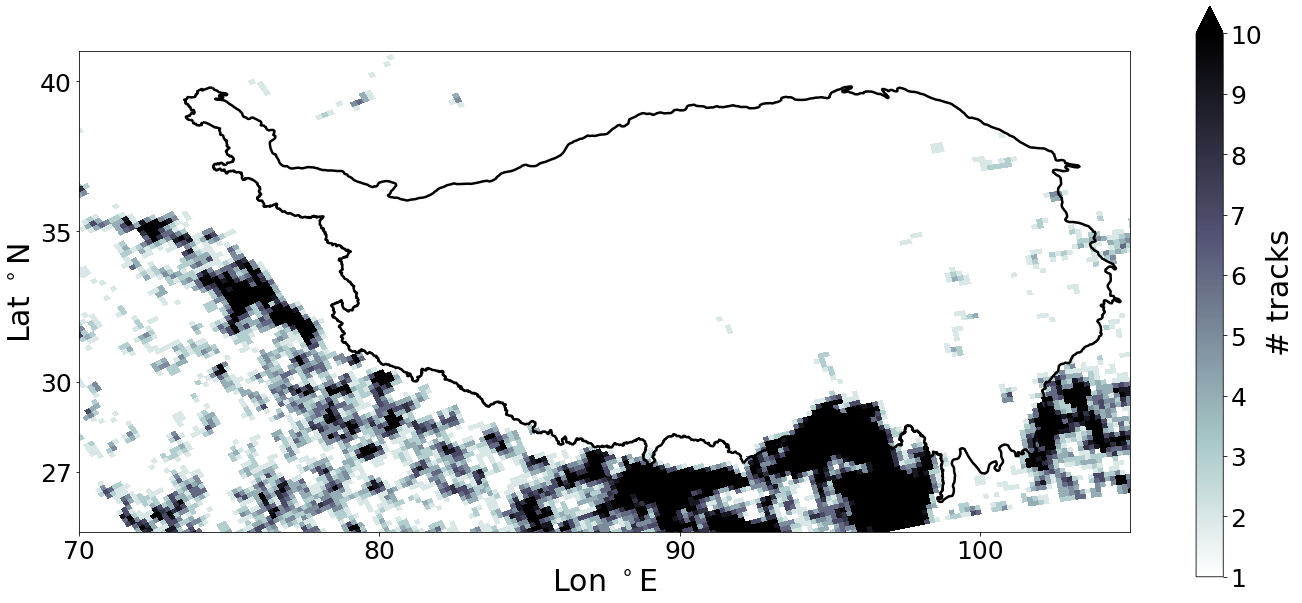

In [126]:
import matplotlib.pyplot as plt
import cartopy
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
plt.figure(figsize=(20, 9))

cmap = plt.cm.get_cmap('bone_r')

m = Basemap(projection='cyl', llcrnrlat=25.0,urcrnrlat=41.0, llcrnrlon=70.0, urcrnrlon=105,  resolution = 'c')

xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, density, cmap=cmap, vmin= 1 ,vmax= 10)
cmap.set_under(color='white')

xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40]

plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
plt.yticks([27,30, 35, 40],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$E',  fontsize=30)
plt.ylabel('Lat $^\circ$N',  fontsize=30)

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)





cbar = plt.colorbar(extend= 'max')
cbar.set_label('# tracks', fontsize= 30)

plt.rcParams.update({'font.size': 25})
plt.tight_layout()

plt.savefig('/media/juli/Elements/comparison/cnrr_trackdensity_intense2000.png')


In [1544]:
cells= gpm_cells
cells_outside = cells[cells['TP_flag'] < 2]
cells_outside =cells_outside.sort_values(by = 'total_precip', ascending = False)[0:2000]


In [1556]:
cells= gpm_cells
cells = cells[cells['features>5mm'] > 5]
#cells = cells[cells['TP_flag'] == 2]
cells =cells.sort_values(by = 'total_precip', ascending = False)[0:2000]


cells_cnrr= cnrr_cells
cells_cnrr = cells_cnrr[cells_cnrr['features>5mm'] > 5]
cells_cnrr =cells_cnrr.sort_values(by = 'total_precip', ascending = False)[0:2000]

In [1545]:
cells.shape

(81809, 14)

In [1124]:

gpm = np.sqrt(gpm_cells.mean_area.values/ np.pi)
gpm_cells['eq_rad'] = gpm
eq_rad = np.sqrt(cnrr_cells.mean_area.values/ np.pi)
cnrr_cells['eq_rad'] = eq_rad

In [1153]:
gpm = gpm_cells.e.values
i = cnrr_cells.eq_rad.values
hist, edges_gpm= np.histogram(gpm, bins = 50, normed = True,  range = (i.min(), i.max()))
hist_cnrr, edges_cnrr= np.histogram(i, bins = 50, density = True)

In [1155]:
# intensity 
gpm = gpm_cells.total_precip.values/ gpm_cells.mean_area.values
i = cnrr_cells.total_precip.values/ cnrr_cells.mean_area.values
gpm_cells['intensity'] = gpm 
hist, edges_gpm= np.histogram(gpm , bins = 50, normed = True, range = (i.min(), i.max()))
cnrr_cells['intensity'] = i
hist_cnrr, edges_cnrr= np.histogram(i, bins = 50, density = True )

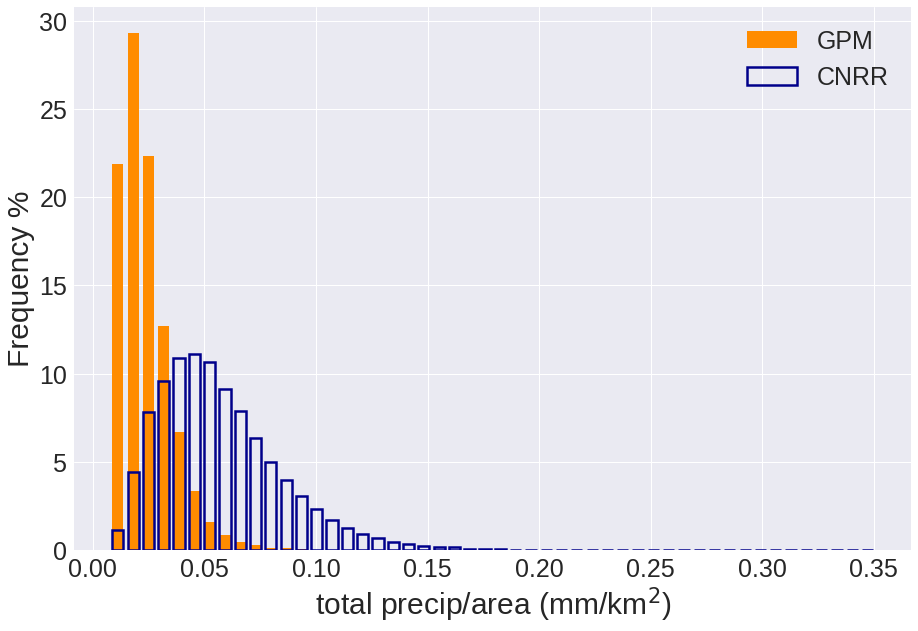

In [1163]:
# Lifetimes of tracked features:

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})

#plt.figure(figsize=(20, 17))
fig_lifetime, ax_lifetime= plt.subplots(figsize= (15,10))

xaxis = edges_gpm[:-1]
plt.bar(xaxis, hist/np.nansum(hist)*100, width=0.005, color='darkorange', label= 'GPM')
plt.bar(xaxis, hist_cnrr/np.nansum(hist_cnrr)*100, width=0.005, edgecolor='darkblue', color= 'None', linewidth= 2.5, label= 'CNRR' )


ax_lifetime.set_xlabel('total precip/area (mm/km$^2$)', fontsize= 30)
ax_lifetime.set_ylabel('Frequency %', fontsize = 30)
plt.legend(fontsize= 25)


# save figure to image file 
plt.savefig('/media/juli/Data/third_pole/mcs_tracking/tobac_plots/lifetime_largetracks.png')

## Scatter plots 

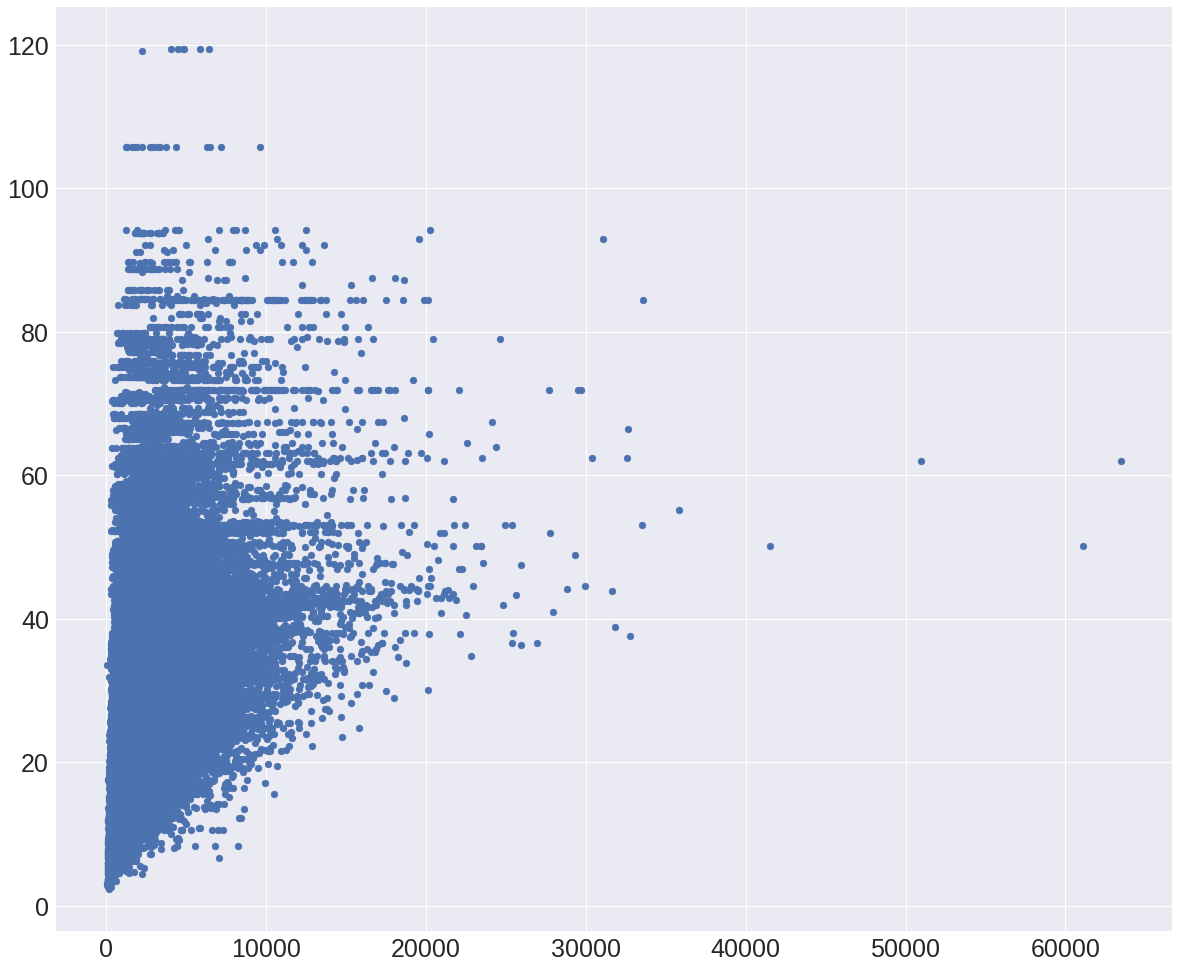

In [1185]:
# Lifetimes of tracked features:

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})

plt.figure(figsize=(20, 17))


plt.scatter(gpm_cells.total_precip.values, gpm_cells.max_rr.values)

ax_lifetime.set_xlabel('v/eq rad', fontsize= 30)
ax_lifetime.set_ylabel('Frequency %', fontsize = 30)


# save figure to image file 
plt.savefig('/media/juli/Data/third_pole/mcs_tracking/tobac_plots/scatter_precip_maxrr.png')

In [1189]:
cells.shape

(2000, 14)

## median_cnrr vs. median_gpm

In [1195]:
print(np.median(cells.eq_rad.values), np.median(cells_cnrr.eq_rad.values))
print(np.median(cells.total_precip.values), np.median(cells_cnrr.total_precip.values))
print(np.median(cells.max_rr.values), np.median(cells_cnrr.max_rr.values))
print(np.median(cells.mean_rr.values), np.median(cells_cnrr.mean_rr.values))
print(np.median(cells.lifetime.values), np.median(cells_cnrr.lifetime.values))
print(np.mean(cells.v.values), np.mean(cells_cnrr.v.values))

246.07646217537538 148.13618218855805
8009.518128395081 5395.956809997559
39.09038543701172 95.8921890258789
3.411629640393787 5.736599540710449
8.0 8.0
5.667108664824196 5.1975921175956215


- lifetime very similar for the largest total precip systems 
- rain rates are more extreme in CNRR, larger max rain rates => probably the most determining factor for high precip
- in general: GPM has more precip systems but not due to longer lifetime or higher max rain rates, but rather larger area 
- system propagatin is also similar, but CNRR move slightly slower which would mean a larger impact, but could be a time resolution issue also 

# Seasonal and diurnal statistics

In [115]:
# choose all track features which belong to respective cells
cell_tracks= pd.DataFrame(columns= Tracks_cnrr.columns)
for i in cnrr_intense.id.values:
    cell_tracks = cell_tracks.append(Tracks_cnrr[Tracks_cnrr.cell == i])

In [1547]:
cell_tracks= cell_tracks_outside

In [116]:
# get month and hour values and write to dataframe in extra column 
times = cell_tracks.timestr.values
months= []
for i,t in enumerate(times):
    months.append(times[i].astype('datetime64[s]').item().month)

hours= []
for i,t in enumerate(times):
    hours.append(times[i].astype('datetime64[s]').item().hour)
hours= np.array(hours)
months= np.array(months)

cell_tracks  = cell_tracks.reindex( columns = cell_tracks.columns.tolist() + ['month']) 
cell_tracks  = cell_tracks.reindex( columns = cell_tracks.columns.tolist() + ['hour']) 
cell_tracks['month']= months
cell_tracks['hour']= hours

In [117]:
# group by month or hourly values 
monthly = cell_tracks.groupby('month').mean()
hourly = cell_tracks.groupby('hour').mean()
percell = cell_tracks.groupby('cell')


In [1562]:
# get amount of cells per hour to mark when maximum area and maximum precip is achieved
max_areas= percell.max()["area"]
max_precip= percell.max()["max_rr"]
max_totalprecip= percell.max()["total_precip"]

In [1563]:
hours= np.zeros((24,))
for c, a in enumerate(max_areas):
    cell= cell_tracks[cell_tracks.cell == max_areas.index[c] ]
    idx = cell[cell.area == max_areas.values[c]].hour 
    hours[idx] += 1
percentages= hours/ 2000 * 100 

In [1564]:
# same for max rain rates 
hours= np.zeros((24,))
for c, a in enumerate(max_precip):
    cell= cell_tracks[cell_tracks.cell == max_precip.index[c] ]
    idx = cell[cell.max_rr == max_precip.values[c]].hour 
    hours[idx] += 1
percentages_precip = hours/2000 * 100

In [1565]:
# same for total precip 
hours= np.zeros((24,))
for c, a in enumerate(max_totalprecip):
    cell= cell_tracks[cell_tracks.cell == max_totalprecip.index[c] ]
    idx = cell[cell.total_precip == max_totalprecip.values[c]].hour 
    hours[idx] += 1
percentages_totalprecip = hours/2000 * 100

## Seasonal

In [110]:
cell_tracks = cnrr_intense

In [123]:
seasonal= np.unique(cell_tracks.month.values, return_counts= True)[1]


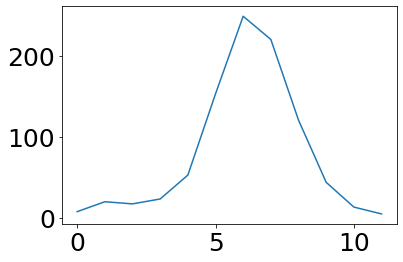

In [124]:
plt.plot(seasonal/20)



In [ ]:

percentages_totalprecip_tp = utc_to_local(percentages_totalprecip)
percentages_tp = utc_to_local(percentages)
percentages_precip_tp = utc_to_local(percentages_precip)


In [1566]:

percentages_totalprecip = utc_to_local(percentages_totalprecip)
percentages = utc_to_local(percentages)
percentages_precip = utc_to_local(percentages_precip)



In [1493]:

def utc_to_local(arr):
    localtime=np.concatenate((arr[16:24], arr[0:16]), axis= 0  )
    return localtime

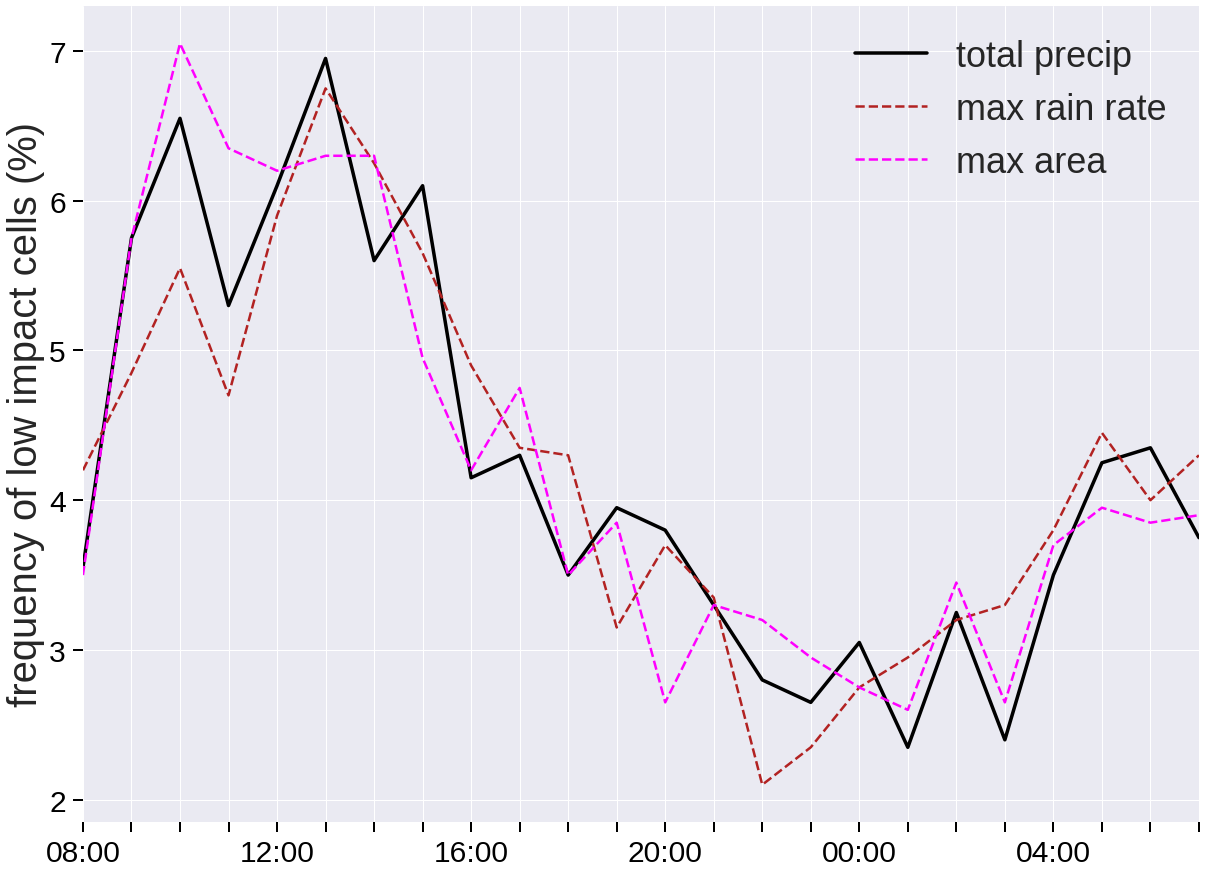

In [1576]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 30,
             'xtick.labelsize' : 30,
             'ytick.labelsize' : 30})
plt.figure(figsize=(20,15 ))

plt.plot(percentages_totalprecip, label= 'total precip', linestyle= '-', linewidth= 3.5, color = 'black')
plt.plot(percentages_precip, label= 'max rain rate',  linestyle= '--',linewidth= 2.5, color = 'firebrick')
plt.plot(percentages, label= 'max area', linestyle= '--', linewidth= 2.5, color = 'magenta')

#plt.plot(percentages_totalprecip_tp, label= 'total precip', linestyle= '-', linewidth= 3.5, color = 'firebrick')
#plt.plot(percentages_tp, label= 'max area', linestyle= '--', linewidth= 2.5, color = 'firebrick')
#plt.plot(percentages_precip_tp, label= 'max rain rate',  marker= 'o',  linestyle= '--', linewidth= 2.5, color = 'firebrick', markersize=12)


x1= np.arange(0,24,1)
plt.xlim(0,23)
plt.xticks(x1, ['08:00','', '','', '12:00','', '','', '16:00','', '','', '20:00','', '','', '00:00','', '','',  '04:00',''])
plt.tick_params(direction='out', length=10, width=2, colors='k')

plt.legend(fontsize= 'large')
plt.ylabel('frequency of low impact cells (%)', fontsize= '40')

# save figure to image file 
plt.savefig('/media/juli/Data/third_pole/mcs_tracking/tobac_plots/diurnalcurve_largestprecip2000.png')